In [2]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from eigentrust import *
import torch

In [3]:
with open('figures/errors/trust_matrices_10000/trust_matrices_edit.json', 'r') as file:
    data1 = json.load(file)
with open('figures/errors/trust_matrices_5000/trust_matrices_edit.json', 'r') as file:
    data2 = json.load(file)
with open('figures/errors/trust_matrices_2500/trust_matrices.json', 'r') as file:
    data3 = json.load(file)
with open('figures/errors/trust_matrices_1000/trust_matrices.json', 'r') as file:
    data4 = json.load(file)


In [4]:
cov1 = np.zeros((25,25))
cov2 = np.zeros((25,25))
cov3 = np.zeros((25,25))
cov4 = np.zeros((25,25))

In [5]:
for i, cov in enumerate([cov1, cov2, cov3, cov4]):
    data = [data1, data2, data3, data4][i]
    for i in range(25):
        for j in range(25):
            cov_ij = 0
            for item in data:
                t_S = item[2]
                t_S_ = item[5]
                cov_ij += (t_S[i]-t_S_[i]) * (t_S[j]-t_S_[j])
            cov_ij /= len(data)*2
            cov[i,j] = cov_ij

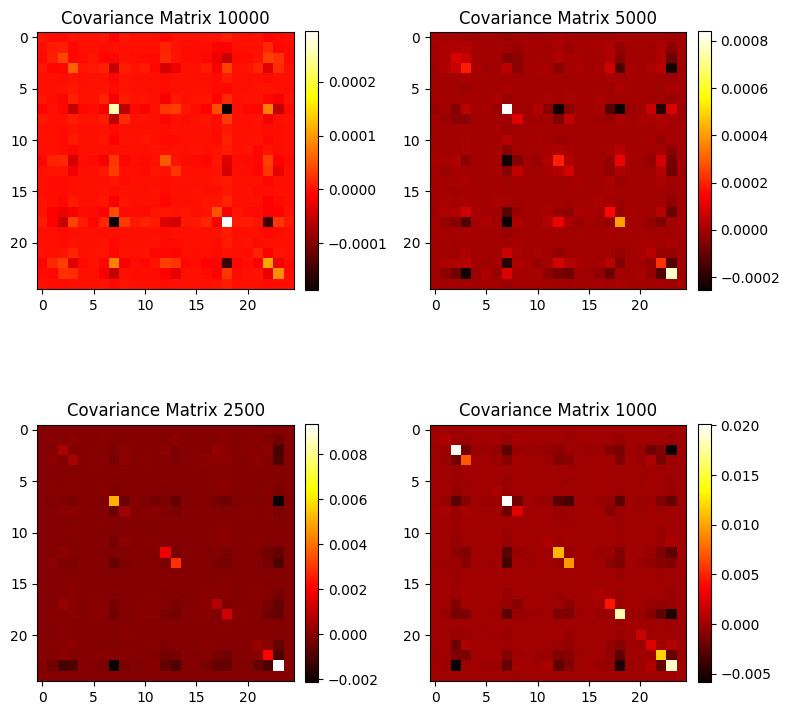

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
ax[0, 0].imshow(cov1, cmap='hot', interpolation='nearest')
ax[0, 0].set_title('Covariance Matrix 10000')
ax[0, 1].imshow(cov2, cmap='hot', interpolation='nearest')
ax[0, 1].set_title('Covariance Matrix 5000')
ax[1, 0].imshow(cov3, cmap='hot', interpolation='nearest')
ax[1, 0].set_title('Covariance Matrix 2500')
ax[1, 1].imshow(cov4, cmap='hot', interpolation='nearest')
ax[1, 1].set_title('Covariance Matrix 1000')
plt.colorbar(ax[0, 0].imshow(cov1, cmap='hot', interpolation='nearest'), ax=ax[0, 0], fraction=0.046, pad=0.04)
plt.colorbar(ax[0, 1].imshow(cov2, cmap='hot', interpolation='nearest'), ax=ax[0, 1], fraction=0.046, pad=0.04)
plt.colorbar(ax[1, 0].imshow(cov3, cmap='hot', interpolation='nearest'), ax=ax[1, 0], fraction=0.046, pad=0.04)
plt.colorbar(ax[1, 1].imshow(cov4, cmap='hot', interpolation='nearest'), ax=ax[1, 1], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

In [18]:
np.diagonal(np.array(cov3) / np.array(cov4))

array([0.16492945, 0.13910944, 0.03187988, 0.08143771, 0.09100576,
       0.22114425, 0.12463159, 0.25195602, 0.18386119, 0.03415468,
       0.10923237, 0.15797911, 0.16220908, 0.30007423, 0.05371938,
       0.12045644, 0.12766607, 0.1747697 , 0.07049334, 0.07073221,
       0.00904482, 0.13259273, 0.17308299, 0.5016781 , 0.01498103])

In [19]:
np.average(np.array(cov3) / np.array(cov4))

0.000737296517659189

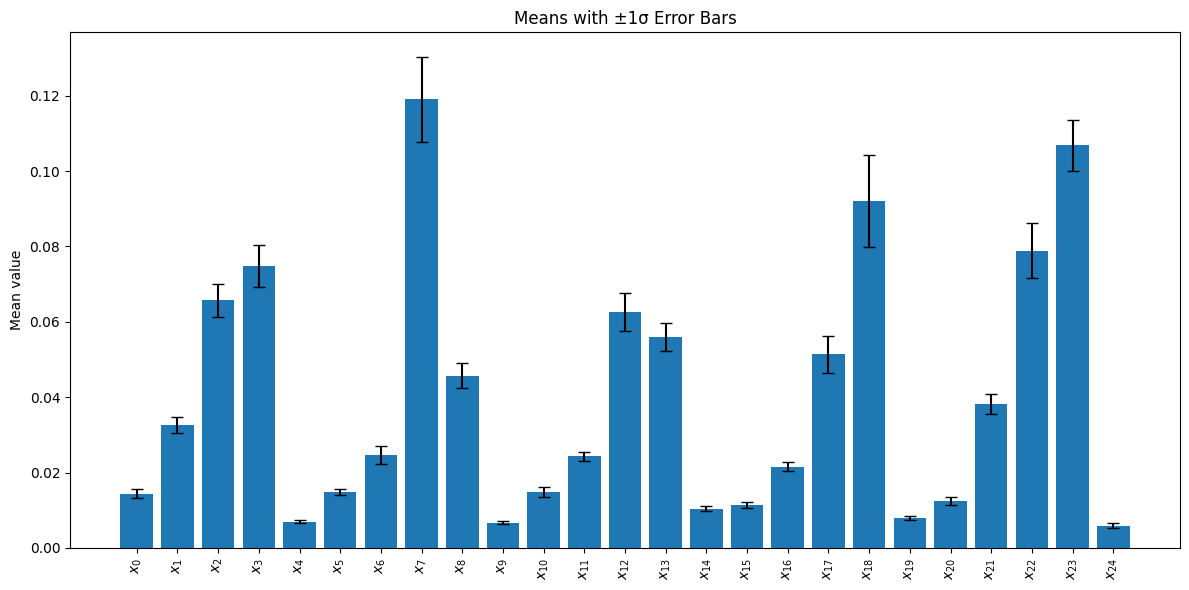

In [42]:
means = np.array([0.0144,   0.0326,   0.0657,   0.0748,   0.0070,  
                  0.0148,   0.0247,   0.1190,   0.0457,   0.0067,   
                  0.0149,   0.0243,   0.0626,   0.0560,   0.0104,   
                  0.0113,   0.0216,   0.0514,   0.0921,   0.0080,   
                  0.0124,   0.0382,   0.0789,   0.1068,   0.0059,])

stds  = np.sqrt(np.diag(cov_true))

# x-locations and labels
inds = np.arange(len(means))
labels = [f"$x_{{{i}}}$" for i in inds]

# plot
plt.figure(figsize=(12, 6))
plt.bar(inds, means, yerr=stds, capsize=4)
plt.xticks(inds, labels, rotation=90)
plt.ylabel("Mean value")
plt.title("Means with ±1σ Error Bars")
plt.tight_layout()
plt.show()

## 12/1 score stability tests (getting trust scores)

In [5]:
import numpy as np
from BT_criteria import *
from eigentrust import *
import random
from data_utils import *
import json
import torch
from tqdm import tqdm

def convert_elo(t):
    N = len(t) / sum(t)
    return 1500+400*np.log10(N*t)

In [2]:
path = 'transcript/20251119_000000/'
filepath = path + 'evaluations.json'
import json
evaluations = []
with open(filepath, 'r') as file:
    evaluations.extend(json.load(file))

In [3]:
comparisons, data_cleaned = extract_comparisons_with_ties_criteria(evaluations, num_criteria=8)
comparisons = handle_inconsistencies_with_ties_criteria(comparisons)
comparisons = [[0] + i[1:] for i in comparisons]

num_models = len(set([i[2] for i in comparisons ] + [i[3] for i in comparisons] + [i[4] for i in comparisons]))
num_criteria = len(set([i[0] for i in comparisons]))

Number of comparisons with a null response: 748
Number of comparisons with an API call error: 579
Number of judge responses missing a specific <criterion> match: 5848
Number of judge responses missing a number in the <criterion> match: 0
Number of judge responses with a non-0/1/2 number in the <criterion> match: 0

Total comparisons generated: 137096/153560


In [24]:
def train_trust_matrix(comparisons):
    d = 2
    NORMALIZE=False
    USE_BTD=True

    lr = 1e-3
    weight_decay = 0
    max_epochs = 10000

    batch_size=32
    dataloader = DataLoader(Comparisons(comparisons), batch_size=batch_size, shuffle=True)

    model = VectorBTD(num_criteria, num_models, d)
    train_vector_bt(
        model,
        dataloader,
        lr=lr,
        weight_decay=weight_decay,
        max_epochs=max_epochs,
        device='cpu',
        save_path=None,
        normalize=NORMALIZE,
        use_btd=USE_BTD
    )

    device = 'cpu'
    T = compute_trust_matrix_ties(model, device)
    t = eigentrust(T, alpha=0)

    return T,t,model

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch  10, Loss = 0.9839
loss converged, breaking


  1%|          | 1/100 [00:53<1:29:05, 53.99s/it]

Epoch  10, Loss = 0.9851
loss converged, breaking


  2%|▏         | 2/100 [01:39<1:20:08, 49.07s/it]

Epoch  10, Loss = 0.9843
loss converged, breaking


  3%|▎         | 3/100 [02:31<1:21:36, 50.48s/it]

Epoch  10, Loss = 0.9854
Epoch  20, Loss = 0.9842
loss converged, breaking


  4%|▍         | 4/100 [03:31<1:26:20, 53.97s/it]

Epoch  10, Loss = 0.9872
Epoch  20, Loss = 0.9858
loss converged, breaking


  5%|▌         | 5/100 [04:33<1:30:00, 56.85s/it]

Epoch  10, Loss = 0.9843
loss converged, breaking


  6%|▌         | 6/100 [05:20<1:24:03, 53.65s/it]

Epoch  10, Loss = 0.9848
Epoch  20, Loss = 0.9826
loss converged, breaking


  7%|▋         | 7/100 [06:32<1:32:24, 59.62s/it]

Epoch  10, Loss = 0.9862
loss converged, breaking


  8%|▊         | 8/100 [07:24<1:27:48, 57.27s/it]

Epoch  10, Loss = 0.9870
Epoch  20, Loss = 0.9856
loss converged, breaking


  9%|▉         | 9/100 [08:25<1:28:44, 58.52s/it]

Epoch  10, Loss = 0.9845
loss converged, breaking


 10%|█         | 10/100 [09:06<1:19:25, 52.95s/it]

Epoch  10, Loss = 0.9854
Epoch  20, Loss = 0.9839
loss converged, breaking


 11%|█         | 11/100 [10:06<1:21:38, 55.04s/it]

Epoch  10, Loss = 0.9816
loss converged, breaking


 12%|█▏        | 12/100 [10:49<1:15:43, 51.63s/it]

Epoch  10, Loss = 0.9838
loss converged, breaking


 13%|█▎        | 13/100 [11:28<1:09:08, 47.68s/it]

Epoch  10, Loss = 0.9846
loss converged, breaking


 14%|█▍        | 14/100 [12:09<1:05:24, 45.63s/it]

Epoch  10, Loss = 0.9890
Epoch  20, Loss = 0.9874
loss converged, breaking


 15%|█▌        | 15/100 [13:22<1:16:26, 53.96s/it]

Epoch  10, Loss = 0.9859
Epoch  20, Loss = 0.9847
loss converged, breaking


 16%|█▌        | 16/100 [14:42<1:26:18, 61.65s/it]

Epoch  10, Loss = 0.9861
Epoch  20, Loss = 0.9840
loss converged, breaking


 17%|█▋        | 17/100 [15:47<1:26:41, 62.67s/it]

Epoch  10, Loss = 0.9870
loss converged, breaking


 18%|█▊        | 18/100 [16:23<1:14:45, 54.70s/it]

Epoch  10, Loss = 0.9831
loss converged, breaking


 19%|█▉        | 19/100 [17:12<1:11:45, 53.15s/it]

Epoch  10, Loss = 0.9852
loss converged, breaking


 20%|██        | 20/100 [17:54<1:06:19, 49.75s/it]

Epoch  10, Loss = 0.9848


/Users/jchang153/Documents/GitHub/EigenBench/BT_criteria.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


loss converged, breaking


 21%|██        | 21/100 [18:37<1:02:45, 47.66s/it]

Epoch  10, Loss = 0.9876
loss converged, breaking


 22%|██▏       | 22/100 [19:27<1:02:51, 48.35s/it]

Epoch  10, Loss = 0.9839
loss converged, breaking


 23%|██▎       | 23/100 [20:06<58:15, 45.40s/it]  

Epoch  10, Loss = 0.9829
loss converged, breaking


 24%|██▍       | 24/100 [20:52<57:44, 45.58s/it]

Epoch  10, Loss = 0.9847
loss converged, breaking


 25%|██▌       | 25/100 [21:29<54:04, 43.26s/it]

Epoch  10, Loss = 0.9852
Epoch  20, Loss = 0.9834
loss converged, breaking


 26%|██▌       | 26/100 [22:32<1:00:24, 48.97s/it]

Epoch  10, Loss = 0.9892
Epoch  20, Loss = 0.9878
loss converged, breaking


 27%|██▋       | 27/100 [23:37<1:05:24, 53.76s/it]

Epoch  10, Loss = 0.9866
loss converged, breaking


 28%|██▊       | 28/100 [24:17<59:46, 49.81s/it]  

Epoch  10, Loss = 0.9865
loss converged, breaking


 29%|██▉       | 29/100 [25:03<57:34, 48.66s/it]

Epoch  10, Loss = 0.9841
loss converged, breaking


 30%|███       | 30/100 [25:58<58:49, 50.43s/it]

Epoch  10, Loss = 0.9880
Epoch  20, Loss = 0.9844
loss converged, breaking


 31%|███       | 31/100 [27:09<1:05:15, 56.75s/it]

Epoch  10, Loss = 0.9835
loss converged, breaking


 32%|███▏      | 32/100 [27:48<58:07, 51.29s/it]  

Epoch  10, Loss = 0.9859
Epoch  20, Loss = 0.9848
loss converged, breaking


 33%|███▎      | 33/100 [28:46<59:25, 53.22s/it]

Epoch  10, Loss = 0.9861
Epoch  20, Loss = 0.9848
loss converged, breaking


 34%|███▍      | 34/100 [29:43<59:57, 54.50s/it]

Epoch  10, Loss = 0.9850
loss converged, breaking


 35%|███▌      | 35/100 [30:26<55:17, 51.04s/it]

Epoch  10, Loss = 0.9860
loss converged, breaking


 36%|███▌      | 36/100 [31:12<52:42, 49.41s/it]

Epoch  10, Loss = 0.9858
loss converged, breaking


 37%|███▋      | 37/100 [31:52<49:07, 46.78s/it]

Epoch  10, Loss = 0.9861
loss converged, breaking


 38%|███▊      | 38/100 [32:38<48:08, 46.58s/it]

Epoch  10, Loss = 0.9882
loss converged, breaking


 39%|███▉      | 39/100 [33:27<48:02, 47.26s/it]

Epoch  10, Loss = 0.9851
loss converged, breaking


 40%|████      | 40/100 [34:16<47:41, 47.69s/it]

Epoch  10, Loss = 0.9845
loss converged, breaking


 41%|████      | 41/100 [34:57<44:51, 45.63s/it]

Epoch  10, Loss = 0.9838
loss converged, breaking


 42%|████▏     | 42/100 [35:38<42:42, 44.17s/it]

Epoch  10, Loss = 0.9888
Epoch  20, Loss = 0.9873
Epoch  30, Loss = 0.9861
loss converged, breaking


 43%|████▎     | 43/100 [37:04<54:08, 56.99s/it]

Epoch  10, Loss = 0.9841
loss converged, breaking


 44%|████▍     | 44/100 [37:50<50:07, 53.71s/it]

Epoch  10, Loss = 0.9847
loss converged, breaking


 45%|████▌     | 45/100 [38:31<45:42, 49.87s/it]

Epoch  10, Loss = 0.9854
loss converged, breaking


 46%|████▌     | 46/100 [39:12<42:22, 47.08s/it]

Epoch  10, Loss = 0.9862
loss converged, breaking


 47%|████▋     | 47/100 [39:50<39:13, 44.40s/it]

Epoch  10, Loss = 0.9879
loss converged, breaking


 48%|████▊     | 48/100 [40:28<36:48, 42.47s/it]

Epoch  10, Loss = 0.9877
loss converged, breaking


 49%|████▉     | 49/100 [41:06<34:56, 41.11s/it]

Epoch  10, Loss = 0.9854
loss converged, breaking


 50%|█████     | 50/100 [41:57<36:47, 44.15s/it]

Epoch  10, Loss = 0.9857
Epoch  20, Loss = 0.9842
loss converged, breaking


 51%|█████     | 51/100 [43:05<41:46, 51.15s/it]

Epoch  10, Loss = 0.9837
loss converged, breaking


 52%|█████▏    | 52/100 [43:42<37:41, 47.12s/it]

Epoch  10, Loss = 0.9814
Epoch  20, Loss = 0.9800
loss converged, breaking


 53%|█████▎    | 53/100 [44:49<41:35, 53.09s/it]

Epoch  10, Loss = 0.9845
loss converged, breaking


 54%|█████▍    | 54/100 [45:41<40:16, 52.54s/it]

Epoch  10, Loss = 0.9841
loss converged, breaking


 55%|█████▌    | 55/100 [46:19<36:06, 48.15s/it]

Epoch  10, Loss = 0.9866
loss converged, breaking


 56%|█████▌    | 56/100 [47:13<36:42, 50.05s/it]

Epoch  10, Loss = 0.9836
loss converged, breaking


 57%|█████▋    | 57/100 [47:51<33:15, 46.41s/it]

Epoch  10, Loss = 0.9844
loss converged, breaking


 58%|█████▊    | 58/100 [48:34<31:40, 45.25s/it]

Epoch  10, Loss = 0.9835
loss converged, breaking


 59%|█████▉    | 59/100 [49:20<31:04, 45.47s/it]

Epoch  10, Loss = 0.9861
loss converged, breaking


 60%|██████    | 60/100 [50:09<31:04, 46.62s/it]

Epoch  10, Loss = 0.9843
loss converged, breaking


 61%|██████    | 61/100 [51:02<31:40, 48.73s/it]

Epoch  10, Loss = 0.9847
loss converged, breaking


 62%|██████▏   | 62/100 [51:54<31:22, 49.54s/it]

Epoch  10, Loss = 0.9872
Epoch  20, Loss = 0.9861
loss converged, breaking


 63%|██████▎   | 63/100 [52:51<31:54, 51.73s/it]

Epoch  10, Loss = 0.9859
loss converged, breaking


 64%|██████▍   | 64/100 [53:35<29:37, 49.37s/it]

Epoch  10, Loss = 0.9870
Epoch  20, Loss = 0.9858
Epoch  30, Loss = 0.9842
loss converged, breaking


 65%|██████▌   | 65/100 [55:13<37:20, 64.02s/it]

Epoch  10, Loss = 0.9855
loss converged, breaking


 66%|██████▌   | 66/100 [55:59<33:18, 58.79s/it]

Epoch  10, Loss = 0.9846
Epoch  20, Loss = 0.9825
loss converged, breaking


 67%|██████▋   | 67/100 [57:05<33:27, 60.84s/it]

Epoch  10, Loss = 0.9847
loss converged, breaking


 68%|██████▊   | 68/100 [57:54<30:33, 57.29s/it]

Epoch  10, Loss = 0.9836
loss converged, breaking


 69%|██████▉   | 69/100 [58:43<28:18, 54.79s/it]

Epoch  10, Loss = 0.9839
loss converged, breaking


 70%|███████   | 70/100 [59:24<25:19, 50.66s/it]

Epoch  10, Loss = 0.9818
loss converged, breaking


 71%|███████   | 71/100 [1:00:08<23:26, 48.51s/it]

Epoch  10, Loss = 0.9813
loss converged, breaking


 72%|███████▏  | 72/100 [1:00:54<22:19, 47.82s/it]

Epoch  10, Loss = 0.9850
loss converged, breaking


 73%|███████▎  | 73/100 [1:01:43<21:39, 48.15s/it]

Epoch  10, Loss = 0.9839
loss converged, breaking


 74%|███████▍  | 74/100 [1:02:29<20:35, 47.52s/it]

Epoch  10, Loss = 0.9849
loss converged, breaking


 75%|███████▌  | 75/100 [1:03:09<18:56, 45.46s/it]

Epoch  10, Loss = 0.9891
Epoch  20, Loss = 0.9881
loss converged, breaking


 76%|███████▌  | 76/100 [1:04:08<19:47, 49.46s/it]

Epoch  10, Loss = 0.9865
loss converged, breaking


 77%|███████▋  | 77/100 [1:05:02<19:27, 50.75s/it]

Epoch  10, Loss = 0.9855
loss converged, breaking


 78%|███████▊  | 78/100 [1:05:48<18:04, 49.28s/it]

Epoch  10, Loss = 0.9840
loss converged, breaking


 79%|███████▉  | 79/100 [1:06:23<15:45, 45.02s/it]

Epoch  10, Loss = 0.9848
loss converged, breaking


 80%|████████  | 80/100 [1:07:03<14:31, 43.56s/it]

Epoch  10, Loss = 0.9839
loss converged, breaking


 81%|████████  | 81/100 [1:07:41<13:14, 41.80s/it]

Epoch  10, Loss = 0.9848
loss converged, breaking


 82%|████████▏ | 82/100 [1:08:18<12:09, 40.52s/it]

Epoch  10, Loss = 0.9858
Epoch  20, Loss = 0.9846
loss converged, breaking


 83%|████████▎ | 83/100 [1:09:15<12:51, 45.36s/it]

Epoch  10, Loss = 0.9867
loss converged, breaking


 84%|████████▍ | 84/100 [1:10:09<12:46, 47.93s/it]

Epoch  10, Loss = 0.9863
Epoch  20, Loss = 0.9835
loss converged, breaking


 85%|████████▌ | 85/100 [1:11:14<13:17, 53.19s/it]

Epoch  10, Loss = 0.9861
Epoch  20, Loss = 0.9846
loss converged, breaking


 86%|████████▌ | 86/100 [1:12:22<13:26, 57.60s/it]

Epoch  10, Loss = 0.9852
loss converged, breaking


 87%|████████▋ | 87/100 [1:13:00<11:11, 51.65s/it]

Epoch  10, Loss = 0.9864
Epoch  20, Loss = 0.9852
loss converged, breaking


 88%|████████▊ | 88/100 [1:13:58<10:42, 53.57s/it]

Epoch  10, Loss = 0.9825
loss converged, breaking


 89%|████████▉ | 89/100 [1:14:42<09:18, 50.74s/it]

Epoch  10, Loss = 0.9874
loss converged, breaking


 90%|█████████ | 90/100 [1:15:18<07:41, 46.20s/it]

Epoch  10, Loss = 0.9878
loss converged, breaking


 91%|█████████ | 91/100 [1:16:12<07:17, 48.64s/it]

Epoch  10, Loss = 0.9856
loss converged, breaking


 92%|█████████▏| 92/100 [1:16:56<06:16, 47.09s/it]

Epoch  10, Loss = 0.9825
loss converged, breaking


 93%|█████████▎| 93/100 [1:17:44<05:32, 47.56s/it]

Epoch  10, Loss = 0.9817
loss converged, breaking


 94%|█████████▍| 94/100 [1:18:38<04:56, 49.49s/it]

Epoch  10, Loss = 0.9854
Epoch  20, Loss = 0.9835
loss converged, breaking


 95%|█████████▌| 95/100 [1:19:49<04:38, 55.76s/it]

Epoch  10, Loss = 0.9822
loss converged, breaking


 96%|█████████▌| 96/100 [1:20:30<03:25, 51.40s/it]

Epoch  10, Loss = 0.9821
loss converged, breaking


 97%|█████████▋| 97/100 [1:21:14<02:27, 49.25s/it]

Epoch  10, Loss = 0.9859
loss converged, breaking


 98%|█████████▊| 98/100 [1:22:07<01:40, 50.23s/it]

Epoch  10, Loss = 0.9850
loss converged, breaking


 99%|█████████▉| 99/100 [1:22:56<00:50, 50.01s/it]

Epoch  10, Loss = 0.9858
loss converged, breaking


100%|██████████| 100/100 [1:23:43<00:00, 50.23s/it]


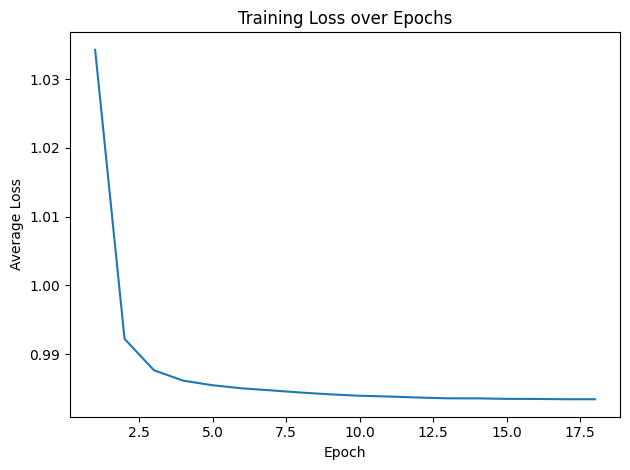

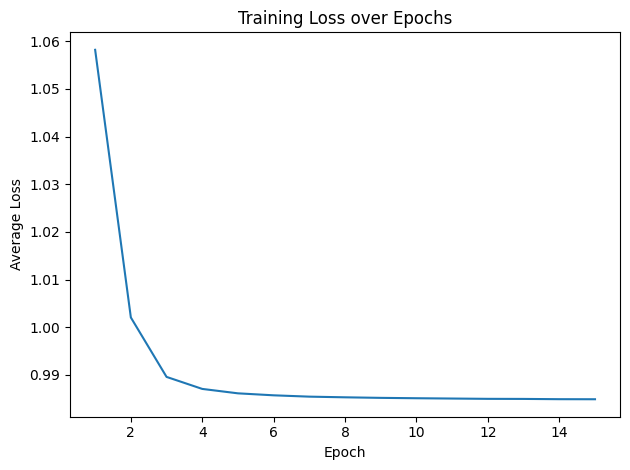

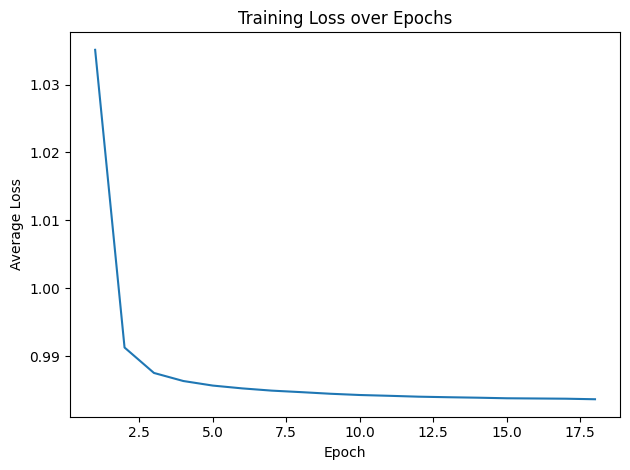

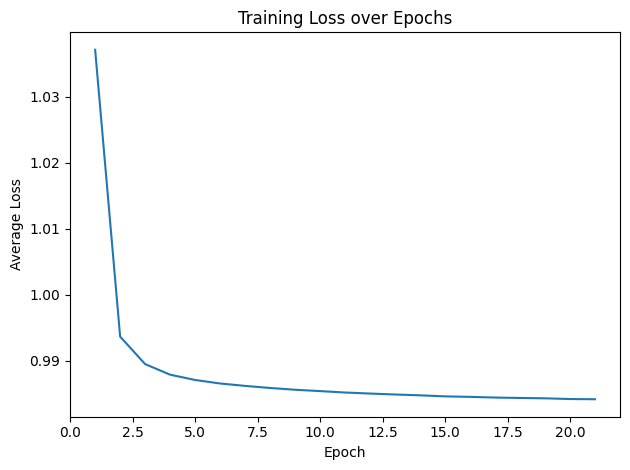

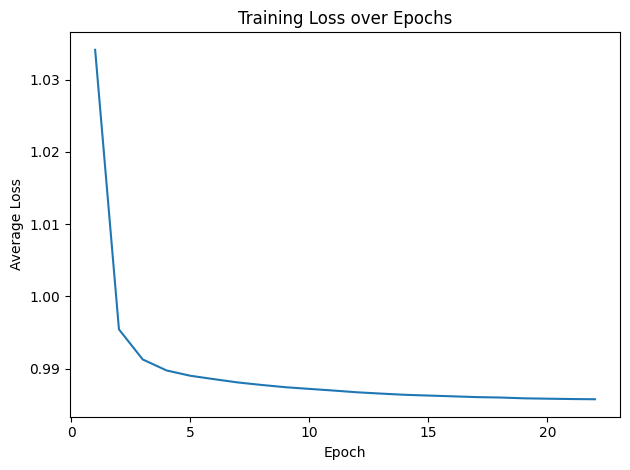

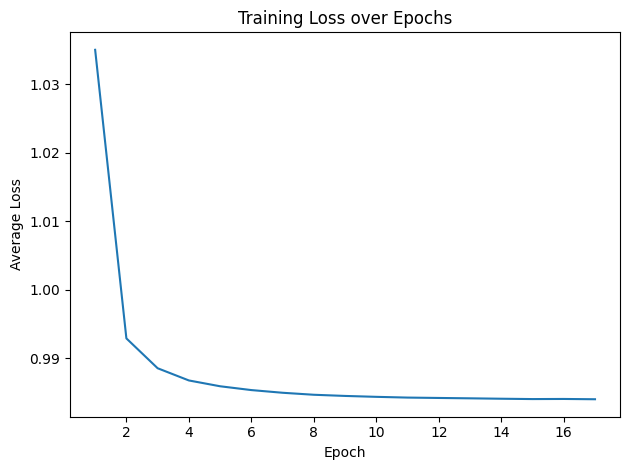

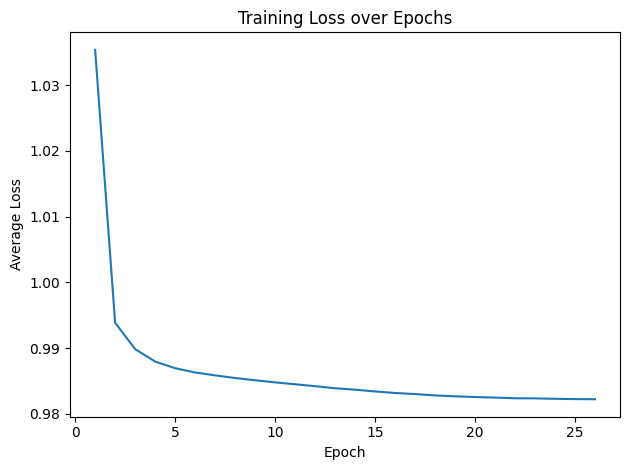

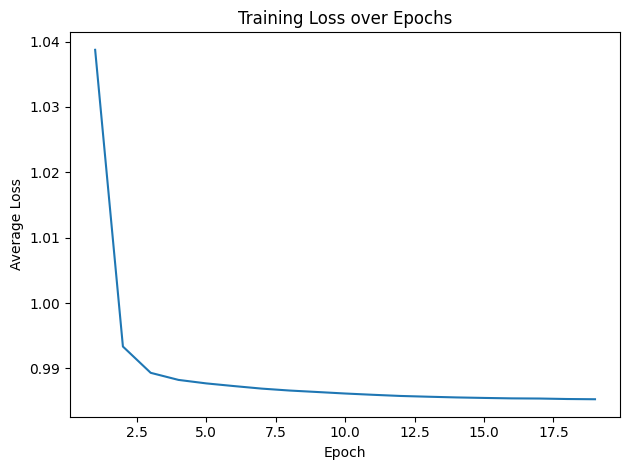

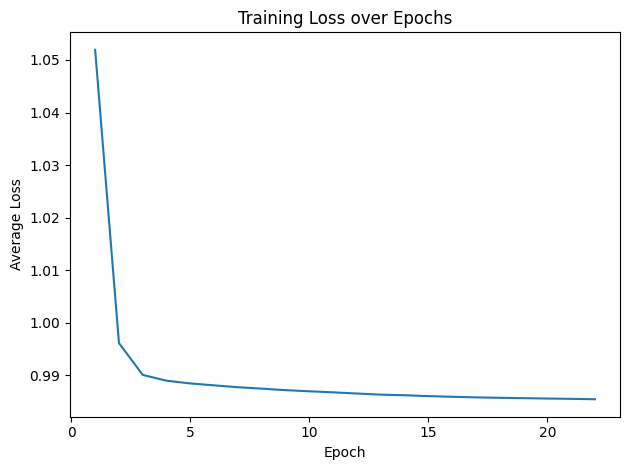

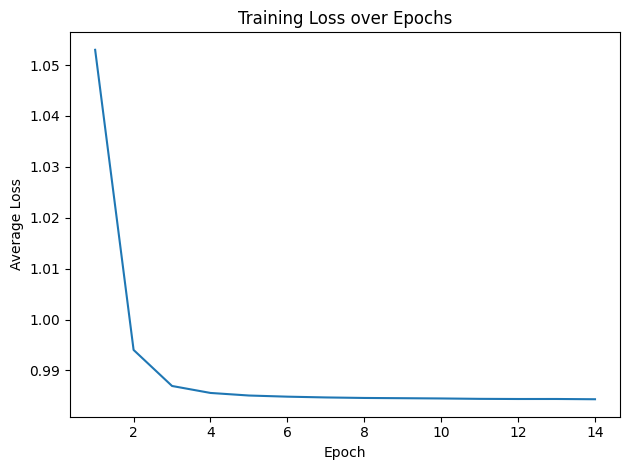

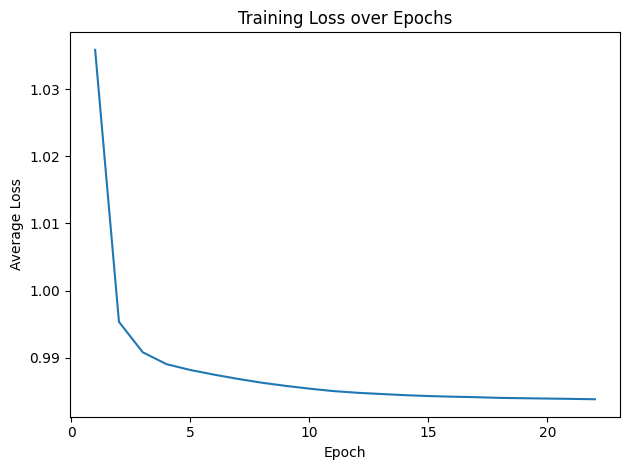

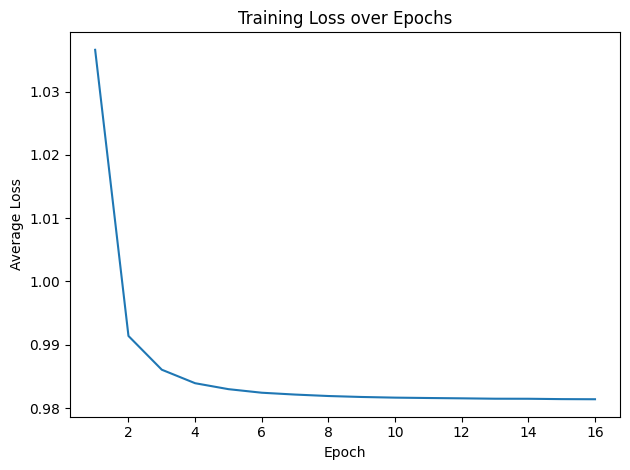

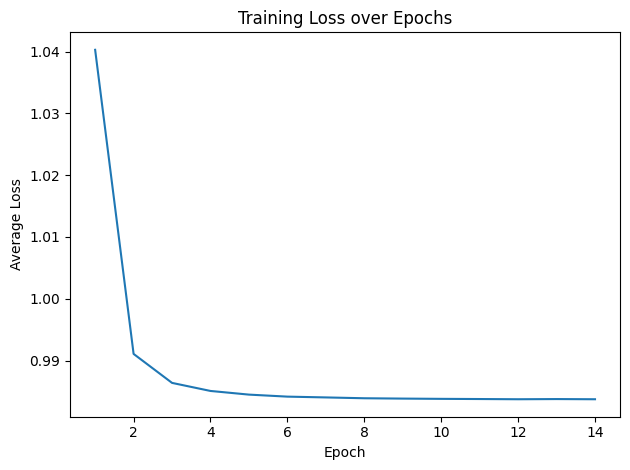

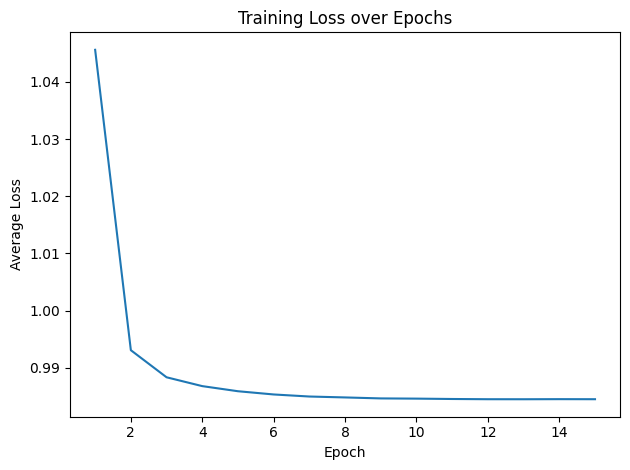

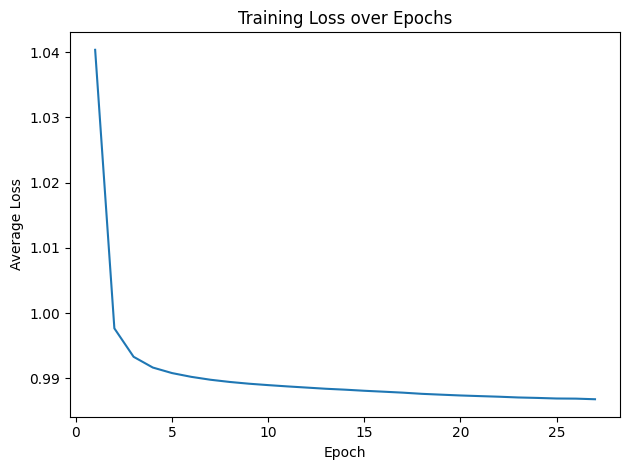

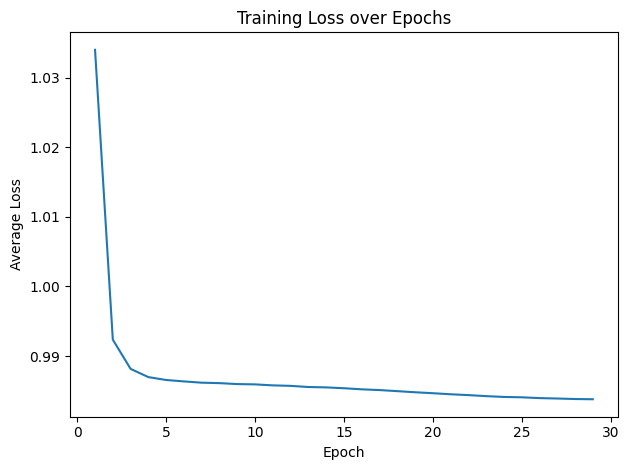

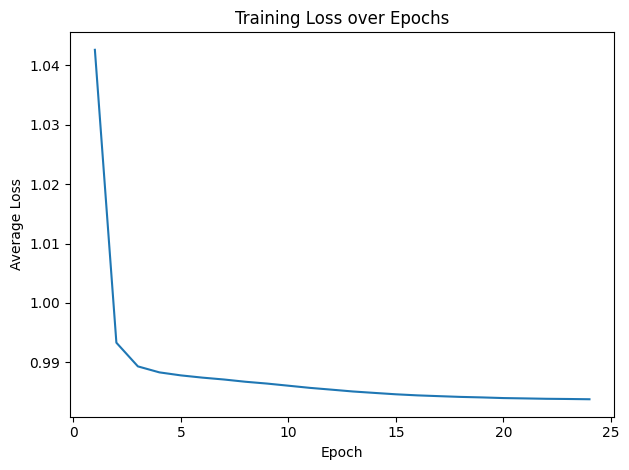

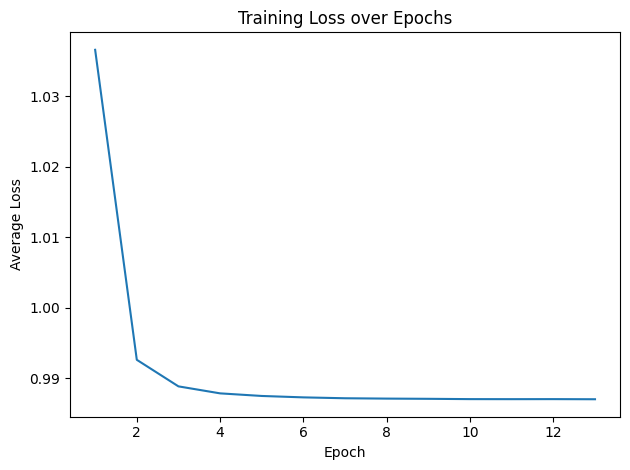

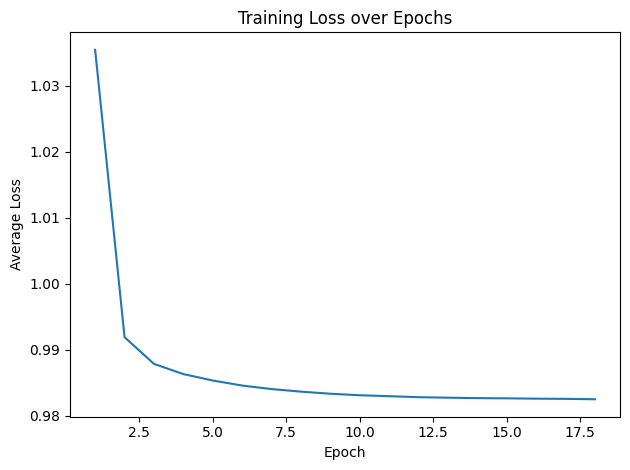

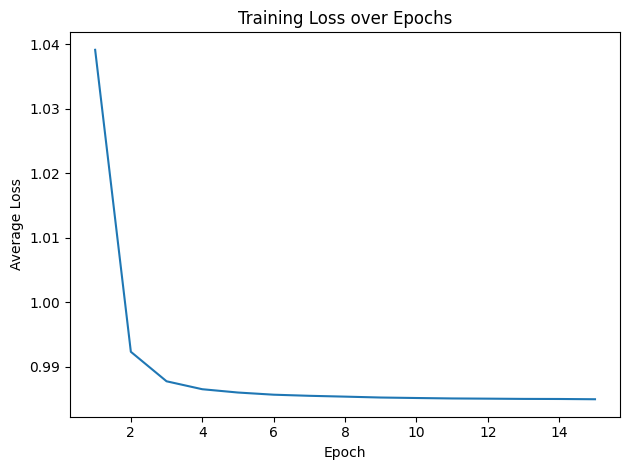

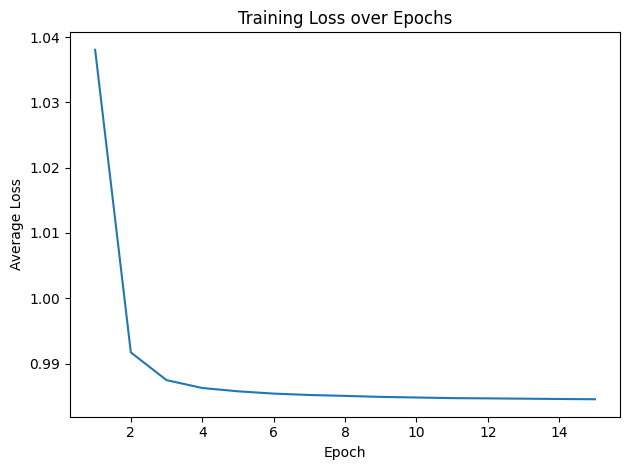

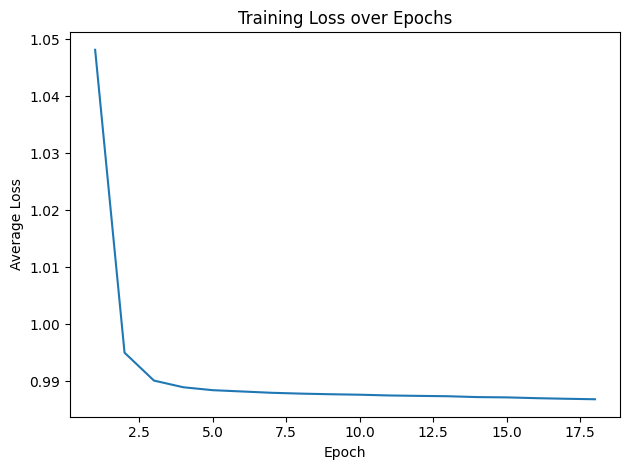

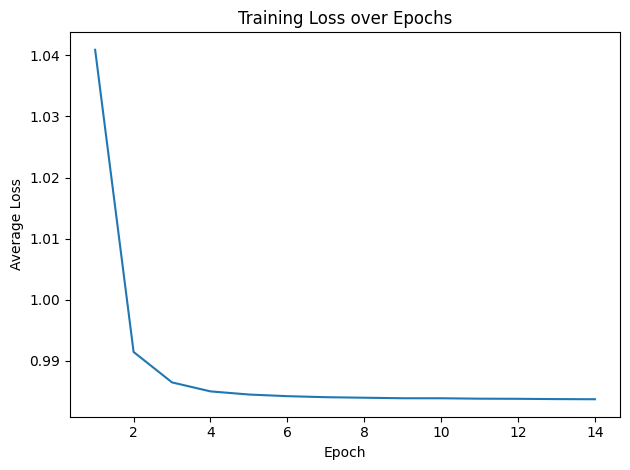

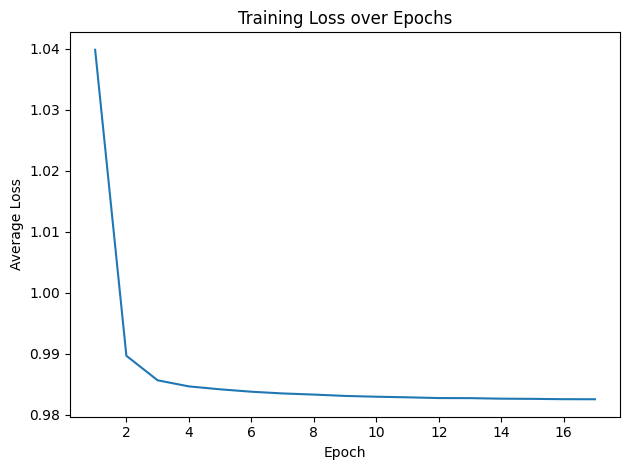

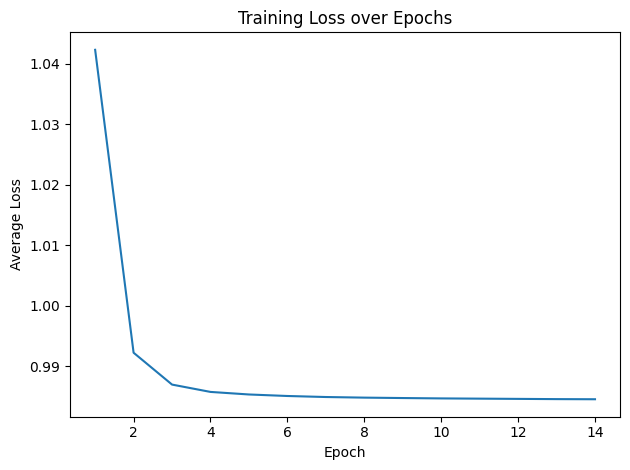

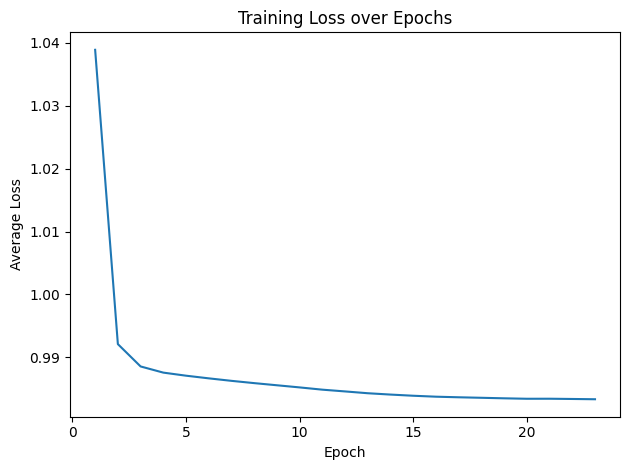

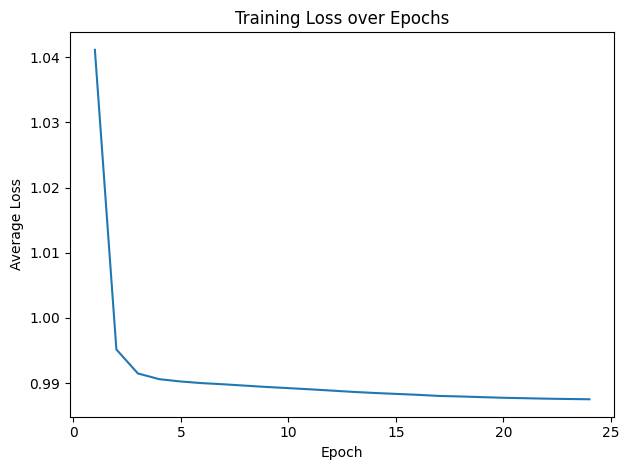

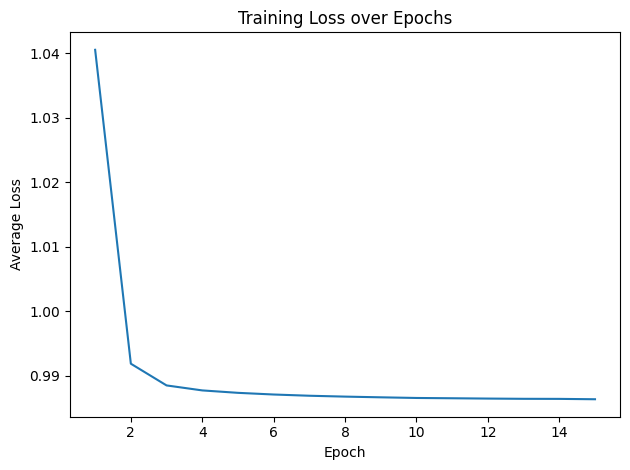

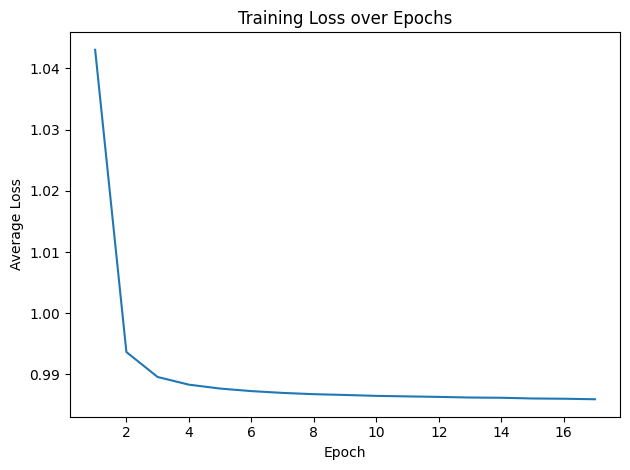

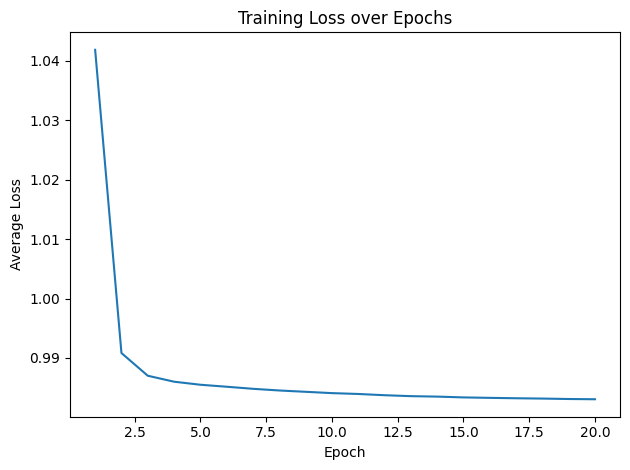

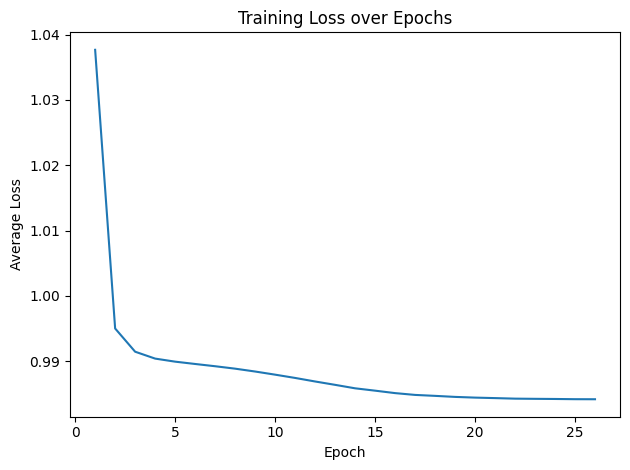

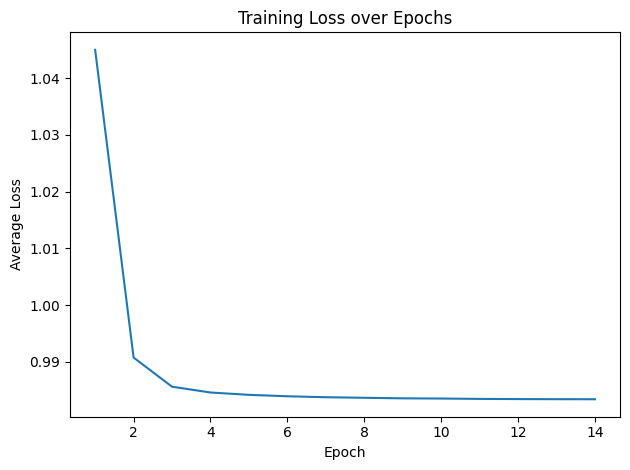

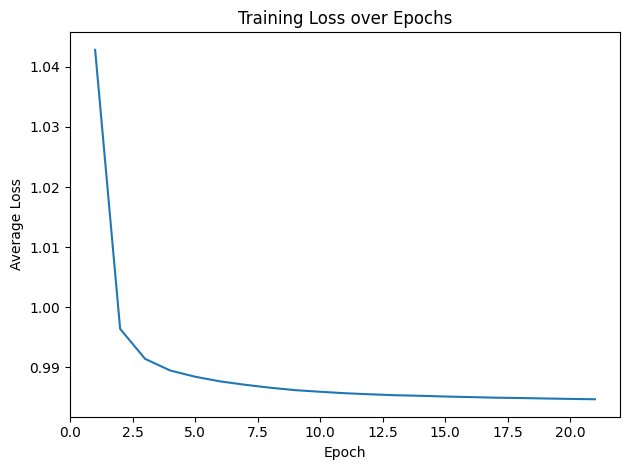

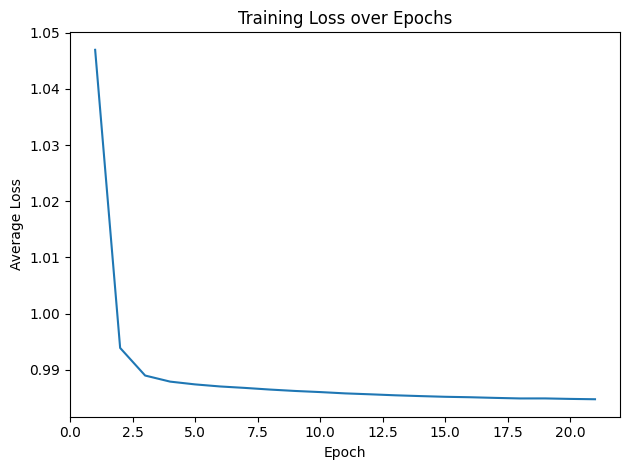

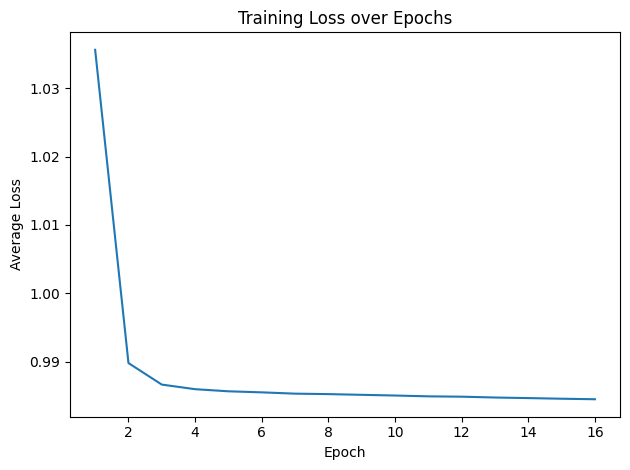

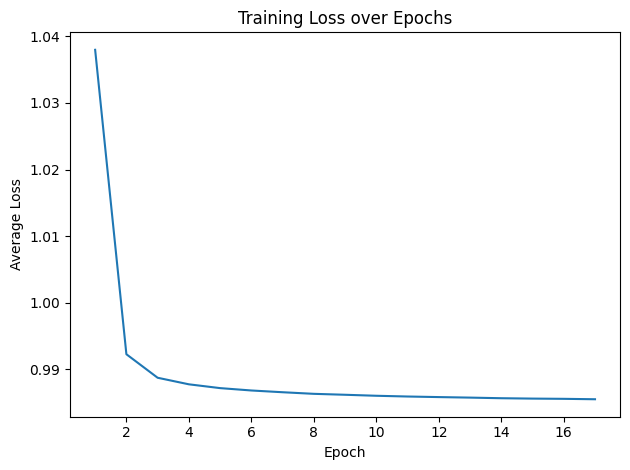

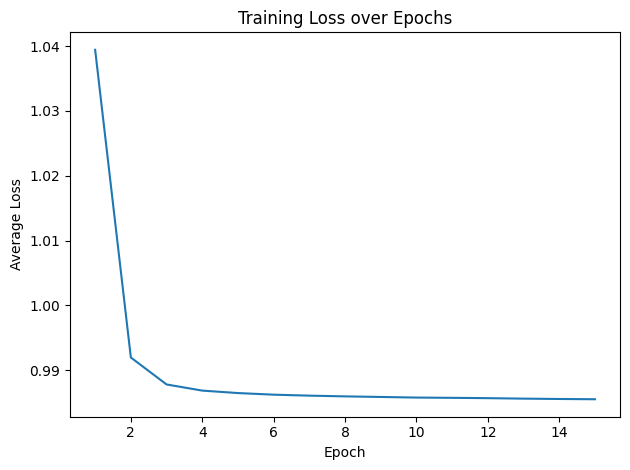

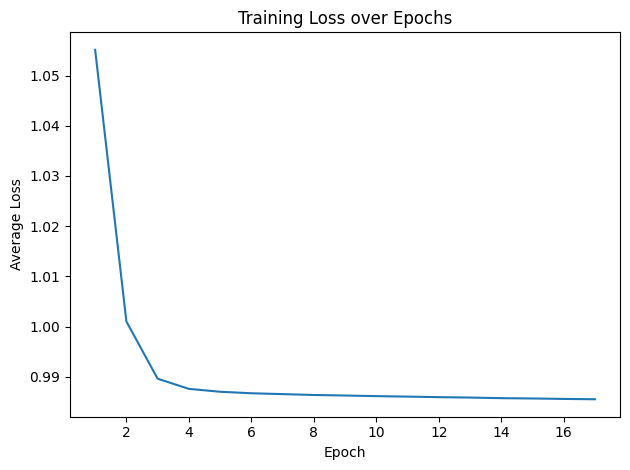

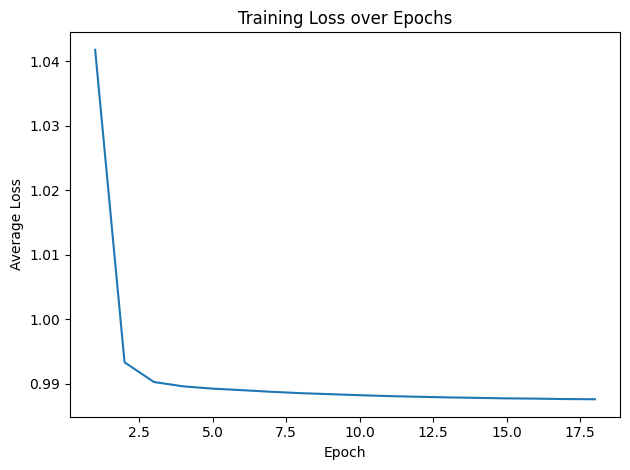

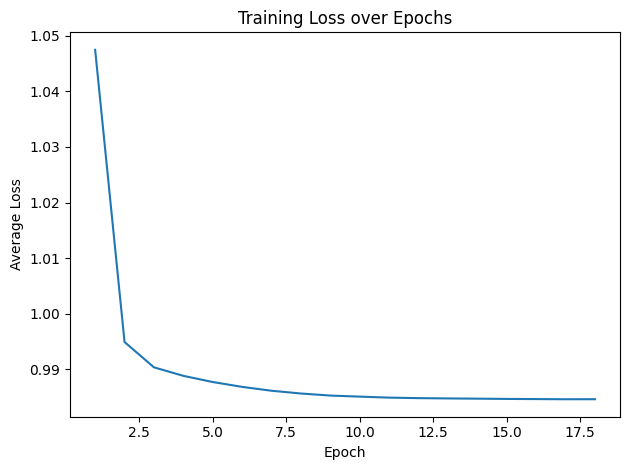

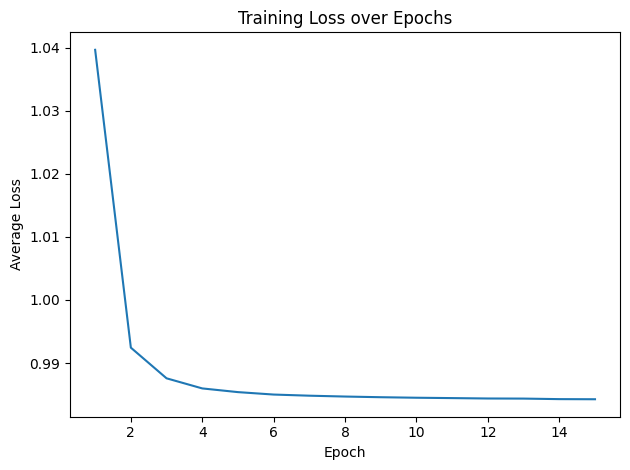

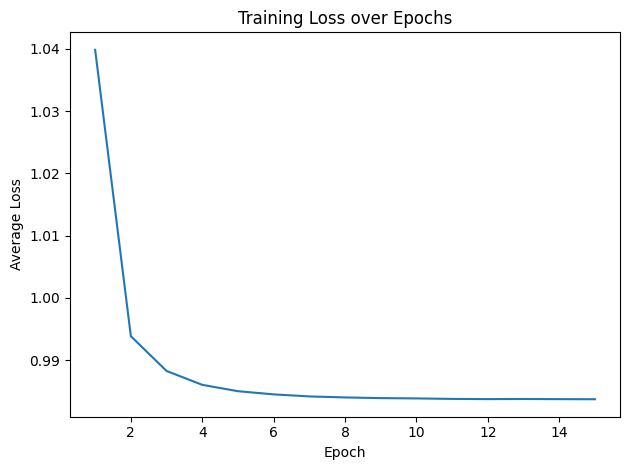

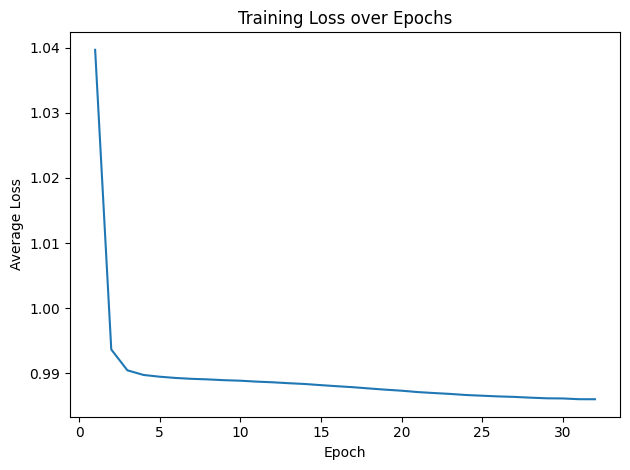

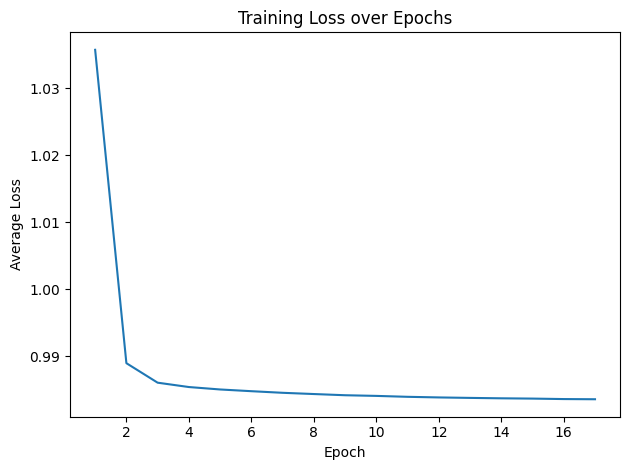

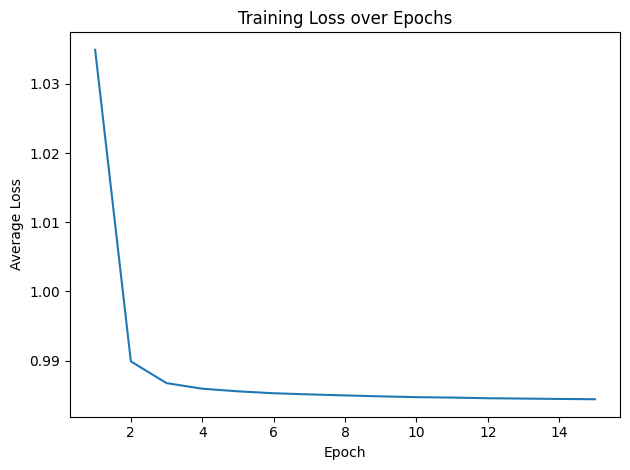

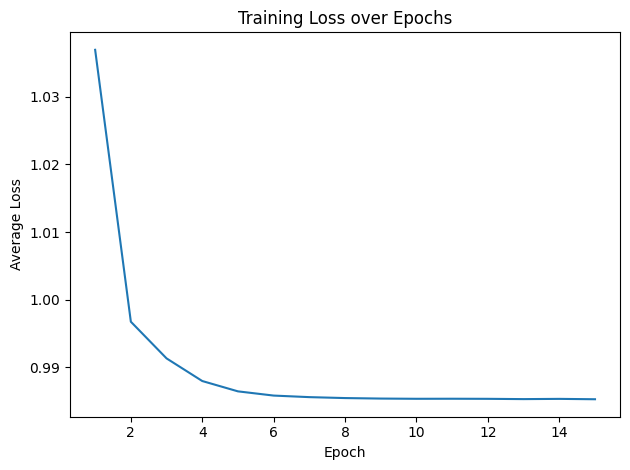

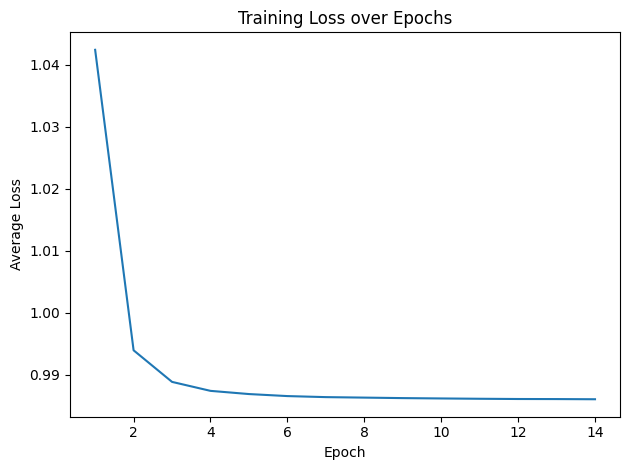

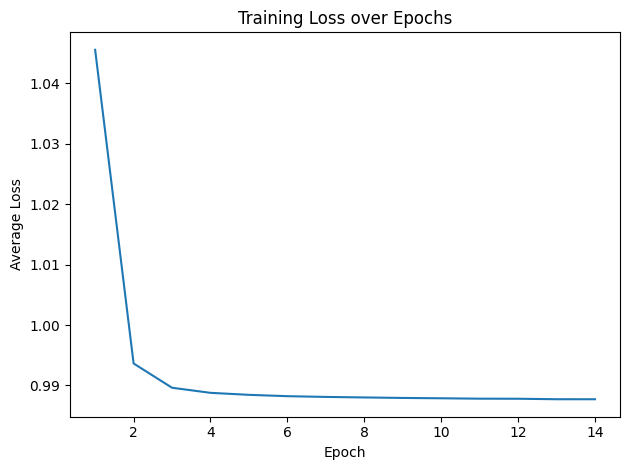

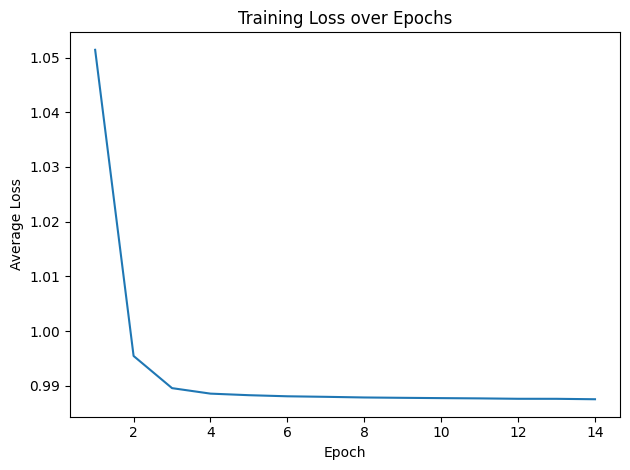

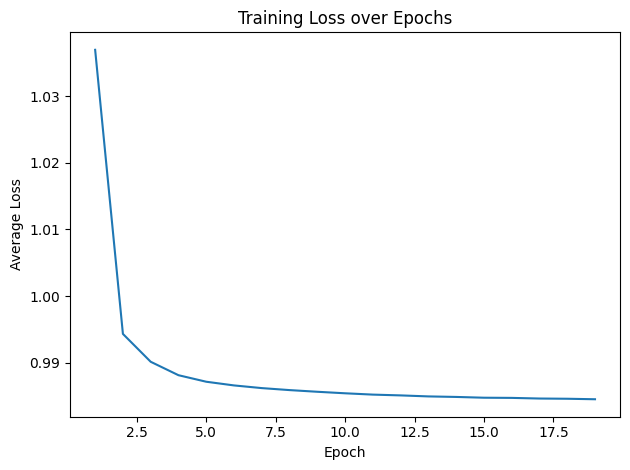

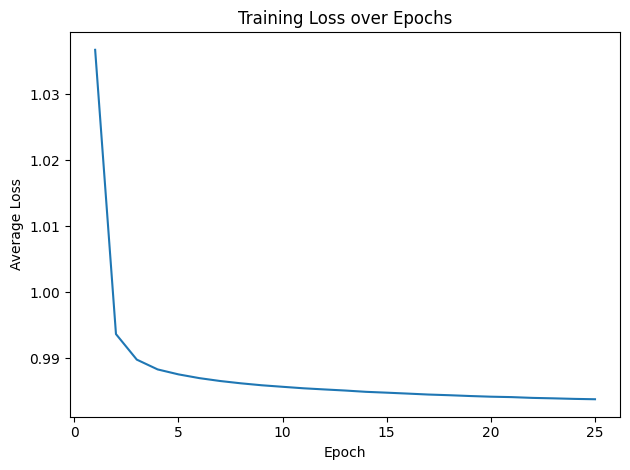

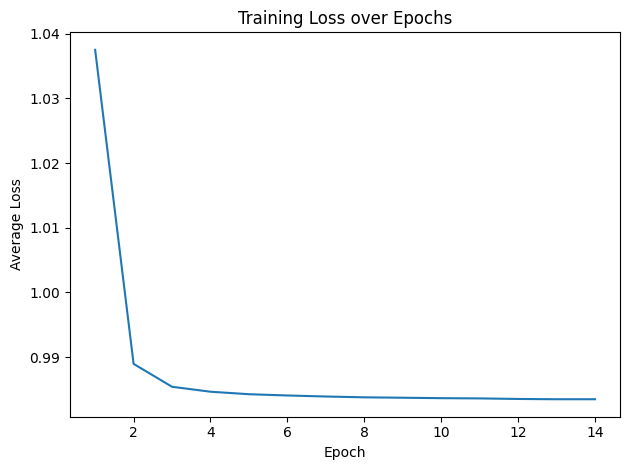

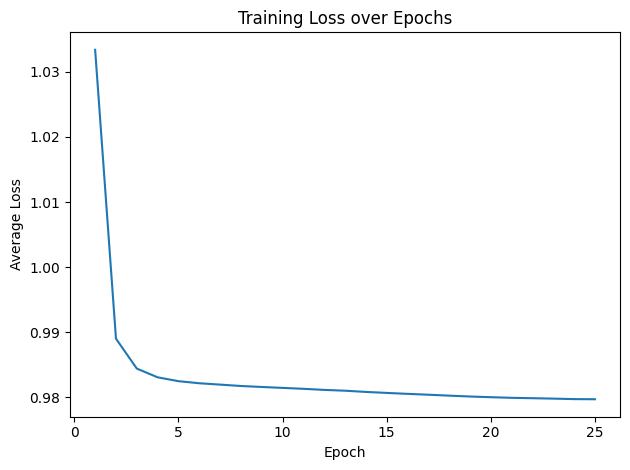

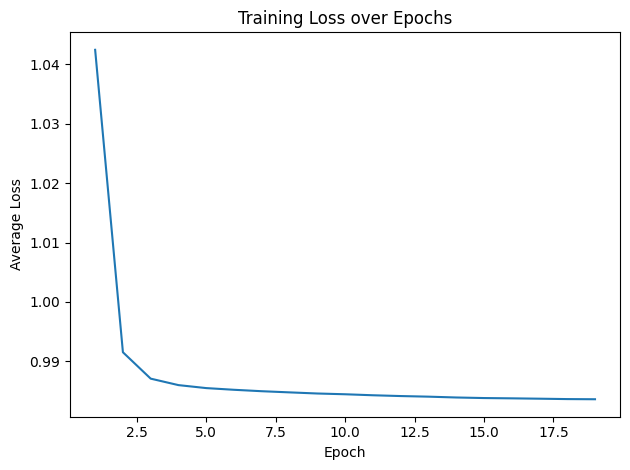

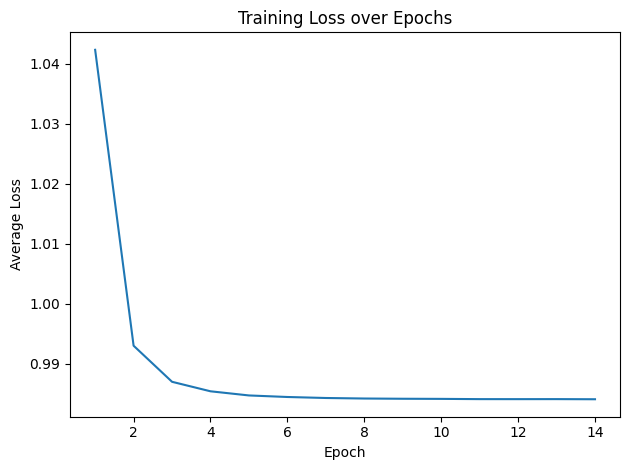

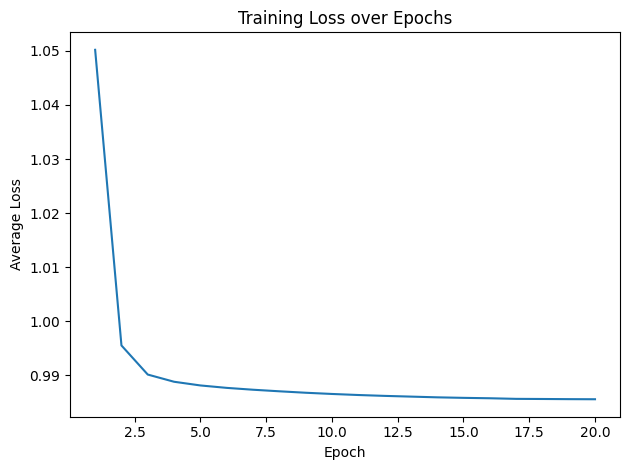

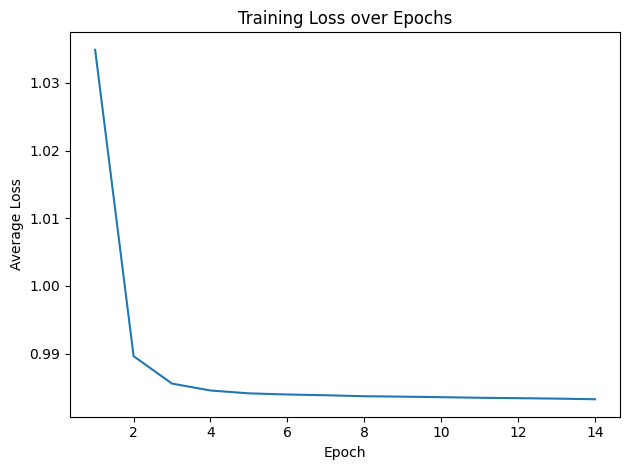

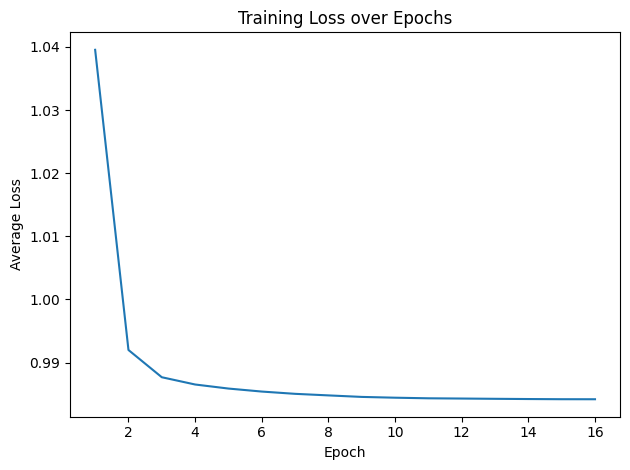

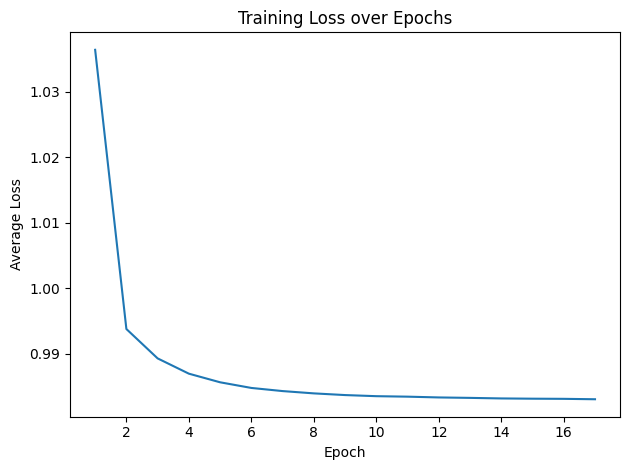

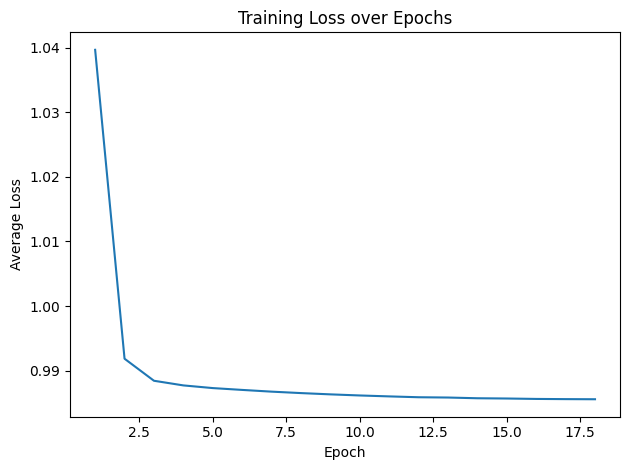

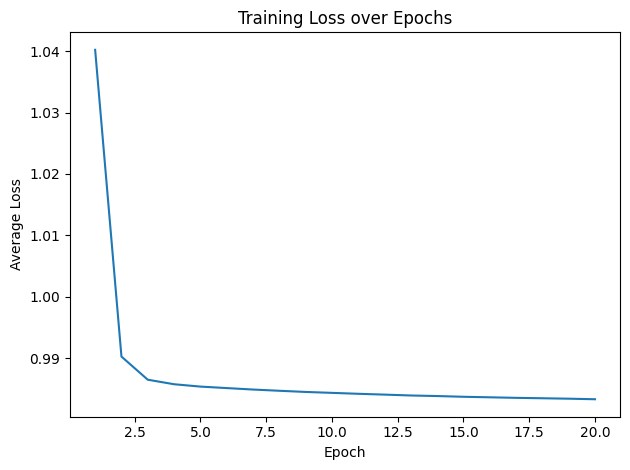

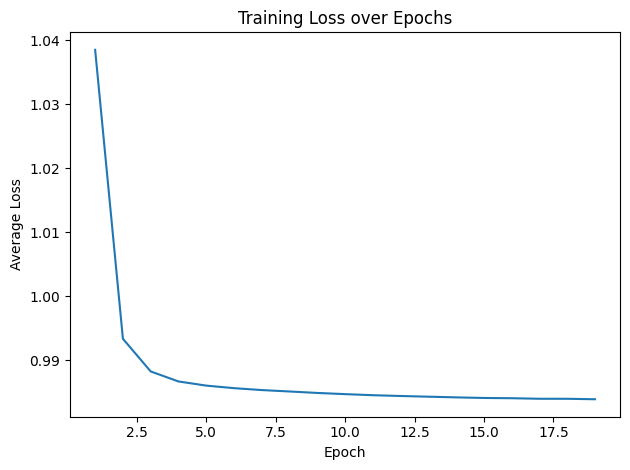

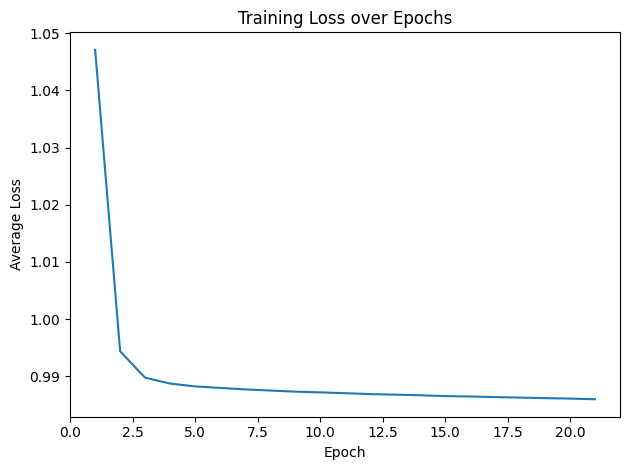

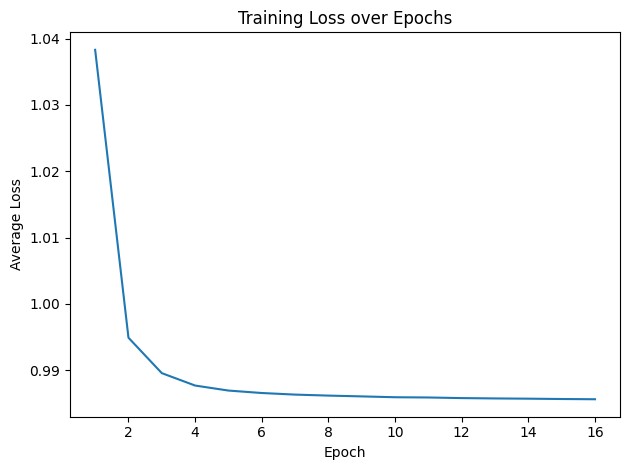

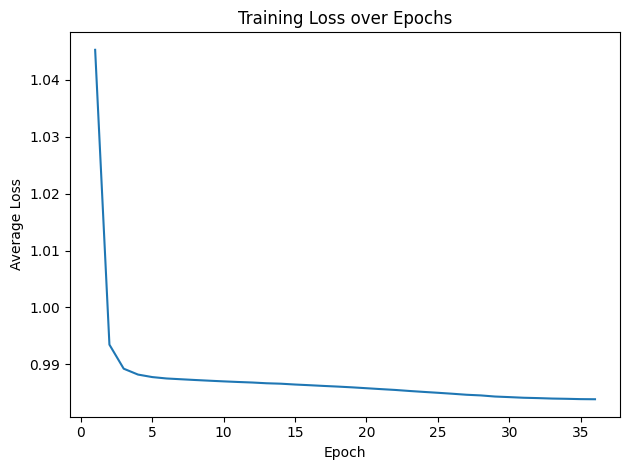

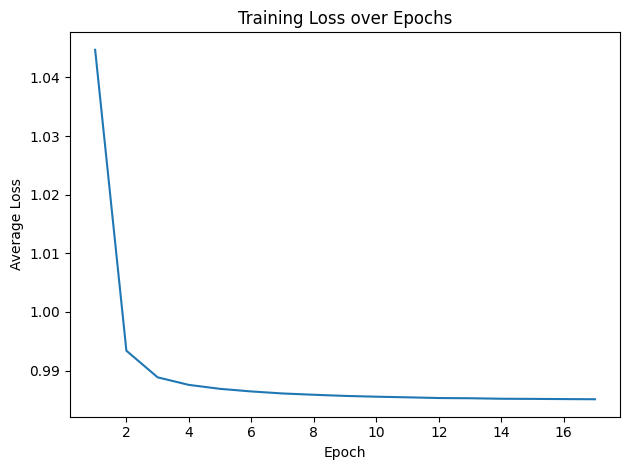

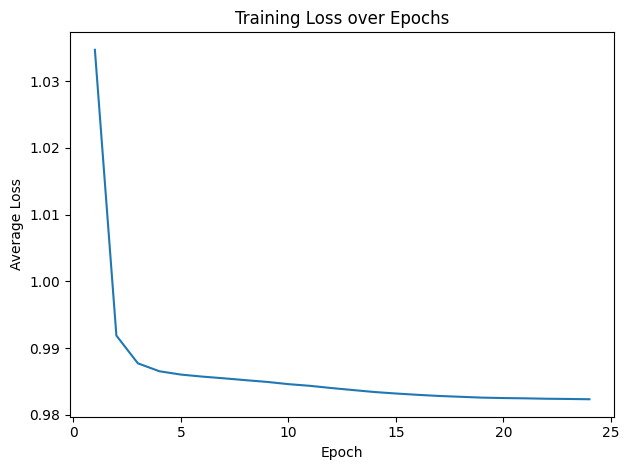

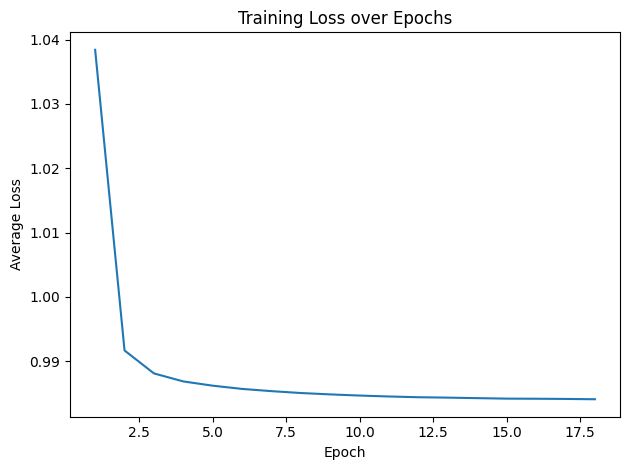

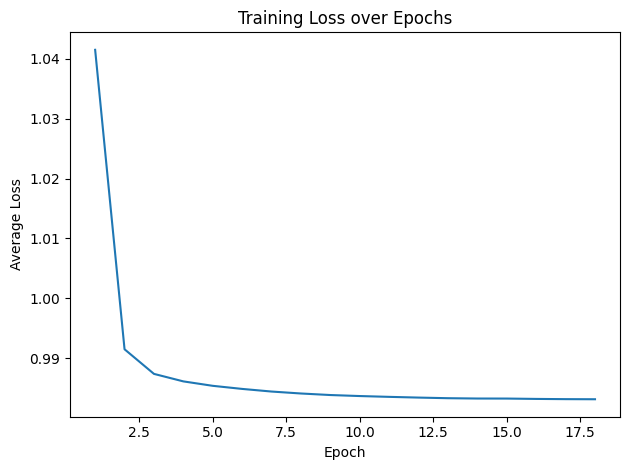

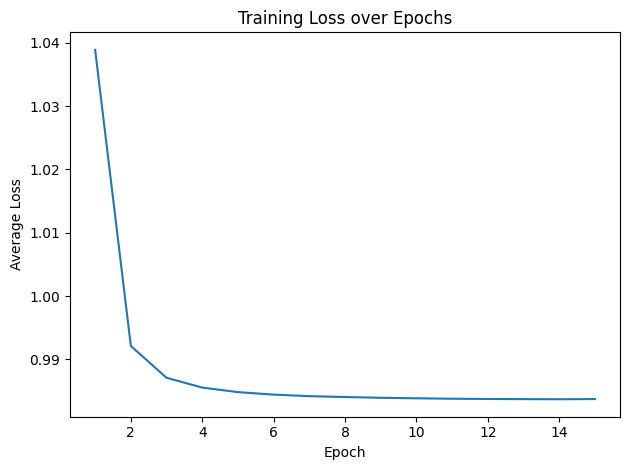

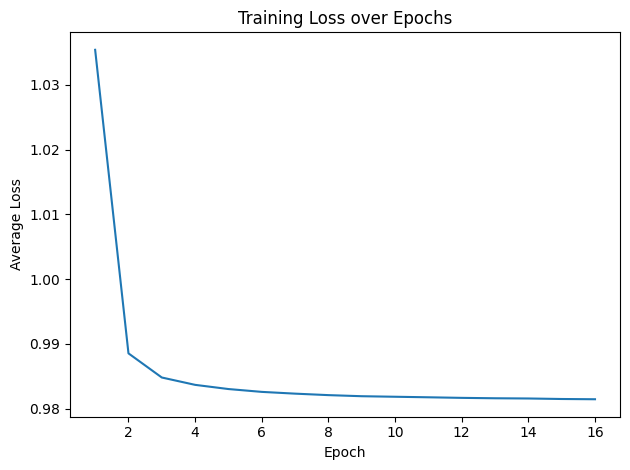

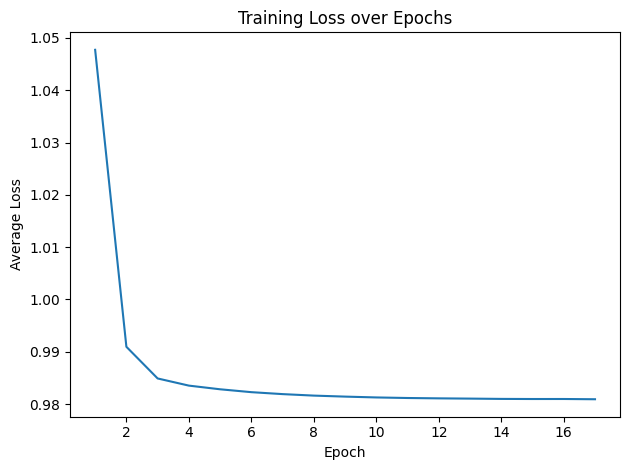

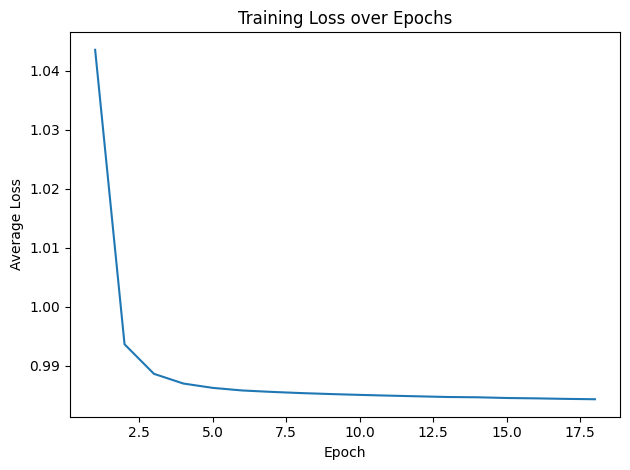

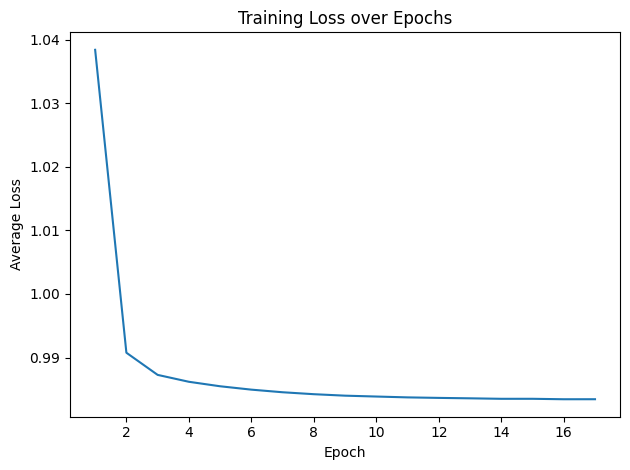

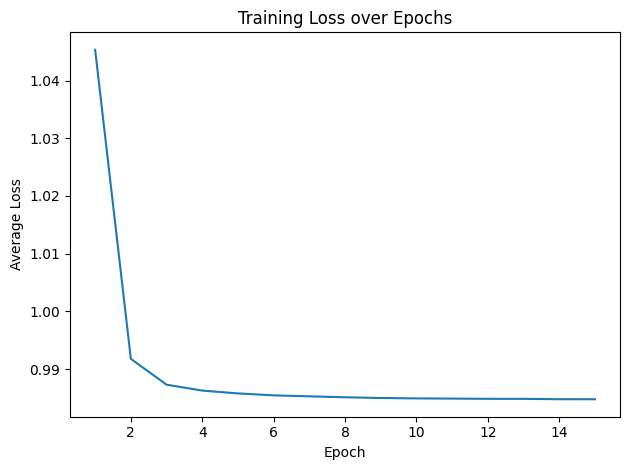

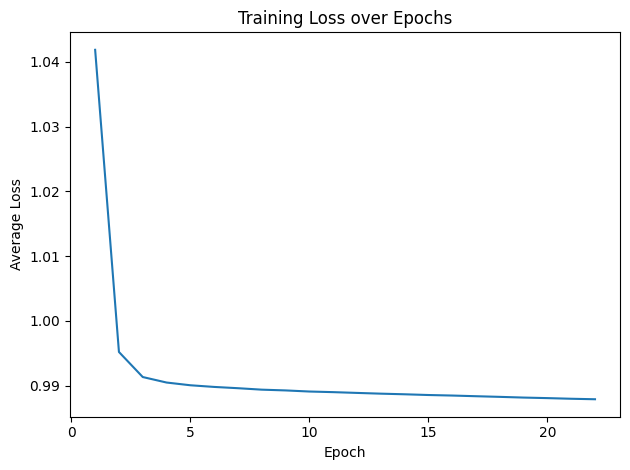

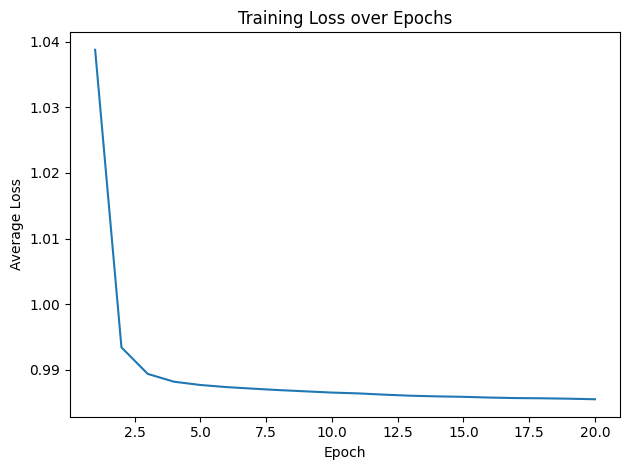

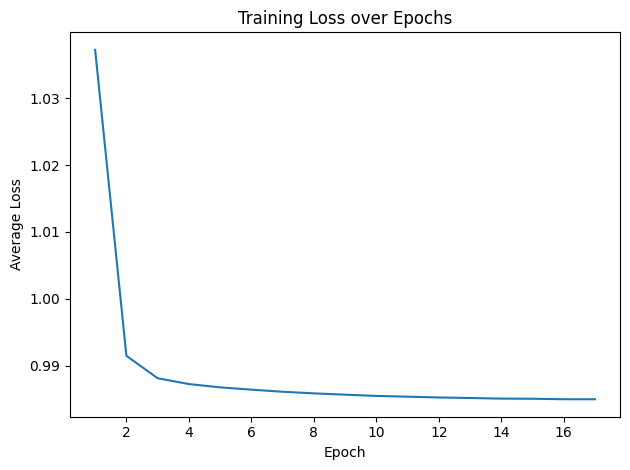

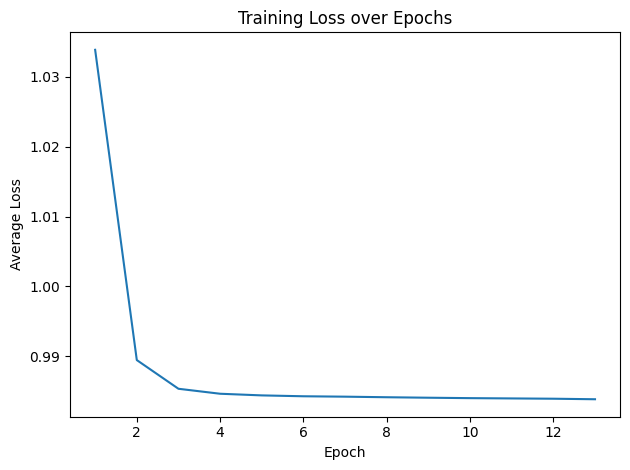

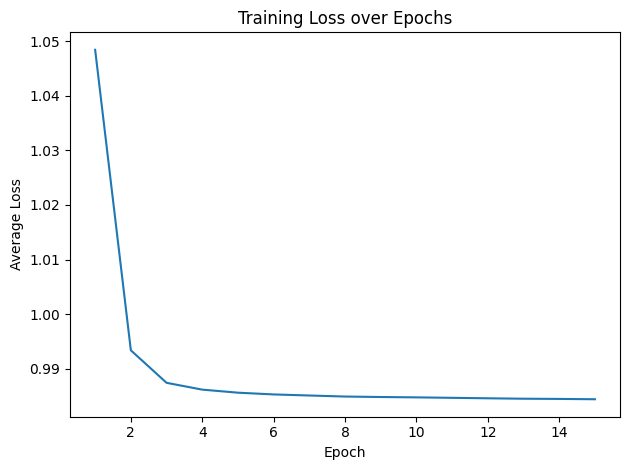

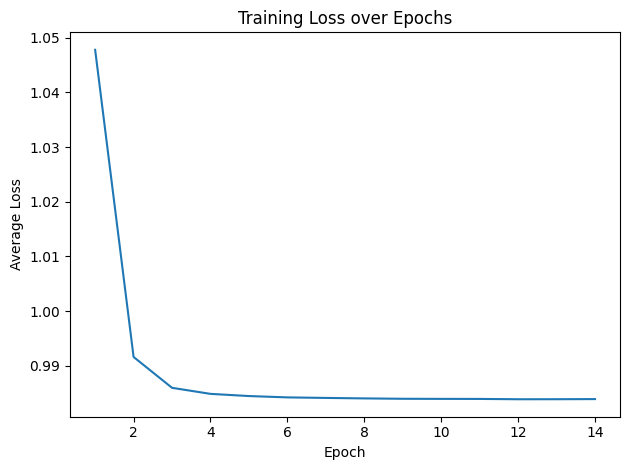

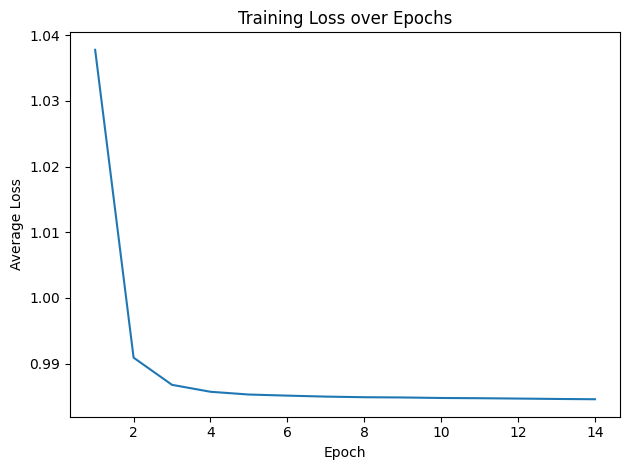

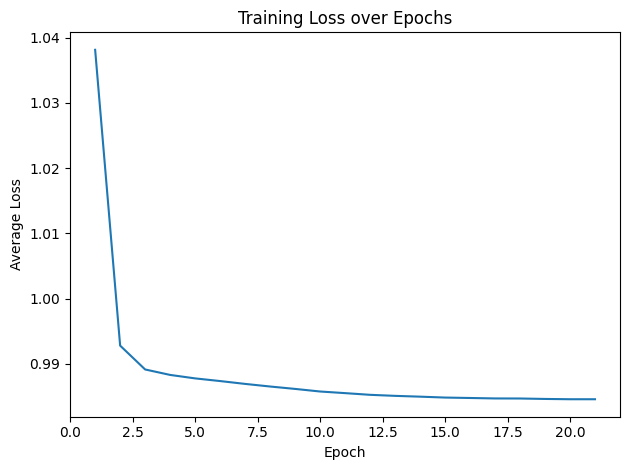

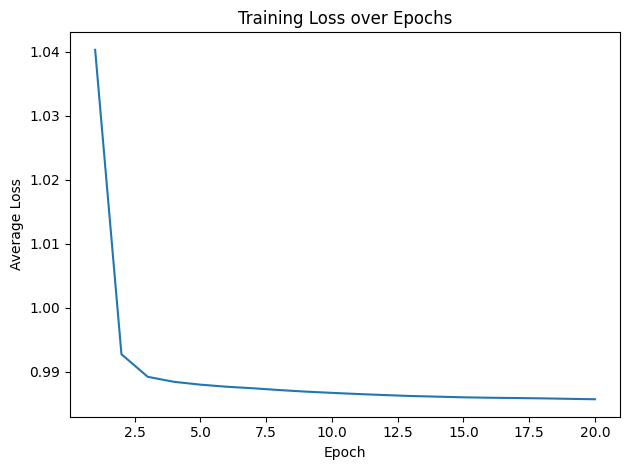

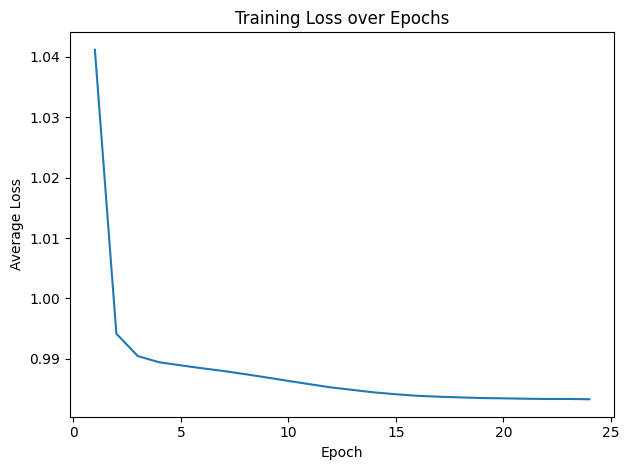

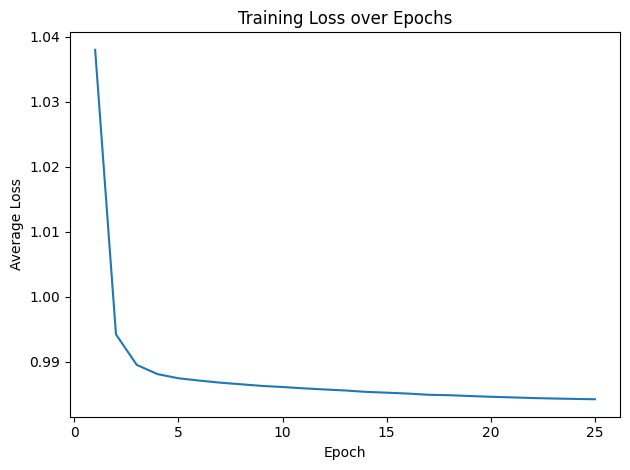

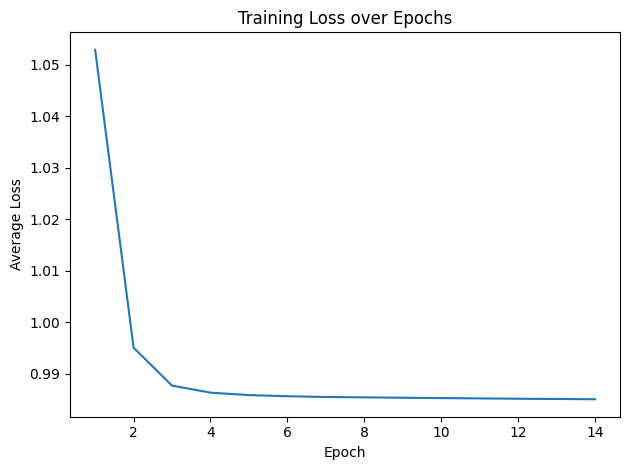

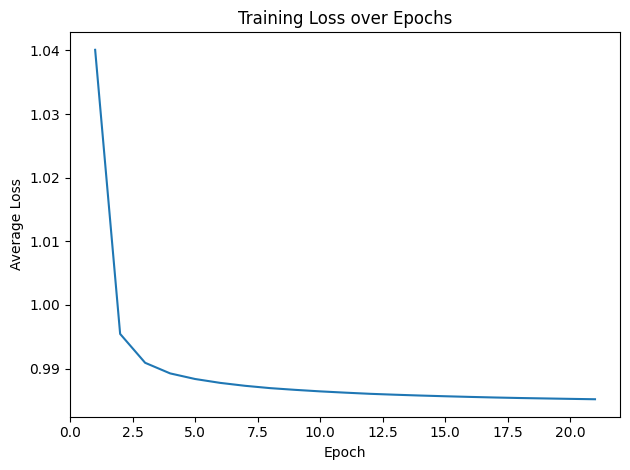

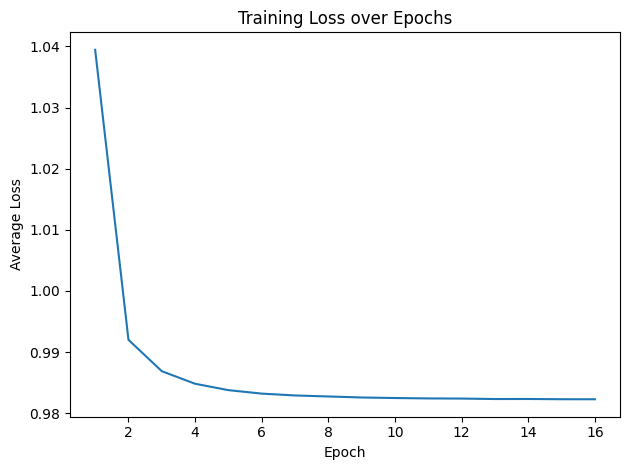

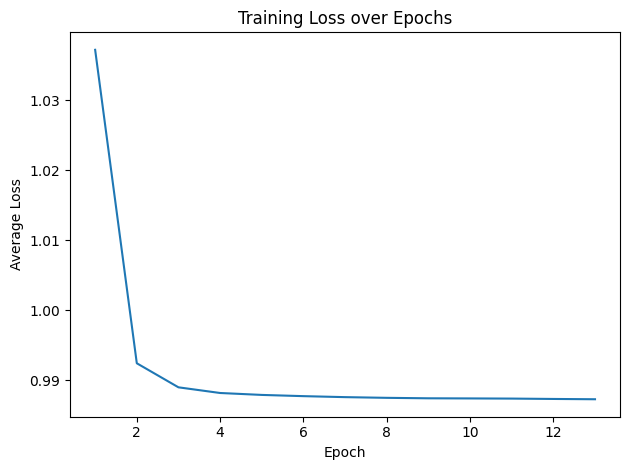

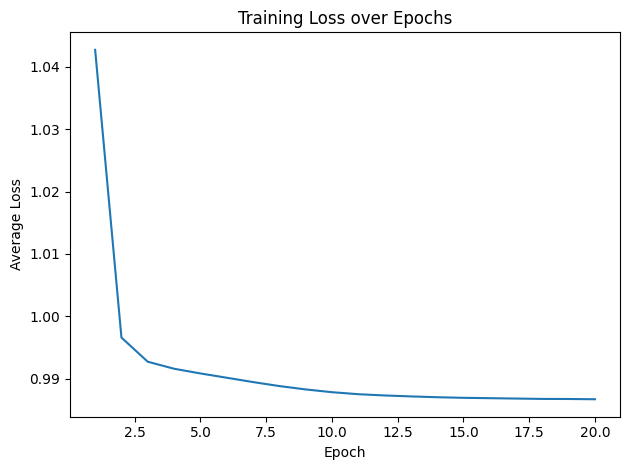

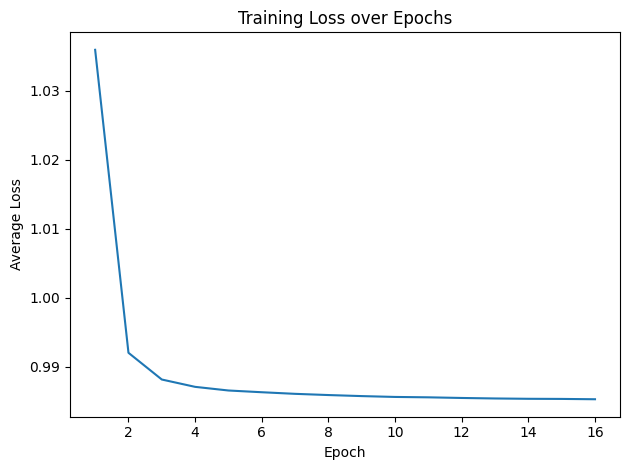

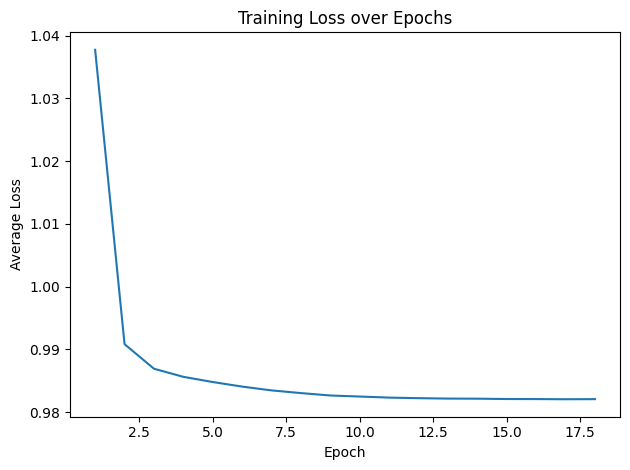

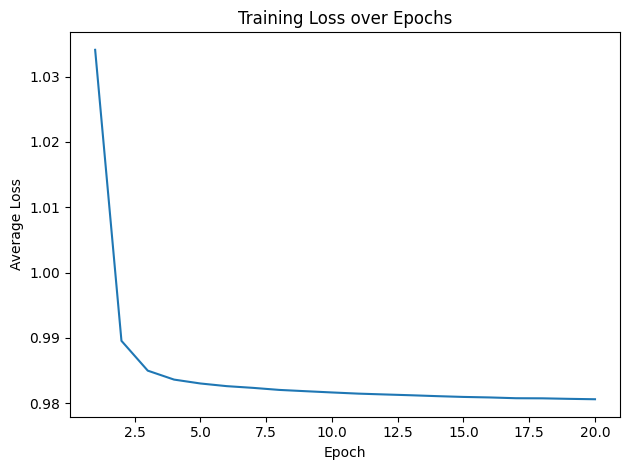

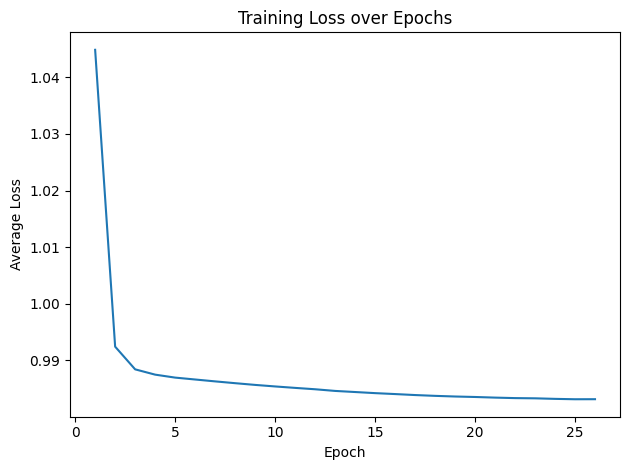

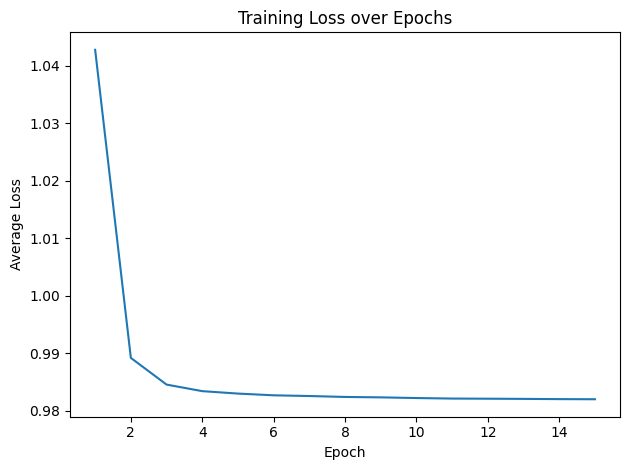

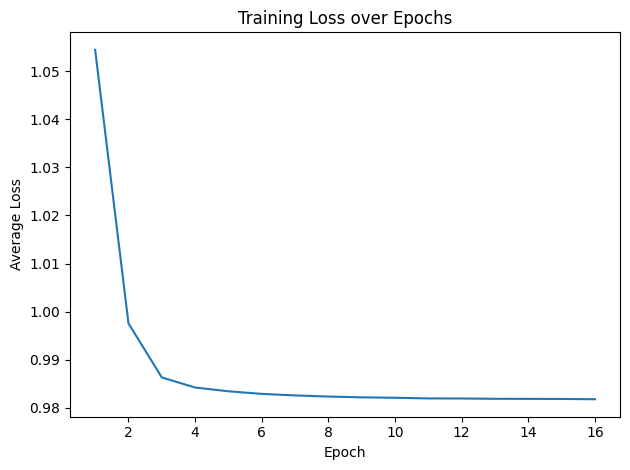

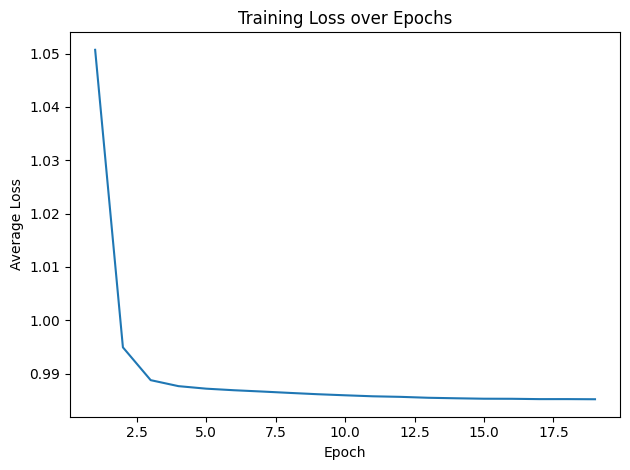

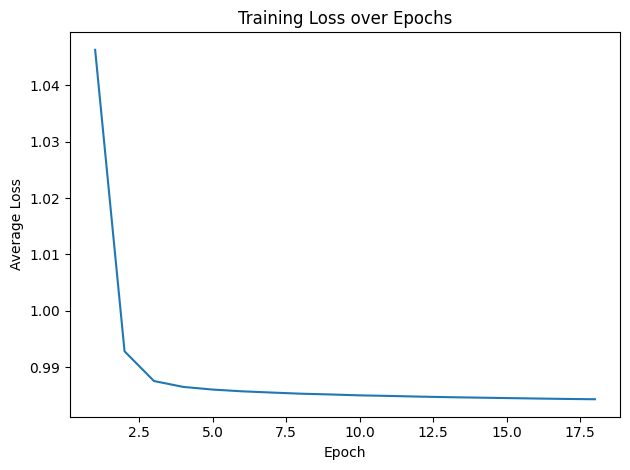

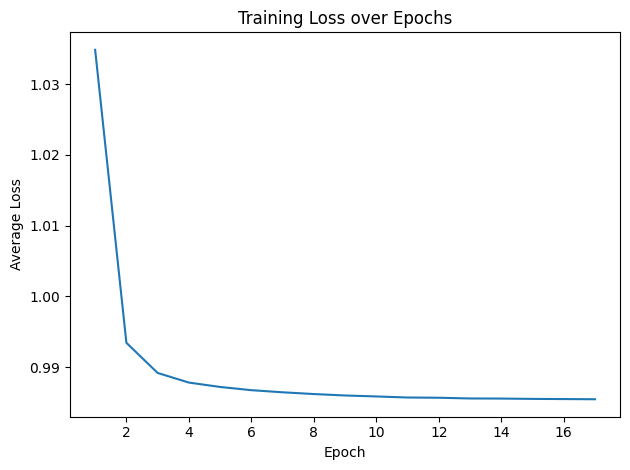

In [ ]:
trust_matrices = []

for i in tqdm(range(100)):
    sample = random.choices(comparisons, k=len(comparisons))

    T,t,model = train_trust_matrix(sample)

    trust_matrices.append([T.cpu().numpy().tolist(),
                           t.cpu().numpy().tolist()])

    with open(path + f'bootstrap/samples.json', "w") as file:
        json.dump(trust_matrices, file, indent=4)
    torch.save(model.state_dict(), path + f'bootstrap/model_{i}.pt')


=== Data size 125 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0830
Epoch  30, Loss = 1.0738
Epoch  40, Loss = 1.0637
Epoch  50, Loss = 1.0521
Epoch  60, Loss = 1.0388
Epoch  70, Loss = 1.0235
Epoch  80, Loss = 1.0063
Epoch  90, Loss = 0.9875
Epoch 100, Loss = 0.9671
Epoch 110, Loss = 0.9457
Epoch 120, Loss = 0.9232
Epoch 130, Loss = 0.9001
Epoch 140, Loss = 0.8768
Epoch 150, Loss = 0.8535
Epoch 160, Loss = 0.8304
Epoch 170, Loss = 0.8079
Epoch 180, Loss = 0.7858
Epoch 190, Loss = 0.7644
Epoch 200, Loss = 0.7438
Epoch 210, Loss = 0.7240
Epoch 220, Loss = 0.7051
Epoch 230, Loss = 0.6870
Epoch 240, Loss = 0.6699
Epoch 250, Loss = 0.6534
Epoch 260, Loss = 0.6379
Epoch 270, Loss = 0.6230
Epoch 280, Loss = 0.6088
Epoch 290, Loss = 0.5953
Epoch 300, Loss = 0.5825
Epoch 310, Loss = 0.5702
Epoch 320, Loss = 0.5584
Epoch 330, Loss = 0.5472
Epoch 340, Loss = 0.5364
Epoch 350, Loss = 0.5260
Epoch 360, Loss = 0.5161
Epoch 370, Loss = 0.5066
Epoch 380, Loss = 0.4975
Epoch 390, Loss = 0.4886
Epoch 400, Loss = 0.4801


  2%|▏         | 23/1000 [00:00<00:00, 15447.40it/s]


Epoch  10, Loss = 1.0918
Epoch  20, Loss = 1.0844
Epoch  30, Loss = 1.0760
Epoch  40, Loss = 1.0662
Epoch  50, Loss = 1.0545
Epoch  60, Loss = 1.0408
Epoch  70, Loss = 1.0253
Epoch  80, Loss = 1.0080
Epoch  90, Loss = 0.9891
Epoch 100, Loss = 0.9691
Epoch 110, Loss = 0.9482
Epoch 120, Loss = 0.9266
Epoch 130, Loss = 0.9050
Epoch 140, Loss = 0.8833
Epoch 150, Loss = 0.8620
Epoch 160, Loss = 0.8413
Epoch 170, Loss = 0.8211
Epoch 180, Loss = 0.8016
Epoch 190, Loss = 0.7828
Epoch 200, Loss = 0.7650
Epoch 210, Loss = 0.7478
Epoch 220, Loss = 0.7316
Epoch 230, Loss = 0.7161
Epoch 240, Loss = 0.7013
Epoch 250, Loss = 0.6872
Epoch 260, Loss = 0.6739
Epoch 270, Loss = 0.6611
Epoch 280, Loss = 0.6490
Epoch 290, Loss = 0.6374
Epoch 300, Loss = 0.6262
Epoch 310, Loss = 0.6156
Epoch 320, Loss = 0.6053
Epoch 330, Loss = 0.5955
Epoch 340, Loss = 0.5861
Epoch 350, Loss = 0.5770
Epoch 360, Loss = 0.5682
Epoch 370, Loss = 0.5597
Epoch 380, Loss = 0.5516
Epoch 390, Loss = 0.5437
Epoch 400, Loss = 0.5360


  5%|▌         | 1/20 [00:12<03:52, 12.21s/it]

Epoch  10, Loss = 1.0908
Epoch  20, Loss = 1.0820
Epoch  30, Loss = 1.0727
Epoch  40, Loss = 1.0625
Epoch  50, Loss = 1.0508
Epoch  60, Loss = 1.0378
Epoch  70, Loss = 1.0232
Epoch  80, Loss = 1.0072
Epoch  90, Loss = 0.9898
Epoch 100, Loss = 0.9712
Epoch 110, Loss = 0.9515
Epoch 120, Loss = 0.9309
Epoch 130, Loss = 0.9097
Epoch 140, Loss = 0.8883
Epoch 150, Loss = 0.8665
Epoch 160, Loss = 0.8450
Epoch 170, Loss = 0.8236
Epoch 180, Loss = 0.8027
Epoch 190, Loss = 0.7822
Epoch 200, Loss = 0.7623
Epoch 210, Loss = 0.7430
Epoch 220, Loss = 0.7246
Epoch 230, Loss = 0.7068
Epoch 240, Loss = 0.6898
Epoch 250, Loss = 0.6737
Epoch 260, Loss = 0.6584
Epoch 270, Loss = 0.6438
Epoch 280, Loss = 0.6300
Epoch 290, Loss = 0.6170
Epoch 300, Loss = 0.6045
Epoch 310, Loss = 0.5928
Epoch 320, Loss = 0.5816
Epoch 330, Loss = 0.5710
Epoch 340, Loss = 0.5609
Epoch 350, Loss = 0.5512
Epoch 360, Loss = 0.5420
Epoch 370, Loss = 0.5331
Epoch 380, Loss = 0.5247
Epoch 390, Loss = 0.5165
Epoch 400, Loss = 0.5087


  5%|▍         | 48/1000 [00:00<00:00, 22577.84it/s]

Epoch  10, Loss = 1.0903
Epoch  20, Loss = 1.0817
Epoch  30, Loss = 1.0724


Epoch  40, Loss = 1.0620
Epoch  50, Loss = 1.0502
Epoch  60, Loss = 1.0368
Epoch  70, Loss = 1.0217
Epoch  80, Loss = 1.0049
Epoch  90, Loss = 0.9865
Epoch 100, Loss = 0.9668
Epoch 110, Loss = 0.9459
Epoch 120, Loss = 0.9240
Epoch 130, Loss = 0.9015
Epoch 140, Loss = 0.8787
Epoch 150, Loss = 0.8559
Epoch 160, Loss = 0.8332
Epoch 170, Loss = 0.8110
Epoch 180, Loss = 0.7892
Epoch 190, Loss = 0.7681
Epoch 200, Loss = 0.7477
Epoch 210, Loss = 0.7280
Epoch 220, Loss = 0.7091
Epoch 230, Loss = 0.6909
Epoch 240, Loss = 0.6736
Epoch 250, Loss = 0.6569
Epoch 260, Loss = 0.6410
Epoch 270, Loss = 0.6258
Epoch 280, Loss = 0.6112
Epoch 290, Loss = 0.5973
Epoch 300, Loss = 0.5840
Epoch 310, Loss = 0.5712
Epoch 320, Loss = 0.5590
Epoch 330, Loss = 0.5473
Epoch 340, Loss = 0.5361
Epoch 350, Loss = 0.5253
Epoch 360, Loss = 0.5150
Epoch 370, Loss = 0.5050
Epoch 380, Loss = 0.4954
Epoch 390, Loss = 0.4862
Epoch 400, Loss = 0.4772
Epoch 410, Loss = 0.4686
Epoch 420, Loss = 0.4603
Epoch 430, Loss = 0.4522


 10%|█         | 2/20 [00:23<03:33, 11.88s/it]

Epoch  10, Loss = 1.0893
Epoch  20, Loss = 1.0802
Epoch  30, Loss = 1.0702
Epoch  40, Loss = 1.0590
Epoch  50, Loss = 1.0462
Epoch  60, Loss = 1.0316
Epoch  70, Loss = 1.0152
Epoch  80, Loss = 0.9970
Epoch  90, Loss = 0.9773
Epoch 100, Loss = 0.9563
Epoch 110, Loss = 0.9341
Epoch 120, Loss = 0.9111
Epoch 130, Loss = 0.8876
Epoch 140, Loss = 0.8636
Epoch 150, Loss = 0.8397
Epoch 160, Loss = 0.8158
Epoch 170, Loss = 0.7924
Epoch 180, Loss = 0.7694
Epoch 190, Loss = 0.7469
Epoch 200, Loss = 0.7253
Epoch 210, Loss = 0.7043
Epoch 220, Loss = 0.6843
Epoch 230, Loss = 0.6650
Epoch 240, Loss = 0.6465
Epoch 250, Loss = 0.6289
Epoch 260, Loss = 0.6121
Epoch 270, Loss = 0.5960
Epoch 280, Loss = 0.5806
Epoch 290, Loss = 0.5660
Epoch 300, Loss = 0.5519
Epoch 310, Loss = 0.5385
Epoch 320, Loss = 0.5257
Epoch 330, Loss = 0.5134
Epoch 340, Loss = 0.5016
Epoch 350, Loss = 0.4903
Epoch 360, Loss = 0.4795
Epoch 370, Loss = 0.4691
Epoch 380, Loss = 0.4592
Epoch 390, Loss = 0.4496
Epoch 400, Loss = 0.4404


  2%|▏         | 17/1000 [00:00<00:00, 9518.51it/s]

Epoch  10, Loss = 1.0917
Epoch  20, Loss = 1.0848
Epoch  30, Loss = 1.0773
Epoch  40, Loss = 1.0690
Epoch  50, Loss = 1.0596


Epoch  60, Loss = 1.0492
Epoch  70, Loss = 1.0374
Epoch  80, Loss = 1.0243
Epoch  90, Loss = 1.0100
Epoch 100, Loss = 0.9947
Epoch 110, Loss = 0.9784
Epoch 120, Loss = 0.9613
Epoch 130, Loss = 0.9435
Epoch 140, Loss = 0.9254
Epoch 150, Loss = 0.9070
Epoch 160, Loss = 0.8884
Epoch 170, Loss = 0.8700
Epoch 180, Loss = 0.8518
Epoch 190, Loss = 0.8341
Epoch 200, Loss = 0.8167
Epoch 210, Loss = 0.7998
Epoch 220, Loss = 0.7835
Epoch 230, Loss = 0.7678
Epoch 240, Loss = 0.7526
Epoch 250, Loss = 0.7380
Epoch 260, Loss = 0.7240
Epoch 270, Loss = 0.7107
Epoch 280, Loss = 0.6978
Epoch 290, Loss = 0.6855
Epoch 300, Loss = 0.6738
Epoch 310, Loss = 0.6625
Epoch 320, Loss = 0.6517
Epoch 330, Loss = 0.6413
Epoch 340, Loss = 0.6314
Epoch 350, Loss = 0.6219
Epoch 360, Loss = 0.6127
Epoch 370, Loss = 0.6039
Epoch 380, Loss = 0.5954
Epoch 390, Loss = 0.5872
Epoch 400, Loss = 0.5793
Epoch 410, Loss = 0.5717
Epoch 420, Loss = 0.5644
Epoch 430, Loss = 0.5572
Epoch 440, Loss = 0.5503
Epoch 450, Loss = 0.5436


 15%|█▌        | 3/20 [00:36<03:25, 12.06s/it]

Epoch  10, Loss = 1.0922
Epoch  20, Loss = 1.0848
Epoch  30, Loss = 1.0765
Epoch  40, Loss = 1.0670
Epoch  50, Loss = 1.0558
Epoch  60, Loss = 1.0426
Epoch  70, Loss = 1.0271
Epoch  80, Loss = 1.0098
Epoch  90, Loss = 0.9906
Epoch 100, Loss = 0.9699
Epoch 110, Loss = 0.9479
Epoch 120, Loss = 0.9251
Epoch 130, Loss = 0.9018
Epoch 140, Loss = 0.8783
Epoch 150, Loss = 0.8549
Epoch 160, Loss = 0.8315
Epoch 170, Loss = 0.8089
Epoch 180, Loss = 0.7869
Epoch 190, Loss = 0.7657
Epoch 200, Loss = 0.7455
Epoch 210, Loss = 0.7261
Epoch 220, Loss = 0.7076
Epoch 230, Loss = 0.6901
Epoch 240, Loss = 0.6736
Epoch 250, Loss = 0.6580
Epoch 260, Loss = 0.6432
Epoch 270, Loss = 0.6293
Epoch 280, Loss = 0.6161
Epoch 290, Loss = 0.6037
Epoch 300, Loss = 0.5919
Epoch 310, Loss = 0.5808
Epoch 320, Loss = 0.5704
Epoch 330, Loss = 0.5604
Epoch 340, Loss = 0.5510
Epoch 350, Loss = 0.5421
Epoch 360, Loss = 0.5335
Epoch 370, Loss = 0.5254
Epoch 380, Loss = 0.5176
Epoch 390, Loss = 0.5102
Epoch 400, Loss = 0.5031


  4%|▎         | 35/1000 [00:00<00:00, 19989.19it/s]

Epoch  10, Loss = 1.0887
Epoch  20, Loss = 1.0794
Epoch  30, Loss = 1.0691
Epoch  40, Loss = 1.0574


Epoch  50, Loss = 1.0443
Epoch  60, Loss = 1.0295
Epoch  70, Loss = 1.0132
Epoch  80, Loss = 0.9953
Epoch  90, Loss = 0.9762
Epoch 100, Loss = 0.9562
Epoch 110, Loss = 0.9354
Epoch 120, Loss = 0.9142
Epoch 130, Loss = 0.8927
Epoch 140, Loss = 0.8713
Epoch 150, Loss = 0.8500
Epoch 160, Loss = 0.8291
Epoch 170, Loss = 0.8086
Epoch 180, Loss = 0.7889
Epoch 190, Loss = 0.7697
Epoch 200, Loss = 0.7513
Epoch 210, Loss = 0.7336
Epoch 220, Loss = 0.7167
Epoch 230, Loss = 0.7006
Epoch 240, Loss = 0.6852
Epoch 250, Loss = 0.6705
Epoch 260, Loss = 0.6564
Epoch 270, Loss = 0.6430
Epoch 280, Loss = 0.6302
Epoch 290, Loss = 0.6180
Epoch 300, Loss = 0.6063
Epoch 310, Loss = 0.5951
Epoch 320, Loss = 0.5844
Epoch 330, Loss = 0.5741
Epoch 340, Loss = 0.5642
Epoch 350, Loss = 0.5548
Epoch 360, Loss = 0.5456
Epoch 370, Loss = 0.5369
Epoch 380, Loss = 0.5285
Epoch 390, Loss = 0.5203
Epoch 400, Loss = 0.5124
Epoch 410, Loss = 0.5048
Epoch 420, Loss = 0.4974
Epoch 430, Loss = 0.4903
Epoch 440, Loss = 0.4834


 20%|██        | 4/20 [00:48<03:13, 12.09s/it]

Epoch  10, Loss = 1.0897
Epoch  20, Loss = 1.0806
Epoch  30, Loss = 1.0704
Epoch  40, Loss = 1.0587
Epoch  50, Loss = 1.0450
Epoch  60, Loss = 1.0292
Epoch  70, Loss = 1.0111
Epoch  80, Loss = 0.9910
Epoch  90, Loss = 0.9692
Epoch 100, Loss = 0.9458
Epoch 110, Loss = 0.9212
Epoch 120, Loss = 0.8961
Epoch 130, Loss = 0.8706
Epoch 140, Loss = 0.8449
Epoch 150, Loss = 0.8195
Epoch 160, Loss = 0.7946
Epoch 170, Loss = 0.7704
Epoch 180, Loss = 0.7469
Epoch 190, Loss = 0.7243
Epoch 200, Loss = 0.7028
Epoch 210, Loss = 0.6823
Epoch 220, Loss = 0.6627
Epoch 230, Loss = 0.6441
Epoch 240, Loss = 0.6263
Epoch 250, Loss = 0.6094
Epoch 260, Loss = 0.5935
Epoch 270, Loss = 0.5782
Epoch 280, Loss = 0.5636
Epoch 290, Loss = 0.5498
Epoch 300, Loss = 0.5366
Epoch 310, Loss = 0.5240
Epoch 320, Loss = 0.5121
Epoch 330, Loss = 0.5006
Epoch 340, Loss = 0.4897
Epoch 350, Loss = 0.4792
Epoch 360, Loss = 0.4691
Epoch 370, Loss = 0.4595
Epoch 380, Loss = 0.4502
Epoch 390, Loss = 0.4413
Epoch 400, Loss = 0.4327


  3%|▎         | 29/1000 [00:00<00:00, 19362.43it/s]

Epoch  10, Loss = 1.0926
Epoch  20, Loss = 1.0862
Epoch  30, Loss = 1.0789


Epoch  40, Loss = 1.0703
Epoch  50, Loss = 1.0598
Epoch  60, Loss = 1.0476
Epoch  70, Loss = 1.0335
Epoch  80, Loss = 1.0176
Epoch  90, Loss = 1.0001
Epoch 100, Loss = 0.9813
Epoch 110, Loss = 0.9617
Epoch 120, Loss = 0.9412
Epoch 130, Loss = 0.9205
Epoch 140, Loss = 0.8995
Epoch 150, Loss = 0.8786
Epoch 160, Loss = 0.8580
Epoch 170, Loss = 0.8379
Epoch 180, Loss = 0.8185
Epoch 190, Loss = 0.7997
Epoch 200, Loss = 0.7816
Epoch 210, Loss = 0.7644
Epoch 220, Loss = 0.7479
Epoch 230, Loss = 0.7321
Epoch 240, Loss = 0.7172
Epoch 250, Loss = 0.7030
Epoch 260, Loss = 0.6895
Epoch 270, Loss = 0.6767
Epoch 280, Loss = 0.6646
Epoch 290, Loss = 0.6530
Epoch 300, Loss = 0.6421
Epoch 310, Loss = 0.6317
Epoch 320, Loss = 0.6218
Epoch 330, Loss = 0.6123
Epoch 340, Loss = 0.6032
Epoch 350, Loss = 0.5945
Epoch 360, Loss = 0.5862
Epoch 370, Loss = 0.5782
Epoch 380, Loss = 0.5705
Epoch 390, Loss = 0.5631
Epoch 400, Loss = 0.5559
Epoch 410, Loss = 0.5491
Epoch 420, Loss = 0.5424
Epoch 430, Loss = 0.5359


 25%|██▌       | 5/20 [01:00<03:01, 12.11s/it]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0836
Epoch  30, Loss = 1.0751
Epoch  40, Loss = 1.0657
Epoch  50, Loss = 1.0549
Epoch  60, Loss = 1.0425
Epoch  70, Loss = 1.0285
Epoch  80, Loss = 1.0125
Epoch  90, Loss = 0.9949
Epoch 100, Loss = 0.9758
Epoch 110, Loss = 0.9553
Epoch 120, Loss = 0.9340
Epoch 130, Loss = 0.9119
Epoch 140, Loss = 0.8894
Epoch 150, Loss = 0.8668
Epoch 160, Loss = 0.8442
Epoch 170, Loss = 0.8220
Epoch 180, Loss = 0.8002
Epoch 190, Loss = 0.7791
Epoch 200, Loss = 0.7585
Epoch 210, Loss = 0.7388
Epoch 220, Loss = 0.7198
Epoch 230, Loss = 0.7015
Epoch 240, Loss = 0.6841
Epoch 250, Loss = 0.6674
Epoch 260, Loss = 0.6516
Epoch 270, Loss = 0.6363
Epoch 280, Loss = 0.6218
Epoch 290, Loss = 0.6080
Epoch 300, Loss = 0.5949
Epoch 310, Loss = 0.5822
Epoch 320, Loss = 0.5701
Epoch 330, Loss = 0.5585
Epoch 340, Loss = 0.5474
Epoch 350, Loss = 0.5368
Epoch 360, Loss = 0.5266
Epoch 370, Loss = 0.5168
Epoch 380, Loss = 0.5074
Epoch 390, Loss = 0.4983
Epoch 400, Loss = 0.4895


  5%|▍         | 46/1000 [00:00<00:00, 23699.54it/s]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0845
Epoch  30, Loss = 1.0769


Epoch  40, Loss = 1.0685
Epoch  50, Loss = 1.0589
Epoch  60, Loss = 1.0479
Epoch  70, Loss = 1.0352
Epoch  80, Loss = 1.0209
Epoch  90, Loss = 1.0049
Epoch 100, Loss = 0.9873
Epoch 110, Loss = 0.9684
Epoch 120, Loss = 0.9482
Epoch 130, Loss = 0.9273
Epoch 140, Loss = 0.9057
Epoch 150, Loss = 0.8838
Epoch 160, Loss = 0.8621
Epoch 170, Loss = 0.8404
Epoch 180, Loss = 0.8192
Epoch 190, Loss = 0.7985
Epoch 200, Loss = 0.7785
Epoch 210, Loss = 0.7592
Epoch 220, Loss = 0.7406
Epoch 230, Loss = 0.7227
Epoch 240, Loss = 0.7057
Epoch 250, Loss = 0.6894
Epoch 260, Loss = 0.6739
Epoch 270, Loss = 0.6589
Epoch 280, Loss = 0.6447
Epoch 290, Loss = 0.6310
Epoch 300, Loss = 0.6180
Epoch 310, Loss = 0.6056
Epoch 320, Loss = 0.5937
Epoch 330, Loss = 0.5823
Epoch 340, Loss = 0.5713
Epoch 350, Loss = 0.5608
Epoch 360, Loss = 0.5506
Epoch 370, Loss = 0.5409
Epoch 380, Loss = 0.5315
Epoch 390, Loss = 0.5225
Epoch 400, Loss = 0.5138
Epoch 410, Loss = 0.5053
Epoch 420, Loss = 0.4972
Epoch 430, Loss = 0.4893


 30%|███       | 6/20 [01:12<02:50, 12.20s/it]

Epoch  10, Loss = 1.0926
Epoch  20, Loss = 1.0858
Epoch  30, Loss = 1.0785
Epoch  40, Loss = 1.0704
Epoch  50, Loss = 1.0612
Epoch  60, Loss = 1.0506
Epoch  70, Loss = 1.0385
Epoch  80, Loss = 1.0247
Epoch  90, Loss = 1.0092
Epoch 100, Loss = 0.9922
Epoch 110, Loss = 0.9741
Epoch 120, Loss = 0.9549
Epoch 130, Loss = 0.9348
Epoch 140, Loss = 0.9145
Epoch 150, Loss = 0.8939
Epoch 160, Loss = 0.8737
Epoch 170, Loss = 0.8535
Epoch 180, Loss = 0.8340
Epoch 190, Loss = 0.8150
Epoch 200, Loss = 0.7967
Epoch 210, Loss = 0.7791
Epoch 220, Loss = 0.7623
Epoch 230, Loss = 0.7464
Epoch 240, Loss = 0.7310
Epoch 250, Loss = 0.7164
Epoch 260, Loss = 0.7025
Epoch 270, Loss = 0.6892
Epoch 280, Loss = 0.6766
Epoch 290, Loss = 0.6646
Epoch 300, Loss = 0.6531
Epoch 310, Loss = 0.6422
Epoch 320, Loss = 0.6317
Epoch 330, Loss = 0.6217
Epoch 340, Loss = 0.6121
Epoch 350, Loss = 0.6029
Epoch 360, Loss = 0.5940
Epoch 370, Loss = 0.5855
Epoch 380, Loss = 0.5773
Epoch 390, Loss = 0.5694
Epoch 400, Loss = 0.5618


  2%|▏         | 15/1000 [00:00<00:00, 9836.55it/s]

Epoch  10, Loss = 1.0899
Epoch  20, Loss = 1.0813
Epoch  30, Loss = 1.0722
Epoch  40, Loss = 1.0623


Epoch  50, Loss = 1.0511
Epoch  60, Loss = 1.0388
Epoch  70, Loss = 1.0250
Epoch  80, Loss = 1.0099
Epoch  90, Loss = 0.9934
Epoch 100, Loss = 0.9758
Epoch 110, Loss = 0.9573
Epoch 120, Loss = 0.9379
Epoch 130, Loss = 0.9178
Epoch 140, Loss = 0.8974
Epoch 150, Loss = 0.8766
Epoch 160, Loss = 0.8557
Epoch 170, Loss = 0.8349
Epoch 180, Loss = 0.8145
Epoch 190, Loss = 0.7944
Epoch 200, Loss = 0.7747
Epoch 210, Loss = 0.7555
Epoch 220, Loss = 0.7370
Epoch 230, Loss = 0.7192
Epoch 240, Loss = 0.7020
Epoch 250, Loss = 0.6855
Epoch 260, Loss = 0.6696
Epoch 270, Loss = 0.6545
Epoch 280, Loss = 0.6399
Epoch 290, Loss = 0.6260
Epoch 300, Loss = 0.6127
Epoch 310, Loss = 0.5999
Epoch 320, Loss = 0.5876
Epoch 330, Loss = 0.5759
Epoch 340, Loss = 0.5646
Epoch 350, Loss = 0.5538
Epoch 360, Loss = 0.5434
Epoch 370, Loss = 0.5333
Epoch 380, Loss = 0.5236
Epoch 390, Loss = 0.5143
Epoch 400, Loss = 0.5053
Epoch 410, Loss = 0.4966
Epoch 420, Loss = 0.4881
Epoch 430, Loss = 0.4799
Epoch 440, Loss = 0.4719


 35%|███▌      | 7/20 [01:26<02:42, 12.54s/it]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0839
Epoch  30, Loss = 1.0758
Epoch  40, Loss = 1.0668
Epoch  50, Loss = 1.0567
Epoch  60, Loss = 1.0452
Epoch  70, Loss = 1.0323
Epoch  80, Loss = 1.0180
Epoch  90, Loss = 1.0023
Epoch 100, Loss = 0.9854
Epoch 110, Loss = 0.9673
Epoch 120, Loss = 0.9482
Epoch 130, Loss = 0.9285
Epoch 140, Loss = 0.9083
Epoch 150, Loss = 0.8878
Epoch 160, Loss = 0.8673
Epoch 170, Loss = 0.8469
Epoch 180, Loss = 0.8268
Epoch 190, Loss = 0.8071
Epoch 200, Loss = 0.7879
Epoch 210, Loss = 0.7692
Epoch 220, Loss = 0.7512
Epoch 230, Loss = 0.7338
Epoch 240, Loss = 0.7170
Epoch 250, Loss = 0.7010
Epoch 260, Loss = 0.6855
Epoch 270, Loss = 0.6706
Epoch 280, Loss = 0.6564
Epoch 290, Loss = 0.6427
Epoch 300, Loss = 0.6295
Epoch 310, Loss = 0.6169
Epoch 320, Loss = 0.6048
Epoch 330, Loss = 0.5931
Epoch 340, Loss = 0.5818
Epoch 350, Loss = 0.5710
Epoch 360, Loss = 0.5606
Epoch 370, Loss = 0.5505
Epoch 380, Loss = 0.5407
Epoch 390, Loss = 0.5313
Epoch 400, Loss = 0.5222


  2%|▏         | 16/1000 [00:00<00:00, 9621.34it/s]

Epoch  10, Loss = 1.0942
Epoch  20, Loss = 1.0882
Epoch  30, Loss = 1.0817
Epoch  40, Loss = 1.0744
Epoch  50, Loss = 1.0659


Epoch  60, Loss = 1.0560
Epoch  70, Loss = 1.0445
Epoch  80, Loss = 1.0313
Epoch  90, Loss = 1.0163
Epoch 100, Loss = 0.9998
Epoch 110, Loss = 0.9821
Epoch 120, Loss = 0.9634
Epoch 130, Loss = 0.9440
Epoch 140, Loss = 0.9240
Epoch 150, Loss = 0.9040
Epoch 160, Loss = 0.8841
Epoch 170, Loss = 0.8643
Epoch 180, Loss = 0.8452
Epoch 190, Loss = 0.8266
Epoch 200, Loss = 0.8087
Epoch 210, Loss = 0.7917
Epoch 220, Loss = 0.7753
Epoch 230, Loss = 0.7599
Epoch 240, Loss = 0.7453
Epoch 250, Loss = 0.7314
Epoch 260, Loss = 0.7183
Epoch 270, Loss = 0.7060
Epoch 280, Loss = 0.6943
Epoch 290, Loss = 0.6833
Epoch 300, Loss = 0.6728
Epoch 310, Loss = 0.6629
Epoch 320, Loss = 0.6535
Epoch 330, Loss = 0.6446
Epoch 340, Loss = 0.6361
Epoch 350, Loss = 0.6280
Epoch 360, Loss = 0.6203
Epoch 370, Loss = 0.6129
Epoch 380, Loss = 0.6059
Epoch 390, Loss = 0.5991
Epoch 400, Loss = 0.5927
Epoch 410, Loss = 0.5864
Epoch 420, Loss = 0.5803
Epoch 430, Loss = 0.5745
Epoch 440, Loss = 0.5689
Epoch 450, Loss = 0.5635


 40%|████      | 8/20 [01:39<02:35, 12.98s/it]

Epoch  10, Loss = 1.0925
Epoch  20, Loss = 1.0853
Epoch  30, Loss = 1.0776
Epoch  40, Loss = 1.0691
Epoch  50, Loss = 1.0594
Epoch  60, Loss = 1.0483
Epoch  70, Loss = 1.0357
Epoch  80, Loss = 1.0215
Epoch  90, Loss = 1.0058
Epoch 100, Loss = 0.9888
Epoch 110, Loss = 0.9706
Epoch 120, Loss = 0.9514
Epoch 130, Loss = 0.9315
Epoch 140, Loss = 0.9111
Epoch 150, Loss = 0.8905
Epoch 160, Loss = 0.8698
Epoch 170, Loss = 0.8492
Epoch 180, Loss = 0.8289
Epoch 190, Loss = 0.8091
Epoch 200, Loss = 0.7898
Epoch 210, Loss = 0.7712
Epoch 220, Loss = 0.7531
Epoch 230, Loss = 0.7357
Epoch 240, Loss = 0.7190
Epoch 250, Loss = 0.7030
Epoch 260, Loss = 0.6876
Epoch 270, Loss = 0.6729
Epoch 280, Loss = 0.6588
Epoch 290, Loss = 0.6451
Epoch 300, Loss = 0.6322
Epoch 310, Loss = 0.6197
Epoch 320, Loss = 0.6078
Epoch 330, Loss = 0.5963
Epoch 340, Loss = 0.5852
Epoch 350, Loss = 0.5746
Epoch 360, Loss = 0.5644
Epoch 370, Loss = 0.5545
Epoch 380, Loss = 0.5450
Epoch 390, Loss = 0.5358
Epoch 400, Loss = 0.5269


  1%|          | 12/1000 [00:00<00:00, 9501.92it/s]

Epoch  10, Loss = 1.0934
Epoch  20, Loss = 1.0876
Epoch  30, Loss = 1.0810
Epoch  40, Loss = 1.0734


Epoch  50, Loss = 1.0644
Epoch  60, Loss = 1.0538
Epoch  70, Loss = 1.0414
Epoch  80, Loss = 1.0272
Epoch  90, Loss = 1.0114
Epoch 100, Loss = 0.9941
Epoch 110, Loss = 0.9756
Epoch 120, Loss = 0.9562
Epoch 130, Loss = 0.9361
Epoch 140, Loss = 0.9158
Epoch 150, Loss = 0.8954
Epoch 160, Loss = 0.8750
Epoch 170, Loss = 0.8551
Epoch 180, Loss = 0.8357
Epoch 190, Loss = 0.8169
Epoch 200, Loss = 0.7989
Epoch 210, Loss = 0.7815
Epoch 220, Loss = 0.7650
Epoch 230, Loss = 0.7491
Epoch 240, Loss = 0.7339
Epoch 250, Loss = 0.7194
Epoch 260, Loss = 0.7055
Epoch 270, Loss = 0.6923
Epoch 280, Loss = 0.6797
Epoch 290, Loss = 0.6675
Epoch 300, Loss = 0.6560
Epoch 310, Loss = 0.6448
Epoch 320, Loss = 0.6340
Epoch 330, Loss = 0.6237
Epoch 340, Loss = 0.6138
Epoch 350, Loss = 0.6041
Epoch 360, Loss = 0.5949
Epoch 370, Loss = 0.5859
Epoch 380, Loss = 0.5772
Epoch 390, Loss = 0.5687
Epoch 400, Loss = 0.5605
Epoch 410, Loss = 0.5526
Epoch 420, Loss = 0.5449
Epoch 430, Loss = 0.5374
Epoch 440, Loss = 0.5301


 45%|████▌     | 9/20 [01:53<02:23, 13.03s/it]

Epoch  10, Loss = 1.0909
Epoch  20, Loss = 1.0826
Epoch  30, Loss = 1.0734
Epoch  40, Loss = 1.0630
Epoch  50, Loss = 1.0511
Epoch  60, Loss = 1.0373
Epoch  70, Loss = 1.0219
Epoch  80, Loss = 1.0047
Epoch  90, Loss = 0.9857
Epoch 100, Loss = 0.9655
Epoch 110, Loss = 0.9442
Epoch 120, Loss = 0.9222
Epoch 130, Loss = 0.8997
Epoch 140, Loss = 0.8770
Epoch 150, Loss = 0.8544
Epoch 160, Loss = 0.8323
Epoch 170, Loss = 0.8106
Epoch 180, Loss = 0.7896
Epoch 190, Loss = 0.7692
Epoch 200, Loss = 0.7498
Epoch 210, Loss = 0.7311
Epoch 220, Loss = 0.7133
Epoch 230, Loss = 0.6963
Epoch 240, Loss = 0.6801
Epoch 250, Loss = 0.6647
Epoch 260, Loss = 0.6499
Epoch 270, Loss = 0.6358
Epoch 280, Loss = 0.6223
Epoch 290, Loss = 0.6095
Epoch 300, Loss = 0.5971
Epoch 310, Loss = 0.5852
Epoch 320, Loss = 0.5737
Epoch 330, Loss = 0.5628
Epoch 340, Loss = 0.5521
Epoch 350, Loss = 0.5419
Epoch 360, Loss = 0.5320
Epoch 370, Loss = 0.5224
Epoch 380, Loss = 0.5131
Epoch 390, Loss = 0.5041
Epoch 400, Loss = 0.4954


  2%|▏         | 20/1000 [00:00<00:00, 10405.12it/s]

Epoch  10, Loss = 1.0920
Epoch  20, Loss = 1.0833
Epoch  30, Loss = 1.0741


Epoch  40, Loss = 1.0641
Epoch  50, Loss = 1.0525
Epoch  60, Loss = 1.0393
Epoch  70, Loss = 1.0243
Epoch  80, Loss = 1.0075
Epoch  90, Loss = 0.9888
Epoch 100, Loss = 0.9687
Epoch 110, Loss = 0.9471
Epoch 120, Loss = 0.9247
Epoch 130, Loss = 0.9016
Epoch 140, Loss = 0.8782
Epoch 150, Loss = 0.8549
Epoch 160, Loss = 0.8317
Epoch 170, Loss = 0.8089
Epoch 180, Loss = 0.7869
Epoch 190, Loss = 0.7657
Epoch 200, Loss = 0.7453
Epoch 210, Loss = 0.7258
Epoch 220, Loss = 0.7073
Epoch 230, Loss = 0.6898
Epoch 240, Loss = 0.6730
Epoch 250, Loss = 0.6572
Epoch 260, Loss = 0.6422
Epoch 270, Loss = 0.6280
Epoch 280, Loss = 0.6145
Epoch 290, Loss = 0.6017
Epoch 300, Loss = 0.5895
Epoch 310, Loss = 0.5779
Epoch 320, Loss = 0.5668
Epoch 330, Loss = 0.5562
Epoch 340, Loss = 0.5462
Epoch 350, Loss = 0.5365
Epoch 360, Loss = 0.5272
Epoch 370, Loss = 0.5183
Epoch 380, Loss = 0.5097
Epoch 390, Loss = 0.5014
Epoch 400, Loss = 0.4934
Epoch 410, Loss = 0.4857
Epoch 420, Loss = 0.4782
Epoch 430, Loss = 0.4710


 50%|█████     | 10/20 [02:05<02:08, 12.89s/it]

Epoch  10, Loss = 1.0903
Epoch  20, Loss = 1.0814
Epoch  30, Loss = 1.0716
Epoch  40, Loss = 1.0607
Epoch  50, Loss = 1.0480
Epoch  60, Loss = 1.0333
Epoch  70, Loss = 1.0166
Epoch  80, Loss = 0.9981
Epoch  90, Loss = 0.9779
Epoch 100, Loss = 0.9564
Epoch 110, Loss = 0.9339
Epoch 120, Loss = 0.9105
Epoch 130, Loss = 0.8870
Epoch 140, Loss = 0.8637
Epoch 150, Loss = 0.8406
Epoch 160, Loss = 0.8180
Epoch 170, Loss = 0.7963
Epoch 180, Loss = 0.7753
Epoch 190, Loss = 0.7552
Epoch 200, Loss = 0.7361
Epoch 210, Loss = 0.7179
Epoch 220, Loss = 0.7007
Epoch 230, Loss = 0.6843
Epoch 240, Loss = 0.6687
Epoch 250, Loss = 0.6540
Epoch 260, Loss = 0.6400
Epoch 270, Loss = 0.6266
Epoch 280, Loss = 0.6138
Epoch 290, Loss = 0.6016
Epoch 300, Loss = 0.5900
Epoch 310, Loss = 0.5788
Epoch 320, Loss = 0.5680
Epoch 330, Loss = 0.5577
Epoch 340, Loss = 0.5477
Epoch 350, Loss = 0.5381
Epoch 360, Loss = 0.5288
Epoch 370, Loss = 0.5198
Epoch 380, Loss = 0.5111
Epoch 390, Loss = 0.5027
Epoch 400, Loss = 0.4945


/Users/jchang153/Documents/GitHub/EigenBench/BT_criteria.py:142: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


Epoch 1730, Loss = 0.1198
Epoch 1740, Loss = 0.1188
loss converged, breaking


  2%|▏         | 15/1000 [00:00<00:00, 7673.44it/s]

Epoch  10, Loss = 1.0923
Epoch  20, Loss = 1.0851
Epoch  30, Loss = 1.0773


Epoch  40, Loss = 1.0684
Epoch  50, Loss = 1.0580
Epoch  60, Loss = 1.0461
Epoch  70, Loss = 1.0324
Epoch  80, Loss = 1.0170
Epoch  90, Loss = 1.0003
Epoch 100, Loss = 0.9819
Epoch 110, Loss = 0.9627
Epoch 120, Loss = 0.9426
Epoch 130, Loss = 0.9220
Epoch 140, Loss = 0.9012
Epoch 150, Loss = 0.8801
Epoch 160, Loss = 0.8592
Epoch 170, Loss = 0.8387
Epoch 180, Loss = 0.8185
Epoch 190, Loss = 0.7990
Epoch 200, Loss = 0.7800
Epoch 210, Loss = 0.7616
Epoch 220, Loss = 0.7440
Epoch 230, Loss = 0.7271
Epoch 240, Loss = 0.7108
Epoch 250, Loss = 0.6952
Epoch 260, Loss = 0.6803
Epoch 270, Loss = 0.6660
Epoch 280, Loss = 0.6524
Epoch 290, Loss = 0.6393
Epoch 300, Loss = 0.6267
Epoch 310, Loss = 0.6147
Epoch 320, Loss = 0.6032
Epoch 330, Loss = 0.5921
Epoch 340, Loss = 0.5816
Epoch 350, Loss = 0.5713
Epoch 360, Loss = 0.5614
Epoch 370, Loss = 0.5520
Epoch 380, Loss = 0.5429
Epoch 390, Loss = 0.5341
Epoch 400, Loss = 0.5256
Epoch 410, Loss = 0.5174
Epoch 420, Loss = 0.5094
Epoch 430, Loss = 0.5017


 55%|█████▌    | 11/20 [02:17<01:54, 12.67s/it]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0843
Epoch  30, Loss = 1.0762
Epoch  40, Loss = 1.0668
Epoch  50, Loss = 1.0558
Epoch  60, Loss = 1.0431
Epoch  70, Loss = 1.0285
Epoch  80, Loss = 1.0122
Epoch  90, Loss = 0.9943
Epoch 100, Loss = 0.9752
Epoch 110, Loss = 0.9550
Epoch 120, Loss = 0.9342
Epoch 130, Loss = 0.9127
Epoch 140, Loss = 0.8911
Epoch 150, Loss = 0.8694
Epoch 160, Loss = 0.8480
Epoch 170, Loss = 0.8270
Epoch 180, Loss = 0.8064
Epoch 190, Loss = 0.7863
Epoch 200, Loss = 0.7669
Epoch 210, Loss = 0.7482
Epoch 220, Loss = 0.7302
Epoch 230, Loss = 0.7127
Epoch 240, Loss = 0.6960
Epoch 250, Loss = 0.6799
Epoch 260, Loss = 0.6644
Epoch 270, Loss = 0.6494
Epoch 280, Loss = 0.6351
Epoch 290, Loss = 0.6213
Epoch 300, Loss = 0.6079
Epoch 310, Loss = 0.5952
Epoch 320, Loss = 0.5828
Epoch 330, Loss = 0.5710
Epoch 340, Loss = 0.5595
Epoch 350, Loss = 0.5485
Epoch 360, Loss = 0.5379
Epoch 370, Loss = 0.5277
Epoch 380, Loss = 0.5178
Epoch 390, Loss = 0.5082
Epoch 400, Loss = 0.4990


  4%|▍         | 42/1000 [00:00<00:00, 19970.61it/s]

Epoch  10, Loss = 1.0909
Epoch  20, Loss = 1.0831


Epoch  30, Loss = 1.0742
Epoch  40, Loss = 1.0639
Epoch  50, Loss = 1.0517
Epoch  60, Loss = 1.0374
Epoch  70, Loss = 1.0212
Epoch  80, Loss = 1.0028
Epoch  90, Loss = 0.9828
Epoch 100, Loss = 0.9612
Epoch 110, Loss = 0.9386
Epoch 120, Loss = 0.9151
Epoch 130, Loss = 0.8912
Epoch 140, Loss = 0.8671
Epoch 150, Loss = 0.8432
Epoch 160, Loss = 0.8196
Epoch 170, Loss = 0.7965
Epoch 180, Loss = 0.7742
Epoch 190, Loss = 0.7526
Epoch 200, Loss = 0.7319
Epoch 210, Loss = 0.7122
Epoch 220, Loss = 0.6934
Epoch 230, Loss = 0.6755
Epoch 240, Loss = 0.6585
Epoch 250, Loss = 0.6424
Epoch 260, Loss = 0.6270
Epoch 270, Loss = 0.6124
Epoch 280, Loss = 0.5986
Epoch 290, Loss = 0.5854
Epoch 300, Loss = 0.5728
Epoch 310, Loss = 0.5608
Epoch 320, Loss = 0.5494
Epoch 330, Loss = 0.5385
Epoch 340, Loss = 0.5282
Epoch 350, Loss = 0.5182
Epoch 360, Loss = 0.5086
Epoch 370, Loss = 0.4994
Epoch 380, Loss = 0.4906
Epoch 390, Loss = 0.4821
Epoch 400, Loss = 0.4740
Epoch 410, Loss = 0.4661
Epoch 420, Loss = 0.4585


 60%|██████    | 12/20 [02:30<01:40, 12.58s/it]

Epoch  10, Loss = 1.0913
Epoch  20, Loss = 1.0840
Epoch  30, Loss = 1.0763
Epoch  40, Loss = 1.0678
Epoch  50, Loss = 1.0584
Epoch  60, Loss = 1.0477
Epoch  70, Loss = 1.0358
Epoch  80, Loss = 1.0225
Epoch  90, Loss = 1.0079
Epoch 100, Loss = 0.9922
Epoch 110, Loss = 0.9754
Epoch 120, Loss = 0.9578
Epoch 130, Loss = 0.9395
Epoch 140, Loss = 0.9209
Epoch 150, Loss = 0.9022
Epoch 160, Loss = 0.8833
Epoch 170, Loss = 0.8645
Epoch 180, Loss = 0.8460
Epoch 190, Loss = 0.8278
Epoch 200, Loss = 0.8099
Epoch 210, Loss = 0.7925
Epoch 220, Loss = 0.7756
Epoch 230, Loss = 0.7591
Epoch 240, Loss = 0.7431
Epoch 250, Loss = 0.7276
Epoch 260, Loss = 0.7127
Epoch 270, Loss = 0.6982
Epoch 280, Loss = 0.6842
Epoch 290, Loss = 0.6706
Epoch 300, Loss = 0.6576
Epoch 310, Loss = 0.6450
Epoch 320, Loss = 0.6328
Epoch 330, Loss = 0.6212
Epoch 340, Loss = 0.6098
Epoch 350, Loss = 0.5990
Epoch 360, Loss = 0.5885
Epoch 370, Loss = 0.5784
Epoch 380, Loss = 0.5687
Epoch 390, Loss = 0.5593
Epoch 400, Loss = 0.5503


  2%|▏         | 18/1000 [00:00<00:00, 13955.17it/s]

Epoch  10, Loss = 1.0923
Epoch  20, Loss = 1.0842


Epoch  30, Loss = 1.0756
Epoch  40, Loss = 1.0661
Epoch  50, Loss = 1.0553
Epoch  60, Loss = 1.0428
Epoch  70, Loss = 1.0286
Epoch  80, Loss = 1.0126
Epoch  90, Loss = 0.9948
Epoch 100, Loss = 0.9757
Epoch 110, Loss = 0.9552
Epoch 120, Loss = 0.9335
Epoch 130, Loss = 0.9111
Epoch 140, Loss = 0.8880
Epoch 150, Loss = 0.8647
Epoch 160, Loss = 0.8415
Epoch 170, Loss = 0.8183
Epoch 180, Loss = 0.7954
Epoch 190, Loss = 0.7730
Epoch 200, Loss = 0.7512
Epoch 210, Loss = 0.7301
Epoch 220, Loss = 0.7097
Epoch 230, Loss = 0.6902
Epoch 240, Loss = 0.6714
Epoch 250, Loss = 0.6535
Epoch 260, Loss = 0.6364
Epoch 270, Loss = 0.6200
Epoch 280, Loss = 0.6044
Epoch 290, Loss = 0.5897
Epoch 300, Loss = 0.5756
Epoch 310, Loss = 0.5623
Epoch 320, Loss = 0.5495
Epoch 330, Loss = 0.5375
Epoch 340, Loss = 0.5261
Epoch 350, Loss = 0.5152
Epoch 360, Loss = 0.5048
Epoch 370, Loss = 0.4950
Epoch 380, Loss = 0.4856
Epoch 390, Loss = 0.4766
Epoch 400, Loss = 0.4681
Epoch 410, Loss = 0.4599
Epoch 420, Loss = 0.4521


 65%|██████▌   | 13/20 [02:42<01:27, 12.54s/it]

Epoch  10, Loss = 1.0914
Epoch  20, Loss = 1.0841
Epoch  30, Loss = 1.0762
Epoch  40, Loss = 1.0673
Epoch  50, Loss = 1.0569
Epoch  60, Loss = 1.0450
Epoch  70, Loss = 1.0313
Epoch  80, Loss = 1.0160
Epoch  90, Loss = 0.9991
Epoch 100, Loss = 0.9807
Epoch 110, Loss = 0.9612
Epoch 120, Loss = 0.9408
Epoch 130, Loss = 0.9200
Epoch 140, Loss = 0.8985
Epoch 150, Loss = 0.8771
Epoch 160, Loss = 0.8558
Epoch 170, Loss = 0.8347
Epoch 180, Loss = 0.8141
Epoch 190, Loss = 0.7942
Epoch 200, Loss = 0.7748
Epoch 210, Loss = 0.7562
Epoch 220, Loss = 0.7384
Epoch 230, Loss = 0.7214
Epoch 240, Loss = 0.7051
Epoch 250, Loss = 0.6896
Epoch 260, Loss = 0.6749
Epoch 270, Loss = 0.6609
Epoch 280, Loss = 0.6476
Epoch 290, Loss = 0.6349
Epoch 300, Loss = 0.6228
Epoch 310, Loss = 0.6113
Epoch 320, Loss = 0.6003
Epoch 330, Loss = 0.5898
Epoch 340, Loss = 0.5797
Epoch 350, Loss = 0.5701
Epoch 360, Loss = 0.5608
Epoch 370, Loss = 0.5519
Epoch 380, Loss = 0.5433
Epoch 390, Loss = 0.5350
Epoch 400, Loss = 0.5270


  3%|▎         | 30/1000 [00:00<00:00, 14836.59it/s]

Epoch  10, Loss = 1.0919
Epoch  20, Loss = 1.0838
Epoch  30, Loss = 1.0749


Epoch  40, Loss = 1.0644
Epoch  50, Loss = 1.0521
Epoch  60, Loss = 1.0376
Epoch  70, Loss = 1.0209
Epoch  80, Loss = 1.0023
Epoch  90, Loss = 0.9817
Epoch 100, Loss = 0.9594
Epoch 110, Loss = 0.9362
Epoch 120, Loss = 0.9121
Epoch 130, Loss = 0.8877
Epoch 140, Loss = 0.8632
Epoch 150, Loss = 0.8389
Epoch 160, Loss = 0.8150
Epoch 170, Loss = 0.7918
Epoch 180, Loss = 0.7694
Epoch 190, Loss = 0.7479
Epoch 200, Loss = 0.7274
Epoch 210, Loss = 0.7077
Epoch 220, Loss = 0.6891
Epoch 230, Loss = 0.6715
Epoch 240, Loss = 0.6549
Epoch 250, Loss = 0.6391
Epoch 260, Loss = 0.6241
Epoch 270, Loss = 0.6100
Epoch 280, Loss = 0.5965
Epoch 290, Loss = 0.5838
Epoch 300, Loss = 0.5717
Epoch 310, Loss = 0.5601
Epoch 320, Loss = 0.5492
Epoch 330, Loss = 0.5387
Epoch 340, Loss = 0.5286
Epoch 350, Loss = 0.5190
Epoch 360, Loss = 0.5098
Epoch 370, Loss = 0.5009
Epoch 380, Loss = 0.4923
Epoch 390, Loss = 0.4841
Epoch 400, Loss = 0.4762
Epoch 410, Loss = 0.4685
Epoch 420, Loss = 0.4610
Epoch 430, Loss = 0.4538


 70%|███████   | 14/20 [02:55<01:16, 12.69s/it]

Epoch  10, Loss = 1.0942
Epoch  20, Loss = 1.0890
Epoch  30, Loss = 1.0832
Epoch  40, Loss = 1.0766
Epoch  50, Loss = 1.0686
Epoch  60, Loss = 1.0593
Epoch  70, Loss = 1.0482
Epoch  80, Loss = 1.0356
Epoch  90, Loss = 1.0213
Epoch 100, Loss = 1.0055
Epoch 110, Loss = 0.9885
Epoch 120, Loss = 0.9703
Epoch 130, Loss = 0.9514
Epoch 140, Loss = 0.9321
Epoch 150, Loss = 0.9124
Epoch 160, Loss = 0.8929
Epoch 170, Loss = 0.8737
Epoch 180, Loss = 0.8547
Epoch 190, Loss = 0.8362
Epoch 200, Loss = 0.8185
Epoch 210, Loss = 0.8012
Epoch 220, Loss = 0.7848
Epoch 230, Loss = 0.7690
Epoch 240, Loss = 0.7539
Epoch 250, Loss = 0.7393
Epoch 260, Loss = 0.7254
Epoch 270, Loss = 0.7122
Epoch 280, Loss = 0.6995
Epoch 290, Loss = 0.6873
Epoch 300, Loss = 0.6756
Epoch 310, Loss = 0.6645
Epoch 320, Loss = 0.6538
Epoch 330, Loss = 0.6435
Epoch 340, Loss = 0.6337
Epoch 350, Loss = 0.6241
Epoch 360, Loss = 0.6150
Epoch 370, Loss = 0.6062
Epoch 380, Loss = 0.5976
Epoch 390, Loss = 0.5893
Epoch 400, Loss = 0.5814


  2%|▏         | 16/1000 [00:00<00:00, 10283.31it/s]

Epoch  10, Loss = 1.0938
Epoch  20, Loss = 1.0868
Epoch  30, Loss = 1.0793
Epoch  40, Loss = 1.0710


Epoch  50, Loss = 1.0613
Epoch  60, Loss = 1.0500
Epoch  70, Loss = 1.0369
Epoch  80, Loss = 1.0220
Epoch  90, Loss = 1.0050
Epoch 100, Loss = 0.9862
Epoch 110, Loss = 0.9660
Epoch 120, Loss = 0.9443
Epoch 130, Loss = 0.9216
Epoch 140, Loss = 0.8982
Epoch 150, Loss = 0.8745
Epoch 160, Loss = 0.8508
Epoch 170, Loss = 0.8273
Epoch 180, Loss = 0.8044
Epoch 190, Loss = 0.7821
Epoch 200, Loss = 0.7608
Epoch 210, Loss = 0.7402
Epoch 220, Loss = 0.7207
Epoch 230, Loss = 0.7021
Epoch 240, Loss = 0.6844
Epoch 250, Loss = 0.6678
Epoch 260, Loss = 0.6521
Epoch 270, Loss = 0.6372
Epoch 280, Loss = 0.6231
Epoch 290, Loss = 0.6098
Epoch 300, Loss = 0.5972
Epoch 310, Loss = 0.5853
Epoch 320, Loss = 0.5739
Epoch 330, Loss = 0.5631
Epoch 340, Loss = 0.5529
Epoch 350, Loss = 0.5431
Epoch 360, Loss = 0.5338
Epoch 370, Loss = 0.5248
Epoch 380, Loss = 0.5163
Epoch 390, Loss = 0.5080
Epoch 400, Loss = 0.5001
Epoch 410, Loss = 0.4925
Epoch 420, Loss = 0.4851
Epoch 430, Loss = 0.4780
Epoch 440, Loss = 0.4711


 75%|███████▌  | 15/20 [03:09<01:05, 13.07s/it]

Epoch  10, Loss = 1.0913
Epoch  20, Loss = 1.0824
Epoch  30, Loss = 1.0729
Epoch  40, Loss = 1.0627
Epoch  50, Loss = 1.0512
Epoch  60, Loss = 1.0383
Epoch  70, Loss = 1.0238
Epoch  80, Loss = 1.0078
Epoch  90, Loss = 0.9902
Epoch 100, Loss = 0.9711
Epoch 110, Loss = 0.9505
Epoch 120, Loss = 0.9289
Epoch 130, Loss = 0.9063
Epoch 140, Loss = 0.8831
Epoch 150, Loss = 0.8596
Epoch 160, Loss = 0.8361
Epoch 170, Loss = 0.8129
Epoch 180, Loss = 0.7898
Epoch 190, Loss = 0.7675
Epoch 200, Loss = 0.7460
Epoch 210, Loss = 0.7253
Epoch 220, Loss = 0.7054
Epoch 230, Loss = 0.6865
Epoch 240, Loss = 0.6686
Epoch 250, Loss = 0.6515
Epoch 260, Loss = 0.6354
Epoch 270, Loss = 0.6201
Epoch 280, Loss = 0.6056
Epoch 290, Loss = 0.5919
Epoch 300, Loss = 0.5789
Epoch 310, Loss = 0.5665
Epoch 320, Loss = 0.5549
Epoch 330, Loss = 0.5437
Epoch 340, Loss = 0.5331
Epoch 350, Loss = 0.5229
Epoch 360, Loss = 0.5132
Epoch 370, Loss = 0.5040
Epoch 380, Loss = 0.4951
Epoch 390, Loss = 0.4864
Epoch 400, Loss = 0.4782


  2%|▏         | 17/1000 [00:00<00:00, 8181.66it/s]

Epoch  10, Loss = 1.0926
Epoch  20, Loss = 1.0865
Epoch  30, Loss = 1.0800


Epoch  40, Loss = 1.0727
Epoch  50, Loss = 1.0644
Epoch  60, Loss = 1.0550
Epoch  70, Loss = 1.0443
Epoch  80, Loss = 1.0323
Epoch  90, Loss = 1.0191
Epoch 100, Loss = 1.0047
Epoch 110, Loss = 0.9893
Epoch 120, Loss = 0.9731
Epoch 130, Loss = 0.9563
Epoch 140, Loss = 0.9389
Epoch 150, Loss = 0.9213
Epoch 160, Loss = 0.9036
Epoch 170, Loss = 0.8859
Epoch 180, Loss = 0.8684
Epoch 190, Loss = 0.8512
Epoch 200, Loss = 0.8342
Epoch 210, Loss = 0.8178
Epoch 220, Loss = 0.8020
Epoch 230, Loss = 0.7867
Epoch 240, Loss = 0.7719
Epoch 250, Loss = 0.7576
Epoch 260, Loss = 0.7438
Epoch 270, Loss = 0.7306
Epoch 280, Loss = 0.7178
Epoch 290, Loss = 0.7055
Epoch 300, Loss = 0.6938
Epoch 310, Loss = 0.6823
Epoch 320, Loss = 0.6713
Epoch 330, Loss = 0.6608
Epoch 340, Loss = 0.6505
Epoch 350, Loss = 0.6406
Epoch 360, Loss = 0.6310
Epoch 370, Loss = 0.6216
Epoch 380, Loss = 0.6125
Epoch 390, Loss = 0.6038
Epoch 400, Loss = 0.5952
Epoch 410, Loss = 0.5869
Epoch 420, Loss = 0.5788
Epoch 430, Loss = 0.5709


 80%|████████  | 16/20 [03:23<00:53, 13.27s/it]

Epoch  10, Loss = 1.0895
Epoch  20, Loss = 1.0804
Epoch  30, Loss = 1.0705
Epoch  40, Loss = 1.0595
Epoch  50, Loss = 1.0469
Epoch  60, Loss = 1.0329
Epoch  70, Loss = 1.0172
Epoch  80, Loss = 1.0000
Epoch  90, Loss = 0.9815
Epoch 100, Loss = 0.9618
Epoch 110, Loss = 0.9415
Epoch 120, Loss = 0.9203
Epoch 130, Loss = 0.8987
Epoch 140, Loss = 0.8770
Epoch 150, Loss = 0.8552
Epoch 160, Loss = 0.8336
Epoch 170, Loss = 0.8121
Epoch 180, Loss = 0.7910
Epoch 190, Loss = 0.7704
Epoch 200, Loss = 0.7503
Epoch 210, Loss = 0.7309
Epoch 220, Loss = 0.7120
Epoch 230, Loss = 0.6939
Epoch 240, Loss = 0.6764
Epoch 250, Loss = 0.6597
Epoch 260, Loss = 0.6435
Epoch 270, Loss = 0.6280
Epoch 280, Loss = 0.6132
Epoch 290, Loss = 0.5990
Epoch 300, Loss = 0.5854
Epoch 310, Loss = 0.5724
Epoch 320, Loss = 0.5600
Epoch 330, Loss = 0.5481
Epoch 340, Loss = 0.5367
Epoch 350, Loss = 0.5256
Epoch 360, Loss = 0.5152
Epoch 370, Loss = 0.5052
Epoch 380, Loss = 0.4955
Epoch 390, Loss = 0.4862
Epoch 400, Loss = 0.4773


  2%|▏         | 15/1000 [00:00<00:00, 9583.33it/s]

Epoch  10, Loss = 1.0951
Epoch  20, Loss = 1.0895
Epoch  30, Loss = 1.0837
Epoch  40, Loss = 1.0771
Epoch  50, Loss = 1.0694


Epoch  60, Loss = 1.0602
Epoch  70, Loss = 1.0495
Epoch  80, Loss = 1.0371
Epoch  90, Loss = 1.0232
Epoch 100, Loss = 1.0076
Epoch 110, Loss = 0.9906
Epoch 120, Loss = 0.9725
Epoch 130, Loss = 0.9532
Epoch 140, Loss = 0.9330
Epoch 150, Loss = 0.9124
Epoch 160, Loss = 0.8914
Epoch 170, Loss = 0.8703
Epoch 180, Loss = 0.8494
Epoch 190, Loss = 0.8289
Epoch 200, Loss = 0.8088
Epoch 210, Loss = 0.7894
Epoch 220, Loss = 0.7704
Epoch 230, Loss = 0.7522
Epoch 240, Loss = 0.7348
Epoch 250, Loss = 0.7180
Epoch 260, Loss = 0.7021
Epoch 270, Loss = 0.6868
Epoch 280, Loss = 0.6722
Epoch 290, Loss = 0.6583
Epoch 300, Loss = 0.6450
Epoch 310, Loss = 0.6324
Epoch 320, Loss = 0.6201
Epoch 330, Loss = 0.6085
Epoch 340, Loss = 0.5973
Epoch 350, Loss = 0.5867
Epoch 360, Loss = 0.5764
Epoch 370, Loss = 0.5665
Epoch 380, Loss = 0.5570
Epoch 390, Loss = 0.5478
Epoch 400, Loss = 0.5390
Epoch 410, Loss = 0.5304
Epoch 420, Loss = 0.5222
Epoch 430, Loss = 0.5143
Epoch 440, Loss = 0.5065
Epoch 450, Loss = 0.4991


 85%|████████▌ | 17/20 [03:35<00:38, 12.93s/it]

Epoch  10, Loss = 1.0937
Epoch  20, Loss = 1.0878
Epoch  30, Loss = 1.0811
Epoch  40, Loss = 1.0732
Epoch  50, Loss = 1.0637
Epoch  60, Loss = 1.0524
Epoch  70, Loss = 1.0393
Epoch  80, Loss = 1.0243
Epoch  90, Loss = 1.0076
Epoch 100, Loss = 0.9894
Epoch 110, Loss = 0.9702
Epoch 120, Loss = 0.9501
Epoch 130, Loss = 0.9297
Epoch 140, Loss = 0.9092
Epoch 150, Loss = 0.8890
Epoch 160, Loss = 0.8695
Epoch 170, Loss = 0.8503
Epoch 180, Loss = 0.8318
Epoch 190, Loss = 0.8140
Epoch 200, Loss = 0.7971
Epoch 210, Loss = 0.7810
Epoch 220, Loss = 0.7657
Epoch 230, Loss = 0.7511
Epoch 240, Loss = 0.7372
Epoch 250, Loss = 0.7240
Epoch 260, Loss = 0.7113
Epoch 270, Loss = 0.6993
Epoch 280, Loss = 0.6877
Epoch 290, Loss = 0.6768
Epoch 300, Loss = 0.6662
Epoch 310, Loss = 0.6561
Epoch 320, Loss = 0.6464
Epoch 330, Loss = 0.6370
Epoch 340, Loss = 0.6280
Epoch 350, Loss = 0.6194
Epoch 360, Loss = 0.6111
Epoch 370, Loss = 0.6030
Epoch 380, Loss = 0.5953
Epoch 390, Loss = 0.5877
Epoch 400, Loss = 0.5804


  1%|▏         | 14/1000 [00:00<00:00, 7399.23it/s]

Epoch  10, Loss = 1.0905
Epoch  20, Loss = 1.0815
Epoch  30, Loss = 1.0718
Epoch  40, Loss = 1.0610
Epoch  50, Loss = 1.0486


Epoch  60, Loss = 1.0346
Epoch  70, Loss = 1.0189
Epoch  80, Loss = 1.0017
Epoch  90, Loss = 0.9831
Epoch 100, Loss = 0.9633
Epoch 110, Loss = 0.9426
Epoch 120, Loss = 0.9213
Epoch 130, Loss = 0.8996
Epoch 140, Loss = 0.8777
Epoch 150, Loss = 0.8560
Epoch 160, Loss = 0.8343
Epoch 170, Loss = 0.8131
Epoch 180, Loss = 0.7924
Epoch 190, Loss = 0.7723
Epoch 200, Loss = 0.7527
Epoch 210, Loss = 0.7337
Epoch 220, Loss = 0.7154
Epoch 230, Loss = 0.6977
Epoch 240, Loss = 0.6807
Epoch 250, Loss = 0.6644
Epoch 260, Loss = 0.6487
Epoch 270, Loss = 0.6335
Epoch 280, Loss = 0.6190
Epoch 290, Loss = 0.6050
Epoch 300, Loss = 0.5916
Epoch 310, Loss = 0.5786
Epoch 320, Loss = 0.5662
Epoch 330, Loss = 0.5542
Epoch 340, Loss = 0.5427
Epoch 350, Loss = 0.5316
Epoch 360, Loss = 0.5210
Epoch 370, Loss = 0.5107
Epoch 380, Loss = 0.5009
Epoch 390, Loss = 0.4914
Epoch 400, Loss = 0.4822
Epoch 410, Loss = 0.4734
Epoch 420, Loss = 0.4649
Epoch 430, Loss = 0.4567
Epoch 440, Loss = 0.4488
Epoch 450, Loss = 0.4411


 90%|█████████ | 18/20 [03:47<00:25, 12.63s/it]

Epoch  10, Loss = 1.0938
Epoch  20, Loss = 1.0877
Epoch  30, Loss = 1.0811
Epoch  40, Loss = 1.0735
Epoch  50, Loss = 1.0644
Epoch  60, Loss = 1.0534
Epoch  70, Loss = 1.0404
Epoch  80, Loss = 1.0254
Epoch  90, Loss = 1.0086
Epoch 100, Loss = 0.9901
Epoch 110, Loss = 0.9703
Epoch 120, Loss = 0.9496
Epoch 130, Loss = 0.9282
Epoch 140, Loss = 0.9065
Epoch 150, Loss = 0.8847
Epoch 160, Loss = 0.8633
Epoch 170, Loss = 0.8423
Epoch 180, Loss = 0.8218
Epoch 190, Loss = 0.8023
Epoch 200, Loss = 0.7833
Epoch 210, Loss = 0.7652
Epoch 220, Loss = 0.7479
Epoch 230, Loss = 0.7314
Epoch 240, Loss = 0.7156
Epoch 250, Loss = 0.7007
Epoch 260, Loss = 0.6865
Epoch 270, Loss = 0.6729
Epoch 280, Loss = 0.6600
Epoch 290, Loss = 0.6477
Epoch 300, Loss = 0.6360
Epoch 310, Loss = 0.6248
Epoch 320, Loss = 0.6141
Epoch 330, Loss = 0.6037
Epoch 340, Loss = 0.5939
Epoch 350, Loss = 0.5844
Epoch 360, Loss = 0.5753
Epoch 370, Loss = 0.5666
Epoch 380, Loss = 0.5581
Epoch 390, Loss = 0.5499
Epoch 400, Loss = 0.5421


  2%|▏         | 21/1000 [00:00<00:00, 11545.47it/s]

Epoch  10, Loss = 1.0918
Epoch  20, Loss = 1.0833
Epoch  30, Loss = 1.0740
Epoch  40, Loss = 1.0633
Epoch  50, Loss = 1.0509


Epoch  60, Loss = 1.0365
Epoch  70, Loss = 1.0200
Epoch  80, Loss = 1.0016
Epoch  90, Loss = 0.9815
Epoch 100, Loss = 0.9599
Epoch 110, Loss = 0.9372
Epoch 120, Loss = 0.9137
Epoch 130, Loss = 0.8897
Epoch 140, Loss = 0.8654
Epoch 150, Loss = 0.8413
Epoch 160, Loss = 0.8174
Epoch 170, Loss = 0.7940
Epoch 180, Loss = 0.7713
Epoch 190, Loss = 0.7494
Epoch 200, Loss = 0.7284
Epoch 210, Loss = 0.7084
Epoch 220, Loss = 0.6893
Epoch 230, Loss = 0.6711
Epoch 240, Loss = 0.6538
Epoch 250, Loss = 0.6375
Epoch 260, Loss = 0.6220
Epoch 270, Loss = 0.6074
Epoch 280, Loss = 0.5935
Epoch 290, Loss = 0.5804
Epoch 300, Loss = 0.5680
Epoch 310, Loss = 0.5563
Epoch 320, Loss = 0.5452
Epoch 330, Loss = 0.5346
Epoch 340, Loss = 0.5245
Epoch 350, Loss = 0.5149
Epoch 360, Loss = 0.5058
Epoch 370, Loss = 0.4970
Epoch 380, Loss = 0.4886
Epoch 390, Loss = 0.4806
Epoch 400, Loss = 0.4729
Epoch 410, Loss = 0.4656
Epoch 420, Loss = 0.4584
Epoch 430, Loss = 0.4516
Epoch 440, Loss = 0.4450
Epoch 450, Loss = 0.4386


 95%|█████████▌| 19/20 [04:00<00:12, 12.66s/it]

Epoch  10, Loss = 1.0925
Epoch  20, Loss = 1.0857
Epoch  30, Loss = 1.0785
Epoch  40, Loss = 1.0705
Epoch  50, Loss = 1.0613
Epoch  60, Loss = 1.0505
Epoch  70, Loss = 1.0382
Epoch  80, Loss = 1.0240
Epoch  90, Loss = 1.0083
Epoch 100, Loss = 0.9912
Epoch 110, Loss = 0.9728
Epoch 120, Loss = 0.9533
Epoch 130, Loss = 0.9332
Epoch 140, Loss = 0.9126
Epoch 150, Loss = 0.8918
Epoch 160, Loss = 0.8710
Epoch 170, Loss = 0.8504
Epoch 180, Loss = 0.8302
Epoch 190, Loss = 0.8105
Epoch 200, Loss = 0.7912
Epoch 210, Loss = 0.7726
Epoch 220, Loss = 0.7548
Epoch 230, Loss = 0.7376
Epoch 240, Loss = 0.7210
Epoch 250, Loss = 0.7052
Epoch 260, Loss = 0.6900
Epoch 270, Loss = 0.6756
Epoch 280, Loss = 0.6616
Epoch 290, Loss = 0.6484
Epoch 300, Loss = 0.6357
Epoch 310, Loss = 0.6235
Epoch 320, Loss = 0.6120
Epoch 330, Loss = 0.6008
Epoch 340, Loss = 0.5901
Epoch 350, Loss = 0.5799
Epoch 360, Loss = 0.5700
Epoch 370, Loss = 0.5606
Epoch 380, Loss = 0.5515
Epoch 390, Loss = 0.5427
Epoch 400, Loss = 0.5343


  2%|▏         | 15/1000 [00:00<00:00, 7625.08it/s]

Epoch  10, Loss = 1.0909


Epoch  20, Loss = 1.0831
Epoch  30, Loss = 1.0746
Epoch  40, Loss = 1.0649
Epoch  50, Loss = 1.0536
Epoch  60, Loss = 1.0408
Epoch  70, Loss = 1.0262
Epoch  80, Loss = 1.0099
Epoch  90, Loss = 0.9920
Epoch 100, Loss = 0.9728
Epoch 110, Loss = 0.9526
Epoch 120, Loss = 0.9315
Epoch 130, Loss = 0.9099
Epoch 140, Loss = 0.8879
Epoch 150, Loss = 0.8660
Epoch 160, Loss = 0.8440
Epoch 170, Loss = 0.8224
Epoch 180, Loss = 0.8013
Epoch 190, Loss = 0.7806
Epoch 200, Loss = 0.7604
Epoch 210, Loss = 0.7409
Epoch 220, Loss = 0.7221
Epoch 230, Loss = 0.7038
Epoch 240, Loss = 0.6863
Epoch 250, Loss = 0.6693
Epoch 260, Loss = 0.6530
Epoch 270, Loss = 0.6373
Epoch 280, Loss = 0.6222
Epoch 290, Loss = 0.6076
Epoch 300, Loss = 0.5936
Epoch 310, Loss = 0.5802
Epoch 320, Loss = 0.5673
Epoch 330, Loss = 0.5549
Epoch 340, Loss = 0.5429
Epoch 350, Loss = 0.5314
Epoch 360, Loss = 0.5203
Epoch 370, Loss = 0.5097
Epoch 380, Loss = 0.4995
Epoch 390, Loss = 0.4896
Epoch 400, Loss = 0.4801
Epoch 410, Loss = 0.4709


100%|██████████| 20/20 [04:11<00:00, 12.58s/it]



=== Data size 250 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch  10, Loss = 1.0908
Epoch  20, Loss = 1.0820
Epoch  30, Loss = 1.0715
Epoch  40, Loss = 1.0585
Epoch  50, Loss = 1.0427
Epoch  60, Loss = 1.0244
Epoch  70, Loss = 1.0040
Epoch  80, Loss = 0.9823
Epoch  90, Loss = 0.9598
Epoch 100, Loss = 0.9373
Epoch 110, Loss = 0.9154
Epoch 120, Loss = 0.8942
Epoch 130, Loss = 0.8743
Epoch 140, Loss = 0.8555
Epoch 150, Loss = 0.8381
Epoch 160, Loss = 0.8219
Epoch 170, Loss = 0.8069
Epoch 180, Loss = 0.7930
Epoch 190, Loss = 0.7801
Epoch 200, Loss = 0.7681
Epoch 210, Loss = 0.7569
Epoch 220, Loss = 0.7465
Epoch 230, Loss = 0.7367
Epoch 240, Loss = 0.7274
Epoch 250, Loss = 0.7188
Epoch 260, Loss = 0.7104
Epoch 270, Loss = 0.7026
Epoch 280, Loss = 0.6951
Epoch 290, Loss = 0.6879
Epoch 300, Loss = 0.6810
Epoch 310, Loss = 0.6744
Epoch 320, Loss = 0.6680
Epoch 330, Loss = 0.6619
Epoch 340, Loss = 0.6560
Epoch 350, Loss = 0.6503
Epoch 360, Loss = 0.6447
Epoch 370, Loss = 0.6393
Epoch 380, Loss = 0.6341
Epoch 390, Loss = 0.6290
Epoch 400, Loss = 0.6241


  5%|▍         | 49/1000 [00:00<00:00, 22942.72it/s]

Epoch  10, Loss = 1.0904
Epoch  20, Loss = 1.0806


Epoch  30, Loss = 1.0689
Epoch  40, Loss = 1.0544
Epoch  50, Loss = 1.0371
Epoch  60, Loss = 1.0173
Epoch  70, Loss = 0.9959
Epoch  80, Loss = 0.9731
Epoch  90, Loss = 0.9503
Epoch 100, Loss = 0.9279
Epoch 110, Loss = 0.9063
Epoch 120, Loss = 0.8859
Epoch 130, Loss = 0.8666
Epoch 140, Loss = 0.8485
Epoch 150, Loss = 0.8314
Epoch 160, Loss = 0.8154
Epoch 170, Loss = 0.8003
Epoch 180, Loss = 0.7861
Epoch 190, Loss = 0.7727
Epoch 200, Loss = 0.7599
Epoch 210, Loss = 0.7477
Epoch 220, Loss = 0.7363
Epoch 230, Loss = 0.7252
Epoch 240, Loss = 0.7147
Epoch 250, Loss = 0.7048
Epoch 260, Loss = 0.6952
Epoch 270, Loss = 0.6861
Epoch 280, Loss = 0.6772
Epoch 290, Loss = 0.6687
Epoch 300, Loss = 0.6605
Epoch 310, Loss = 0.6526
Epoch 320, Loss = 0.6450
Epoch 330, Loss = 0.6376
Epoch 340, Loss = 0.6304
Epoch 350, Loss = 0.6234
Epoch 360, Loss = 0.6166
Epoch 370, Loss = 0.6100
Epoch 380, Loss = 0.6036
Epoch 390, Loss = 0.5972
Epoch 400, Loss = 0.5911
Epoch 410, Loss = 0.5851
Epoch 420, Loss = 0.5793


  5%|▌         | 1/20 [00:19<06:17, 19.85s/it]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0845
Epoch  30, Loss = 1.0757
Epoch  40, Loss = 1.0649
Epoch  50, Loss = 1.0519
Epoch  60, Loss = 1.0367
Epoch  70, Loss = 1.0194
Epoch  80, Loss = 1.0006
Epoch  90, Loss = 0.9808
Epoch 100, Loss = 0.9606
Epoch 110, Loss = 0.9405
Epoch 120, Loss = 0.9207
Epoch 130, Loss = 0.9018
Epoch 140, Loss = 0.8835
Epoch 150, Loss = 0.8665
Epoch 160, Loss = 0.8504
Epoch 170, Loss = 0.8353
Epoch 180, Loss = 0.8213
Epoch 190, Loss = 0.8081
Epoch 200, Loss = 0.7958
Epoch 210, Loss = 0.7843
Epoch 220, Loss = 0.7736
Epoch 230, Loss = 0.7635
Epoch 240, Loss = 0.7542
Epoch 250, Loss = 0.7453
Epoch 260, Loss = 0.7369
Epoch 270, Loss = 0.7290
Epoch 280, Loss = 0.7215
Epoch 290, Loss = 0.7144
Epoch 300, Loss = 0.7076
Epoch 310, Loss = 0.7011
Epoch 320, Loss = 0.6949
Epoch 330, Loss = 0.6889
Epoch 340, Loss = 0.6831
Epoch 350, Loss = 0.6775
Epoch 360, Loss = 0.6722
Epoch 370, Loss = 0.6670
Epoch 380, Loss = 0.6619
Epoch 390, Loss = 0.6571
Epoch 400, Loss = 0.6523


  2%|▏         | 15/1000 [00:00<00:00, 9340.05it/s]


Epoch  10, Loss = 1.0896
Epoch  20, Loss = 1.0793
Epoch  30, Loss = 1.0670
Epoch  40, Loss = 1.0520
Epoch  50, Loss = 1.0342
Epoch  60, Loss = 1.0138
Epoch  70, Loss = 0.9911
Epoch  80, Loss = 0.9667
Epoch  90, Loss = 0.9417
Epoch 100, Loss = 0.9168
Epoch 110, Loss = 0.8926
Epoch 120, Loss = 0.8695
Epoch 130, Loss = 0.8477
Epoch 140, Loss = 0.8274
Epoch 150, Loss = 0.8087
Epoch 160, Loss = 0.7915
Epoch 170, Loss = 0.7758
Epoch 180, Loss = 0.7614
Epoch 190, Loss = 0.7483
Epoch 200, Loss = 0.7362
Epoch 210, Loss = 0.7251
Epoch 220, Loss = 0.7148
Epoch 230, Loss = 0.7053
Epoch 240, Loss = 0.6963
Epoch 250, Loss = 0.6880
Epoch 260, Loss = 0.6801
Epoch 270, Loss = 0.6728
Epoch 280, Loss = 0.6658
Epoch 290, Loss = 0.6591
Epoch 300, Loss = 0.6527
Epoch 310, Loss = 0.6467
Epoch 320, Loss = 0.6409
Epoch 330, Loss = 0.6353
Epoch 340, Loss = 0.6299
Epoch 350, Loss = 0.6247
Epoch 360, Loss = 0.6197
Epoch 370, Loss = 0.6148
Epoch 380, Loss = 0.6101
Epoch 390, Loss = 0.6056
Epoch 400, Loss = 0.6011


 10%|█         | 2/20 [00:41<06:20, 21.17s/it]

Epoch  10, Loss = 1.0910
Epoch  20, Loss = 1.0822
Epoch  30, Loss = 1.0722
Epoch  40, Loss = 1.0602
Epoch  50, Loss = 1.0461
Epoch  60, Loss = 1.0298
Epoch  70, Loss = 1.0119
Epoch  80, Loss = 0.9930
Epoch  90, Loss = 0.9734
Epoch 100, Loss = 0.9540
Epoch 110, Loss = 0.9350
Epoch 120, Loss = 0.9169
Epoch 130, Loss = 0.8997
Epoch 140, Loss = 0.8837
Epoch 150, Loss = 0.8689
Epoch 160, Loss = 0.8552
Epoch 170, Loss = 0.8424
Epoch 180, Loss = 0.8306
Epoch 190, Loss = 0.8196
Epoch 200, Loss = 0.8093
Epoch 210, Loss = 0.7996
Epoch 220, Loss = 0.7907
Epoch 230, Loss = 0.7820
Epoch 240, Loss = 0.7739
Epoch 250, Loss = 0.7662
Epoch 260, Loss = 0.7588
Epoch 270, Loss = 0.7518
Epoch 280, Loss = 0.7451
Epoch 290, Loss = 0.7386
Epoch 300, Loss = 0.7324
Epoch 310, Loss = 0.7264
Epoch 320, Loss = 0.7207
Epoch 330, Loss = 0.7151
Epoch 340, Loss = 0.7098
Epoch 350, Loss = 0.7045
Epoch 360, Loss = 0.6995
Epoch 370, Loss = 0.6945
Epoch 380, Loss = 0.6898
Epoch 390, Loss = 0.6851
Epoch 400, Loss = 0.6805


  3%|▎         | 27/1000 [00:00<00:00, 14371.35it/s]

Epoch  10, Loss = 1.0891


Epoch  20, Loss = 1.0784
Epoch  30, Loss = 1.0660
Epoch  40, Loss = 1.0513
Epoch  50, Loss = 1.0340
Epoch  60, Loss = 1.0143
Epoch  70, Loss = 0.9930
Epoch  80, Loss = 0.9704
Epoch  90, Loss = 0.9474
Epoch 100, Loss = 0.9247
Epoch 110, Loss = 0.9025
Epoch 120, Loss = 0.8814
Epoch 130, Loss = 0.8613
Epoch 140, Loss = 0.8425
Epoch 150, Loss = 0.8251
Epoch 160, Loss = 0.8088
Epoch 170, Loss = 0.7938
Epoch 180, Loss = 0.7798
Epoch 190, Loss = 0.7668
Epoch 200, Loss = 0.7547
Epoch 210, Loss = 0.7433
Epoch 220, Loss = 0.7326
Epoch 230, Loss = 0.7224
Epoch 240, Loss = 0.7127
Epoch 250, Loss = 0.7035
Epoch 260, Loss = 0.6948
Epoch 270, Loss = 0.6862
Epoch 280, Loss = 0.6781
Epoch 290, Loss = 0.6702
Epoch 300, Loss = 0.6625
Epoch 310, Loss = 0.6551
Epoch 320, Loss = 0.6479
Epoch 330, Loss = 0.6409
Epoch 340, Loss = 0.6341
Epoch 350, Loss = 0.6274
Epoch 360, Loss = 0.6209
Epoch 370, Loss = 0.6145
Epoch 380, Loss = 0.6084
Epoch 390, Loss = 0.6023
Epoch 400, Loss = 0.5965
Epoch 410, Loss = 0.5907


 15%|█▌        | 3/20 [01:04<06:07, 21.63s/it]

Epoch  10, Loss = 1.0915
Epoch  20, Loss = 1.0832
Epoch  30, Loss = 1.0733
Epoch  40, Loss = 1.0610
Epoch  50, Loss = 1.0459
Epoch  60, Loss = 1.0283
Epoch  70, Loss = 1.0086
Epoch  80, Loss = 0.9874
Epoch  90, Loss = 0.9654
Epoch 100, Loss = 0.9434
Epoch 110, Loss = 0.9216
Epoch 120, Loss = 0.9010
Epoch 130, Loss = 0.8813
Epoch 140, Loss = 0.8629
Epoch 150, Loss = 0.8456
Epoch 160, Loss = 0.8296
Epoch 170, Loss = 0.8148
Epoch 180, Loss = 0.8010
Epoch 190, Loss = 0.7883
Epoch 200, Loss = 0.7764
Epoch 210, Loss = 0.7654
Epoch 220, Loss = 0.7550
Epoch 230, Loss = 0.7455
Epoch 240, Loss = 0.7364
Epoch 250, Loss = 0.7279
Epoch 260, Loss = 0.7199
Epoch 270, Loss = 0.7123
Epoch 280, Loss = 0.7050
Epoch 290, Loss = 0.6982
Epoch 300, Loss = 0.6915
Epoch 310, Loss = 0.6852
Epoch 320, Loss = 0.6792
Epoch 330, Loss = 0.6733
Epoch 340, Loss = 0.6676
Epoch 350, Loss = 0.6621
Epoch 360, Loss = 0.6568
Epoch 370, Loss = 0.6516
Epoch 380, Loss = 0.6466
Epoch 390, Loss = 0.6416
Epoch 400, Loss = 0.6368


  5%|▌         | 54/1000 [00:00<00:00, 25497.29it/s]


Epoch  10, Loss = 1.0883
Epoch  20, Loss = 1.0778
Epoch  30, Loss = 1.0655
Epoch  40, Loss = 1.0509
Epoch  50, Loss = 1.0336
Epoch  60, Loss = 1.0141
Epoch  70, Loss = 0.9927
Epoch  80, Loss = 0.9703
Epoch  90, Loss = 0.9474
Epoch 100, Loss = 0.9246
Epoch 110, Loss = 0.9023
Epoch 120, Loss = 0.8811
Epoch 130, Loss = 0.8609
Epoch 140, Loss = 0.8422
Epoch 150, Loss = 0.8246
Epoch 160, Loss = 0.8083
Epoch 170, Loss = 0.7932
Epoch 180, Loss = 0.7792
Epoch 190, Loss = 0.7663
Epoch 200, Loss = 0.7542
Epoch 210, Loss = 0.7430
Epoch 220, Loss = 0.7325
Epoch 230, Loss = 0.7227
Epoch 240, Loss = 0.7135
Epoch 250, Loss = 0.7048
Epoch 260, Loss = 0.6966
Epoch 270, Loss = 0.6889
Epoch 280, Loss = 0.6816
Epoch 290, Loss = 0.6747
Epoch 300, Loss = 0.6682
Epoch 310, Loss = 0.6619
Epoch 320, Loss = 0.6560
Epoch 330, Loss = 0.6503
Epoch 340, Loss = 0.6450
Epoch 350, Loss = 0.6399
Epoch 360, Loss = 0.6349
Epoch 370, Loss = 0.6302
Epoch 380, Loss = 0.6257
Epoch 390, Loss = 0.6213
Epoch 400, Loss = 0.6171


 20%|██        | 4/20 [01:26<05:50, 21.94s/it]

Epoch  10, Loss = 1.0916
Epoch  20, Loss = 1.0825
Epoch  30, Loss = 1.0721
Epoch  40, Loss = 1.0591
Epoch  50, Loss = 1.0428
Epoch  60, Loss = 1.0228
Epoch  70, Loss = 0.9996
Epoch  80, Loss = 0.9740
Epoch  90, Loss = 0.9470
Epoch 100, Loss = 0.9198
Epoch 110, Loss = 0.8930
Epoch 120, Loss = 0.8673
Epoch 130, Loss = 0.8431
Epoch 140, Loss = 0.8206
Epoch 150, Loss = 0.7999
Epoch 160, Loss = 0.7809
Epoch 170, Loss = 0.7635
Epoch 180, Loss = 0.7474
Epoch 190, Loss = 0.7328
Epoch 200, Loss = 0.7192
Epoch 210, Loss = 0.7067
Epoch 220, Loss = 0.6950
Epoch 230, Loss = 0.6842
Epoch 240, Loss = 0.6741
Epoch 250, Loss = 0.6645
Epoch 260, Loss = 0.6555
Epoch 270, Loss = 0.6470
Epoch 280, Loss = 0.6388
Epoch 290, Loss = 0.6310
Epoch 300, Loss = 0.6236
Epoch 310, Loss = 0.6164
Epoch 320, Loss = 0.6095
Epoch 330, Loss = 0.6029
Epoch 340, Loss = 0.5966
Epoch 350, Loss = 0.5904
Epoch 360, Loss = 0.5844
Epoch 370, Loss = 0.5786
Epoch 380, Loss = 0.5730
Epoch 390, Loss = 0.5675
Epoch 400, Loss = 0.5623


 14%|█▍        | 139/1000 [00:00<00:00, 50013.58it/s]

Epoch  10, Loss = 1.0909
Epoch  20, Loss = 1.0816


Epoch  30, Loss = 1.0705
Epoch  40, Loss = 1.0567
Epoch  50, Loss = 1.0398
Epoch  60, Loss = 1.0197
Epoch  70, Loss = 0.9973
Epoch  80, Loss = 0.9733
Epoch  90, Loss = 0.9484
Epoch 100, Loss = 0.9237
Epoch 110, Loss = 0.8996
Epoch 120, Loss = 0.8766
Epoch 130, Loss = 0.8550
Epoch 140, Loss = 0.8348
Epoch 150, Loss = 0.8162
Epoch 160, Loss = 0.7990
Epoch 170, Loss = 0.7830
Epoch 180, Loss = 0.7683
Epoch 190, Loss = 0.7547
Epoch 200, Loss = 0.7421
Epoch 210, Loss = 0.7304
Epoch 220, Loss = 0.7195
Epoch 230, Loss = 0.7092
Epoch 240, Loss = 0.6995
Epoch 250, Loss = 0.6905
Epoch 260, Loss = 0.6817
Epoch 270, Loss = 0.6735
Epoch 280, Loss = 0.6656
Epoch 290, Loss = 0.6581
Epoch 300, Loss = 0.6509
Epoch 310, Loss = 0.6439
Epoch 320, Loss = 0.6371
Epoch 330, Loss = 0.6306
Epoch 340, Loss = 0.6243
Epoch 350, Loss = 0.6181
Epoch 360, Loss = 0.6121
Epoch 370, Loss = 0.6062
Epoch 380, Loss = 0.6005
Epoch 390, Loss = 0.5949
Epoch 400, Loss = 0.5894
Epoch 410, Loss = 0.5840
Epoch 420, Loss = 0.5788


 25%|██▌       | 5/20 [01:45<05:12, 20.84s/it]

Epoch  10, Loss = 1.0904
Epoch  20, Loss = 1.0809
Epoch  30, Loss = 1.0704
Epoch  40, Loss = 1.0578
Epoch  50, Loss = 1.0427
Epoch  60, Loss = 1.0247
Epoch  70, Loss = 1.0043
Epoch  80, Loss = 0.9818
Epoch  90, Loss = 0.9580
Epoch 100, Loss = 0.9339
Epoch 110, Loss = 0.9097
Epoch 120, Loss = 0.8859
Epoch 130, Loss = 0.8628
Epoch 140, Loss = 0.8408
Epoch 150, Loss = 0.8197
Epoch 160, Loss = 0.7996
Epoch 170, Loss = 0.7806
Epoch 180, Loss = 0.7628
Epoch 190, Loss = 0.7459
Epoch 200, Loss = 0.7300
Epoch 210, Loss = 0.7151
Epoch 220, Loss = 0.7011
Epoch 230, Loss = 0.6879
Epoch 240, Loss = 0.6755
Epoch 250, Loss = 0.6639
Epoch 260, Loss = 0.6528
Epoch 270, Loss = 0.6425
Epoch 280, Loss = 0.6328
Epoch 290, Loss = 0.6236
Epoch 300, Loss = 0.6149
Epoch 310, Loss = 0.6067
Epoch 320, Loss = 0.5988
Epoch 330, Loss = 0.5915
Epoch 340, Loss = 0.5844
Epoch 350, Loss = 0.5776
Epoch 360, Loss = 0.5712
Epoch 370, Loss = 0.5650
Epoch 380, Loss = 0.5591
Epoch 390, Loss = 0.5534
Epoch 400, Loss = 0.5480


  3%|▎         | 32/1000 [00:00<00:00, 16176.66it/s]

Epoch  10, Loss = 1.0908
Epoch  20, Loss = 1.0802


Epoch  30, Loss = 1.0674
Epoch  40, Loss = 1.0514
Epoch  50, Loss = 1.0316
Epoch  60, Loss = 1.0084
Epoch  70, Loss = 0.9826
Epoch  80, Loss = 0.9554
Epoch  90, Loss = 0.9275
Epoch 100, Loss = 0.9002
Epoch 110, Loss = 0.8739
Epoch 120, Loss = 0.8492
Epoch 130, Loss = 0.8263
Epoch 140, Loss = 0.8052
Epoch 150, Loss = 0.7859
Epoch 160, Loss = 0.7683
Epoch 170, Loss = 0.7521
Epoch 180, Loss = 0.7374
Epoch 190, Loss = 0.7236
Epoch 200, Loss = 0.7109
Epoch 210, Loss = 0.6991
Epoch 220, Loss = 0.6880
Epoch 230, Loss = 0.6777
Epoch 240, Loss = 0.6678
Epoch 250, Loss = 0.6585
Epoch 260, Loss = 0.6496
Epoch 270, Loss = 0.6412
Epoch 280, Loss = 0.6330
Epoch 290, Loss = 0.6251
Epoch 300, Loss = 0.6176
Epoch 310, Loss = 0.6103
Epoch 320, Loss = 0.6032
Epoch 330, Loss = 0.5963
Epoch 340, Loss = 0.5897
Epoch 350, Loss = 0.5832
Epoch 360, Loss = 0.5768
Epoch 370, Loss = 0.5707
Epoch 380, Loss = 0.5647
Epoch 390, Loss = 0.5588
Epoch 400, Loss = 0.5530
Epoch 410, Loss = 0.5474
Epoch 420, Loss = 0.5419


 30%|███       | 6/20 [02:06<04:51, 20.84s/it]

Epoch  10, Loss = 1.0897
Epoch  20, Loss = 1.0787
Epoch  30, Loss = 1.0657
Epoch  40, Loss = 1.0498
Epoch  50, Loss = 1.0306
Epoch  60, Loss = 1.0082
Epoch  70, Loss = 0.9831
Epoch  80, Loss = 0.9562
Epoch  90, Loss = 0.9284
Epoch 100, Loss = 0.9006
Epoch 110, Loss = 0.8734
Epoch 120, Loss = 0.8475
Epoch 130, Loss = 0.8229
Epoch 140, Loss = 0.8000
Epoch 150, Loss = 0.7788
Epoch 160, Loss = 0.7592
Epoch 170, Loss = 0.7413
Epoch 180, Loss = 0.7247
Epoch 190, Loss = 0.7095
Epoch 200, Loss = 0.6955
Epoch 210, Loss = 0.6827
Epoch 220, Loss = 0.6707
Epoch 230, Loss = 0.6596
Epoch 240, Loss = 0.6492
Epoch 250, Loss = 0.6395
Epoch 260, Loss = 0.6304
Epoch 270, Loss = 0.6218
Epoch 280, Loss = 0.6137
Epoch 290, Loss = 0.6059
Epoch 300, Loss = 0.5985
Epoch 310, Loss = 0.5915
Epoch 320, Loss = 0.5847
Epoch 330, Loss = 0.5783
Epoch 340, Loss = 0.5720
Epoch 350, Loss = 0.5659
Epoch 360, Loss = 0.5601
Epoch 370, Loss = 0.5544
Epoch 380, Loss = 0.5489
Epoch 390, Loss = 0.5435
Epoch 400, Loss = 0.5383


  3%|▎         | 26/1000 [00:00<00:00, 14526.70it/s]


Epoch  10, Loss = 1.0897
Epoch  20, Loss = 1.0792
Epoch  30, Loss = 1.0665
Epoch  40, Loss = 1.0505
Epoch  50, Loss = 1.0313
Epoch  60, Loss = 1.0095
Epoch  70, Loss = 0.9860
Epoch  80, Loss = 0.9619
Epoch  90, Loss = 0.9381
Epoch 100, Loss = 0.9151
Epoch 110, Loss = 0.8935
Epoch 120, Loss = 0.8733
Epoch 130, Loss = 0.8543
Epoch 140, Loss = 0.8368
Epoch 150, Loss = 0.8204
Epoch 160, Loss = 0.8052
Epoch 170, Loss = 0.7909
Epoch 180, Loss = 0.7776
Epoch 190, Loss = 0.7650
Epoch 200, Loss = 0.7532
Epoch 210, Loss = 0.7420
Epoch 220, Loss = 0.7315
Epoch 230, Loss = 0.7215
Epoch 240, Loss = 0.7121
Epoch 250, Loss = 0.7030
Epoch 260, Loss = 0.6943
Epoch 270, Loss = 0.6860
Epoch 280, Loss = 0.6780
Epoch 290, Loss = 0.6704
Epoch 300, Loss = 0.6629
Epoch 310, Loss = 0.6557
Epoch 320, Loss = 0.6486
Epoch 330, Loss = 0.6419
Epoch 340, Loss = 0.6353
Epoch 350, Loss = 0.6288
Epoch 360, Loss = 0.6225
Epoch 370, Loss = 0.6164
Epoch 380, Loss = 0.6104
Epoch 390, Loss = 0.6045
Epoch 400, Loss = 0.5988


 35%|███▌      | 7/20 [02:26<04:26, 20.51s/it]

Epoch  10, Loss = 1.0905
Epoch  20, Loss = 1.0817
Epoch  30, Loss = 1.0715
Epoch  40, Loss = 1.0590
Epoch  50, Loss = 1.0441
Epoch  60, Loss = 1.0269
Epoch  70, Loss = 1.0077
Epoch  80, Loss = 0.9871
Epoch  90, Loss = 0.9656
Epoch 100, Loss = 0.9439
Epoch 110, Loss = 0.9228
Epoch 120, Loss = 0.9022
Epoch 130, Loss = 0.8827
Epoch 140, Loss = 0.8644
Epoch 150, Loss = 0.8474
Epoch 160, Loss = 0.8316
Epoch 170, Loss = 0.8169
Epoch 180, Loss = 0.8035
Epoch 190, Loss = 0.7910
Epoch 200, Loss = 0.7794
Epoch 210, Loss = 0.7686
Epoch 220, Loss = 0.7585
Epoch 230, Loss = 0.7489
Epoch 240, Loss = 0.7400
Epoch 250, Loss = 0.7315
Epoch 260, Loss = 0.7233
Epoch 270, Loss = 0.7156
Epoch 280, Loss = 0.7082
Epoch 290, Loss = 0.7009
Epoch 300, Loss = 0.6940
Epoch 310, Loss = 0.6873
Epoch 320, Loss = 0.6808
Epoch 330, Loss = 0.6745
Epoch 340, Loss = 0.6683
Epoch 350, Loss = 0.6623
Epoch 360, Loss = 0.6564
Epoch 370, Loss = 0.6507
Epoch 380, Loss = 0.6451
Epoch 390, Loss = 0.6397
Epoch 400, Loss = 0.6343


  2%|▏         | 17/1000 [00:00<00:00, 9280.64it/s]


Epoch  10, Loss = 1.0907
Epoch  20, Loss = 1.0819
Epoch  30, Loss = 1.0718
Epoch  40, Loss = 1.0595
Epoch  50, Loss = 1.0451
Epoch  60, Loss = 1.0285
Epoch  70, Loss = 1.0100
Epoch  80, Loss = 0.9903
Epoch  90, Loss = 0.9700
Epoch 100, Loss = 0.9495
Epoch 110, Loss = 0.9294
Epoch 120, Loss = 0.9100
Epoch 130, Loss = 0.8913
Epoch 140, Loss = 0.8735
Epoch 150, Loss = 0.8568
Epoch 160, Loss = 0.8411
Epoch 170, Loss = 0.8263
Epoch 180, Loss = 0.8124
Epoch 190, Loss = 0.7994
Epoch 200, Loss = 0.7870
Epoch 210, Loss = 0.7756
Epoch 220, Loss = 0.7648
Epoch 230, Loss = 0.7546
Epoch 240, Loss = 0.7450
Epoch 250, Loss = 0.7360
Epoch 260, Loss = 0.7274
Epoch 270, Loss = 0.7194
Epoch 280, Loss = 0.7117
Epoch 290, Loss = 0.7045
Epoch 300, Loss = 0.6976
Epoch 310, Loss = 0.6910
Epoch 320, Loss = 0.6847
Epoch 330, Loss = 0.6787
Epoch 340, Loss = 0.6730
Epoch 350, Loss = 0.6674
Epoch 360, Loss = 0.6622
Epoch 370, Loss = 0.6570
Epoch 380, Loss = 0.6521
Epoch 390, Loss = 0.6473
Epoch 400, Loss = 0.6427


 40%|████      | 8/20 [02:44<03:59, 19.95s/it]

Epoch  10, Loss = 1.0897
Epoch  20, Loss = 1.0802
Epoch  30, Loss = 1.0687
Epoch  40, Loss = 1.0544
Epoch  50, Loss = 1.0371
Epoch  60, Loss = 1.0175
Epoch  70, Loss = 0.9961
Epoch  80, Loss = 0.9739
Epoch  90, Loss = 0.9517
Epoch 100, Loss = 0.9299
Epoch 110, Loss = 0.9091
Epoch 120, Loss = 0.8894
Epoch 130, Loss = 0.8710
Epoch 140, Loss = 0.8538
Epoch 150, Loss = 0.8378
Epoch 160, Loss = 0.8229
Epoch 170, Loss = 0.8089
Epoch 180, Loss = 0.7959
Epoch 190, Loss = 0.7836
Epoch 200, Loss = 0.7721
Epoch 210, Loss = 0.7611
Epoch 220, Loss = 0.7507
Epoch 230, Loss = 0.7408
Epoch 240, Loss = 0.7315
Epoch 250, Loss = 0.7225
Epoch 260, Loss = 0.7140
Epoch 270, Loss = 0.7058
Epoch 280, Loss = 0.6979
Epoch 290, Loss = 0.6904
Epoch 300, Loss = 0.6831
Epoch 310, Loss = 0.6762
Epoch 320, Loss = 0.6695
Epoch 330, Loss = 0.6631
Epoch 340, Loss = 0.6569
Epoch 350, Loss = 0.6509
Epoch 360, Loss = 0.6452
Epoch 370, Loss = 0.6395
Epoch 380, Loss = 0.6342
Epoch 390, Loss = 0.6290
Epoch 400, Loss = 0.6239


 37%|███▋      | 373/1000 [00:00<00:00, 73068.77it/s]


Epoch  10, Loss = 1.0903
Epoch  20, Loss = 1.0814
Epoch  30, Loss = 1.0707
Epoch  40, Loss = 1.0574
Epoch  50, Loss = 1.0414
Epoch  60, Loss = 1.0225
Epoch  70, Loss = 1.0013
Epoch  80, Loss = 0.9783
Epoch  90, Loss = 0.9543
Epoch 100, Loss = 0.9300
Epoch 110, Loss = 0.9057
Epoch 120, Loss = 0.8824
Epoch 130, Loss = 0.8601
Epoch 140, Loss = 0.8391
Epoch 150, Loss = 0.8195
Epoch 160, Loss = 0.8012
Epoch 170, Loss = 0.7841
Epoch 180, Loss = 0.7684
Epoch 190, Loss = 0.7537
Epoch 200, Loss = 0.7402
Epoch 210, Loss = 0.7275
Epoch 220, Loss = 0.7157
Epoch 230, Loss = 0.7047
Epoch 240, Loss = 0.6942
Epoch 250, Loss = 0.6845
Epoch 260, Loss = 0.6752
Epoch 270, Loss = 0.6664
Epoch 280, Loss = 0.6580
Epoch 290, Loss = 0.6501
Epoch 300, Loss = 0.6424
Epoch 310, Loss = 0.6351
Epoch 320, Loss = 0.6280
Epoch 330, Loss = 0.6212
Epoch 340, Loss = 0.6147
Epoch 350, Loss = 0.6084
Epoch 360, Loss = 0.6024
Epoch 370, Loss = 0.5966
Epoch 380, Loss = 0.5908
Epoch 390, Loss = 0.5854
Epoch 400, Loss = 0.5801


 45%|████▌     | 9/20 [03:05<03:40, 20.09s/it]

Epoch  10, Loss = 1.0878
Epoch  20, Loss = 1.0759
Epoch  30, Loss = 1.0627
Epoch  40, Loss = 1.0469
Epoch  50, Loss = 1.0280
Epoch  60, Loss = 1.0063
Epoch  70, Loss = 0.9823
Epoch  80, Loss = 0.9567
Epoch  90, Loss = 0.9302
Epoch 100, Loss = 0.9039
Epoch 110, Loss = 0.8784
Epoch 120, Loss = 0.8538
Epoch 130, Loss = 0.8306
Epoch 140, Loss = 0.8090
Epoch 150, Loss = 0.7890
Epoch 160, Loss = 0.7705
Epoch 170, Loss = 0.7534
Epoch 180, Loss = 0.7377
Epoch 190, Loss = 0.7231
Epoch 200, Loss = 0.7096
Epoch 210, Loss = 0.6972
Epoch 220, Loss = 0.6856
Epoch 230, Loss = 0.6748
Epoch 240, Loss = 0.6646
Epoch 250, Loss = 0.6551
Epoch 260, Loss = 0.6462
Epoch 270, Loss = 0.6377
Epoch 280, Loss = 0.6298
Epoch 290, Loss = 0.6221
Epoch 300, Loss = 0.6149
Epoch 310, Loss = 0.6079
Epoch 320, Loss = 0.6013
Epoch 330, Loss = 0.5949
Epoch 340, Loss = 0.5887
Epoch 350, Loss = 0.5827
Epoch 360, Loss = 0.5770
Epoch 370, Loss = 0.5715
Epoch 380, Loss = 0.5661
Epoch 390, Loss = 0.5608
Epoch 400, Loss = 0.5558


  8%|▊         | 78/1000 [00:00<00:00, 34594.03it/s]

Epoch  10, Loss = 1.0876
Epoch  20, Loss = 1.0760


Epoch  30, Loss = 1.0620
Epoch  40, Loss = 1.0450
Epoch  50, Loss = 1.0248
Epoch  60, Loss = 1.0017
Epoch  70, Loss = 0.9767
Epoch  80, Loss = 0.9508
Epoch  90, Loss = 0.9248
Epoch 100, Loss = 0.8995
Epoch 110, Loss = 0.8756
Epoch 120, Loss = 0.8530
Epoch 130, Loss = 0.8322
Epoch 140, Loss = 0.8133
Epoch 150, Loss = 0.7959
Epoch 160, Loss = 0.7801
Epoch 170, Loss = 0.7655
Epoch 180, Loss = 0.7521
Epoch 190, Loss = 0.7398
Epoch 200, Loss = 0.7283
Epoch 210, Loss = 0.7175
Epoch 220, Loss = 0.7074
Epoch 230, Loss = 0.6979
Epoch 240, Loss = 0.6888
Epoch 250, Loss = 0.6803
Epoch 260, Loss = 0.6720
Epoch 270, Loss = 0.6642
Epoch 280, Loss = 0.6566
Epoch 290, Loss = 0.6494
Epoch 300, Loss = 0.6423
Epoch 310, Loss = 0.6355
Epoch 320, Loss = 0.6290
Epoch 330, Loss = 0.6227
Epoch 340, Loss = 0.6165
Epoch 350, Loss = 0.6105
Epoch 360, Loss = 0.6048
Epoch 370, Loss = 0.5992
Epoch 380, Loss = 0.5937
Epoch 390, Loss = 0.5884
Epoch 400, Loss = 0.5832
Epoch 410, Loss = 0.5782
Epoch 420, Loss = 0.5733


 50%|█████     | 10/20 [03:25<03:20, 20.09s/it]

Epoch  10, Loss = 1.0901
Epoch  20, Loss = 1.0804
Epoch  30, Loss = 1.0686
Epoch  40, Loss = 1.0542
Epoch  50, Loss = 1.0370
Epoch  60, Loss = 1.0173
Epoch  70, Loss = 0.9959
Epoch  80, Loss = 0.9734
Epoch  90, Loss = 0.9504
Epoch 100, Loss = 0.9278
Epoch 110, Loss = 0.9058
Epoch 120, Loss = 0.8847
Epoch 130, Loss = 0.8649
Epoch 140, Loss = 0.8463
Epoch 150, Loss = 0.8290
Epoch 160, Loss = 0.8126
Epoch 170, Loss = 0.7975
Epoch 180, Loss = 0.7833
Epoch 190, Loss = 0.7700
Epoch 200, Loss = 0.7574
Epoch 210, Loss = 0.7454
Epoch 220, Loss = 0.7342
Epoch 230, Loss = 0.7233
Epoch 240, Loss = 0.7128
Epoch 250, Loss = 0.7028
Epoch 260, Loss = 0.6930
Epoch 270, Loss = 0.6836
Epoch 280, Loss = 0.6743
Epoch 290, Loss = 0.6653
Epoch 300, Loss = 0.6566
Epoch 310, Loss = 0.6480
Epoch 320, Loss = 0.6395
Epoch 330, Loss = 0.6313
Epoch 340, Loss = 0.6232
Epoch 350, Loss = 0.6153
Epoch 360, Loss = 0.6076
Epoch 370, Loss = 0.6001
Epoch 380, Loss = 0.5928
Epoch 390, Loss = 0.5857
Epoch 400, Loss = 0.5788


  2%|▏         | 16/1000 [00:00<00:00, 8747.25it/s]

Epoch  10, Loss = 1.0924


Epoch  20, Loss = 1.0851
Epoch  30, Loss = 1.0770
Epoch  40, Loss = 1.0673
Epoch  50, Loss = 1.0554
Epoch  60, Loss = 1.0415
Epoch  70, Loss = 1.0253
Epoch  80, Loss = 1.0075
Epoch  90, Loss = 0.9884
Epoch 100, Loss = 0.9690
Epoch 110, Loss = 0.9494
Epoch 120, Loss = 0.9301
Epoch 130, Loss = 0.9117
Epoch 140, Loss = 0.8940
Epoch 150, Loss = 0.8772
Epoch 160, Loss = 0.8614
Epoch 170, Loss = 0.8463
Epoch 180, Loss = 0.8321
Epoch 190, Loss = 0.8188
Epoch 200, Loss = 0.8062
Epoch 210, Loss = 0.7944
Epoch 220, Loss = 0.7833
Epoch 230, Loss = 0.7728
Epoch 240, Loss = 0.7629
Epoch 250, Loss = 0.7534
Epoch 260, Loss = 0.7446
Epoch 270, Loss = 0.7362
Epoch 280, Loss = 0.7282
Epoch 290, Loss = 0.7206
Epoch 300, Loss = 0.7135
Epoch 310, Loss = 0.7067
Epoch 320, Loss = 0.7001
Epoch 330, Loss = 0.6939
Epoch 340, Loss = 0.6879
Epoch 350, Loss = 0.6822
Epoch 360, Loss = 0.6768
Epoch 370, Loss = 0.6715
Epoch 380, Loss = 0.6665
Epoch 390, Loss = 0.6616
Epoch 400, Loss = 0.6569
Epoch 410, Loss = 0.6524


 55%|█████▌    | 11/20 [03:43<02:55, 19.48s/it]

Epoch  10, Loss = 1.0899
Epoch  20, Loss = 1.0798
Epoch  30, Loss = 1.0682
Epoch  40, Loss = 1.0545
Epoch  50, Loss = 1.0385
Epoch  60, Loss = 1.0203
Epoch  70, Loss = 1.0003
Epoch  80, Loss = 0.9791
Epoch  90, Loss = 0.9575
Epoch 100, Loss = 0.9361
Epoch 110, Loss = 0.9151
Epoch 120, Loss = 0.8950
Epoch 130, Loss = 0.8762
Epoch 140, Loss = 0.8587
Epoch 150, Loss = 0.8423
Epoch 160, Loss = 0.8272
Epoch 170, Loss = 0.8133
Epoch 180, Loss = 0.8005
Epoch 190, Loss = 0.7886
Epoch 200, Loss = 0.7776
Epoch 210, Loss = 0.7673
Epoch 220, Loss = 0.7577
Epoch 230, Loss = 0.7486
Epoch 240, Loss = 0.7401
Epoch 250, Loss = 0.7319
Epoch 260, Loss = 0.7241
Epoch 270, Loss = 0.7165
Epoch 280, Loss = 0.7093
Epoch 290, Loss = 0.7022
Epoch 300, Loss = 0.6954
Epoch 310, Loss = 0.6888
Epoch 320, Loss = 0.6823
Epoch 330, Loss = 0.6759
Epoch 340, Loss = 0.6697
Epoch 350, Loss = 0.6636
Epoch 360, Loss = 0.6575
Epoch 370, Loss = 0.6516
Epoch 380, Loss = 0.6457
Epoch 390, Loss = 0.6399
Epoch 400, Loss = 0.6341


  5%|▍         | 48/1000 [00:00<00:00, 17863.94it/s]

Epoch  10, Loss = 1.0926


Epoch  20, Loss = 1.0854
Epoch  30, Loss = 1.0769
Epoch  40, Loss = 1.0660
Epoch  50, Loss = 1.0524
Epoch  60, Loss = 1.0357
Epoch  70, Loss = 1.0164
Epoch  80, Loss = 0.9952
Epoch  90, Loss = 0.9732
Epoch 100, Loss = 0.9508
Epoch 110, Loss = 0.9290
Epoch 120, Loss = 0.9083
Epoch 130, Loss = 0.8888
Epoch 140, Loss = 0.8709
Epoch 150, Loss = 0.8544
Epoch 160, Loss = 0.8393
Epoch 170, Loss = 0.8255
Epoch 180, Loss = 0.8130
Epoch 190, Loss = 0.8013
Epoch 200, Loss = 0.7906
Epoch 210, Loss = 0.7807
Epoch 220, Loss = 0.7715
Epoch 230, Loss = 0.7630
Epoch 240, Loss = 0.7549
Epoch 250, Loss = 0.7474
Epoch 260, Loss = 0.7403
Epoch 270, Loss = 0.7336
Epoch 280, Loss = 0.7272
Epoch 290, Loss = 0.7211
Epoch 300, Loss = 0.7153
Epoch 310, Loss = 0.7098
Epoch 320, Loss = 0.7044
Epoch 330, Loss = 0.6994
Epoch 340, Loss = 0.6944
Epoch 350, Loss = 0.6897
Epoch 360, Loss = 0.6851
Epoch 370, Loss = 0.6807
Epoch 380, Loss = 0.6764
Epoch 390, Loss = 0.6722
Epoch 400, Loss = 0.6682
Epoch 410, Loss = 0.6643


 60%|██████    | 12/20 [04:08<02:50, 21.28s/it]

Epoch  10, Loss = 1.0900
Epoch  20, Loss = 1.0797
Epoch  30, Loss = 1.0674
Epoch  40, Loss = 1.0518
Epoch  50, Loss = 1.0327
Epoch  60, Loss = 1.0105
Epoch  70, Loss = 0.9856
Epoch  80, Loss = 0.9593
Epoch  90, Loss = 0.9324
Epoch 100, Loss = 0.9057
Epoch 110, Loss = 0.8800
Epoch 120, Loss = 0.8553
Epoch 130, Loss = 0.8323
Epoch 140, Loss = 0.8111
Epoch 150, Loss = 0.7914
Epoch 160, Loss = 0.7733
Epoch 170, Loss = 0.7566
Epoch 180, Loss = 0.7414
Epoch 190, Loss = 0.7274
Epoch 200, Loss = 0.7145
Epoch 210, Loss = 0.7026
Epoch 220, Loss = 0.6916
Epoch 230, Loss = 0.6814
Epoch 240, Loss = 0.6719
Epoch 250, Loss = 0.6630
Epoch 260, Loss = 0.6545
Epoch 270, Loss = 0.6466
Epoch 280, Loss = 0.6392
Epoch 290, Loss = 0.6321
Epoch 300, Loss = 0.6253
Epoch 310, Loss = 0.6189
Epoch 320, Loss = 0.6127
Epoch 330, Loss = 0.6068
Epoch 340, Loss = 0.6011
Epoch 350, Loss = 0.5957
Epoch 360, Loss = 0.5904
Epoch 370, Loss = 0.5853
Epoch 380, Loss = 0.5803
Epoch 390, Loss = 0.5755
Epoch 400, Loss = 0.5709


  2%|▏         | 21/1000 [00:00<00:00, 11917.25it/s]


Epoch  10, Loss = 1.0907
Epoch  20, Loss = 1.0818
Epoch  30, Loss = 1.0716
Epoch  40, Loss = 1.0592
Epoch  50, Loss = 1.0443
Epoch  60, Loss = 1.0268
Epoch  70, Loss = 1.0070
Epoch  80, Loss = 0.9858
Epoch  90, Loss = 0.9635
Epoch 100, Loss = 0.9411
Epoch 110, Loss = 0.9190
Epoch 120, Loss = 0.8977
Epoch 130, Loss = 0.8774
Epoch 140, Loss = 0.8584
Epoch 150, Loss = 0.8406
Epoch 160, Loss = 0.8241
Epoch 170, Loss = 0.8088
Epoch 180, Loss = 0.7946
Epoch 190, Loss = 0.7814
Epoch 200, Loss = 0.7692
Epoch 210, Loss = 0.7579
Epoch 220, Loss = 0.7473
Epoch 230, Loss = 0.7373
Epoch 240, Loss = 0.7280
Epoch 250, Loss = 0.7192
Epoch 260, Loss = 0.7110
Epoch 270, Loss = 0.7032
Epoch 280, Loss = 0.6958
Epoch 290, Loss = 0.6889
Epoch 300, Loss = 0.6822
Epoch 310, Loss = 0.6759
Epoch 320, Loss = 0.6699
Epoch 330, Loss = 0.6642
Epoch 340, Loss = 0.6587
Epoch 350, Loss = 0.6535
Epoch 360, Loss = 0.6486
Epoch 370, Loss = 0.6437
Epoch 380, Loss = 0.6392
Epoch 390, Loss = 0.6348
Epoch 400, Loss = 0.6306


 65%|██████▌   | 13/20 [04:29<02:27, 21.13s/it]

Epoch  10, Loss = 1.0918
Epoch  20, Loss = 1.0839
Epoch  30, Loss = 1.0748
Epoch  40, Loss = 1.0637
Epoch  50, Loss = 1.0500
Epoch  60, Loss = 1.0335
Epoch  70, Loss = 1.0146
Epoch  80, Loss = 0.9938
Epoch  90, Loss = 0.9720
Epoch 100, Loss = 0.9500
Epoch 110, Loss = 0.9283
Epoch 120, Loss = 0.9074
Epoch 130, Loss = 0.8876
Epoch 140, Loss = 0.8690
Epoch 150, Loss = 0.8519
Epoch 160, Loss = 0.8359
Epoch 170, Loss = 0.8212
Epoch 180, Loss = 0.8075
Epoch 190, Loss = 0.7949
Epoch 200, Loss = 0.7831
Epoch 210, Loss = 0.7722
Epoch 220, Loss = 0.7620
Epoch 230, Loss = 0.7525
Epoch 240, Loss = 0.7435
Epoch 250, Loss = 0.7350
Epoch 260, Loss = 0.7270
Epoch 270, Loss = 0.7193
Epoch 280, Loss = 0.7121
Epoch 290, Loss = 0.7052
Epoch 300, Loss = 0.6986
Epoch 310, Loss = 0.6923
Epoch 320, Loss = 0.6863
Epoch 330, Loss = 0.6805
Epoch 340, Loss = 0.6749
Epoch 350, Loss = 0.6695
Epoch 360, Loss = 0.6643
Epoch 370, Loss = 0.6594
Epoch 380, Loss = 0.6545
Epoch 390, Loss = 0.6499
Epoch 400, Loss = 0.6454


  2%|▎         | 25/1000 [00:00<00:00, 13542.24it/s]


Epoch  10, Loss = 1.0872
Epoch  20, Loss = 1.0747
Epoch  30, Loss = 1.0593
Epoch  40, Loss = 1.0399
Epoch  50, Loss = 1.0168
Epoch  60, Loss = 0.9903
Epoch  70, Loss = 0.9614
Epoch  80, Loss = 0.9314
Epoch  90, Loss = 0.9015
Epoch 100, Loss = 0.8727
Epoch 110, Loss = 0.8455
Epoch 120, Loss = 0.8205
Epoch 130, Loss = 0.7975
Epoch 140, Loss = 0.7767
Epoch 150, Loss = 0.7576
Epoch 160, Loss = 0.7404
Epoch 170, Loss = 0.7247
Epoch 180, Loss = 0.7105
Epoch 190, Loss = 0.6974
Epoch 200, Loss = 0.6853
Epoch 210, Loss = 0.6742
Epoch 220, Loss = 0.6639
Epoch 230, Loss = 0.6544
Epoch 240, Loss = 0.6454
Epoch 250, Loss = 0.6371
Epoch 260, Loss = 0.6292
Epoch 270, Loss = 0.6217
Epoch 280, Loss = 0.6148
Epoch 290, Loss = 0.6081
Epoch 300, Loss = 0.6018
Epoch 310, Loss = 0.5957
Epoch 320, Loss = 0.5899
Epoch 330, Loss = 0.5844
Epoch 340, Loss = 0.5790
Epoch 350, Loss = 0.5740
Epoch 360, Loss = 0.5690
Epoch 370, Loss = 0.5643
Epoch 380, Loss = 0.5598
Epoch 390, Loss = 0.5553
Epoch 400, Loss = 0.5511


 70%|███████   | 14/20 [04:51<02:08, 21.38s/it]

Epoch  10, Loss = 1.0903
Epoch  20, Loss = 1.0812
Epoch  30, Loss = 1.0710
Epoch  40, Loss = 1.0590
Epoch  50, Loss = 1.0451
Epoch  60, Loss = 1.0293
Epoch  70, Loss = 1.0119
Epoch  80, Loss = 0.9935
Epoch  90, Loss = 0.9745
Epoch 100, Loss = 0.9552
Epoch 110, Loss = 0.9362
Epoch 120, Loss = 0.9175
Epoch 130, Loss = 0.8995
Epoch 140, Loss = 0.8822
Epoch 150, Loss = 0.8657
Epoch 160, Loss = 0.8498
Epoch 170, Loss = 0.8349
Epoch 180, Loss = 0.8204
Epoch 190, Loss = 0.8069
Epoch 200, Loss = 0.7941
Epoch 210, Loss = 0.7818
Epoch 220, Loss = 0.7703
Epoch 230, Loss = 0.7593
Epoch 240, Loss = 0.7488
Epoch 250, Loss = 0.7389
Epoch 260, Loss = 0.7295
Epoch 270, Loss = 0.7206
Epoch 280, Loss = 0.7121
Epoch 290, Loss = 0.7039
Epoch 300, Loss = 0.6962
Epoch 310, Loss = 0.6887
Epoch 320, Loss = 0.6816
Epoch 330, Loss = 0.6748
Epoch 340, Loss = 0.6683
Epoch 350, Loss = 0.6620
Epoch 360, Loss = 0.6560
Epoch 370, Loss = 0.6503
Epoch 380, Loss = 0.6447
Epoch 390, Loss = 0.6395
Epoch 400, Loss = 0.6343


100%|██████████| 1000/1000 [00:00<00:00, 102300.10it/s]

Epoch  10, Loss = 1.0893
Epoch  20, Loss = 1.0796


Epoch  30, Loss = 1.0685
Epoch  40, Loss = 1.0549
Epoch  50, Loss = 1.0383
Epoch  60, Loss = 1.0185
Epoch  70, Loss = 0.9956
Epoch  80, Loss = 0.9703
Epoch  90, Loss = 0.9437
Epoch 100, Loss = 0.9165
Epoch 110, Loss = 0.8897
Epoch 120, Loss = 0.8638
Epoch 130, Loss = 0.8394
Epoch 140, Loss = 0.8166
Epoch 150, Loss = 0.7954
Epoch 160, Loss = 0.7759
Epoch 170, Loss = 0.7580
Epoch 180, Loss = 0.7418
Epoch 190, Loss = 0.7267
Epoch 200, Loss = 0.7130
Epoch 210, Loss = 0.7002
Epoch 220, Loss = 0.6884
Epoch 230, Loss = 0.6774
Epoch 240, Loss = 0.6671
Epoch 250, Loss = 0.6574
Epoch 260, Loss = 0.6483
Epoch 270, Loss = 0.6398
Epoch 280, Loss = 0.6316
Epoch 290, Loss = 0.6239
Epoch 300, Loss = 0.6165
Epoch 310, Loss = 0.6094
Epoch 320, Loss = 0.6027
Epoch 330, Loss = 0.5963
Epoch 340, Loss = 0.5901
Epoch 350, Loss = 0.5841
Epoch 360, Loss = 0.5783
Epoch 370, Loss = 0.5728
Epoch 380, Loss = 0.5674
Epoch 390, Loss = 0.5623
Epoch 400, Loss = 0.5573
Epoch 410, Loss = 0.5524
Epoch 420, Loss = 0.5477


 75%|███████▌  | 15/20 [05:12<01:46, 21.38s/it]

Epoch  10, Loss = 1.0892
Epoch  20, Loss = 1.0790
Epoch  30, Loss = 1.0672
Epoch  40, Loss = 1.0531
Epoch  50, Loss = 1.0364
Epoch  60, Loss = 1.0173
Epoch  70, Loss = 0.9961
Epoch  80, Loss = 0.9734
Epoch  90, Loss = 0.9501
Epoch 100, Loss = 0.9267
Epoch 110, Loss = 0.9039
Epoch 120, Loss = 0.8820
Epoch 130, Loss = 0.8614
Epoch 140, Loss = 0.8421
Epoch 150, Loss = 0.8242
Epoch 160, Loss = 0.8077
Epoch 170, Loss = 0.7925
Epoch 180, Loss = 0.7783
Epoch 190, Loss = 0.7652
Epoch 200, Loss = 0.7531
Epoch 210, Loss = 0.7419
Epoch 220, Loss = 0.7313
Epoch 230, Loss = 0.7215
Epoch 240, Loss = 0.7123
Epoch 250, Loss = 0.7036
Epoch 260, Loss = 0.6953
Epoch 270, Loss = 0.6875
Epoch 280, Loss = 0.6801
Epoch 290, Loss = 0.6730
Epoch 300, Loss = 0.6662
Epoch 310, Loss = 0.6597
Epoch 320, Loss = 0.6535
Epoch 330, Loss = 0.6475
Epoch 340, Loss = 0.6417
Epoch 350, Loss = 0.6362
Epoch 360, Loss = 0.6308
Epoch 370, Loss = 0.6256
Epoch 380, Loss = 0.6205
Epoch 390, Loss = 0.6156
Epoch 400, Loss = 0.6108


  2%|▏         | 16/1000 [00:00<00:00, 8620.28it/s]


Epoch  10, Loss = 1.0890
Epoch  20, Loss = 1.0783
Epoch  30, Loss = 1.0663
Epoch  40, Loss = 1.0519
Epoch  50, Loss = 1.0350
Epoch  60, Loss = 1.0159
Epoch  70, Loss = 0.9947
Epoch  80, Loss = 0.9723
Epoch  90, Loss = 0.9496
Epoch 100, Loss = 0.9271
Epoch 110, Loss = 0.9053
Epoch 120, Loss = 0.8845
Epoch 130, Loss = 0.8650
Epoch 140, Loss = 0.8467
Epoch 150, Loss = 0.8296
Epoch 160, Loss = 0.8138
Epoch 170, Loss = 0.7991
Epoch 180, Loss = 0.7854
Epoch 190, Loss = 0.7726
Epoch 200, Loss = 0.7605
Epoch 210, Loss = 0.7491
Epoch 220, Loss = 0.7384
Epoch 230, Loss = 0.7283
Epoch 240, Loss = 0.7185
Epoch 250, Loss = 0.7091
Epoch 260, Loss = 0.7002
Epoch 270, Loss = 0.6917
Epoch 280, Loss = 0.6834
Epoch 290, Loss = 0.6755
Epoch 300, Loss = 0.6678
Epoch 310, Loss = 0.6604
Epoch 320, Loss = 0.6532
Epoch 330, Loss = 0.6462
Epoch 340, Loss = 0.6394
Epoch 350, Loss = 0.6328
Epoch 360, Loss = 0.6264
Epoch 370, Loss = 0.6201
Epoch 380, Loss = 0.6139
Epoch 390, Loss = 0.6080
Epoch 400, Loss = 0.6022


 80%|████████  | 16/20 [05:34<01:25, 21.36s/it]

Epoch  10, Loss = 1.0898
Epoch  20, Loss = 1.0799
Epoch  30, Loss = 1.0677
Epoch  40, Loss = 1.0525
Epoch  50, Loss = 1.0342
Epoch  60, Loss = 1.0133
Epoch  70, Loss = 0.9904
Epoch  80, Loss = 0.9664
Epoch  90, Loss = 0.9421
Epoch 100, Loss = 0.9182
Epoch 110, Loss = 0.8952
Epoch 120, Loss = 0.8733
Epoch 130, Loss = 0.8527
Epoch 140, Loss = 0.8335
Epoch 150, Loss = 0.8156
Epoch 160, Loss = 0.7990
Epoch 170, Loss = 0.7836
Epoch 180, Loss = 0.7693
Epoch 190, Loss = 0.7559
Epoch 200, Loss = 0.7434
Epoch 210, Loss = 0.7318
Epoch 220, Loss = 0.7209
Epoch 230, Loss = 0.7106
Epoch 240, Loss = 0.7010
Epoch 250, Loss = 0.6918
Epoch 260, Loss = 0.6832
Epoch 270, Loss = 0.6749
Epoch 280, Loss = 0.6670
Epoch 290, Loss = 0.6595
Epoch 300, Loss = 0.6524
Epoch 310, Loss = 0.6454
Epoch 320, Loss = 0.6388
Epoch 330, Loss = 0.6325
Epoch 340, Loss = 0.6263
Epoch 350, Loss = 0.6203
Epoch 360, Loss = 0.6145
Epoch 370, Loss = 0.6090
Epoch 380, Loss = 0.6036
Epoch 390, Loss = 0.5983
Epoch 400, Loss = 0.5932


  3%|▎         | 31/1000 [00:00<00:00, 15648.50it/s]

Epoch  10, Loss = 1.0921
Epoch  20, Loss = 1.0846
Epoch  30, Loss = 1.0754


Epoch  40, Loss = 1.0640
Epoch  50, Loss = 1.0498
Epoch  60, Loss = 1.0329
Epoch  70, Loss = 1.0135
Epoch  80, Loss = 0.9924
Epoch  90, Loss = 0.9703
Epoch 100, Loss = 0.9480
Epoch 110, Loss = 0.9262
Epoch 120, Loss = 0.9052
Epoch 130, Loss = 0.8854
Epoch 140, Loss = 0.8666
Epoch 150, Loss = 0.8491
Epoch 160, Loss = 0.8328
Epoch 170, Loss = 0.8175
Epoch 180, Loss = 0.8033
Epoch 190, Loss = 0.7900
Epoch 200, Loss = 0.7775
Epoch 210, Loss = 0.7657
Epoch 220, Loss = 0.7546
Epoch 230, Loss = 0.7442
Epoch 240, Loss = 0.7342
Epoch 250, Loss = 0.7248
Epoch 260, Loss = 0.7158
Epoch 270, Loss = 0.7073
Epoch 280, Loss = 0.6991
Epoch 290, Loss = 0.6913
Epoch 300, Loss = 0.6839
Epoch 310, Loss = 0.6768
Epoch 320, Loss = 0.6700
Epoch 330, Loss = 0.6636
Epoch 340, Loss = 0.6575
Epoch 350, Loss = 0.6516
Epoch 360, Loss = 0.6459
Epoch 370, Loss = 0.6404
Epoch 380, Loss = 0.6352
Epoch 390, Loss = 0.6301
Epoch 400, Loss = 0.6254
Epoch 410, Loss = 0.6207
Epoch 420, Loss = 0.6162
Epoch 430, Loss = 0.6119


 85%|████████▌ | 17/20 [05:51<01:00, 20.12s/it]

Epoch  10, Loss = 1.0881
Epoch  20, Loss = 1.0763
Epoch  30, Loss = 1.0628
Epoch  40, Loss = 1.0466
Epoch  50, Loss = 1.0273
Epoch  60, Loss = 1.0052
Epoch  70, Loss = 0.9809
Epoch  80, Loss = 0.9551
Epoch  90, Loss = 0.9288
Epoch 100, Loss = 0.9027
Epoch 110, Loss = 0.8775
Epoch 120, Loss = 0.8533
Epoch 130, Loss = 0.8306
Epoch 140, Loss = 0.8095
Epoch 150, Loss = 0.7898
Epoch 160, Loss = 0.7717
Epoch 170, Loss = 0.7548
Epoch 180, Loss = 0.7394
Epoch 190, Loss = 0.7249
Epoch 200, Loss = 0.7115
Epoch 210, Loss = 0.6990
Epoch 220, Loss = 0.6873
Epoch 230, Loss = 0.6763
Epoch 240, Loss = 0.6659
Epoch 250, Loss = 0.6561
Epoch 260, Loss = 0.6468
Epoch 270, Loss = 0.6380
Epoch 280, Loss = 0.6296
Epoch 290, Loss = 0.6215
Epoch 300, Loss = 0.6138
Epoch 310, Loss = 0.6064
Epoch 320, Loss = 0.5994
Epoch 330, Loss = 0.5924
Epoch 340, Loss = 0.5859
Epoch 350, Loss = 0.5795
Epoch 360, Loss = 0.5732
Epoch 370, Loss = 0.5671
Epoch 380, Loss = 0.5613
Epoch 390, Loss = 0.5556
Epoch 400, Loss = 0.5499


  2%|▏         | 15/1000 [00:00<00:00, 8493.93it/s]


Epoch  10, Loss = 1.0896
Epoch  20, Loss = 1.0794
Epoch  30, Loss = 1.0677
Epoch  40, Loss = 1.0538
Epoch  50, Loss = 1.0374
Epoch  60, Loss = 1.0187
Epoch  70, Loss = 0.9978
Epoch  80, Loss = 0.9757
Epoch  90, Loss = 0.9527
Epoch 100, Loss = 0.9296
Epoch 110, Loss = 0.9068
Epoch 120, Loss = 0.8848
Epoch 130, Loss = 0.8638
Epoch 140, Loss = 0.8440
Epoch 150, Loss = 0.8254
Epoch 160, Loss = 0.8082
Epoch 170, Loss = 0.7920
Epoch 180, Loss = 0.7771
Epoch 190, Loss = 0.7632
Epoch 200, Loss = 0.7502
Epoch 210, Loss = 0.7382
Epoch 220, Loss = 0.7269
Epoch 230, Loss = 0.7163
Epoch 240, Loss = 0.7063
Epoch 250, Loss = 0.6970
Epoch 260, Loss = 0.6881
Epoch 270, Loss = 0.6797
Epoch 280, Loss = 0.6717
Epoch 290, Loss = 0.6641
Epoch 300, Loss = 0.6569
Epoch 310, Loss = 0.6500
Epoch 320, Loss = 0.6434
Epoch 330, Loss = 0.6370
Epoch 340, Loss = 0.6309
Epoch 350, Loss = 0.6251
Epoch 360, Loss = 0.6194
Epoch 370, Loss = 0.6140
Epoch 380, Loss = 0.6087
Epoch 390, Loss = 0.6036
Epoch 400, Loss = 0.5986


 90%|█████████ | 18/20 [06:10<00:39, 19.89s/it]

Epoch  10, Loss = 1.0901
Epoch  20, Loss = 1.0802
Epoch  30, Loss = 1.0685
Epoch  40, Loss = 1.0543
Epoch  50, Loss = 1.0374
Epoch  60, Loss = 1.0176
Epoch  70, Loss = 0.9959
Epoch  80, Loss = 0.9728
Epoch  90, Loss = 0.9493
Epoch 100, Loss = 0.9262
Epoch 110, Loss = 0.9039
Epoch 120, Loss = 0.8830
Epoch 130, Loss = 0.8635
Epoch 140, Loss = 0.8454
Epoch 150, Loss = 0.8287
Epoch 160, Loss = 0.8134
Epoch 170, Loss = 0.7993
Epoch 180, Loss = 0.7864
Epoch 190, Loss = 0.7744
Epoch 200, Loss = 0.7633
Epoch 210, Loss = 0.7529
Epoch 220, Loss = 0.7433
Epoch 230, Loss = 0.7342
Epoch 240, Loss = 0.7257
Epoch 250, Loss = 0.7177
Epoch 260, Loss = 0.7100
Epoch 270, Loss = 0.7028
Epoch 280, Loss = 0.6959
Epoch 290, Loss = 0.6893
Epoch 300, Loss = 0.6830
Epoch 310, Loss = 0.6770
Epoch 320, Loss = 0.6712
Epoch 330, Loss = 0.6656
Epoch 340, Loss = 0.6602
Epoch 350, Loss = 0.6550
Epoch 360, Loss = 0.6500
Epoch 370, Loss = 0.6451
Epoch 380, Loss = 0.6404
Epoch 390, Loss = 0.6359
Epoch 400, Loss = 0.6315


  3%|▎         | 27/1000 [00:00<00:00, 13425.75it/s]

Epoch  10, Loss = 1.0907


Epoch  20, Loss = 1.0816
Epoch  30, Loss = 1.0705
Epoch  40, Loss = 1.0566
Epoch  50, Loss = 1.0393
Epoch  60, Loss = 1.0190
Epoch  70, Loss = 0.9961
Epoch  80, Loss = 0.9715
Epoch  90, Loss = 0.9463
Epoch 100, Loss = 0.9211
Epoch 110, Loss = 0.8966
Epoch 120, Loss = 0.8732
Epoch 130, Loss = 0.8511
Epoch 140, Loss = 0.8307
Epoch 150, Loss = 0.8116
Epoch 160, Loss = 0.7941
Epoch 170, Loss = 0.7779
Epoch 180, Loss = 0.7629
Epoch 190, Loss = 0.7492
Epoch 200, Loss = 0.7364
Epoch 210, Loss = 0.7245
Epoch 220, Loss = 0.7133
Epoch 230, Loss = 0.7029
Epoch 240, Loss = 0.6931
Epoch 250, Loss = 0.6838
Epoch 260, Loss = 0.6749
Epoch 270, Loss = 0.6665
Epoch 280, Loss = 0.6584
Epoch 290, Loss = 0.6508
Epoch 300, Loss = 0.6433
Epoch 310, Loss = 0.6362
Epoch 320, Loss = 0.6293
Epoch 330, Loss = 0.6227
Epoch 340, Loss = 0.6163
Epoch 350, Loss = 0.6100
Epoch 360, Loss = 0.6040
Epoch 370, Loss = 0.5982
Epoch 380, Loss = 0.5925
Epoch 390, Loss = 0.5870
Epoch 400, Loss = 0.5816
Epoch 410, Loss = 0.5764


 95%|█████████▌| 19/20 [06:31<00:20, 20.07s/it]

Epoch  10, Loss = 1.0906
Epoch  20, Loss = 1.0816
Epoch  30, Loss = 1.0709
Epoch  40, Loss = 1.0575
Epoch  50, Loss = 1.0413
Epoch  60, Loss = 1.0224
Epoch  70, Loss = 1.0012
Epoch  80, Loss = 0.9786
Epoch  90, Loss = 0.9552
Epoch 100, Loss = 0.9317
Epoch 110, Loss = 0.9086
Epoch 120, Loss = 0.8864
Epoch 130, Loss = 0.8653
Epoch 140, Loss = 0.8455
Epoch 150, Loss = 0.8268
Epoch 160, Loss = 0.8093
Epoch 170, Loss = 0.7931
Epoch 180, Loss = 0.7779
Epoch 190, Loss = 0.7637
Epoch 200, Loss = 0.7504
Epoch 210, Loss = 0.7379
Epoch 220, Loss = 0.7262
Epoch 230, Loss = 0.7150
Epoch 240, Loss = 0.7047
Epoch 250, Loss = 0.6948
Epoch 260, Loss = 0.6854
Epoch 270, Loss = 0.6764
Epoch 280, Loss = 0.6679
Epoch 290, Loss = 0.6599
Epoch 300, Loss = 0.6521
Epoch 310, Loss = 0.6447
Epoch 320, Loss = 0.6377
Epoch 330, Loss = 0.6309
Epoch 340, Loss = 0.6244
Epoch 350, Loss = 0.6180
Epoch 360, Loss = 0.6120
Epoch 370, Loss = 0.6062
Epoch 380, Loss = 0.6005
Epoch 390, Loss = 0.5951
Epoch 400, Loss = 0.5898


  3%|▎         | 28/1000 [00:00<00:00, 13047.50it/s]

Epoch  10, Loss = 1.0890
Epoch  20, Loss = 1.0785


Epoch  30, Loss = 1.0663
Epoch  40, Loss = 1.0519
Epoch  50, Loss = 1.0347
Epoch  60, Loss = 1.0148
Epoch  70, Loss = 0.9927
Epoch  80, Loss = 0.9690
Epoch  90, Loss = 0.9446
Epoch 100, Loss = 0.9203
Epoch 110, Loss = 0.8966
Epoch 120, Loss = 0.8740
Epoch 130, Loss = 0.8529
Epoch 140, Loss = 0.8334
Epoch 150, Loss = 0.8154
Epoch 160, Loss = 0.7990
Epoch 170, Loss = 0.7840
Epoch 180, Loss = 0.7704
Epoch 190, Loss = 0.7578
Epoch 200, Loss = 0.7465
Epoch 210, Loss = 0.7359
Epoch 220, Loss = 0.7263
Epoch 230, Loss = 0.7173
Epoch 240, Loss = 0.7090
Epoch 250, Loss = 0.7012
Epoch 260, Loss = 0.6939
Epoch 270, Loss = 0.6871
Epoch 280, Loss = 0.6806
Epoch 290, Loss = 0.6745
Epoch 300, Loss = 0.6688
Epoch 310, Loss = 0.6632
Epoch 320, Loss = 0.6580
Epoch 330, Loss = 0.6530
Epoch 340, Loss = 0.6482
Epoch 350, Loss = 0.6436
Epoch 360, Loss = 0.6391
Epoch 370, Loss = 0.6349
Epoch 380, Loss = 0.6307
Epoch 390, Loss = 0.6267
Epoch 400, Loss = 0.6229
Epoch 410, Loss = 0.6191
Epoch 420, Loss = 0.6155


100%|██████████| 20/20 [06:55<00:00, 20.76s/it]



=== Data size 500 ===


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch  10, Loss = 1.0876
Epoch  20, Loss = 1.0747
Epoch  30, Loss = 1.0581
Epoch  40, Loss = 1.0365
Epoch  50, Loss = 1.0110
Epoch  60, Loss = 0.9839
Epoch  70, Loss = 0.9579
Epoch  80, Loss = 0.9342
Epoch  90, Loss = 0.9134
Epoch 100, Loss = 0.8956
Epoch 110, Loss = 0.8805
Epoch 120, Loss = 0.8676
Epoch 130, Loss = 0.8567
Epoch 140, Loss = 0.8473
Epoch 150, Loss = 0.8393
Epoch 160, Loss = 0.8321
Epoch 170, Loss = 0.8259
Epoch 180, Loss = 0.8203
Epoch 190, Loss = 0.8152
Epoch 200, Loss = 0.8107
Epoch 210, Loss = 0.8065
Epoch 220, Loss = 0.8026
Epoch 230, Loss = 0.7990
Epoch 240, Loss = 0.7956
Epoch 250, Loss = 0.7925
Epoch 260, Loss = 0.7895
Epoch 270, Loss = 0.7866
Epoch 280, Loss = 0.7840
Epoch 290, Loss = 0.7814
Epoch 300, Loss = 0.7790
Epoch 310, Loss = 0.7766
Epoch 320, Loss = 0.7744
Epoch 330, Loss = 0.7722
Epoch 340, Loss = 0.7701
Epoch 350, Loss = 0.7680
Epoch 360, Loss = 0.7661
Epoch 370, Loss = 0.7641
Epoch 380, Loss = 0.7622
Epoch 390, Loss = 0.7604
Epoch 400, Loss = 0.7585


  1%|          | 8/1000 [00:00<00:00, 7347.15it/s]


Epoch  10, Loss = 1.0847
Epoch  20, Loss = 1.0674
Epoch  30, Loss = 1.0452
Epoch  40, Loss = 1.0184
Epoch  50, Loss = 0.9894
Epoch  60, Loss = 0.9606
Epoch  70, Loss = 0.9341
Epoch  80, Loss = 0.9107
Epoch  90, Loss = 0.8906
Epoch 100, Loss = 0.8733
Epoch 110, Loss = 0.8584
Epoch 120, Loss = 0.8456
Epoch 130, Loss = 0.8345
Epoch 140, Loss = 0.8246
Epoch 150, Loss = 0.8158
Epoch 160, Loss = 0.8079
Epoch 170, Loss = 0.8007
Epoch 180, Loss = 0.7941
Epoch 190, Loss = 0.7880
Epoch 200, Loss = 0.7825
Epoch 210, Loss = 0.7772
Epoch 220, Loss = 0.7722
Epoch 230, Loss = 0.7676
Epoch 240, Loss = 0.7633
Epoch 250, Loss = 0.7592
Epoch 260, Loss = 0.7553
Epoch 270, Loss = 0.7516
Epoch 280, Loss = 0.7482
Epoch 290, Loss = 0.7448
Epoch 300, Loss = 0.7416
Epoch 310, Loss = 0.7386
Epoch 320, Loss = 0.7356
Epoch 330, Loss = 0.7329
Epoch 340, Loss = 0.7302
Epoch 350, Loss = 0.7276
Epoch 360, Loss = 0.7251
Epoch 370, Loss = 0.7226
Epoch 380, Loss = 0.7203
Epoch 390, Loss = 0.7181
Epoch 400, Loss = 0.7159


  5%|▌         | 1/20 [00:17<05:36, 17.74s/it]

Epoch  10, Loss = 1.0897
Epoch  20, Loss = 1.0782
Epoch  30, Loss = 1.0630
Epoch  40, Loss = 1.0438
Epoch  50, Loss = 1.0220
Epoch  60, Loss = 0.9995
Epoch  70, Loss = 0.9777
Epoch  80, Loss = 0.9579
Epoch  90, Loss = 0.9404
Epoch 100, Loss = 0.9252
Epoch 110, Loss = 0.9120
Epoch 120, Loss = 0.9007
Epoch 130, Loss = 0.8908
Epoch 140, Loss = 0.8822
Epoch 150, Loss = 0.8746
Epoch 160, Loss = 0.8677
Epoch 170, Loss = 0.8615
Epoch 180, Loss = 0.8560
Epoch 190, Loss = 0.8510
Epoch 200, Loss = 0.8463
Epoch 210, Loss = 0.8420
Epoch 220, Loss = 0.8382
Epoch 230, Loss = 0.8346
Epoch 240, Loss = 0.8312
Epoch 250, Loss = 0.8280
Epoch 260, Loss = 0.8251
Epoch 270, Loss = 0.8223
Epoch 280, Loss = 0.8196
Epoch 290, Loss = 0.8172
Epoch 300, Loss = 0.8149
Epoch 310, Loss = 0.8127
Epoch 320, Loss = 0.8106
Epoch 330, Loss = 0.8086
Epoch 340, Loss = 0.8067
Epoch 350, Loss = 0.8049
Epoch 360, Loss = 0.8031
Epoch 370, Loss = 0.8014
Epoch 380, Loss = 0.7998
Epoch 390, Loss = 0.7982
Epoch 400, Loss = 0.7967


  1%|          | 11/1000 [00:00<00:00, 5752.79it/s]

Epoch  10, Loss = 1.0890


Epoch  20, Loss = 1.0772
Epoch  30, Loss = 1.0613
Epoch  40, Loss = 1.0408
Epoch  50, Loss = 1.0176
Epoch  60, Loss = 0.9941
Epoch  70, Loss = 0.9724
Epoch  80, Loss = 0.9531
Epoch  90, Loss = 0.9364
Epoch 100, Loss = 0.9219
Epoch 110, Loss = 0.9091
Epoch 120, Loss = 0.8979
Epoch 130, Loss = 0.8880
Epoch 140, Loss = 0.8790
Epoch 150, Loss = 0.8709
Epoch 160, Loss = 0.8635
Epoch 170, Loss = 0.8567
Epoch 180, Loss = 0.8504
Epoch 190, Loss = 0.8446
Epoch 200, Loss = 0.8392
Epoch 210, Loss = 0.8342
Epoch 220, Loss = 0.8295
Epoch 230, Loss = 0.8251
Epoch 240, Loss = 0.8209
Epoch 250, Loss = 0.8170
Epoch 260, Loss = 0.8133
Epoch 270, Loss = 0.8098
Epoch 280, Loss = 0.8066
Epoch 290, Loss = 0.8033
Epoch 300, Loss = 0.8003
Epoch 310, Loss = 0.7974
Epoch 320, Loss = 0.7946
Epoch 330, Loss = 0.7919
Epoch 340, Loss = 0.7893
Epoch 350, Loss = 0.7867
Epoch 360, Loss = 0.7843
Epoch 370, Loss = 0.7819
Epoch 380, Loss = 0.7795
Epoch 390, Loss = 0.7773
Epoch 400, Loss = 0.7750
Epoch 410, Loss = 0.7728


 10%|█         | 2/20 [00:33<04:53, 16.30s/it]

Epoch  10, Loss = 1.0872
Epoch  20, Loss = 1.0735
Epoch  30, Loss = 1.0560
Epoch  40, Loss = 1.0348
Epoch  50, Loss = 1.0111
Epoch  60, Loss = 0.9871
Epoch  70, Loss = 0.9644
Epoch  80, Loss = 0.9441
Epoch  90, Loss = 0.9263
Epoch 100, Loss = 0.9110
Epoch 110, Loss = 0.8980
Epoch 120, Loss = 0.8868
Epoch 130, Loss = 0.8772
Epoch 140, Loss = 0.8686
Epoch 150, Loss = 0.8612
Epoch 160, Loss = 0.8544
Epoch 170, Loss = 0.8484
Epoch 180, Loss = 0.8428
Epoch 190, Loss = 0.8377
Epoch 200, Loss = 0.8330
Epoch 210, Loss = 0.8286
Epoch 220, Loss = 0.8246
Epoch 230, Loss = 0.8207
Epoch 240, Loss = 0.8171
Epoch 250, Loss = 0.8136
Epoch 260, Loss = 0.8103
Epoch 270, Loss = 0.8072
Epoch 280, Loss = 0.8042
Epoch 290, Loss = 0.8013
Epoch 300, Loss = 0.7985
Epoch 310, Loss = 0.7959
Epoch 320, Loss = 0.7934
Epoch 330, Loss = 0.7910
Epoch 340, Loss = 0.7886
Epoch 350, Loss = 0.7863
Epoch 360, Loss = 0.7841
Epoch 370, Loss = 0.7820
Epoch 380, Loss = 0.7800
Epoch 390, Loss = 0.7779
Epoch 400, Loss = 0.7759


  2%|▏         | 22/1000 [00:00<00:00, 13844.66it/s]

Epoch  10, Loss = 1.0875


Epoch  20, Loss = 1.0739
Epoch  30, Loss = 1.0564
Epoch  40, Loss = 1.0338
Epoch  50, Loss = 1.0072
Epoch  60, Loss = 0.9789
Epoch  70, Loss = 0.9510
Epoch  80, Loss = 0.9252
Epoch  90, Loss = 0.9018
Epoch 100, Loss = 0.8811
Epoch 110, Loss = 0.8630
Epoch 120, Loss = 0.8471
Epoch 130, Loss = 0.8330
Epoch 140, Loss = 0.8206
Epoch 150, Loss = 0.8095
Epoch 160, Loss = 0.7996
Epoch 170, Loss = 0.7907
Epoch 180, Loss = 0.7826
Epoch 190, Loss = 0.7752
Epoch 200, Loss = 0.7685
Epoch 210, Loss = 0.7624
Epoch 220, Loss = 0.7567
Epoch 230, Loss = 0.7515
Epoch 240, Loss = 0.7466
Epoch 250, Loss = 0.7421
Epoch 260, Loss = 0.7380
Epoch 270, Loss = 0.7340
Epoch 280, Loss = 0.7303
Epoch 290, Loss = 0.7268
Epoch 300, Loss = 0.7236
Epoch 310, Loss = 0.7206
Epoch 320, Loss = 0.7177
Epoch 330, Loss = 0.7150
Epoch 340, Loss = 0.7122
Epoch 350, Loss = 0.7097
Epoch 360, Loss = 0.7074
Epoch 370, Loss = 0.7051
Epoch 380, Loss = 0.7029
Epoch 390, Loss = 0.7007
Epoch 400, Loss = 0.6988
Epoch 410, Loss = 0.6968


 15%|█▌        | 3/20 [00:47<04:25, 15.62s/it]

Epoch  10, Loss = 1.0880
Epoch  20, Loss = 1.0761
Epoch  30, Loss = 1.0621
Epoch  40, Loss = 1.0455
Epoch  50, Loss = 1.0267
Epoch  60, Loss = 1.0068
Epoch  70, Loss = 0.9870
Epoch  80, Loss = 0.9679
Epoch  90, Loss = 0.9507
Epoch 100, Loss = 0.9351
Epoch 110, Loss = 0.9213
Epoch 120, Loss = 0.9090
Epoch 130, Loss = 0.8981
Epoch 140, Loss = 0.8883
Epoch 150, Loss = 0.8796
Epoch 160, Loss = 0.8719
Epoch 170, Loss = 0.8648
Epoch 180, Loss = 0.8585
Epoch 190, Loss = 0.8528
Epoch 200, Loss = 0.8476
Epoch 210, Loss = 0.8428
Epoch 220, Loss = 0.8384
Epoch 230, Loss = 0.8344
Epoch 240, Loss = 0.8305
Epoch 250, Loss = 0.8270
Epoch 260, Loss = 0.8236
Epoch 270, Loss = 0.8205
Epoch 280, Loss = 0.8175
Epoch 290, Loss = 0.8147
Epoch 300, Loss = 0.8119
Epoch 310, Loss = 0.8093
Epoch 320, Loss = 0.8067
Epoch 330, Loss = 0.8043
Epoch 340, Loss = 0.8020
Epoch 350, Loss = 0.7997
Epoch 360, Loss = 0.7975
Epoch 370, Loss = 0.7953
Epoch 380, Loss = 0.7932
Epoch 390, Loss = 0.7912
Epoch 400, Loss = 0.7892


  1%|▏         | 13/1000 [00:00<00:00, 11535.00it/s]


Epoch  10, Loss = 1.0893
Epoch  20, Loss = 1.0783
Epoch  30, Loss = 1.0641
Epoch  40, Loss = 1.0460
Epoch  50, Loss = 1.0251
Epoch  60, Loss = 1.0034
Epoch  70, Loss = 0.9822
Epoch  80, Loss = 0.9627
Epoch  90, Loss = 0.9451
Epoch 100, Loss = 0.9297
Epoch 110, Loss = 0.9162
Epoch 120, Loss = 0.9046
Epoch 130, Loss = 0.8944
Epoch 140, Loss = 0.8854
Epoch 150, Loss = 0.8776
Epoch 160, Loss = 0.8705
Epoch 170, Loss = 0.8643
Epoch 180, Loss = 0.8587
Epoch 190, Loss = 0.8537
Epoch 200, Loss = 0.8491
Epoch 210, Loss = 0.8448
Epoch 220, Loss = 0.8410
Epoch 230, Loss = 0.8373
Epoch 240, Loss = 0.8339
Epoch 250, Loss = 0.8307
Epoch 260, Loss = 0.8277
Epoch 270, Loss = 0.8248
Epoch 280, Loss = 0.8221
Epoch 290, Loss = 0.8195
Epoch 300, Loss = 0.8170
Epoch 310, Loss = 0.8146
Epoch 320, Loss = 0.8124
Epoch 330, Loss = 0.8103
Epoch 340, Loss = 0.8082
Epoch 350, Loss = 0.8061
Epoch 360, Loss = 0.8042
Epoch 370, Loss = 0.8024
Epoch 380, Loss = 0.8007
Epoch 390, Loss = 0.7989
Epoch 400, Loss = 0.7973


 20%|██        | 4/20 [01:05<04:19, 16.24s/it]

Epoch  10, Loss = 1.0891
Epoch  20, Loss = 1.0774
Epoch  30, Loss = 1.0624
Epoch  40, Loss = 1.0434
Epoch  50, Loss = 1.0210
Epoch  60, Loss = 0.9969
Epoch  70, Loss = 0.9731
Epoch  80, Loss = 0.9506
Epoch  90, Loss = 0.9299
Epoch 100, Loss = 0.9111
Epoch 110, Loss = 0.8943
Epoch 120, Loss = 0.8797
Epoch 130, Loss = 0.8665
Epoch 140, Loss = 0.8549
Epoch 150, Loss = 0.8443
Epoch 160, Loss = 0.8349
Epoch 170, Loss = 0.8263
Epoch 180, Loss = 0.8186
Epoch 190, Loss = 0.8114
Epoch 200, Loss = 0.8047
Epoch 210, Loss = 0.7986
Epoch 220, Loss = 0.7928
Epoch 230, Loss = 0.7875
Epoch 240, Loss = 0.7825
Epoch 250, Loss = 0.7777
Epoch 260, Loss = 0.7732
Epoch 270, Loss = 0.7689
Epoch 280, Loss = 0.7648
Epoch 290, Loss = 0.7609
Epoch 300, Loss = 0.7571
Epoch 310, Loss = 0.7536
Epoch 320, Loss = 0.7501
Epoch 330, Loss = 0.7467
Epoch 340, Loss = 0.7435
Epoch 350, Loss = 0.7405
Epoch 360, Loss = 0.7374
Epoch 370, Loss = 0.7345
Epoch 380, Loss = 0.7318
Epoch 390, Loss = 0.7291
Epoch 400, Loss = 0.7264


  1%|          | 11/1000 [00:00<00:00, 7134.27it/s]


Epoch  10, Loss = 1.0848
Epoch  20, Loss = 1.0692
Epoch  30, Loss = 1.0513
Epoch  40, Loss = 1.0305
Epoch  50, Loss = 1.0073
Epoch  60, Loss = 0.9827
Epoch  70, Loss = 0.9582
Epoch  80, Loss = 0.9354
Epoch  90, Loss = 0.9144
Epoch 100, Loss = 0.8956
Epoch 110, Loss = 0.8789
Epoch 120, Loss = 0.8640
Epoch 130, Loss = 0.8509
Epoch 140, Loss = 0.8393
Epoch 150, Loss = 0.8289
Epoch 160, Loss = 0.8198
Epoch 170, Loss = 0.8115
Epoch 180, Loss = 0.8041
Epoch 190, Loss = 0.7973
Epoch 200, Loss = 0.7911
Epoch 210, Loss = 0.7854
Epoch 220, Loss = 0.7801
Epoch 230, Loss = 0.7751
Epoch 240, Loss = 0.7704
Epoch 250, Loss = 0.7660
Epoch 260, Loss = 0.7619
Epoch 270, Loss = 0.7581
Epoch 280, Loss = 0.7543
Epoch 290, Loss = 0.7508
Epoch 300, Loss = 0.7475
Epoch 310, Loss = 0.7444
Epoch 320, Loss = 0.7413
Epoch 330, Loss = 0.7384
Epoch 340, Loss = 0.7357
Epoch 350, Loss = 0.7330
Epoch 360, Loss = 0.7304
Epoch 370, Loss = 0.7281
Epoch 380, Loss = 0.7257
Epoch 390, Loss = 0.7236
Epoch 400, Loss = 0.7214


 25%|██▌       | 5/20 [01:21<04:05, 16.37s/it]

Epoch  10, Loss = 1.0860
Epoch  20, Loss = 1.0713
Epoch  30, Loss = 1.0533
Epoch  40, Loss = 1.0314
Epoch  50, Loss = 1.0064
Epoch  60, Loss = 0.9800
Epoch  70, Loss = 0.9542
Epoch  80, Loss = 0.9301
Epoch  90, Loss = 0.9085
Epoch 100, Loss = 0.8897
Epoch 110, Loss = 0.8735
Epoch 120, Loss = 0.8594
Epoch 130, Loss = 0.8472
Epoch 140, Loss = 0.8365
Epoch 150, Loss = 0.8271
Epoch 160, Loss = 0.8186
Epoch 170, Loss = 0.8109
Epoch 180, Loss = 0.8038
Epoch 190, Loss = 0.7973
Epoch 200, Loss = 0.7914
Epoch 210, Loss = 0.7857
Epoch 220, Loss = 0.7804
Epoch 230, Loss = 0.7753
Epoch 240, Loss = 0.7706
Epoch 250, Loss = 0.7660
Epoch 260, Loss = 0.7618
Epoch 270, Loss = 0.7575
Epoch 280, Loss = 0.7535
Epoch 290, Loss = 0.7497
Epoch 300, Loss = 0.7460
Epoch 310, Loss = 0.7425
Epoch 320, Loss = 0.7391
Epoch 330, Loss = 0.7358
Epoch 340, Loss = 0.7326
Epoch 350, Loss = 0.7296
Epoch 360, Loss = 0.7265
Epoch 370, Loss = 0.7236
Epoch 380, Loss = 0.7208
Epoch 390, Loss = 0.7181
Epoch 400, Loss = 0.7154


  1%|          | 10/1000 [00:00<00:00, 5917.47it/s]

Epoch  10, Loss = 1.0891


Epoch  20, Loss = 1.0772
Epoch  30, Loss = 1.0614
Epoch  40, Loss = 1.0417
Epoch  50, Loss = 1.0189
Epoch  60, Loss = 0.9954
Epoch  70, Loss = 0.9727
Epoch  80, Loss = 0.9518
Epoch  90, Loss = 0.9332
Epoch 100, Loss = 0.9169
Epoch 110, Loss = 0.9027
Epoch 120, Loss = 0.8906
Epoch 130, Loss = 0.8798
Epoch 140, Loss = 0.8704
Epoch 150, Loss = 0.8620
Epoch 160, Loss = 0.8544
Epoch 170, Loss = 0.8477
Epoch 180, Loss = 0.8415
Epoch 190, Loss = 0.8358
Epoch 200, Loss = 0.8305
Epoch 210, Loss = 0.8257
Epoch 220, Loss = 0.8211
Epoch 230, Loss = 0.8168
Epoch 240, Loss = 0.8128
Epoch 250, Loss = 0.8089
Epoch 260, Loss = 0.8054
Epoch 270, Loss = 0.8020
Epoch 280, Loss = 0.7987
Epoch 290, Loss = 0.7957
Epoch 300, Loss = 0.7926
Epoch 310, Loss = 0.7898
Epoch 320, Loss = 0.7872
Epoch 330, Loss = 0.7845
Epoch 340, Loss = 0.7821
Epoch 350, Loss = 0.7796
Epoch 360, Loss = 0.7773
Epoch 370, Loss = 0.7751
Epoch 380, Loss = 0.7730
Epoch 390, Loss = 0.7709
Epoch 400, Loss = 0.7691
Epoch 410, Loss = 0.7671


 30%|███       | 6/20 [01:38<03:53, 16.71s/it]

Epoch  10, Loss = 1.0865
Epoch  20, Loss = 1.0724
Epoch  30, Loss = 1.0551
Epoch  40, Loss = 1.0344
Epoch  50, Loss = 1.0107
Epoch  60, Loss = 0.9861
Epoch  70, Loss = 0.9619
Epoch  80, Loss = 0.9393
Epoch  90, Loss = 0.9186
Epoch 100, Loss = 0.9002
Epoch 110, Loss = 0.8841
Epoch 120, Loss = 0.8698
Epoch 130, Loss = 0.8574
Epoch 140, Loss = 0.8465
Epoch 150, Loss = 0.8370
Epoch 160, Loss = 0.8285
Epoch 170, Loss = 0.8208
Epoch 180, Loss = 0.8140
Epoch 190, Loss = 0.8078
Epoch 200, Loss = 0.8021
Epoch 210, Loss = 0.7970
Epoch 220, Loss = 0.7922
Epoch 230, Loss = 0.7879
Epoch 240, Loss = 0.7838
Epoch 250, Loss = 0.7800
Epoch 260, Loss = 0.7765
Epoch 270, Loss = 0.7731
Epoch 280, Loss = 0.7699
Epoch 290, Loss = 0.7671
Epoch 300, Loss = 0.7641
Epoch 310, Loss = 0.7615
Epoch 320, Loss = 0.7589
Epoch 330, Loss = 0.7564
Epoch 340, Loss = 0.7542
Epoch 350, Loss = 0.7518
Epoch 360, Loss = 0.7497
Epoch 370, Loss = 0.7477
Epoch 380, Loss = 0.7456
Epoch 390, Loss = 0.7437
Epoch 400, Loss = 0.7418


  1%|          | 9/1000 [00:00<00:00, 6123.07it/s]


Epoch  10, Loss = 1.0882
Epoch  20, Loss = 1.0760
Epoch  30, Loss = 1.0606
Epoch  40, Loss = 1.0413
Epoch  50, Loss = 1.0193
Epoch  60, Loss = 0.9960
Epoch  70, Loss = 0.9735
Epoch  80, Loss = 0.9529
Epoch  90, Loss = 0.9344
Epoch 100, Loss = 0.9182
Epoch 110, Loss = 0.9042
Epoch 120, Loss = 0.8920
Epoch 130, Loss = 0.8814
Epoch 140, Loss = 0.8720
Epoch 150, Loss = 0.8637
Epoch 160, Loss = 0.8563
Epoch 170, Loss = 0.8494
Epoch 180, Loss = 0.8431
Epoch 190, Loss = 0.8372
Epoch 200, Loss = 0.8318
Epoch 210, Loss = 0.8266
Epoch 220, Loss = 0.8217
Epoch 230, Loss = 0.8170
Epoch 240, Loss = 0.8124
Epoch 250, Loss = 0.8081
Epoch 260, Loss = 0.8038
Epoch 270, Loss = 0.7997
Epoch 280, Loss = 0.7957
Epoch 290, Loss = 0.7917
Epoch 300, Loss = 0.7880
Epoch 310, Loss = 0.7842
Epoch 320, Loss = 0.7805
Epoch 330, Loss = 0.7769
Epoch 340, Loss = 0.7735
Epoch 350, Loss = 0.7702
Epoch 360, Loss = 0.7669
Epoch 370, Loss = 0.7636
Epoch 380, Loss = 0.7605
Epoch 390, Loss = 0.7574
Epoch 400, Loss = 0.7544


 35%|███▌      | 7/20 [01:56<03:40, 16.98s/it]

Epoch  10, Loss = 1.0877
Epoch  20, Loss = 1.0746
Epoch  30, Loss = 1.0584
Epoch  40, Loss = 1.0380
Epoch  50, Loss = 1.0142
Epoch  60, Loss = 0.9890
Epoch  70, Loss = 0.9641
Epoch  80, Loss = 0.9410
Epoch  90, Loss = 0.9204
Epoch 100, Loss = 0.9025
Epoch 110, Loss = 0.8870
Epoch 120, Loss = 0.8736
Epoch 130, Loss = 0.8620
Epoch 140, Loss = 0.8519
Epoch 150, Loss = 0.8430
Epoch 160, Loss = 0.8351
Epoch 170, Loss = 0.8282
Epoch 180, Loss = 0.8219
Epoch 190, Loss = 0.8160
Epoch 200, Loss = 0.8107
Epoch 210, Loss = 0.8059
Epoch 220, Loss = 0.8013
Epoch 230, Loss = 0.7970
Epoch 240, Loss = 0.7930
Epoch 250, Loss = 0.7892
Epoch 260, Loss = 0.7856
Epoch 270, Loss = 0.7822
Epoch 280, Loss = 0.7789
Epoch 290, Loss = 0.7758
Epoch 300, Loss = 0.7729
Epoch 310, Loss = 0.7699
Epoch 320, Loss = 0.7672
Epoch 330, Loss = 0.7646
Epoch 340, Loss = 0.7620
Epoch 350, Loss = 0.7595
Epoch 360, Loss = 0.7571
Epoch 370, Loss = 0.7548
Epoch 380, Loss = 0.7526
Epoch 390, Loss = 0.7504
Epoch 400, Loss = 0.7483


  1%|          | 9/1000 [00:00<00:00, 6337.93it/s]


Epoch  10, Loss = 1.0872
Epoch  20, Loss = 1.0741
Epoch  30, Loss = 1.0580
Epoch  40, Loss = 1.0375
Epoch  50, Loss = 1.0129
Epoch  60, Loss = 0.9860
Epoch  70, Loss = 0.9594
Epoch  80, Loss = 0.9346
Epoch  90, Loss = 0.9124
Epoch 100, Loss = 0.8935
Epoch 110, Loss = 0.8771
Epoch 120, Loss = 0.8633
Epoch 130, Loss = 0.8515
Epoch 140, Loss = 0.8414
Epoch 150, Loss = 0.8326
Epoch 160, Loss = 0.8249
Epoch 170, Loss = 0.8180
Epoch 180, Loss = 0.8120
Epoch 190, Loss = 0.8064
Epoch 200, Loss = 0.8013
Epoch 210, Loss = 0.7967
Epoch 220, Loss = 0.7924
Epoch 230, Loss = 0.7883
Epoch 240, Loss = 0.7847
Epoch 250, Loss = 0.7810
Epoch 260, Loss = 0.7777
Epoch 270, Loss = 0.7745
Epoch 280, Loss = 0.7714
Epoch 290, Loss = 0.7686
Epoch 300, Loss = 0.7658
Epoch 310, Loss = 0.7632
Epoch 320, Loss = 0.7606
Epoch 330, Loss = 0.7582
Epoch 340, Loss = 0.7558
Epoch 350, Loss = 0.7536
Epoch 360, Loss = 0.7515
Epoch 370, Loss = 0.7494
Epoch 380, Loss = 0.7473
Epoch 390, Loss = 0.7454
Epoch 400, Loss = 0.7435


 40%|████      | 8/20 [02:13<03:22, 16.89s/it]

Epoch  10, Loss = 1.0869
Epoch  20, Loss = 1.0733
Epoch  30, Loss = 1.0571
Epoch  40, Loss = 1.0377
Epoch  50, Loss = 1.0159
Epoch  60, Loss = 0.9931
Epoch  70, Loss = 0.9708
Epoch  80, Loss = 0.9499
Epoch  90, Loss = 0.9312
Epoch 100, Loss = 0.9148
Epoch 110, Loss = 0.9005
Epoch 120, Loss = 0.8882
Epoch 130, Loss = 0.8775
Epoch 140, Loss = 0.8681
Epoch 150, Loss = 0.8599
Epoch 160, Loss = 0.8527
Epoch 170, Loss = 0.8462
Epoch 180, Loss = 0.8404
Epoch 190, Loss = 0.8352
Epoch 200, Loss = 0.8303
Epoch 210, Loss = 0.8258
Epoch 220, Loss = 0.8217
Epoch 230, Loss = 0.8178
Epoch 240, Loss = 0.8142
Epoch 250, Loss = 0.8109
Epoch 260, Loss = 0.8077
Epoch 270, Loss = 0.8047
Epoch 280, Loss = 0.8019
Epoch 290, Loss = 0.7992
Epoch 300, Loss = 0.7967
Epoch 310, Loss = 0.7943
Epoch 320, Loss = 0.7920
Epoch 330, Loss = 0.7898
Epoch 340, Loss = 0.7877
Epoch 350, Loss = 0.7856
Epoch 360, Loss = 0.7837
Epoch 370, Loss = 0.7818
Epoch 380, Loss = 0.7800
Epoch 390, Loss = 0.7782
Epoch 400, Loss = 0.7765


  1%|          | 9/1000 [00:00<00:00, 6633.06it/s]


Epoch  10, Loss = 1.0894
Epoch  20, Loss = 1.0787
Epoch  30, Loss = 1.0645
Epoch  40, Loss = 1.0467
Epoch  50, Loss = 1.0257
Epoch  60, Loss = 1.0040
Epoch  70, Loss = 0.9825
Epoch  80, Loss = 0.9624
Epoch  90, Loss = 0.9443
Epoch 100, Loss = 0.9284
Epoch 110, Loss = 0.9145
Epoch 120, Loss = 0.9023
Epoch 130, Loss = 0.8917
Epoch 140, Loss = 0.8823
Epoch 150, Loss = 0.8742
Epoch 160, Loss = 0.8669
Epoch 170, Loss = 0.8606
Epoch 180, Loss = 0.8549
Epoch 190, Loss = 0.8497
Epoch 200, Loss = 0.8451
Epoch 210, Loss = 0.8409
Epoch 220, Loss = 0.8370
Epoch 230, Loss = 0.8334
Epoch 240, Loss = 0.8300
Epoch 250, Loss = 0.8269
Epoch 260, Loss = 0.8241
Epoch 270, Loss = 0.8213
Epoch 280, Loss = 0.8188
Epoch 290, Loss = 0.8163
Epoch 300, Loss = 0.8140
Epoch 310, Loss = 0.8118
Epoch 320, Loss = 0.8096
Epoch 330, Loss = 0.8075
Epoch 340, Loss = 0.8055
Epoch 350, Loss = 0.8036
Epoch 360, Loss = 0.8018
Epoch 370, Loss = 0.8000
Epoch 380, Loss = 0.7981
Epoch 390, Loss = 0.7964
Epoch 400, Loss = 0.7947


 45%|████▌     | 9/20 [02:31<03:11, 17.43s/it]

Epoch  10, Loss = 1.0870
Epoch  20, Loss = 1.0738
Epoch  30, Loss = 1.0569
Epoch  40, Loss = 1.0342
Epoch  50, Loss = 1.0067
Epoch  60, Loss = 0.9764
Epoch  70, Loss = 0.9460
Epoch  80, Loss = 0.9172
Epoch  90, Loss = 0.8912
Epoch 100, Loss = 0.8687
Epoch 110, Loss = 0.8493
Epoch 120, Loss = 0.8327
Epoch 130, Loss = 0.8183
Epoch 140, Loss = 0.8060
Epoch 150, Loss = 0.7953
Epoch 160, Loss = 0.7859
Epoch 170, Loss = 0.7776
Epoch 180, Loss = 0.7703
Epoch 190, Loss = 0.7636
Epoch 200, Loss = 0.7577
Epoch 210, Loss = 0.7523
Epoch 220, Loss = 0.7473
Epoch 230, Loss = 0.7427
Epoch 240, Loss = 0.7385
Epoch 250, Loss = 0.7346
Epoch 260, Loss = 0.7309
Epoch 270, Loss = 0.7275
Epoch 280, Loss = 0.7243
Epoch 290, Loss = 0.7214
Epoch 300, Loss = 0.7185
Epoch 310, Loss = 0.7159
Epoch 320, Loss = 0.7134
Epoch 330, Loss = 0.7109
Epoch 340, Loss = 0.7086
Epoch 350, Loss = 0.7063
Epoch 360, Loss = 0.7043
Epoch 370, Loss = 0.7023
Epoch 380, Loss = 0.7004
Epoch 390, Loss = 0.6985
Epoch 400, Loss = 0.6967


  7%|▋         | 67/1000 [00:00<00:00, 36153.14it/s]


Epoch  10, Loss = 1.0918
Epoch  20, Loss = 1.0831
Epoch  30, Loss = 1.0716
Epoch  40, Loss = 1.0566
Epoch  50, Loss = 1.0391
Epoch  60, Loss = 1.0205
Epoch  70, Loss = 1.0020
Epoch  80, Loss = 0.9845
Epoch  90, Loss = 0.9687
Epoch 100, Loss = 0.9543
Epoch 110, Loss = 0.9416
Epoch 120, Loss = 0.9303
Epoch 130, Loss = 0.9203
Epoch 140, Loss = 0.9114
Epoch 150, Loss = 0.9038
Epoch 160, Loss = 0.8970
Epoch 170, Loss = 0.8909
Epoch 180, Loss = 0.8855
Epoch 190, Loss = 0.8807
Epoch 200, Loss = 0.8763
Epoch 210, Loss = 0.8723
Epoch 220, Loss = 0.8687
Epoch 230, Loss = 0.8654
Epoch 240, Loss = 0.8623
Epoch 250, Loss = 0.8596
Epoch 260, Loss = 0.8569
Epoch 270, Loss = 0.8544
Epoch 280, Loss = 0.8521
Epoch 290, Loss = 0.8499
Epoch 300, Loss = 0.8478
Epoch 310, Loss = 0.8459
Epoch 320, Loss = 0.8440
Epoch 330, Loss = 0.8422
Epoch 340, Loss = 0.8404
Epoch 350, Loss = 0.8389
Epoch 360, Loss = 0.8373
Epoch 370, Loss = 0.8357
Epoch 380, Loss = 0.8342
Epoch 390, Loss = 0.8328
Epoch 400, Loss = 0.8314


 50%|█████     | 10/20 [02:45<02:41, 16.18s/it]

Epoch  10, Loss = 1.0869
Epoch  20, Loss = 1.0712
Epoch  30, Loss = 1.0486
Epoch  40, Loss = 1.0198
Epoch  50, Loss = 0.9883
Epoch  60, Loss = 0.9578
Epoch  70, Loss = 0.9307
Epoch  80, Loss = 0.9078
Epoch  90, Loss = 0.8886
Epoch 100, Loss = 0.8723
Epoch 110, Loss = 0.8585
Epoch 120, Loss = 0.8464
Epoch 130, Loss = 0.8357
Epoch 140, Loss = 0.8262
Epoch 150, Loss = 0.8178
Epoch 160, Loss = 0.8100
Epoch 170, Loss = 0.8030
Epoch 180, Loss = 0.7967
Epoch 190, Loss = 0.7909
Epoch 200, Loss = 0.7854
Epoch 210, Loss = 0.7805
Epoch 220, Loss = 0.7759
Epoch 230, Loss = 0.7716
Epoch 240, Loss = 0.7676
Epoch 250, Loss = 0.7640
Epoch 260, Loss = 0.7604
Epoch 270, Loss = 0.7570
Epoch 280, Loss = 0.7539
Epoch 290, Loss = 0.7508
Epoch 300, Loss = 0.7481
Epoch 310, Loss = 0.7453
Epoch 320, Loss = 0.7427
Epoch 330, Loss = 0.7402
Epoch 340, Loss = 0.7378
Epoch 350, Loss = 0.7355
Epoch 360, Loss = 0.7333
Epoch 370, Loss = 0.7311
Epoch 380, Loss = 0.7292
Epoch 390, Loss = 0.7272
Epoch 400, Loss = 0.7253


  1%|          | 7/1000 [00:00<00:00, 6916.40it/s]

Epoch  10, Loss = 1.0852


Epoch  20, Loss = 1.0689
Epoch  30, Loss = 1.0490
Epoch  40, Loss = 1.0255
Epoch  50, Loss = 0.9998
Epoch  60, Loss = 0.9746
Epoch  70, Loss = 0.9509
Epoch  80, Loss = 0.9297
Epoch  90, Loss = 0.9112
Epoch 100, Loss = 0.8955
Epoch 110, Loss = 0.8821
Epoch 120, Loss = 0.8704
Epoch 130, Loss = 0.8603
Epoch 140, Loss = 0.8514
Epoch 150, Loss = 0.8435
Epoch 160, Loss = 0.8365
Epoch 170, Loss = 0.8301
Epoch 180, Loss = 0.8243
Epoch 190, Loss = 0.8191
Epoch 200, Loss = 0.8142
Epoch 210, Loss = 0.8096
Epoch 220, Loss = 0.8054
Epoch 230, Loss = 0.8015
Epoch 240, Loss = 0.7976
Epoch 250, Loss = 0.7942
Epoch 260, Loss = 0.7907
Epoch 270, Loss = 0.7875
Epoch 280, Loss = 0.7843
Epoch 290, Loss = 0.7814
Epoch 300, Loss = 0.7785
Epoch 310, Loss = 0.7757
Epoch 320, Loss = 0.7730
Epoch 330, Loss = 0.7703
Epoch 340, Loss = 0.7677
Epoch 350, Loss = 0.7652
Epoch 360, Loss = 0.7628
Epoch 370, Loss = 0.7604
Epoch 380, Loss = 0.7581
Epoch 390, Loss = 0.7559
Epoch 400, Loss = 0.7537
Epoch 410, Loss = 0.7515


 55%|█████▌    | 11/20 [03:01<02:26, 16.29s/it]

Epoch  10, Loss = 1.0910
Epoch  20, Loss = 1.0797
Epoch  30, Loss = 1.0623
Epoch  40, Loss = 1.0386
Epoch  50, Loss = 1.0111
Epoch  60, Loss = 0.9827
Epoch  70, Loss = 0.9561
Epoch  80, Loss = 0.9319
Epoch  90, Loss = 0.9107
Epoch 100, Loss = 0.8921
Epoch 110, Loss = 0.8759
Epoch 120, Loss = 0.8617
Epoch 130, Loss = 0.8492
Epoch 140, Loss = 0.8383
Epoch 150, Loss = 0.8283
Epoch 160, Loss = 0.8196
Epoch 170, Loss = 0.8116
Epoch 180, Loss = 0.8044
Epoch 190, Loss = 0.7978
Epoch 200, Loss = 0.7916
Epoch 210, Loss = 0.7861
Epoch 220, Loss = 0.7809
Epoch 230, Loss = 0.7759
Epoch 240, Loss = 0.7715
Epoch 250, Loss = 0.7672
Epoch 260, Loss = 0.7631
Epoch 270, Loss = 0.7594
Epoch 280, Loss = 0.7558
Epoch 290, Loss = 0.7524
Epoch 300, Loss = 0.7490
Epoch 310, Loss = 0.7459
Epoch 320, Loss = 0.7430
Epoch 330, Loss = 0.7401
Epoch 340, Loss = 0.7374
Epoch 350, Loss = 0.7347
Epoch 360, Loss = 0.7322
Epoch 370, Loss = 0.7297
Epoch 380, Loss = 0.7274
Epoch 390, Loss = 0.7252
Epoch 400, Loss = 0.7229


  5%|▌         | 53/1000 [00:00<00:00, 27673.11it/s]


Epoch  10, Loss = 1.0867
Epoch  20, Loss = 1.0723
Epoch  30, Loss = 1.0543
Epoch  40, Loss = 1.0326
Epoch  50, Loss = 1.0087
Epoch  60, Loss = 0.9845
Epoch  70, Loss = 0.9617
Epoch  80, Loss = 0.9410
Epoch  90, Loss = 0.9228
Epoch 100, Loss = 0.9068
Epoch 110, Loss = 0.8927
Epoch 120, Loss = 0.8806
Epoch 130, Loss = 0.8699
Epoch 140, Loss = 0.8605
Epoch 150, Loss = 0.8521
Epoch 160, Loss = 0.8445
Epoch 170, Loss = 0.8377
Epoch 180, Loss = 0.8314
Epoch 190, Loss = 0.8258
Epoch 200, Loss = 0.8206
Epoch 210, Loss = 0.8157
Epoch 220, Loss = 0.8113
Epoch 230, Loss = 0.8072
Epoch 240, Loss = 0.8033
Epoch 250, Loss = 0.7996
Epoch 260, Loss = 0.7962
Epoch 270, Loss = 0.7929
Epoch 280, Loss = 0.7897
Epoch 290, Loss = 0.7867
Epoch 300, Loss = 0.7838
Epoch 310, Loss = 0.7809
Epoch 320, Loss = 0.7782
Epoch 330, Loss = 0.7756
Epoch 340, Loss = 0.7730
Epoch 350, Loss = 0.7704
Epoch 360, Loss = 0.7679
Epoch 370, Loss = 0.7654
Epoch 380, Loss = 0.7630
Epoch 390, Loss = 0.7606
Epoch 400, Loss = 0.7582


 60%|██████    | 12/20 [03:20<02:15, 16.98s/it]

Epoch  10, Loss = 1.0858
Epoch  20, Loss = 1.0712
Epoch  30, Loss = 1.0534
Epoch  40, Loss = 1.0322
Epoch  50, Loss = 1.0086
Epoch  60, Loss = 0.9845
Epoch  70, Loss = 0.9615
Epoch  80, Loss = 0.9410
Epoch  90, Loss = 0.9229
Epoch 100, Loss = 0.9073
Epoch 110, Loss = 0.8941
Epoch 120, Loss = 0.8829
Epoch 130, Loss = 0.8733
Epoch 140, Loss = 0.8652
Epoch 150, Loss = 0.8582
Epoch 160, Loss = 0.8521
Epoch 170, Loss = 0.8467
Epoch 180, Loss = 0.8419
Epoch 190, Loss = 0.8376
Epoch 200, Loss = 0.8337
Epoch 210, Loss = 0.8301
Epoch 220, Loss = 0.8268
Epoch 230, Loss = 0.8237
Epoch 240, Loss = 0.8209
Epoch 250, Loss = 0.8182
Epoch 260, Loss = 0.8156
Epoch 270, Loss = 0.8133
Epoch 280, Loss = 0.8110
Epoch 290, Loss = 0.8089
Epoch 300, Loss = 0.8068
Epoch 310, Loss = 0.8047
Epoch 320, Loss = 0.8029
Epoch 330, Loss = 0.8010
Epoch 340, Loss = 0.7992
Epoch 350, Loss = 0.7974
Epoch 360, Loss = 0.7956
Epoch 370, Loss = 0.7940
Epoch 380, Loss = 0.7924
Epoch 390, Loss = 0.7908
Epoch 400, Loss = 0.7892


  1%|          | 11/1000 [00:00<00:00, 15146.86it/s]


Epoch  10, Loss = 1.0862
Epoch  20, Loss = 1.0723
Epoch  30, Loss = 1.0556
Epoch  40, Loss = 1.0355
Epoch  50, Loss = 1.0128
Epoch  60, Loss = 0.9891
Epoch  70, Loss = 0.9661
Epoch  80, Loss = 0.9447
Epoch  90, Loss = 0.9256
Epoch 100, Loss = 0.9089
Epoch 110, Loss = 0.8944
Epoch 120, Loss = 0.8819
Epoch 130, Loss = 0.8709
Epoch 140, Loss = 0.8614
Epoch 150, Loss = 0.8530
Epoch 160, Loss = 0.8454
Epoch 170, Loss = 0.8388
Epoch 180, Loss = 0.8326
Epoch 190, Loss = 0.8271
Epoch 200, Loss = 0.8219
Epoch 210, Loss = 0.8172
Epoch 220, Loss = 0.8127
Epoch 230, Loss = 0.8086
Epoch 240, Loss = 0.8047
Epoch 250, Loss = 0.8010
Epoch 260, Loss = 0.7975
Epoch 270, Loss = 0.7941
Epoch 280, Loss = 0.7909
Epoch 290, Loss = 0.7880
Epoch 300, Loss = 0.7850
Epoch 310, Loss = 0.7821
Epoch 320, Loss = 0.7795
Epoch 330, Loss = 0.7768
Epoch 340, Loss = 0.7743
Epoch 350, Loss = 0.7718
Epoch 360, Loss = 0.7694
Epoch 370, Loss = 0.7671
Epoch 380, Loss = 0.7648
Epoch 390, Loss = 0.7626
Epoch 400, Loss = 0.7604


 65%|██████▌   | 13/20 [03:38<02:00, 17.19s/it]

Epoch  10, Loss = 1.0861
Epoch  20, Loss = 1.0721
Epoch  30, Loss = 1.0548
Epoch  40, Loss = 1.0339
Epoch  50, Loss = 1.0104
Epoch  60, Loss = 0.9857
Epoch  70, Loss = 0.9612
Epoch  80, Loss = 0.9382
Epoch  90, Loss = 0.9169
Epoch 100, Loss = 0.8980
Epoch 110, Loss = 0.8810
Epoch 120, Loss = 0.8659
Epoch 130, Loss = 0.8525
Epoch 140, Loss = 0.8405
Epoch 150, Loss = 0.8298
Epoch 160, Loss = 0.8202
Epoch 170, Loss = 0.8113
Epoch 180, Loss = 0.8033
Epoch 190, Loss = 0.7960
Epoch 200, Loss = 0.7893
Epoch 210, Loss = 0.7830
Epoch 220, Loss = 0.7772
Epoch 230, Loss = 0.7720
Epoch 240, Loss = 0.7670
Epoch 250, Loss = 0.7624
Epoch 260, Loss = 0.7581
Epoch 270, Loss = 0.7541
Epoch 280, Loss = 0.7503
Epoch 290, Loss = 0.7468
Epoch 300, Loss = 0.7435
Epoch 310, Loss = 0.7403
Epoch 320, Loss = 0.7373
Epoch 330, Loss = 0.7346
Epoch 340, Loss = 0.7318
Epoch 350, Loss = 0.7294
Epoch 360, Loss = 0.7269
Epoch 370, Loss = 0.7246
Epoch 380, Loss = 0.7224
Epoch 390, Loss = 0.7203
Epoch 400, Loss = 0.7183


  1%|▏         | 13/1000 [00:00<00:00, 8049.30it/s]

Epoch  10, Loss = 1.0873


Epoch  20, Loss = 1.0742
Epoch  30, Loss = 1.0569
Epoch  40, Loss = 1.0339
Epoch  50, Loss = 1.0061
Epoch  60, Loss = 0.9764
Epoch  70, Loss = 0.9475
Epoch  80, Loss = 0.9209
Epoch  90, Loss = 0.8975
Epoch 100, Loss = 0.8770
Epoch 110, Loss = 0.8592
Epoch 120, Loss = 0.8440
Epoch 130, Loss = 0.8305
Epoch 140, Loss = 0.8185
Epoch 150, Loss = 0.8079
Epoch 160, Loss = 0.7984
Epoch 170, Loss = 0.7897
Epoch 180, Loss = 0.7819
Epoch 190, Loss = 0.7746
Epoch 200, Loss = 0.7680
Epoch 210, Loss = 0.7618
Epoch 220, Loss = 0.7561
Epoch 230, Loss = 0.7508
Epoch 240, Loss = 0.7458
Epoch 250, Loss = 0.7410
Epoch 260, Loss = 0.7364
Epoch 270, Loss = 0.7322
Epoch 280, Loss = 0.7281
Epoch 290, Loss = 0.7242
Epoch 300, Loss = 0.7205
Epoch 310, Loss = 0.7169
Epoch 320, Loss = 0.7135
Epoch 330, Loss = 0.7101
Epoch 340, Loss = 0.7070
Epoch 350, Loss = 0.7039
Epoch 360, Loss = 0.7009
Epoch 370, Loss = 0.6980
Epoch 380, Loss = 0.6952
Epoch 390, Loss = 0.6925
Epoch 400, Loss = 0.6898
Epoch 410, Loss = 0.6873


 70%|███████   | 14/20 [03:55<01:43, 17.32s/it]

Epoch  10, Loss = 1.0888
Epoch  20, Loss = 1.0773
Epoch  30, Loss = 1.0628
Epoch  40, Loss = 1.0445
Epoch  50, Loss = 1.0231
Epoch  60, Loss = 1.0002
Epoch  70, Loss = 0.9777
Epoch  80, Loss = 0.9569
Epoch  90, Loss = 0.9381
Epoch 100, Loss = 0.9219
Epoch 110, Loss = 0.9078
Epoch 120, Loss = 0.8958
Epoch 130, Loss = 0.8852
Epoch 140, Loss = 0.8760
Epoch 150, Loss = 0.8679
Epoch 160, Loss = 0.8608
Epoch 170, Loss = 0.8543
Epoch 180, Loss = 0.8487
Epoch 190, Loss = 0.8435
Epoch 200, Loss = 0.8387
Epoch 210, Loss = 0.8343
Epoch 220, Loss = 0.8303
Epoch 230, Loss = 0.8265
Epoch 240, Loss = 0.8230
Epoch 250, Loss = 0.8197
Epoch 260, Loss = 0.8165
Epoch 270, Loss = 0.8136
Epoch 280, Loss = 0.8107
Epoch 290, Loss = 0.8080
Epoch 300, Loss = 0.8054
Epoch 310, Loss = 0.8029
Epoch 320, Loss = 0.8005
Epoch 330, Loss = 0.7982
Epoch 340, Loss = 0.7961
Epoch 350, Loss = 0.7939
Epoch 360, Loss = 0.7919
Epoch 370, Loss = 0.7899
Epoch 380, Loss = 0.7879
Epoch 390, Loss = 0.7861
Epoch 400, Loss = 0.7842


  1%|▏         | 13/1000 [00:00<00:00, 9621.66it/s]


Epoch  10, Loss = 1.0870
Epoch  20, Loss = 1.0733
Epoch  30, Loss = 1.0559
Epoch  40, Loss = 1.0347
Epoch  50, Loss = 1.0112
Epoch  60, Loss = 0.9875
Epoch  70, Loss = 0.9650
Epoch  80, Loss = 0.9449
Epoch  90, Loss = 0.9272
Epoch 100, Loss = 0.9118
Epoch 110, Loss = 0.8987
Epoch 120, Loss = 0.8873
Epoch 130, Loss = 0.8775
Epoch 140, Loss = 0.8688
Epoch 150, Loss = 0.8610
Epoch 160, Loss = 0.8540
Epoch 170, Loss = 0.8477
Epoch 180, Loss = 0.8419
Epoch 190, Loss = 0.8366
Epoch 200, Loss = 0.8317
Epoch 210, Loss = 0.8270
Epoch 220, Loss = 0.8227
Epoch 230, Loss = 0.8187
Epoch 240, Loss = 0.8148
Epoch 250, Loss = 0.8110
Epoch 260, Loss = 0.8076
Epoch 270, Loss = 0.8042
Epoch 280, Loss = 0.8010
Epoch 290, Loss = 0.7980
Epoch 300, Loss = 0.7951
Epoch 310, Loss = 0.7921
Epoch 320, Loss = 0.7894
Epoch 330, Loss = 0.7867
Epoch 340, Loss = 0.7840
Epoch 350, Loss = 0.7816
Epoch 360, Loss = 0.7791
Epoch 370, Loss = 0.7766
Epoch 380, Loss = 0.7743
Epoch 390, Loss = 0.7720
Epoch 400, Loss = 0.7698


 75%|███████▌  | 15/20 [04:15<01:29, 17.97s/it]

Epoch  10, Loss = 1.0888
Epoch  20, Loss = 1.0767
Epoch  30, Loss = 1.0603
Epoch  40, Loss = 1.0390
Epoch  50, Loss = 1.0146
Epoch  60, Loss = 0.9899
Epoch  70, Loss = 0.9663
Epoch  80, Loss = 0.9448
Epoch  90, Loss = 0.9262
Epoch 100, Loss = 0.9102
Epoch 110, Loss = 0.8965
Epoch 120, Loss = 0.8847
Epoch 130, Loss = 0.8745
Epoch 140, Loss = 0.8656
Epoch 150, Loss = 0.8576
Epoch 160, Loss = 0.8505
Epoch 170, Loss = 0.8441
Epoch 180, Loss = 0.8384
Epoch 190, Loss = 0.8331
Epoch 200, Loss = 0.8283
Epoch 210, Loss = 0.8238
Epoch 220, Loss = 0.8196
Epoch 230, Loss = 0.8157
Epoch 240, Loss = 0.8121
Epoch 250, Loss = 0.8087
Epoch 260, Loss = 0.8054
Epoch 270, Loss = 0.8023
Epoch 280, Loss = 0.7994
Epoch 290, Loss = 0.7965
Epoch 300, Loss = 0.7939
Epoch 310, Loss = 0.7914
Epoch 320, Loss = 0.7889
Epoch 330, Loss = 0.7865
Epoch 340, Loss = 0.7843
Epoch 350, Loss = 0.7822
Epoch 360, Loss = 0.7801
Epoch 370, Loss = 0.7781
Epoch 380, Loss = 0.7762
Epoch 390, Loss = 0.7744
Epoch 400, Loss = 0.7726


  1%|          | 11/1000 [00:00<00:00, 3854.09it/s]

Epoch  10, Loss = 1.0846


Epoch  20, Loss = 1.0686
Epoch  30, Loss = 1.0482
Epoch  40, Loss = 1.0226
Epoch  50, Loss = 0.9933
Epoch  60, Loss = 0.9627
Epoch  70, Loss = 0.9332
Epoch  80, Loss = 0.9063
Epoch  90, Loss = 0.8825
Epoch 100, Loss = 0.8622
Epoch 110, Loss = 0.8447
Epoch 120, Loss = 0.8296
Epoch 130, Loss = 0.8167
Epoch 140, Loss = 0.8053
Epoch 150, Loss = 0.7953
Epoch 160, Loss = 0.7863
Epoch 170, Loss = 0.7784
Epoch 180, Loss = 0.7712
Epoch 190, Loss = 0.7646
Epoch 200, Loss = 0.7587
Epoch 210, Loss = 0.7531
Epoch 220, Loss = 0.7481
Epoch 230, Loss = 0.7434
Epoch 240, Loss = 0.7390
Epoch 250, Loss = 0.7348
Epoch 260, Loss = 0.7310
Epoch 270, Loss = 0.7274
Epoch 280, Loss = 0.7240
Epoch 290, Loss = 0.7208
Epoch 300, Loss = 0.7178
Epoch 310, Loss = 0.7149
Epoch 320, Loss = 0.7122
Epoch 330, Loss = 0.7095
Epoch 340, Loss = 0.7071
Epoch 350, Loss = 0.7047
Epoch 360, Loss = 0.7024
Epoch 370, Loss = 0.7003
Epoch 380, Loss = 0.6982
Epoch 390, Loss = 0.6961
Epoch 400, Loss = 0.6942
Epoch 410, Loss = 0.6923


 80%|████████  | 16/20 [04:30<01:08, 17.15s/it]

Epoch  10, Loss = 1.0867
Epoch  20, Loss = 1.0717
Epoch  30, Loss = 1.0525
Epoch  40, Loss = 1.0283
Epoch  50, Loss = 1.0013
Epoch  60, Loss = 0.9738
Epoch  70, Loss = 0.9481
Epoch  80, Loss = 0.9254
Epoch  90, Loss = 0.9059
Epoch 100, Loss = 0.8894
Epoch 110, Loss = 0.8754
Epoch 120, Loss = 0.8636
Epoch 130, Loss = 0.8535
Epoch 140, Loss = 0.8447
Epoch 150, Loss = 0.8370
Epoch 160, Loss = 0.8303
Epoch 170, Loss = 0.8243
Epoch 180, Loss = 0.8188
Epoch 190, Loss = 0.8140
Epoch 200, Loss = 0.8094
Epoch 210, Loss = 0.8054
Epoch 220, Loss = 0.8015
Epoch 230, Loss = 0.7980
Epoch 240, Loss = 0.7947
Epoch 250, Loss = 0.7916
Epoch 260, Loss = 0.7887
Epoch 270, Loss = 0.7860
Epoch 280, Loss = 0.7834
Epoch 290, Loss = 0.7809
Epoch 300, Loss = 0.7787
Epoch 310, Loss = 0.7764
Epoch 320, Loss = 0.7744
Epoch 330, Loss = 0.7724
Epoch 340, Loss = 0.7705
Epoch 350, Loss = 0.7686
Epoch 360, Loss = 0.7669
Epoch 370, Loss = 0.7651
Epoch 380, Loss = 0.7635
Epoch 390, Loss = 0.7619
Epoch 400, Loss = 0.7604


  1%|          | 8/1000 [00:00<00:00, 6162.43it/s]


Epoch  10, Loss = 1.0853
Epoch  20, Loss = 1.0700
Epoch  30, Loss = 1.0516
Epoch  40, Loss = 1.0303
Epoch  50, Loss = 1.0072
Epoch  60, Loss = 0.9841
Epoch  70, Loss = 0.9625
Epoch  80, Loss = 0.9432
Epoch  90, Loss = 0.9257
Epoch 100, Loss = 0.9107
Epoch 110, Loss = 0.8976
Epoch 120, Loss = 0.8861
Epoch 130, Loss = 0.8759
Epoch 140, Loss = 0.8669
Epoch 150, Loss = 0.8589
Epoch 160, Loss = 0.8516
Epoch 170, Loss = 0.8450
Epoch 180, Loss = 0.8389
Epoch 190, Loss = 0.8333
Epoch 200, Loss = 0.8281
Epoch 210, Loss = 0.8232
Epoch 220, Loss = 0.8187
Epoch 230, Loss = 0.8146
Epoch 240, Loss = 0.8106
Epoch 250, Loss = 0.8069
Epoch 260, Loss = 0.8034
Epoch 270, Loss = 0.8001
Epoch 280, Loss = 0.7970
Epoch 290, Loss = 0.7940
Epoch 300, Loss = 0.7912
Epoch 310, Loss = 0.7884
Epoch 320, Loss = 0.7857
Epoch 330, Loss = 0.7832
Epoch 340, Loss = 0.7807
Epoch 350, Loss = 0.7783
Epoch 360, Loss = 0.7760
Epoch 370, Loss = 0.7737
Epoch 380, Loss = 0.7715
Epoch 390, Loss = 0.7693
Epoch 400, Loss = 0.7671


 85%|████████▌ | 17/20 [04:47<00:51, 17.00s/it]

Epoch  10, Loss = 1.0890
Epoch  20, Loss = 1.0772
Epoch  30, Loss = 1.0612
Epoch  40, Loss = 1.0403
Epoch  50, Loss = 1.0155
Epoch  60, Loss = 0.9892
Epoch  70, Loss = 0.9634
Epoch  80, Loss = 0.9398
Epoch  90, Loss = 0.9186
Epoch 100, Loss = 0.9001
Epoch 110, Loss = 0.8843
Epoch 120, Loss = 0.8707
Epoch 130, Loss = 0.8591
Epoch 140, Loss = 0.8489
Epoch 150, Loss = 0.8402
Epoch 160, Loss = 0.8324
Epoch 170, Loss = 0.8258
Epoch 180, Loss = 0.8197
Epoch 190, Loss = 0.8142
Epoch 200, Loss = 0.8093
Epoch 210, Loss = 0.8050
Epoch 220, Loss = 0.8008
Epoch 230, Loss = 0.7972
Epoch 240, Loss = 0.7937
Epoch 250, Loss = 0.7905
Epoch 260, Loss = 0.7876
Epoch 270, Loss = 0.7849
Epoch 280, Loss = 0.7823
Epoch 290, Loss = 0.7798
Epoch 300, Loss = 0.7775
Epoch 310, Loss = 0.7753
Epoch 320, Loss = 0.7733
Epoch 330, Loss = 0.7713
Epoch 340, Loss = 0.7694
Epoch 350, Loss = 0.7676
Epoch 360, Loss = 0.7658
Epoch 370, Loss = 0.7642
Epoch 380, Loss = 0.7626
Epoch 390, Loss = 0.7611
Epoch 400, Loss = 0.7596


  1%|          | 9/1000 [00:00<00:00, 5424.45it/s]

Epoch  10, Loss = 1.0888


Epoch  20, Loss = 1.0768
Epoch  30, Loss = 1.0613
Epoch  40, Loss = 1.0410
Epoch  50, Loss = 1.0169
Epoch  60, Loss = 0.9910
Epoch  70, Loss = 0.9650
Epoch  80, Loss = 0.9404
Epoch  90, Loss = 0.9180
Epoch 100, Loss = 0.8979
Epoch 110, Loss = 0.8803
Epoch 120, Loss = 0.8651
Epoch 130, Loss = 0.8519
Epoch 140, Loss = 0.8402
Epoch 150, Loss = 0.8301
Epoch 160, Loss = 0.8213
Epoch 170, Loss = 0.8134
Epoch 180, Loss = 0.8065
Epoch 190, Loss = 0.8004
Epoch 200, Loss = 0.7947
Epoch 210, Loss = 0.7897
Epoch 220, Loss = 0.7851
Epoch 230, Loss = 0.7808
Epoch 240, Loss = 0.7769
Epoch 250, Loss = 0.7732
Epoch 260, Loss = 0.7698
Epoch 270, Loss = 0.7666
Epoch 280, Loss = 0.7635
Epoch 290, Loss = 0.7607
Epoch 300, Loss = 0.7581
Epoch 310, Loss = 0.7555
Epoch 320, Loss = 0.7530
Epoch 330, Loss = 0.7508
Epoch 340, Loss = 0.7485
Epoch 350, Loss = 0.7465
Epoch 360, Loss = 0.7444
Epoch 370, Loss = 0.7425
Epoch 380, Loss = 0.7406
Epoch 390, Loss = 0.7387
Epoch 400, Loss = 0.7370
Epoch 410, Loss = 0.7354


 90%|█████████ | 18/20 [05:00<00:31, 15.91s/it]

Epoch  10, Loss = 1.0866
Epoch  20, Loss = 1.0722
Epoch  30, Loss = 1.0538
Epoch  40, Loss = 1.0307
Epoch  50, Loss = 1.0048
Epoch  60, Loss = 0.9787
Epoch  70, Loss = 0.9540
Epoch  80, Loss = 0.9316
Epoch  90, Loss = 0.9120
Epoch 100, Loss = 0.8948
Epoch 110, Loss = 0.8797
Epoch 120, Loss = 0.8663
Epoch 130, Loss = 0.8546
Epoch 140, Loss = 0.8441
Epoch 150, Loss = 0.8346
Epoch 160, Loss = 0.8262
Epoch 170, Loss = 0.8186
Epoch 180, Loss = 0.8117
Epoch 190, Loss = 0.8054
Epoch 200, Loss = 0.7997
Epoch 210, Loss = 0.7943
Epoch 220, Loss = 0.7894
Epoch 230, Loss = 0.7847
Epoch 240, Loss = 0.7804
Epoch 250, Loss = 0.7764
Epoch 260, Loss = 0.7726
Epoch 270, Loss = 0.7690
Epoch 280, Loss = 0.7655
Epoch 290, Loss = 0.7623
Epoch 300, Loss = 0.7592
Epoch 310, Loss = 0.7562
Epoch 320, Loss = 0.7534
Epoch 330, Loss = 0.7507
Epoch 340, Loss = 0.7481
Epoch 350, Loss = 0.7456
Epoch 360, Loss = 0.7433
Epoch 370, Loss = 0.7409
Epoch 380, Loss = 0.7387
Epoch 390, Loss = 0.7365
Epoch 400, Loss = 0.7345


  3%|▎         | 31/1000 [00:00<00:00, 14670.36it/s]


Epoch  10, Loss = 1.0876
Epoch  20, Loss = 1.0737
Epoch  30, Loss = 1.0545
Epoch  40, Loss = 1.0298
Epoch  50, Loss = 1.0017
Epoch  60, Loss = 0.9731
Epoch  70, Loss = 0.9465
Epoch  80, Loss = 0.9231
Epoch  90, Loss = 0.9028
Epoch 100, Loss = 0.8859
Epoch 110, Loss = 0.8714
Epoch 120, Loss = 0.8593
Epoch 130, Loss = 0.8489
Epoch 140, Loss = 0.8400
Epoch 150, Loss = 0.8321
Epoch 160, Loss = 0.8252
Epoch 170, Loss = 0.8190
Epoch 180, Loss = 0.8136
Epoch 190, Loss = 0.8086
Epoch 200, Loss = 0.8040
Epoch 210, Loss = 0.7997
Epoch 220, Loss = 0.7958
Epoch 230, Loss = 0.7920
Epoch 240, Loss = 0.7886
Epoch 250, Loss = 0.7852
Epoch 260, Loss = 0.7821
Epoch 270, Loss = 0.7791
Epoch 280, Loss = 0.7762
Epoch 290, Loss = 0.7735
Epoch 300, Loss = 0.7709
Epoch 310, Loss = 0.7684
Epoch 320, Loss = 0.7660
Epoch 330, Loss = 0.7637
Epoch 340, Loss = 0.7614
Epoch 350, Loss = 0.7593
Epoch 360, Loss = 0.7572
Epoch 370, Loss = 0.7551
Epoch 380, Loss = 0.7532
Epoch 390, Loss = 0.7513
Epoch 400, Loss = 0.7495


 95%|█████████▌| 19/20 [05:18<00:16, 16.46s/it]

Epoch  10, Loss = 1.0905
Epoch  20, Loss = 1.0805
Epoch  30, Loss = 1.0669
Epoch  40, Loss = 1.0489
Epoch  50, Loss = 1.0284
Epoch  60, Loss = 1.0071
Epoch  70, Loss = 0.9868
Epoch  80, Loss = 0.9687
Epoch  90, Loss = 0.9530
Epoch 100, Loss = 0.9394
Epoch 110, Loss = 0.9276
Epoch 120, Loss = 0.9173
Epoch 130, Loss = 0.9082
Epoch 140, Loss = 0.9001
Epoch 150, Loss = 0.8928
Epoch 160, Loss = 0.8862
Epoch 170, Loss = 0.8802
Epoch 180, Loss = 0.8745
Epoch 190, Loss = 0.8693
Epoch 200, Loss = 0.8643
Epoch 210, Loss = 0.8596
Epoch 220, Loss = 0.8551
Epoch 230, Loss = 0.8506
Epoch 240, Loss = 0.8464
Epoch 250, Loss = 0.8422
Epoch 260, Loss = 0.8381
Epoch 270, Loss = 0.8342
Epoch 280, Loss = 0.8303
Epoch 290, Loss = 0.8266
Epoch 300, Loss = 0.8229
Epoch 310, Loss = 0.8194
Epoch 320, Loss = 0.8159
Epoch 330, Loss = 0.8126
Epoch 340, Loss = 0.8094
Epoch 350, Loss = 0.8063
Epoch 360, Loss = 0.8034
Epoch 370, Loss = 0.8006
Epoch 380, Loss = 0.7980
Epoch 390, Loss = 0.7953
Epoch 400, Loss = 0.7929


  1%|          | 9/1000 [00:00<00:00, 7058.48it/s]

Epoch  10, Loss = 1.0875


Epoch  20, Loss = 1.0739
Epoch  30, Loss = 1.0555
Epoch  40, Loss = 1.0317
Epoch  50, Loss = 1.0040
Epoch  60, Loss = 0.9758
Epoch  70, Loss = 0.9493
Epoch  80, Loss = 0.9263
Epoch  90, Loss = 0.9066
Epoch 100, Loss = 0.8904
Epoch 110, Loss = 0.8770
Epoch 120, Loss = 0.8656
Epoch 130, Loss = 0.8561
Epoch 140, Loss = 0.8479
Epoch 150, Loss = 0.8409
Epoch 160, Loss = 0.8348
Epoch 170, Loss = 0.8292
Epoch 180, Loss = 0.8243
Epoch 190, Loss = 0.8199
Epoch 200, Loss = 0.8159
Epoch 210, Loss = 0.8122
Epoch 220, Loss = 0.8087
Epoch 230, Loss = 0.8054
Epoch 240, Loss = 0.8024
Epoch 250, Loss = 0.7996
Epoch 260, Loss = 0.7969
Epoch 270, Loss = 0.7944
Epoch 280, Loss = 0.7919
Epoch 290, Loss = 0.7896
Epoch 300, Loss = 0.7872
Epoch 310, Loss = 0.7851
Epoch 320, Loss = 0.7830
Epoch 330, Loss = 0.7809
Epoch 340, Loss = 0.7788
Epoch 350, Loss = 0.7768
Epoch 360, Loss = 0.7749
Epoch 370, Loss = 0.7730
Epoch 380, Loss = 0.7712
Epoch 390, Loss = 0.7694
Epoch 400, Loss = 0.7676
Epoch 410, Loss = 0.7657


100%|██████████| 20/20 [05:39<00:00, 16.97s/it]


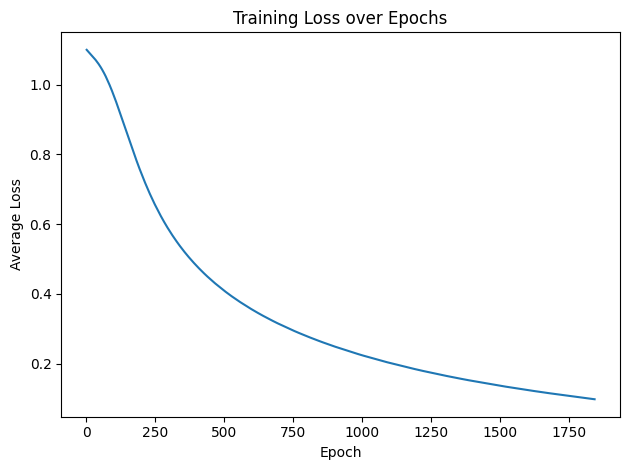

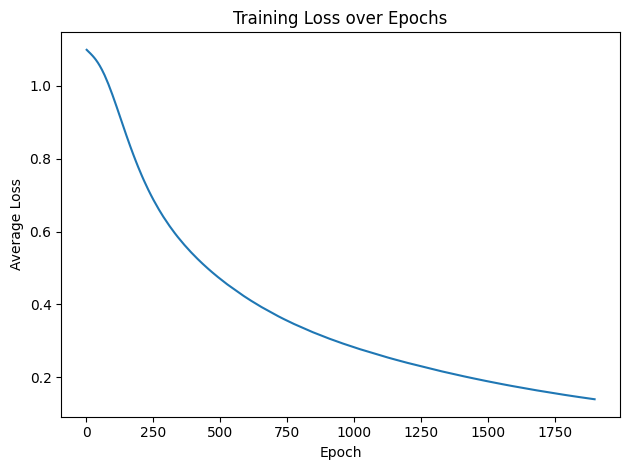

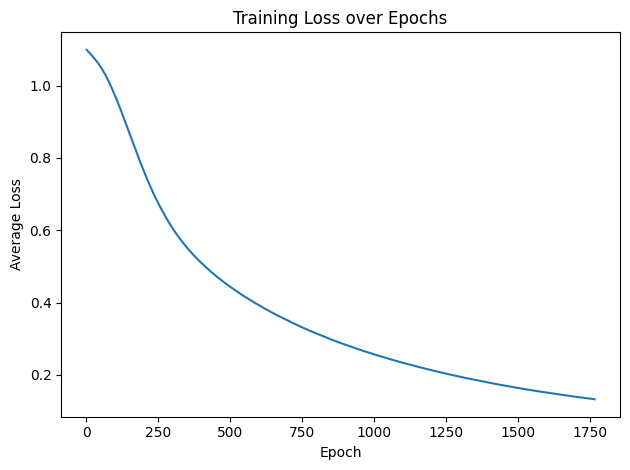

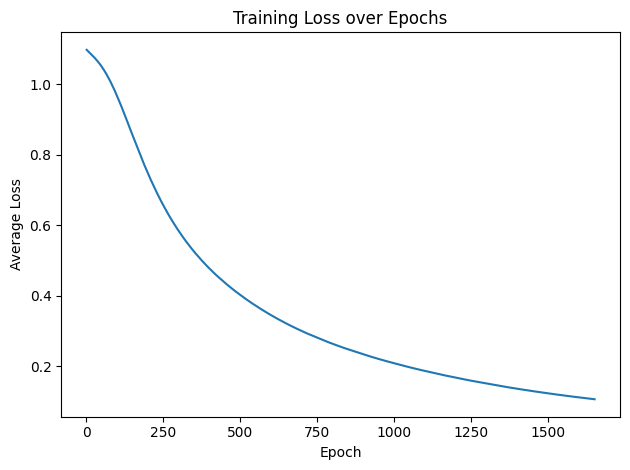

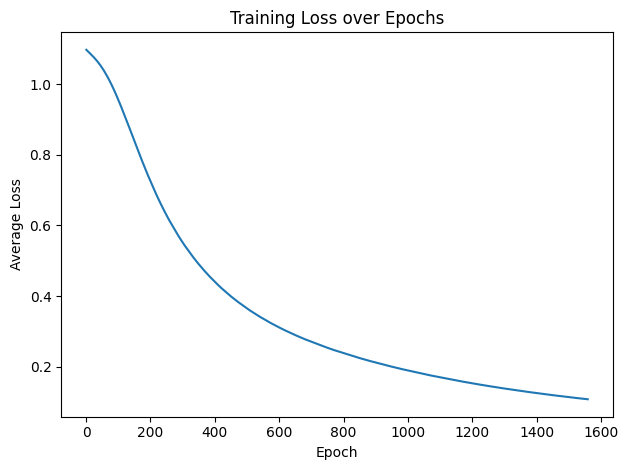

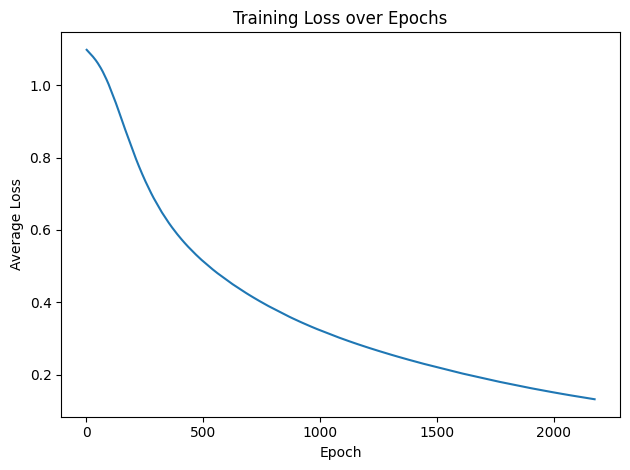

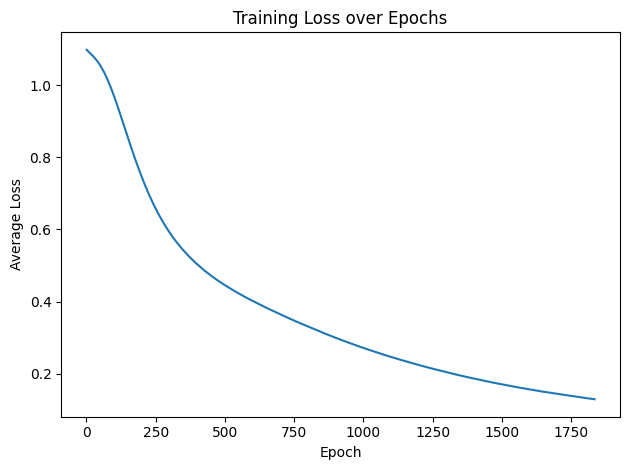

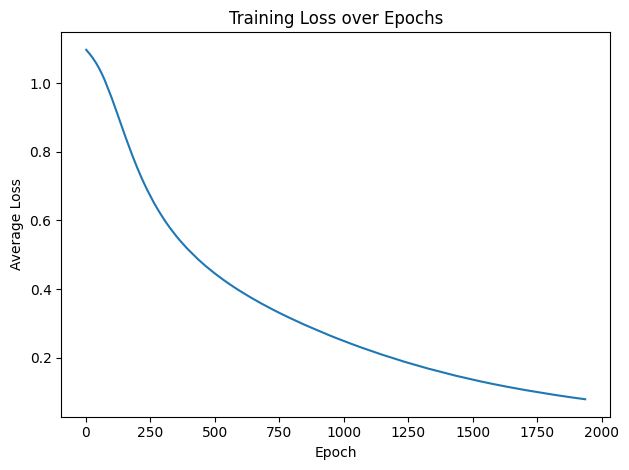

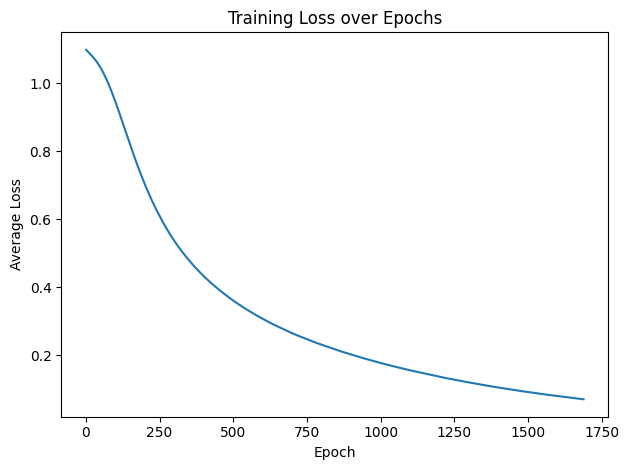

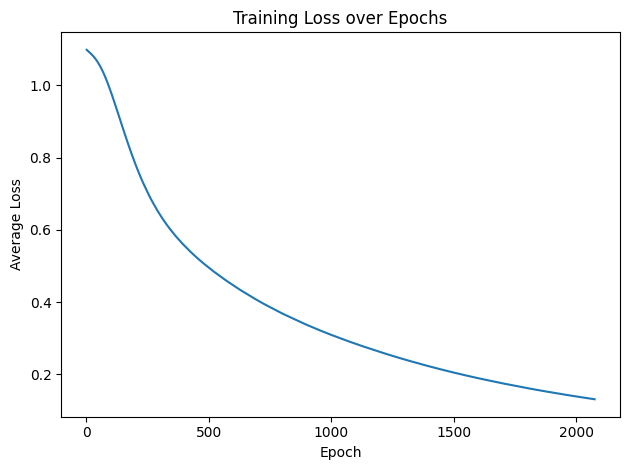

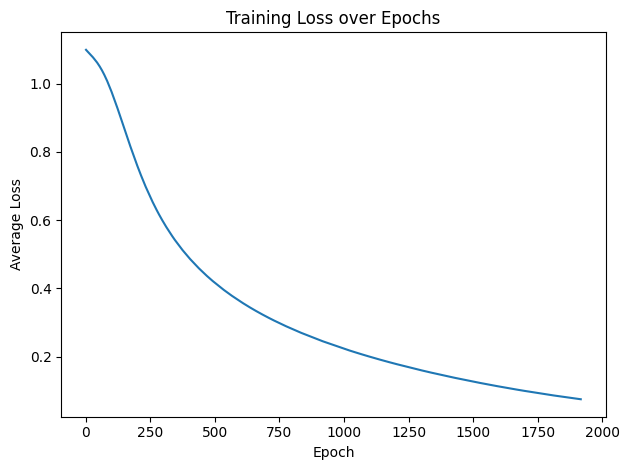

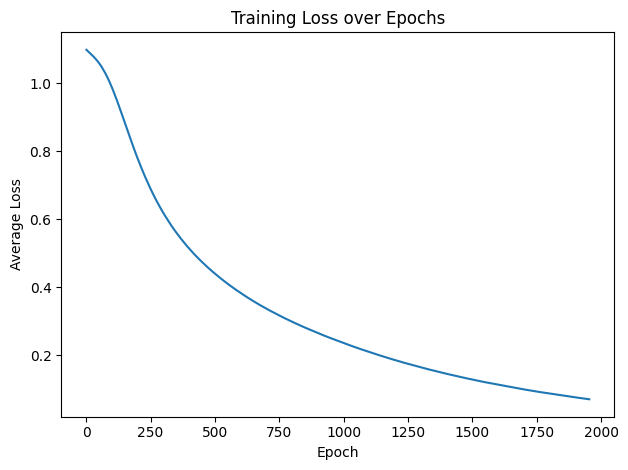

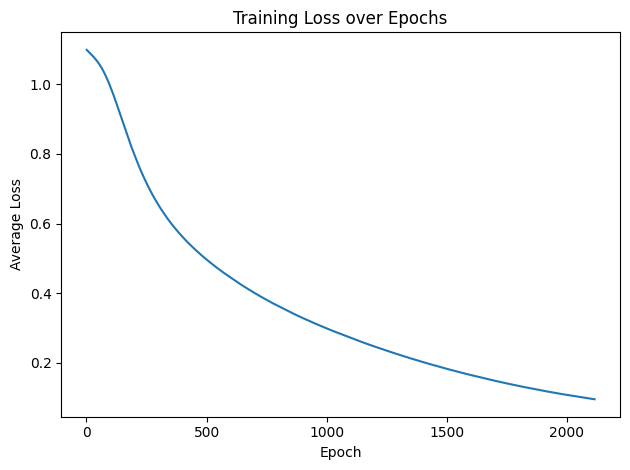

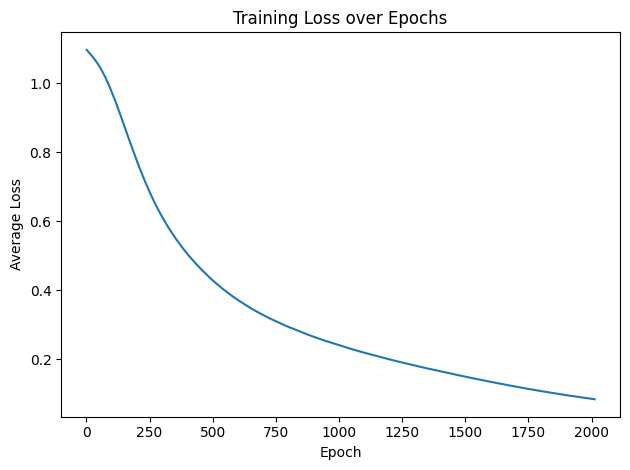

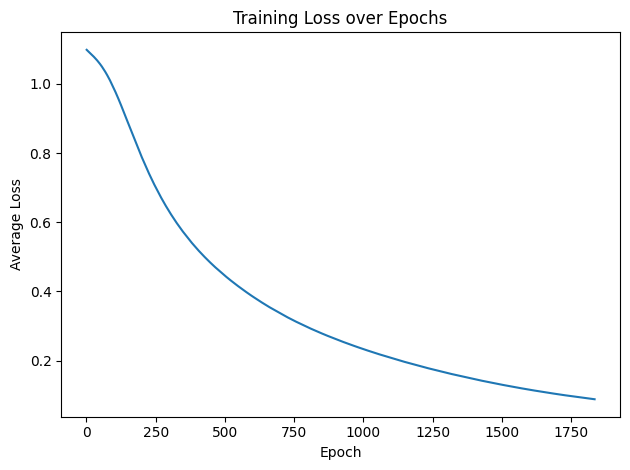

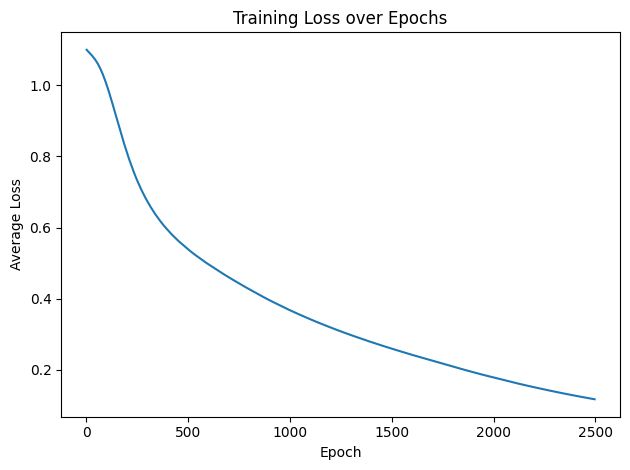

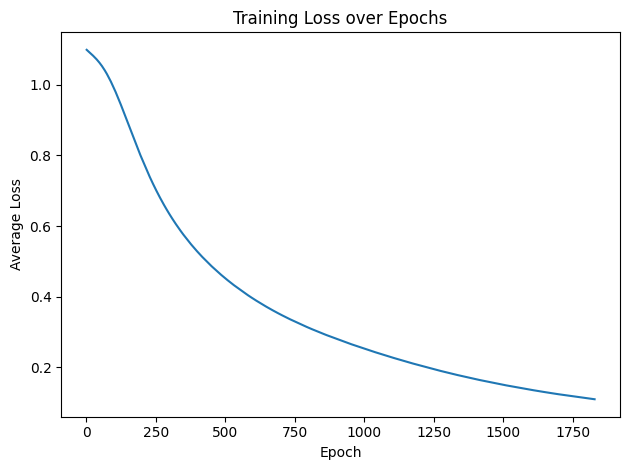

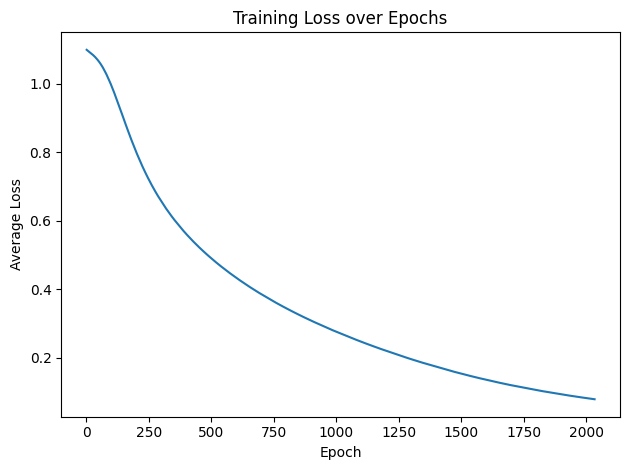

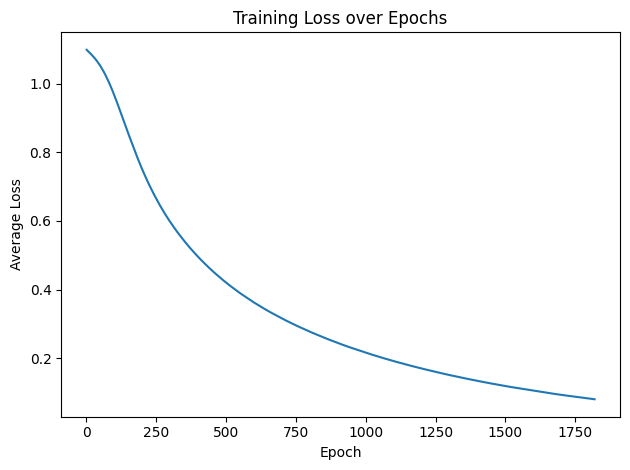

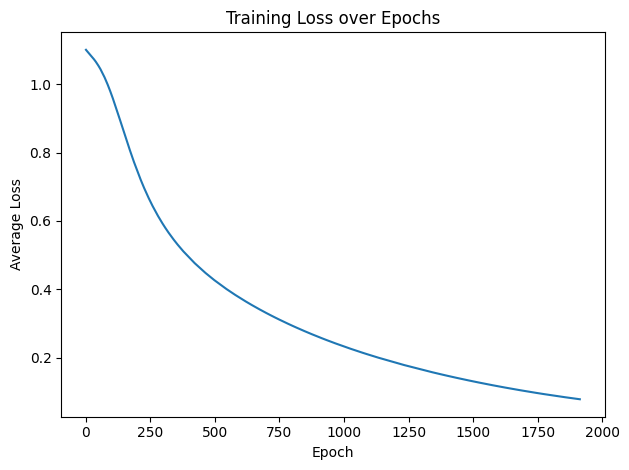

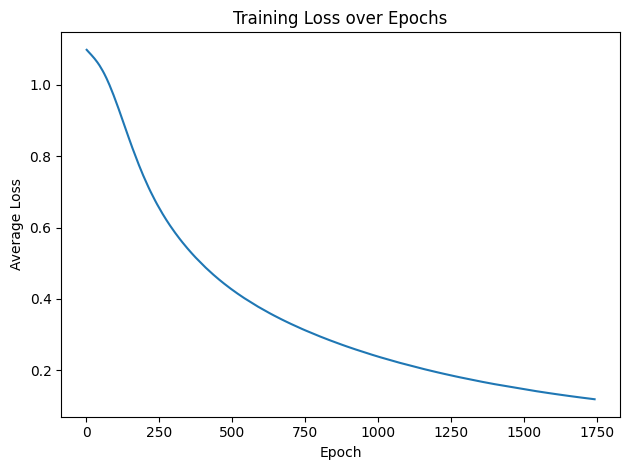

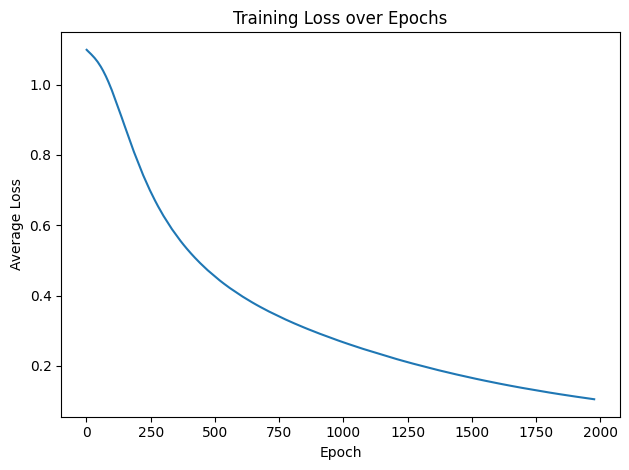

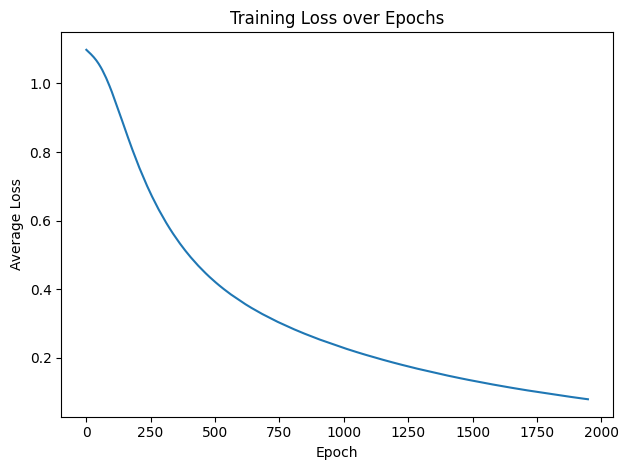

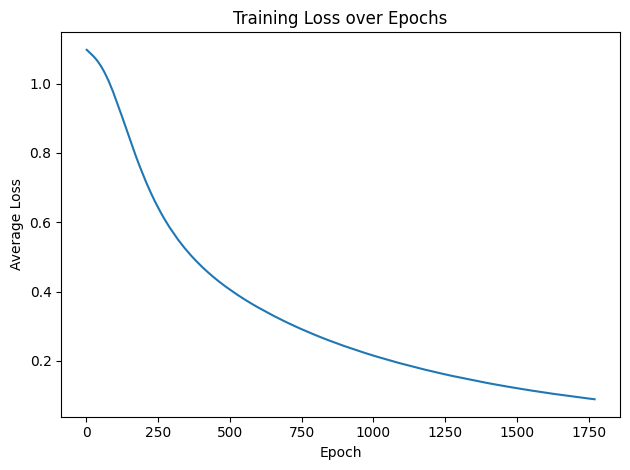

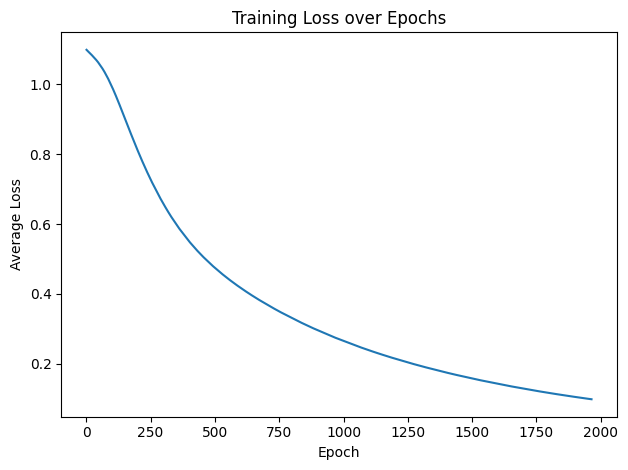

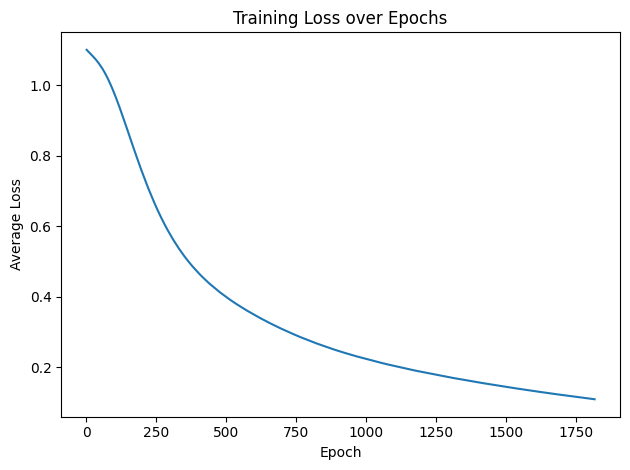

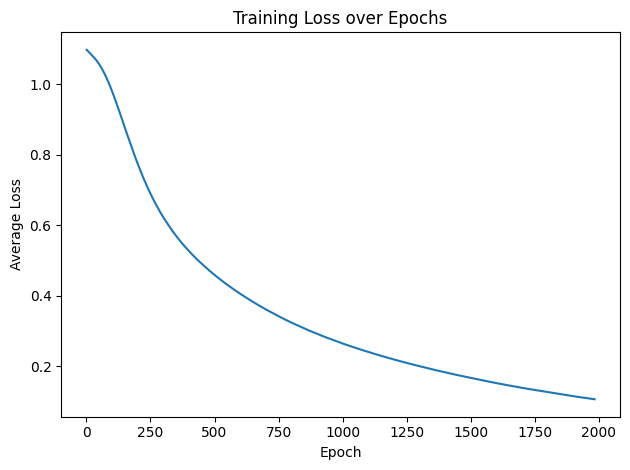

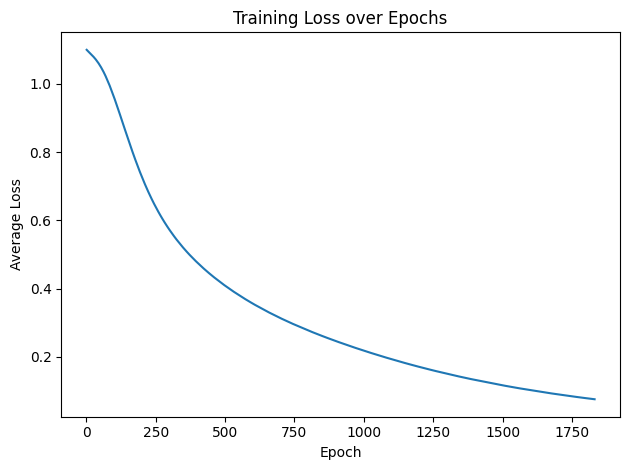

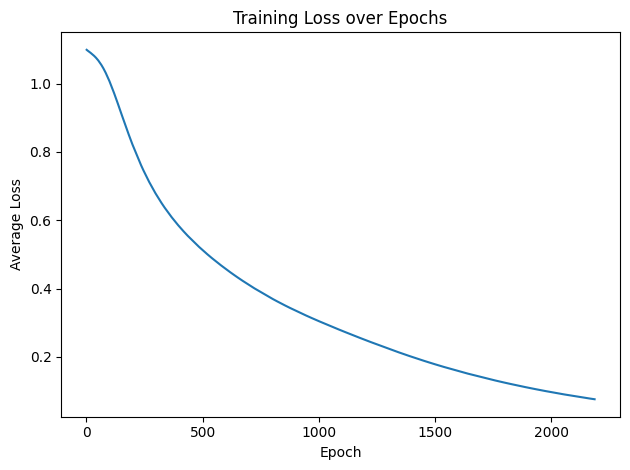

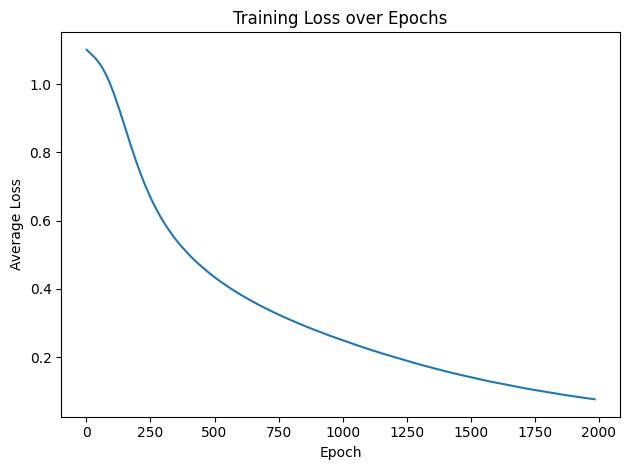

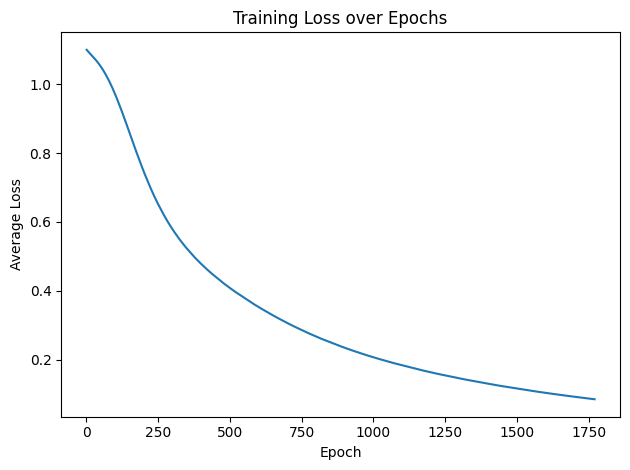

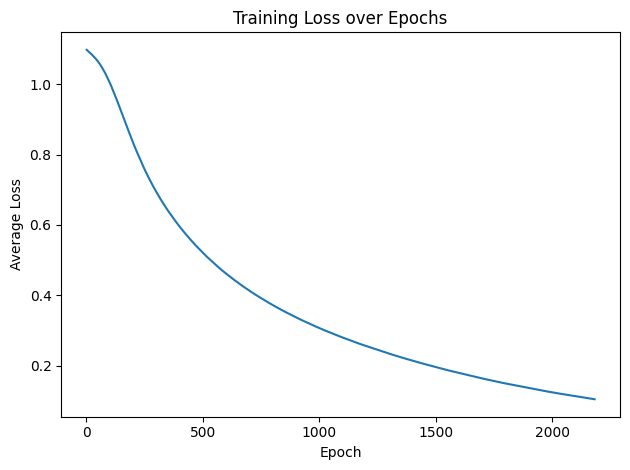

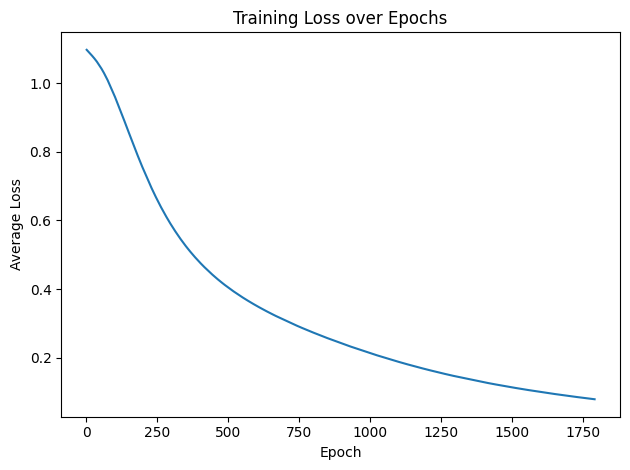

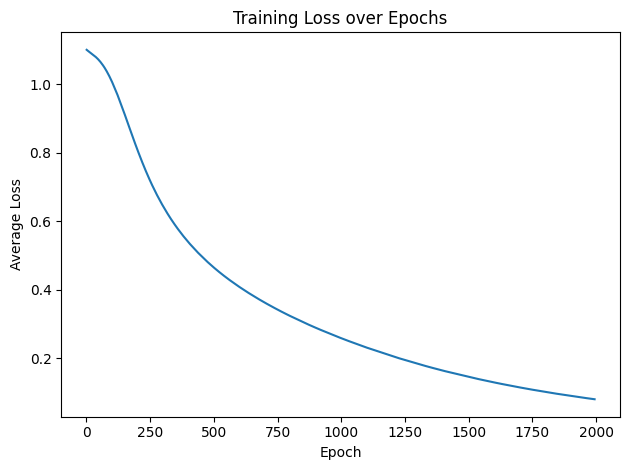

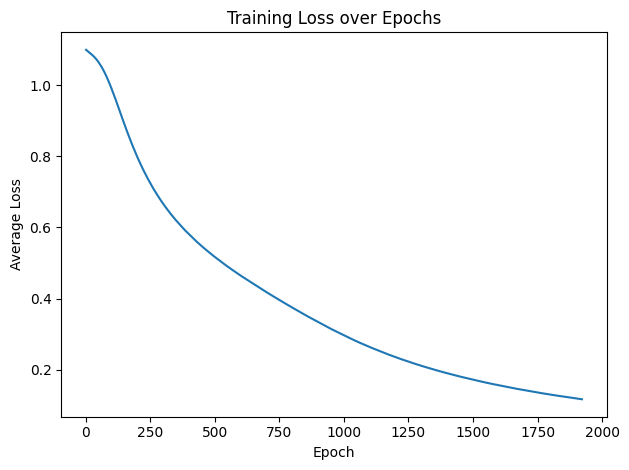

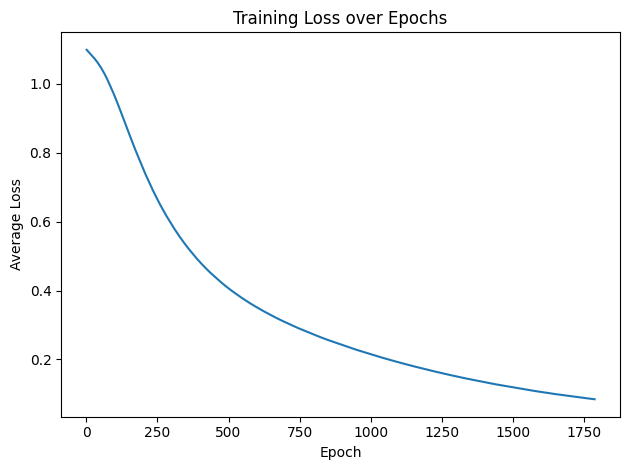

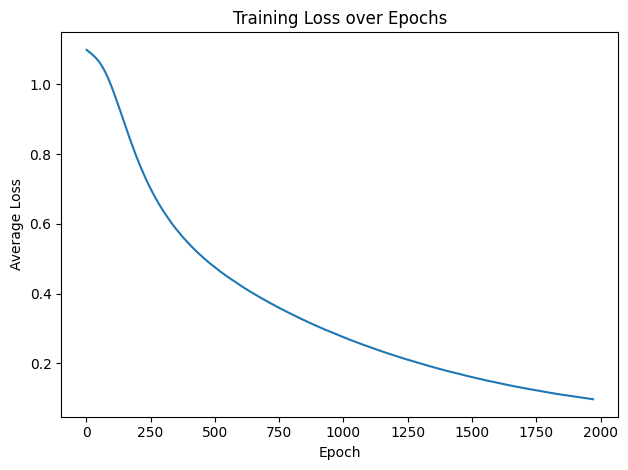

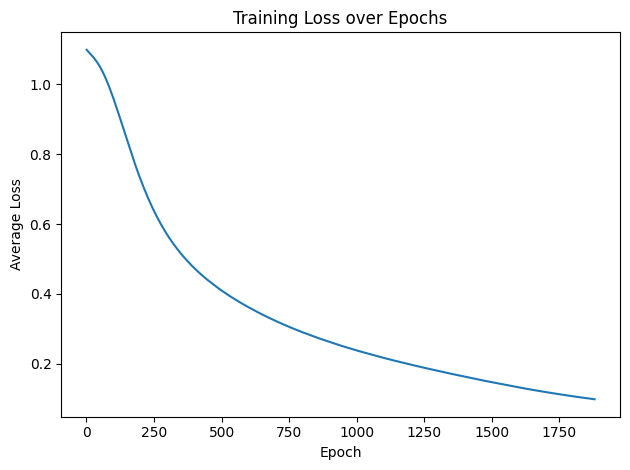

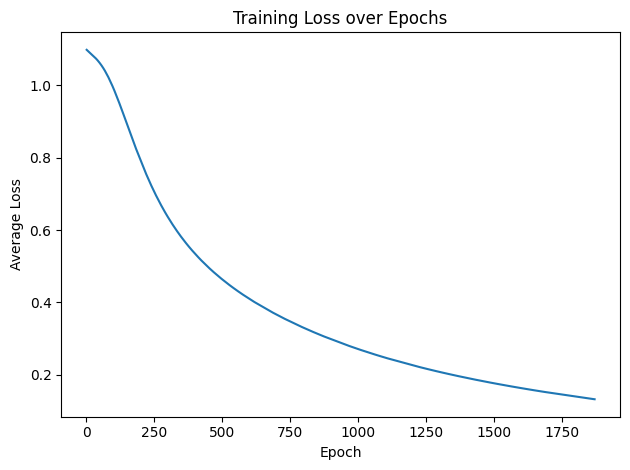

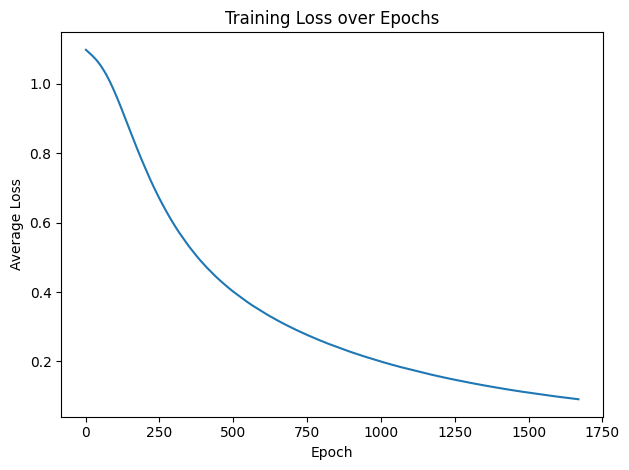

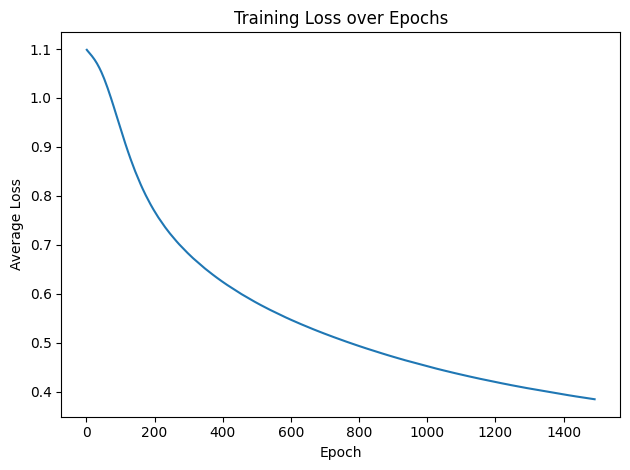

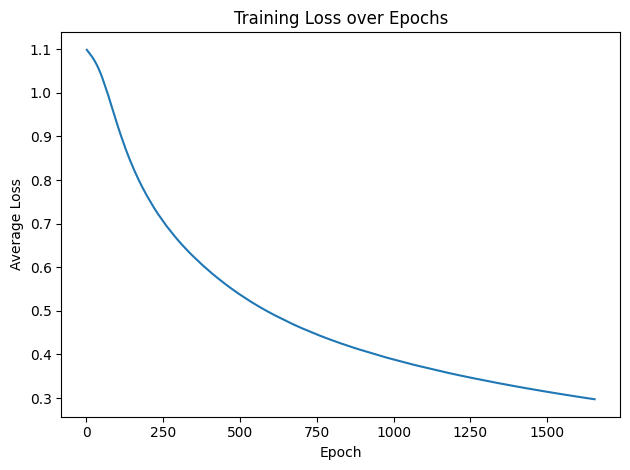

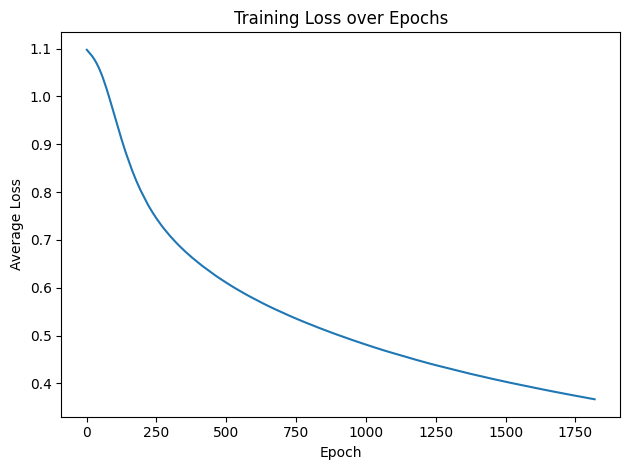

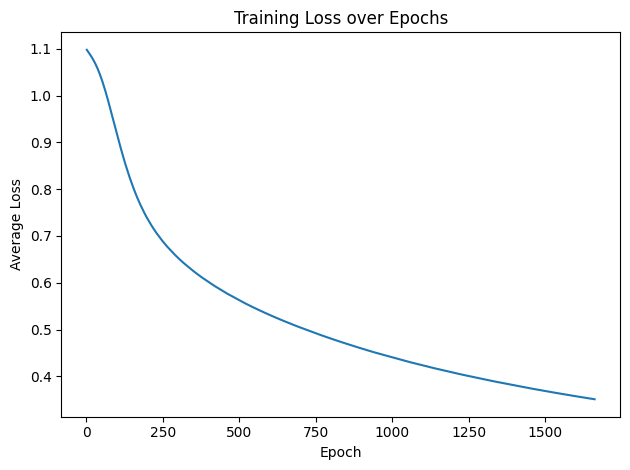

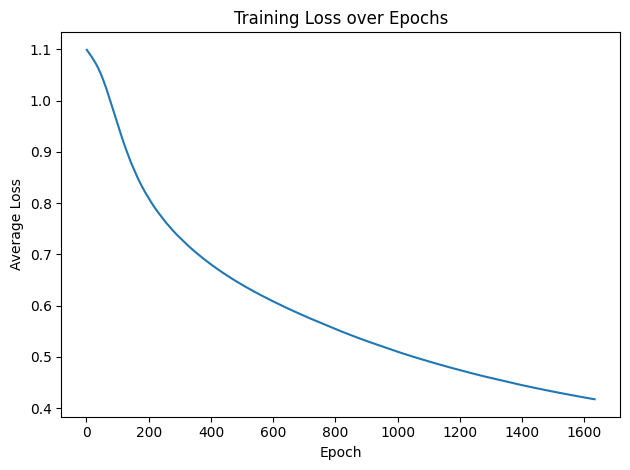

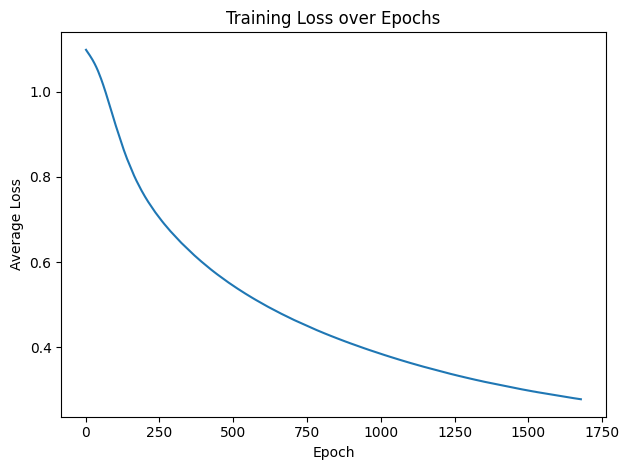

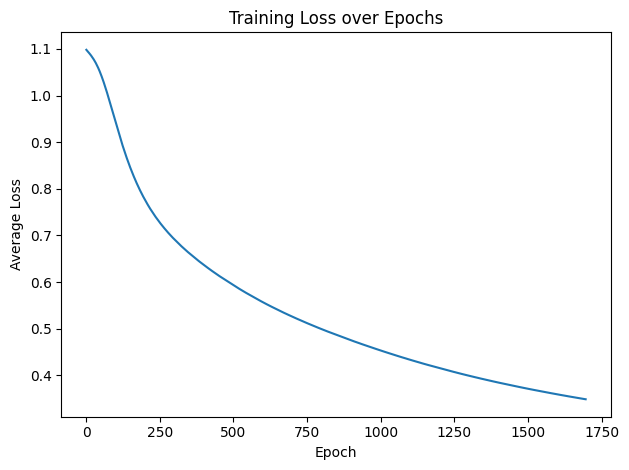

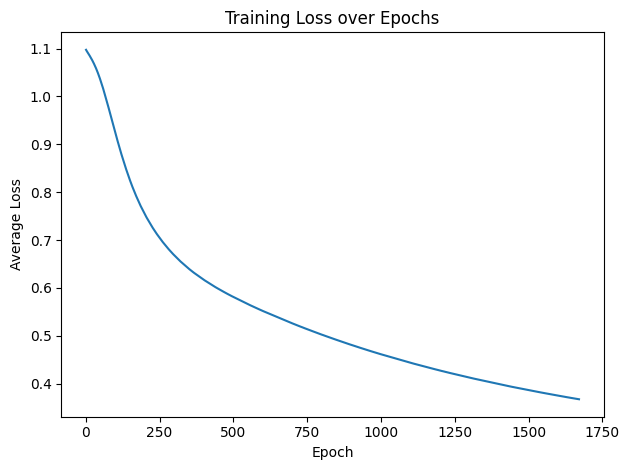

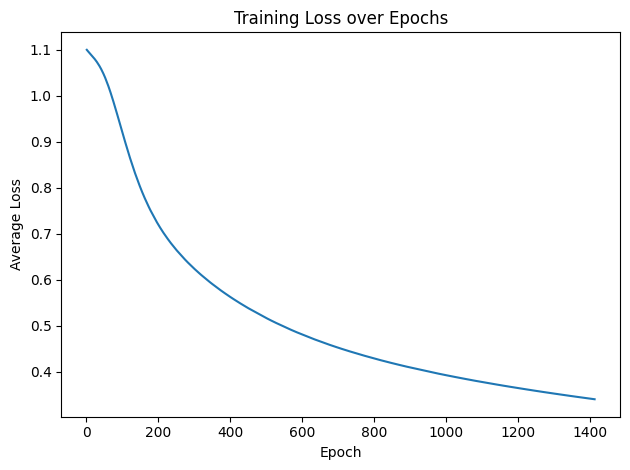

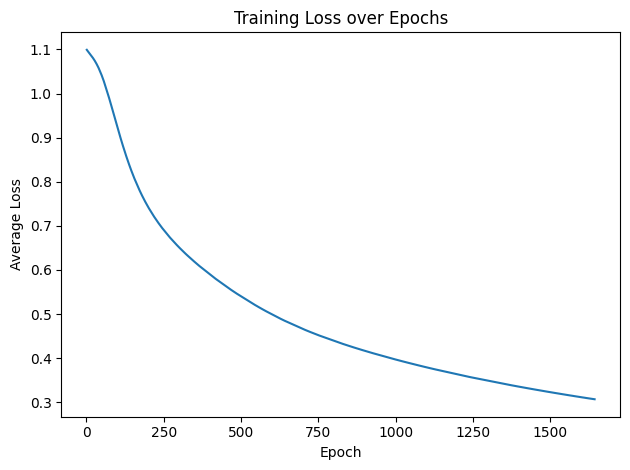

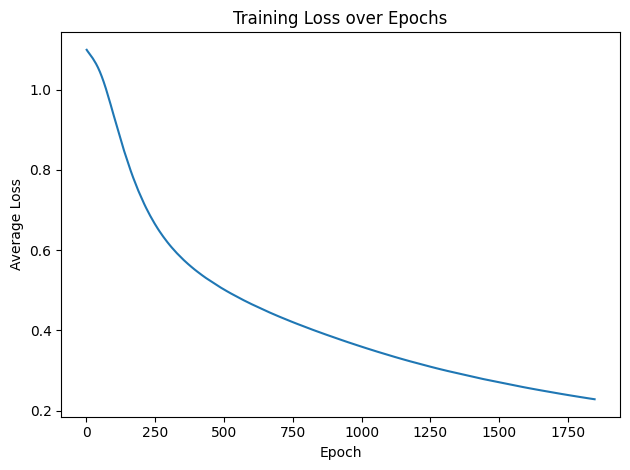

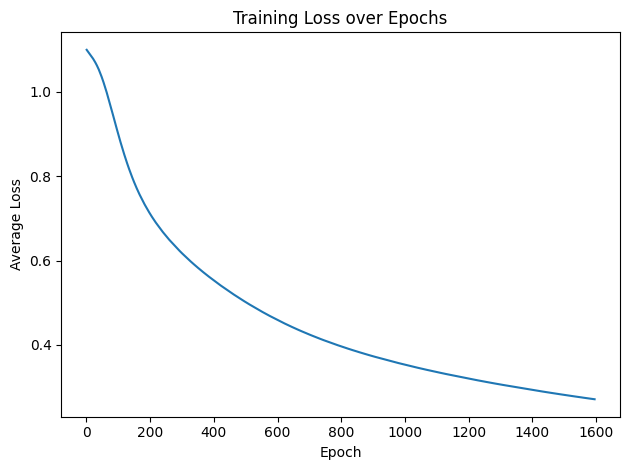

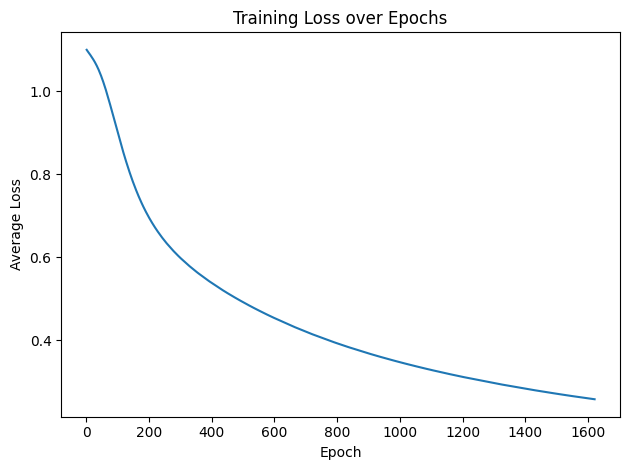

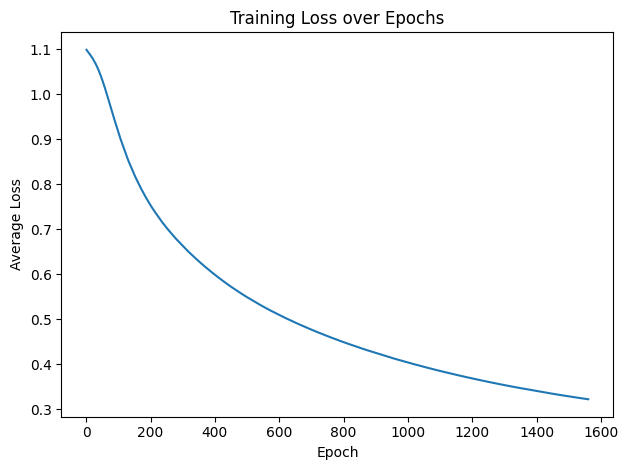

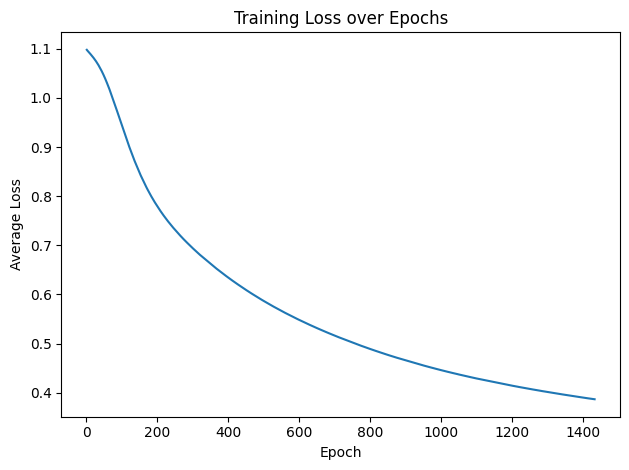

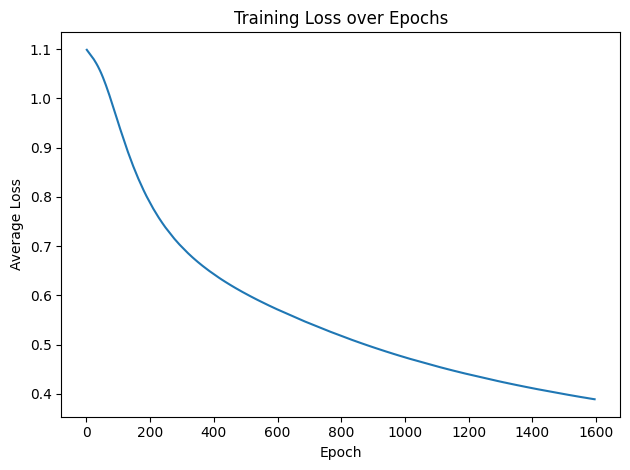

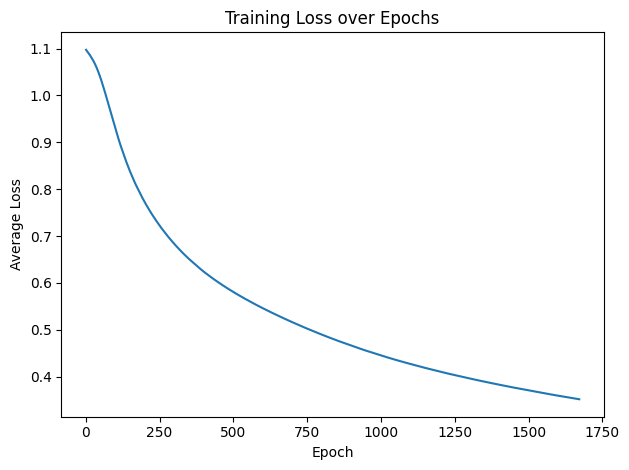

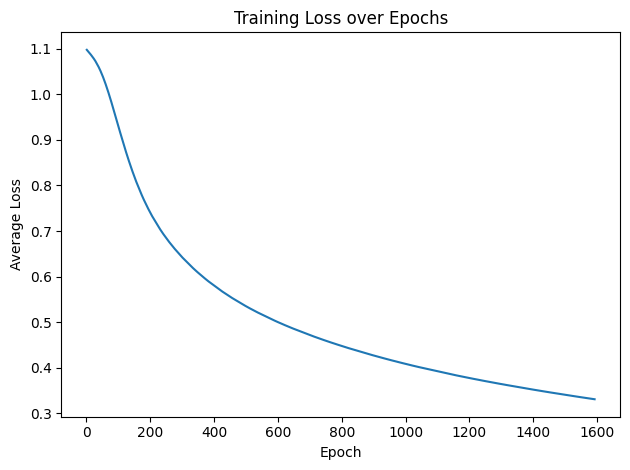

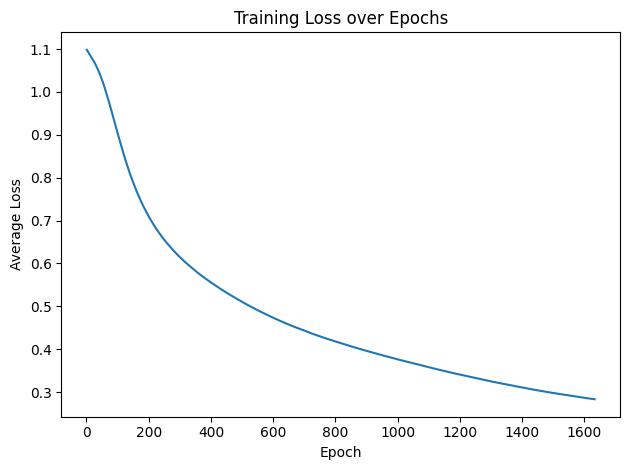

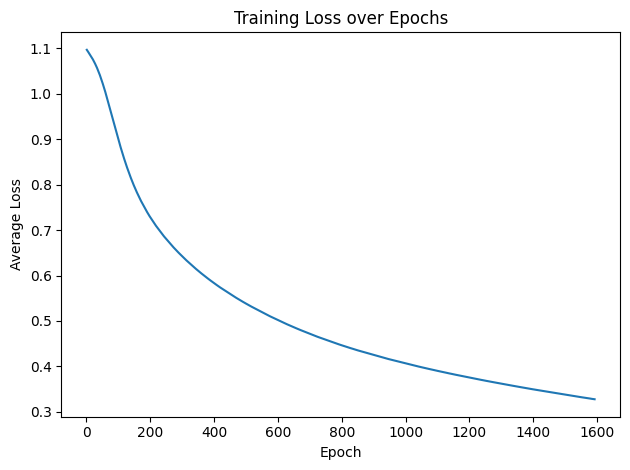

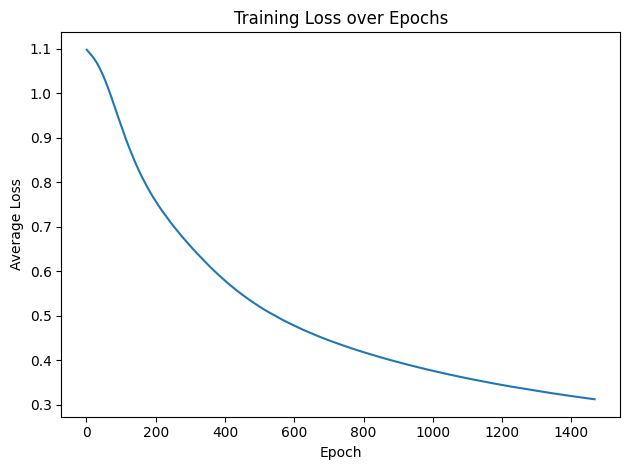

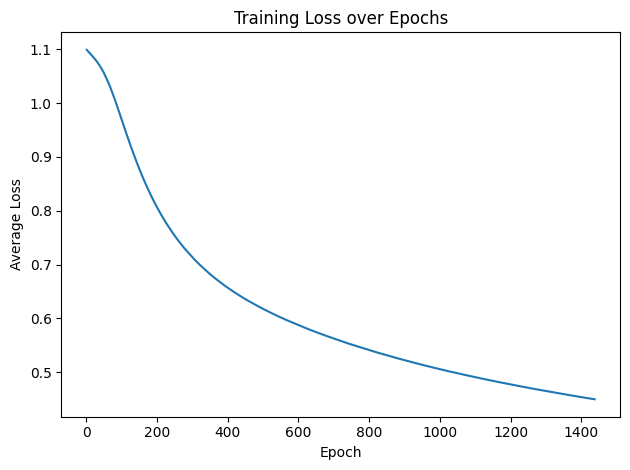

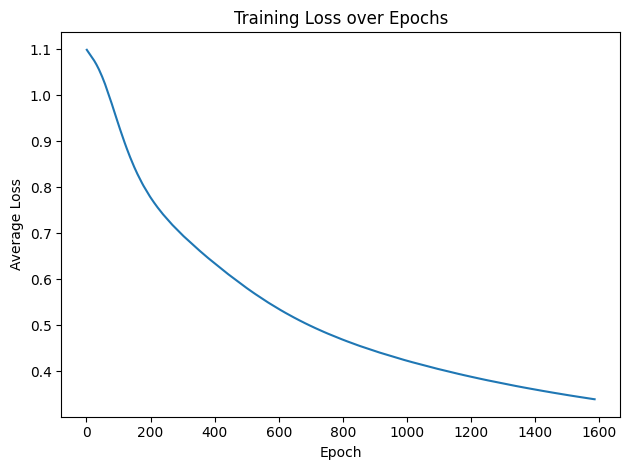

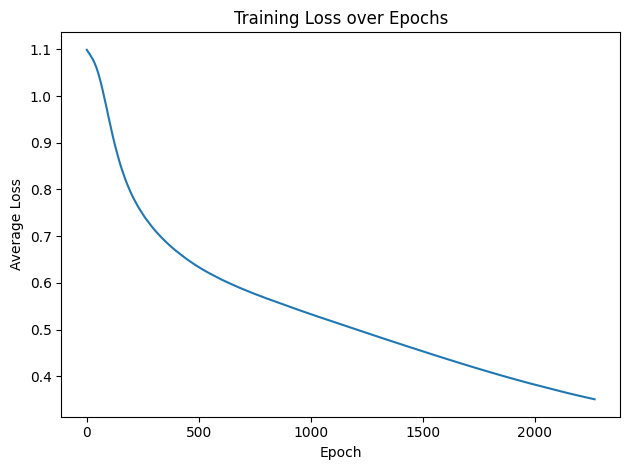

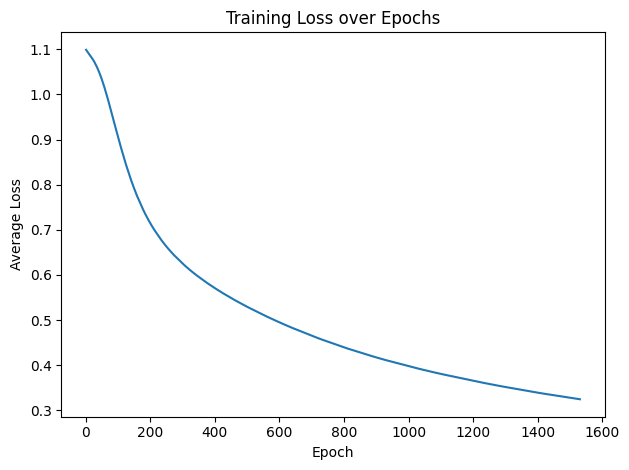

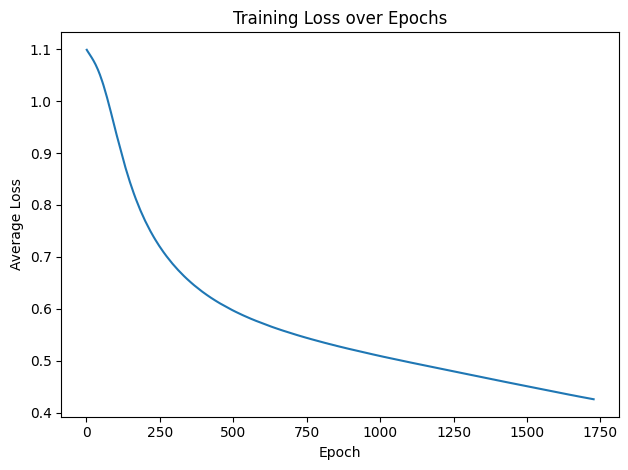

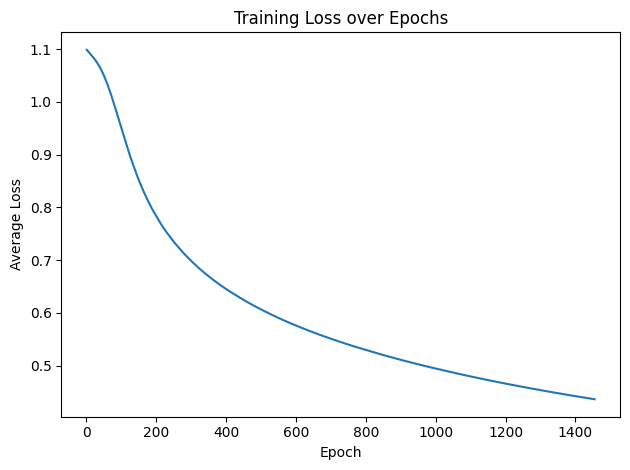

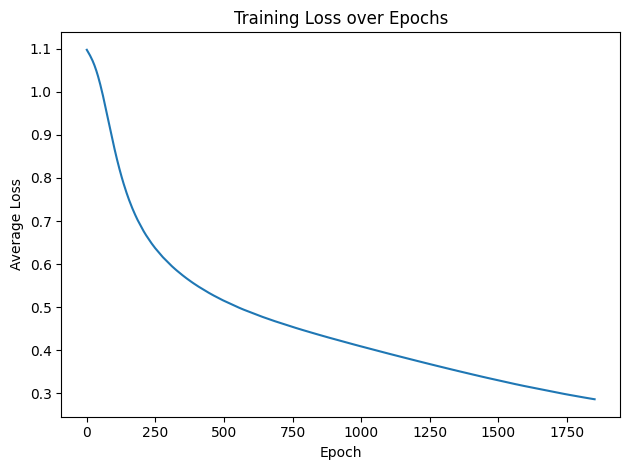

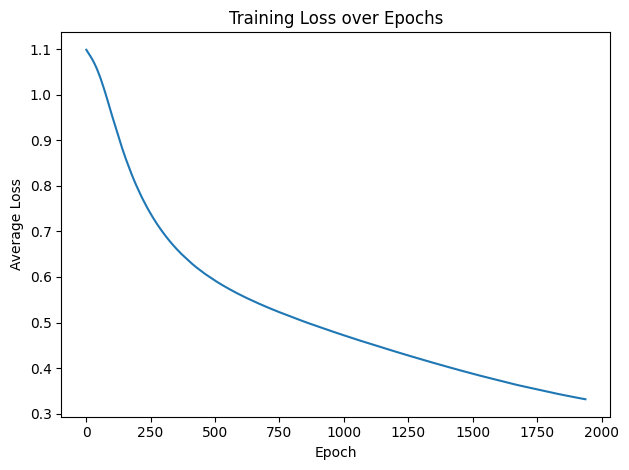

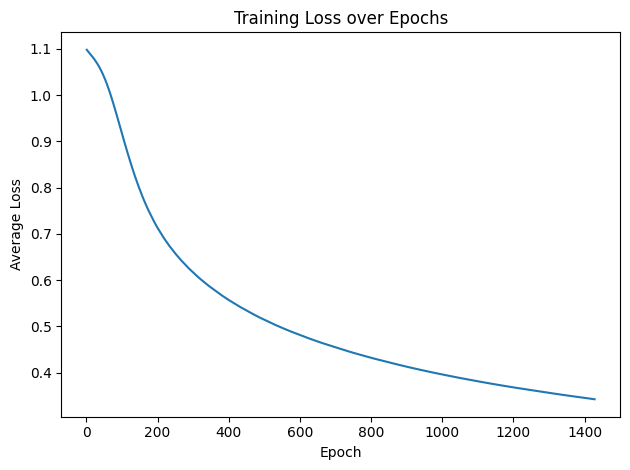

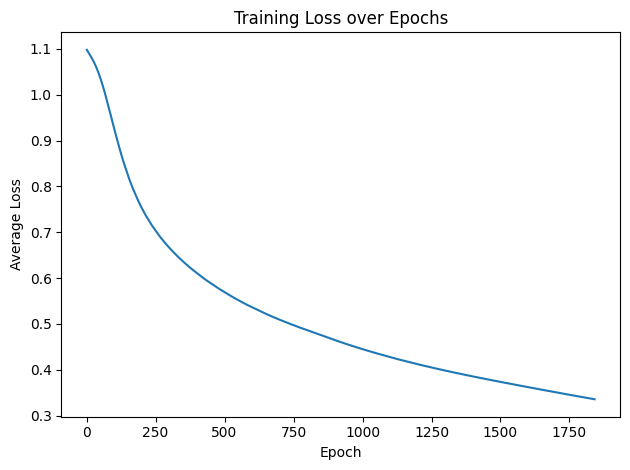

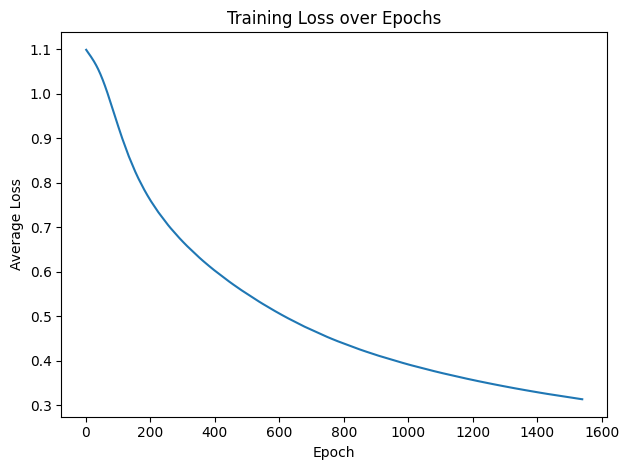

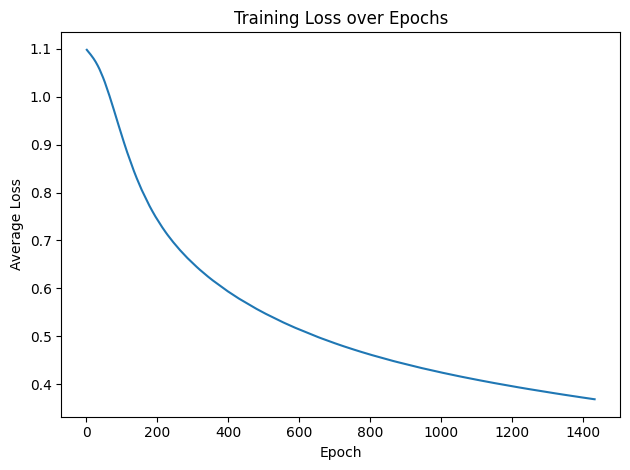

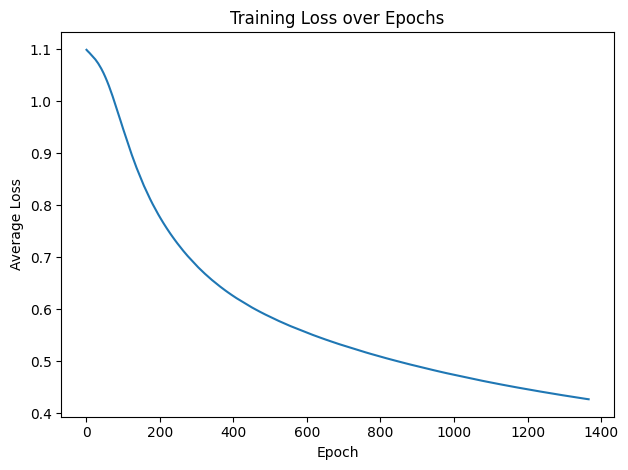

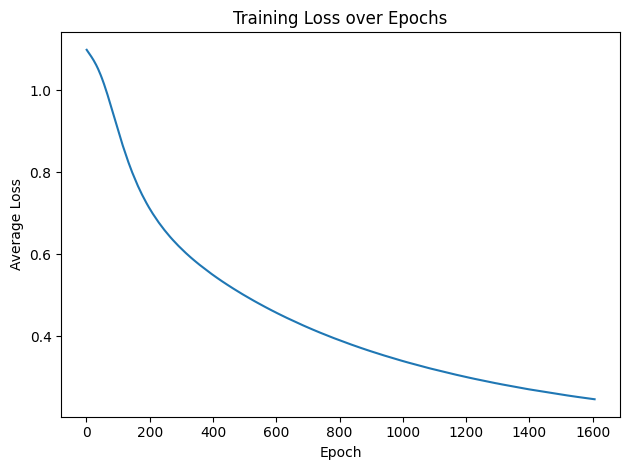

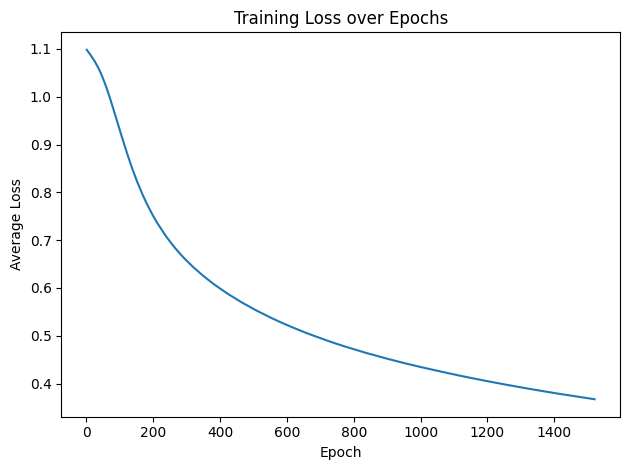

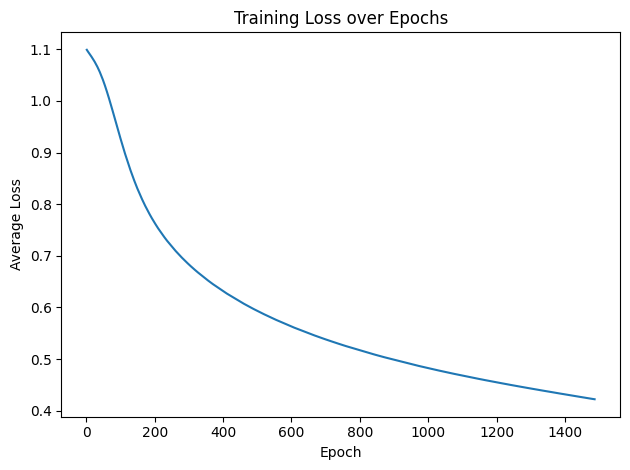

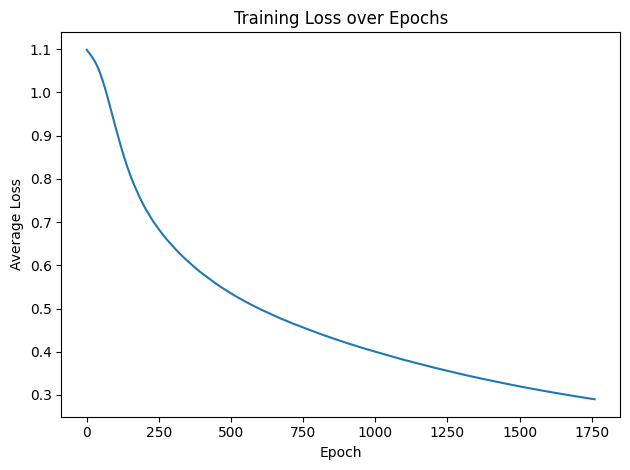

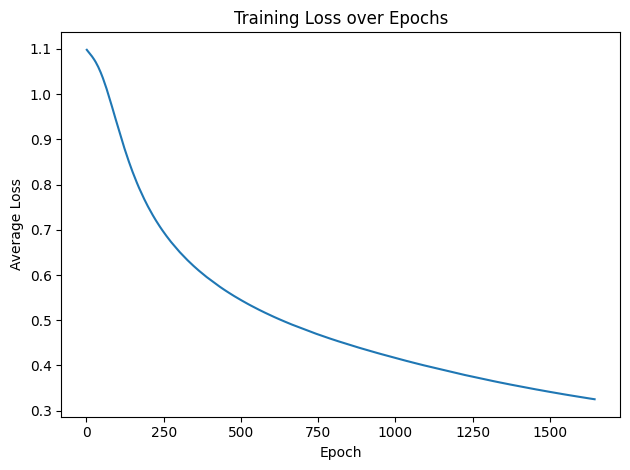

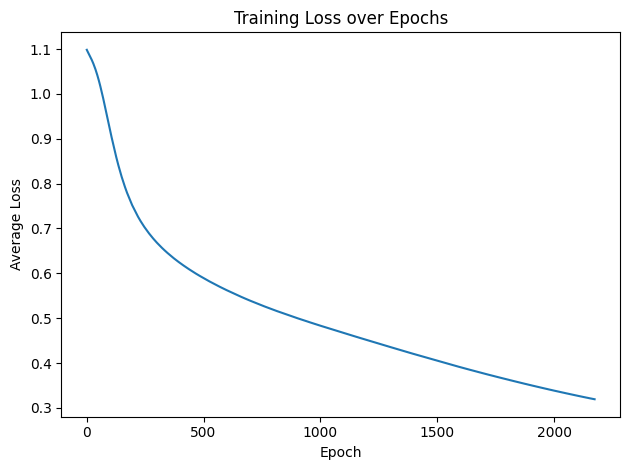

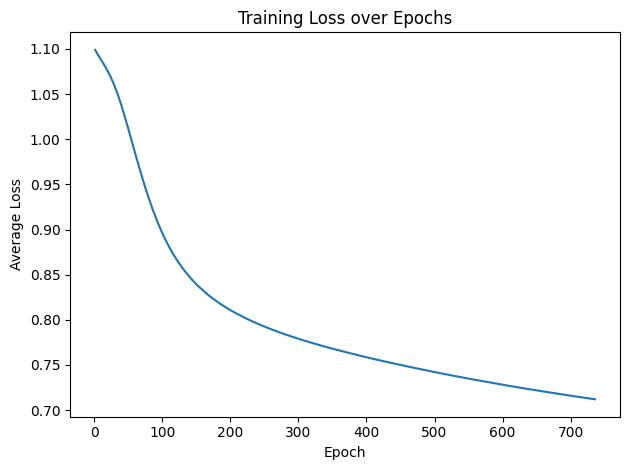

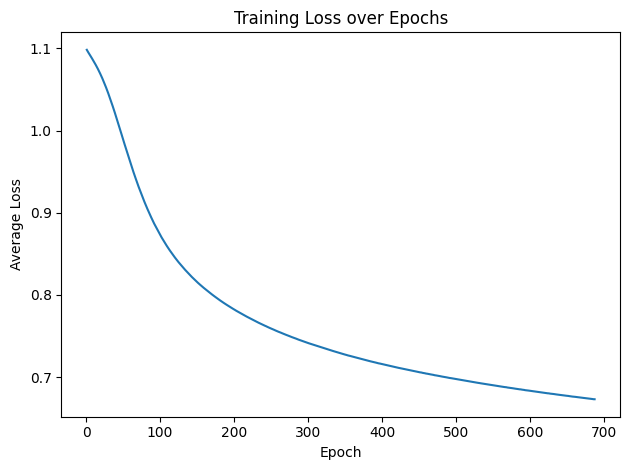

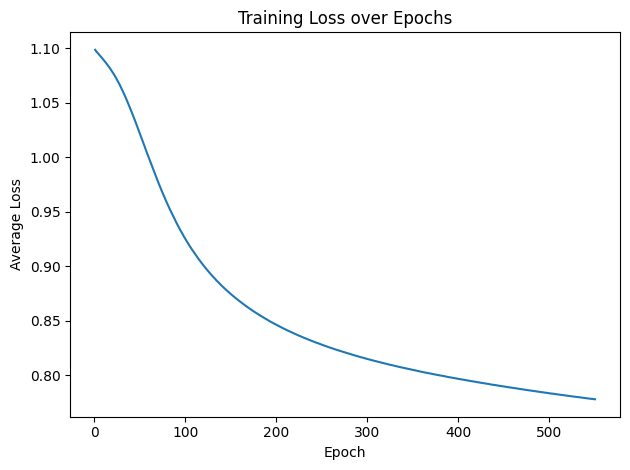

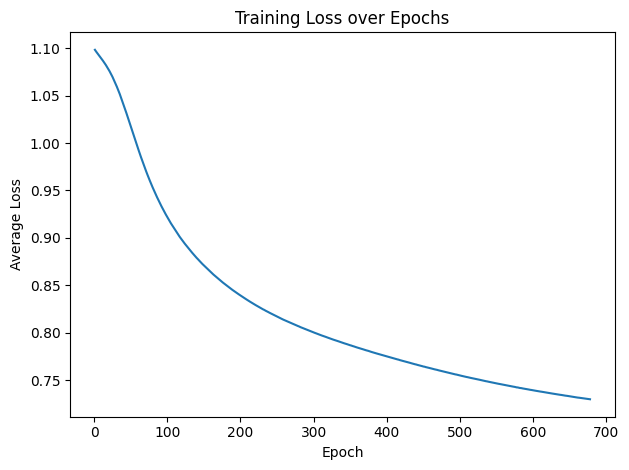

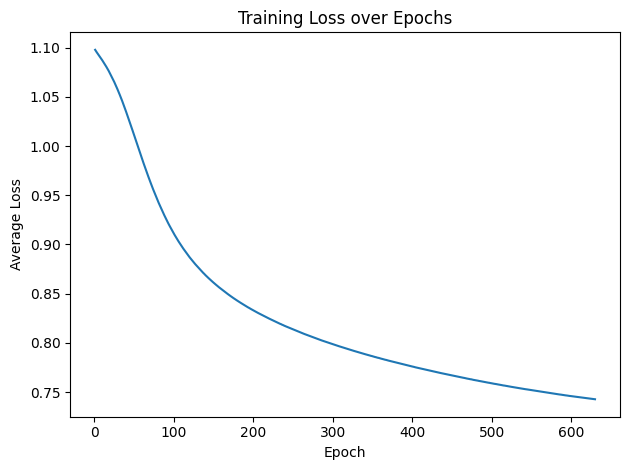

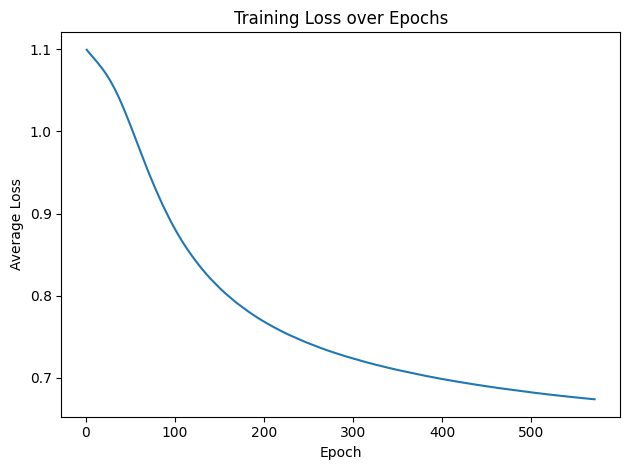

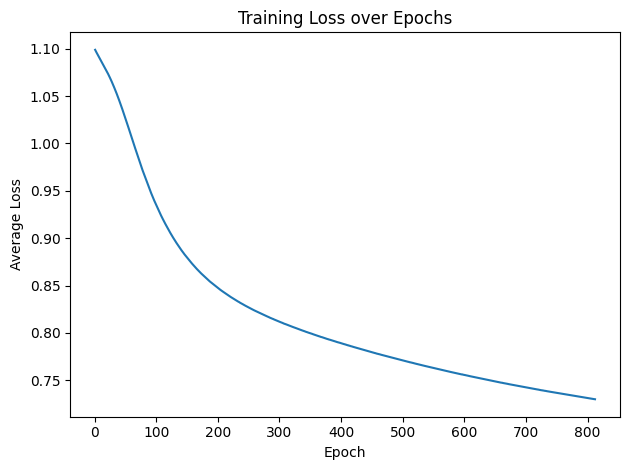

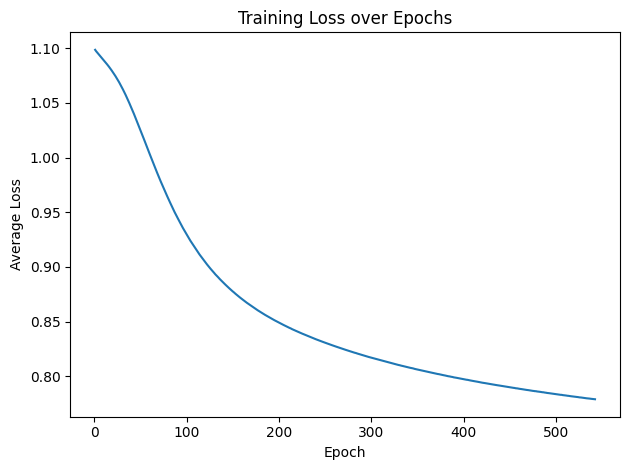

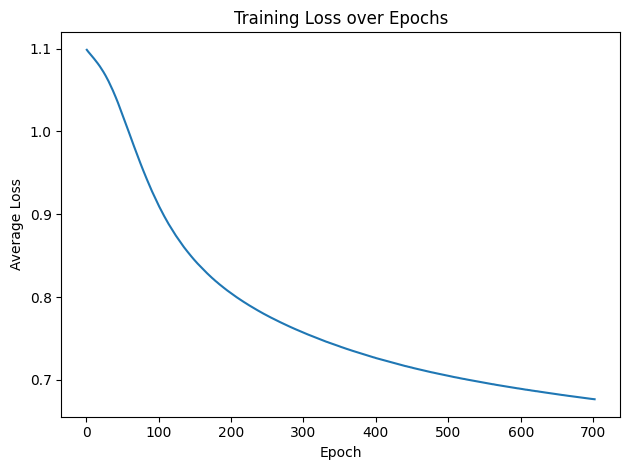

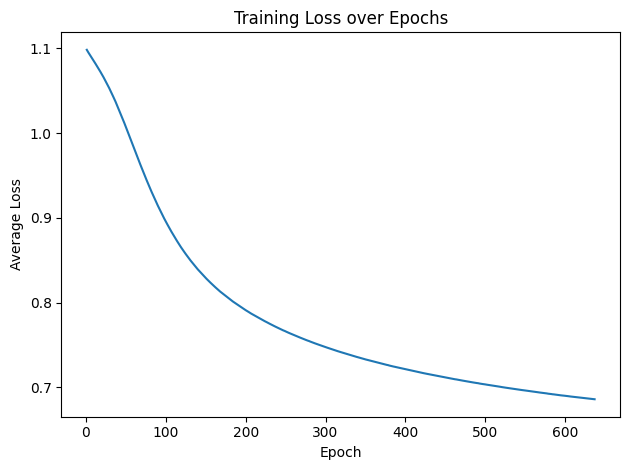

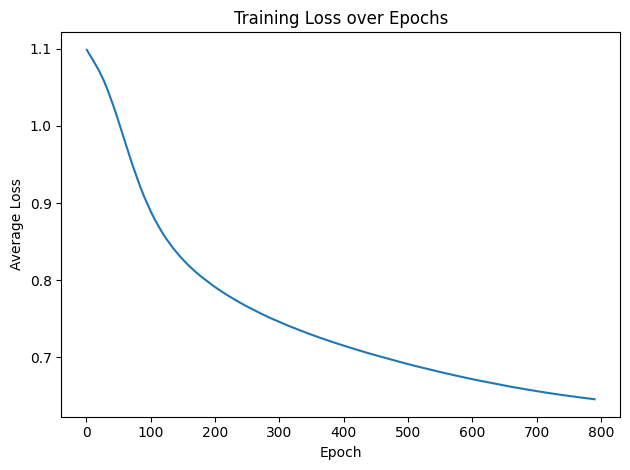

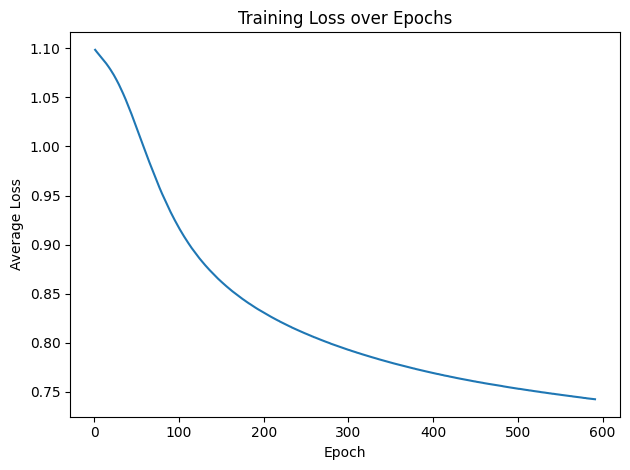

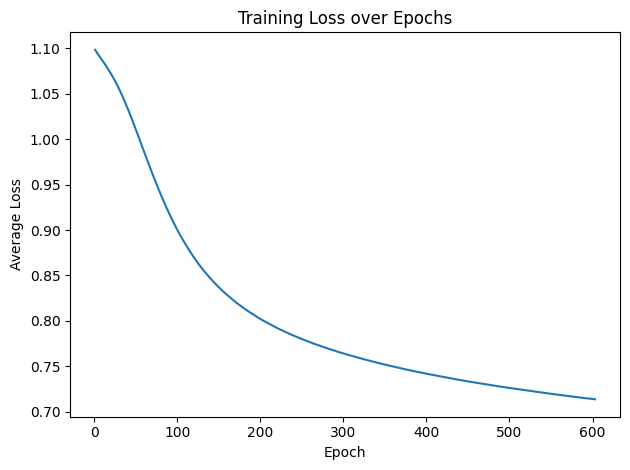

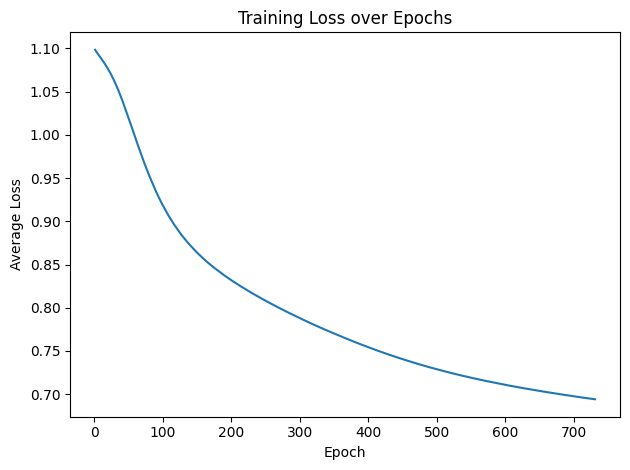

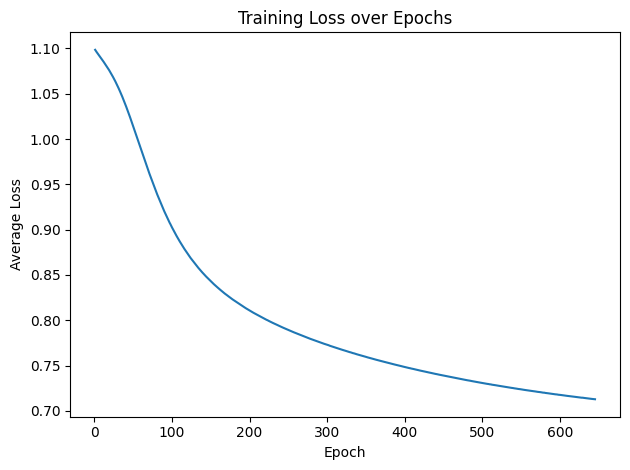

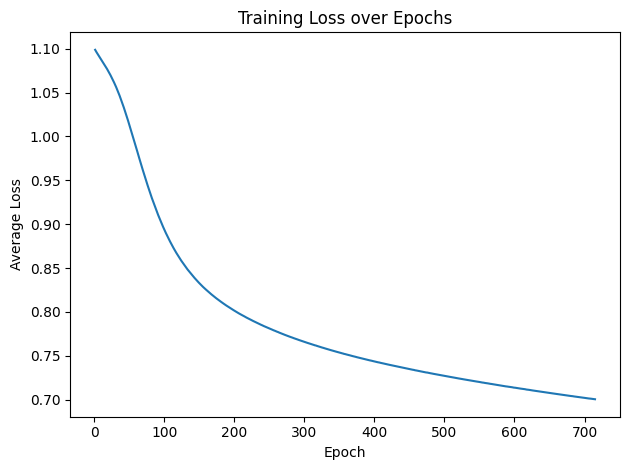

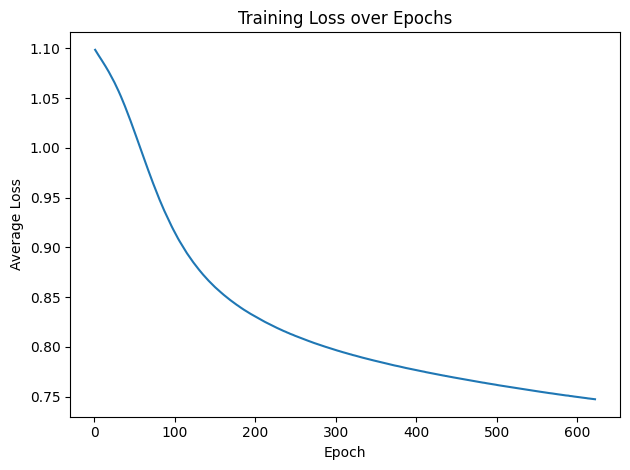

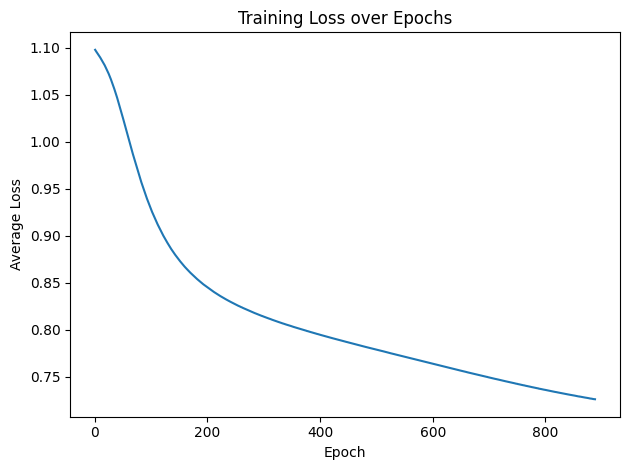

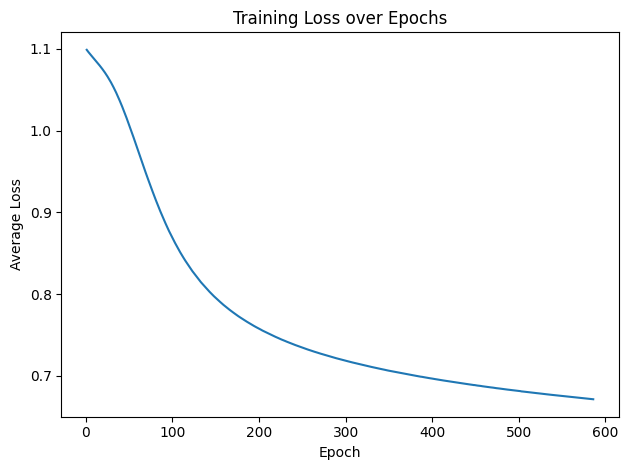

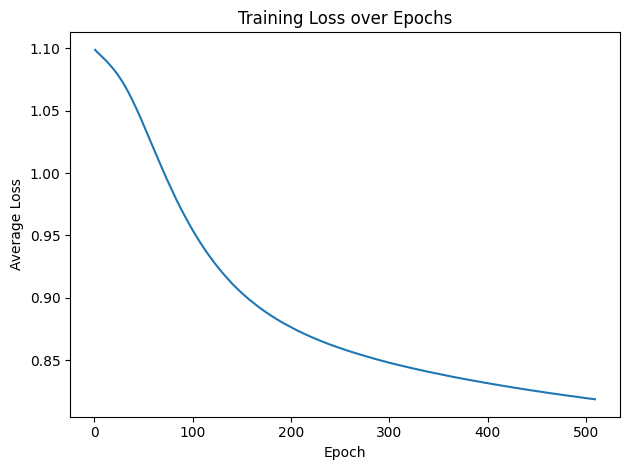

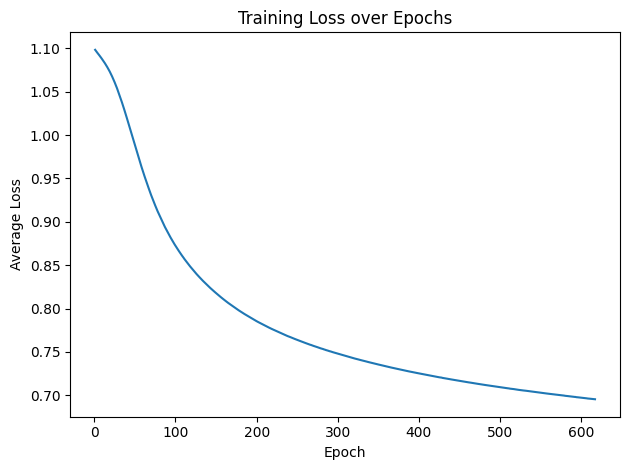

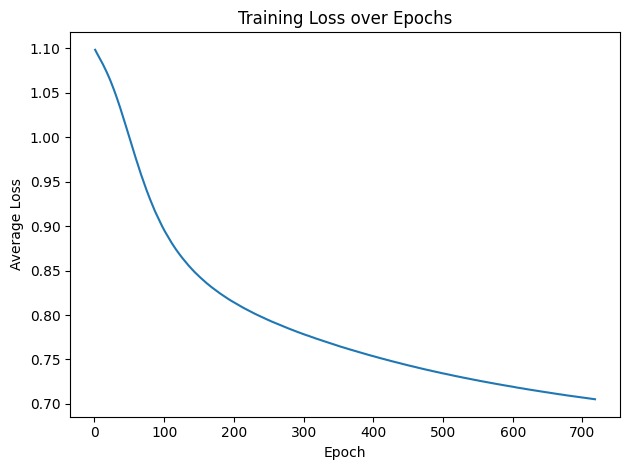

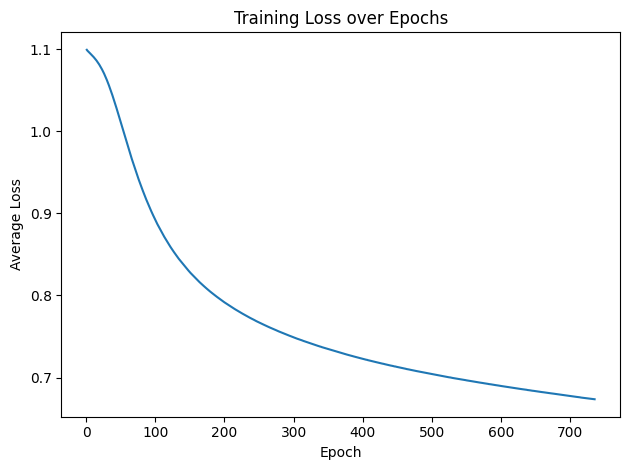

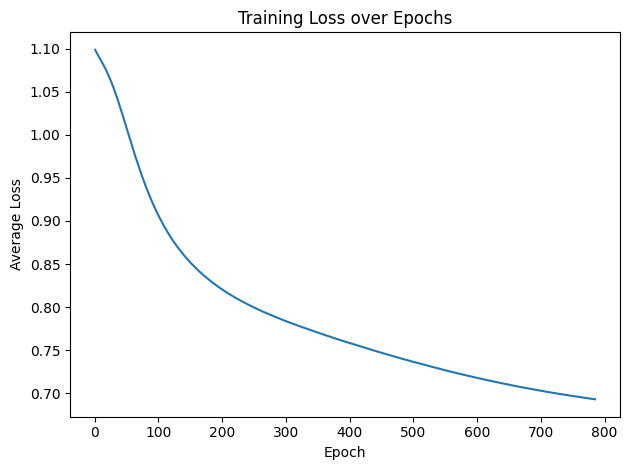

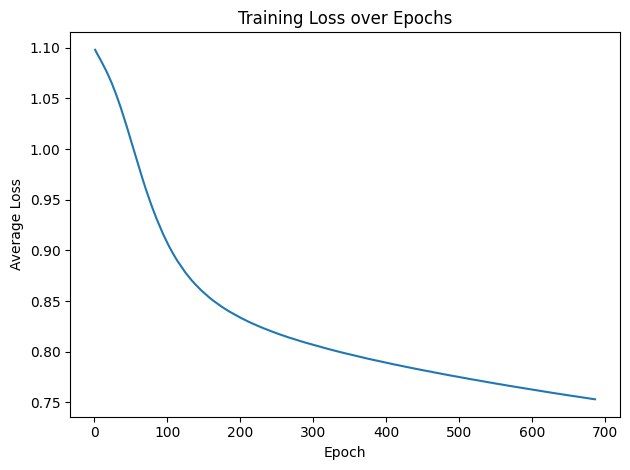

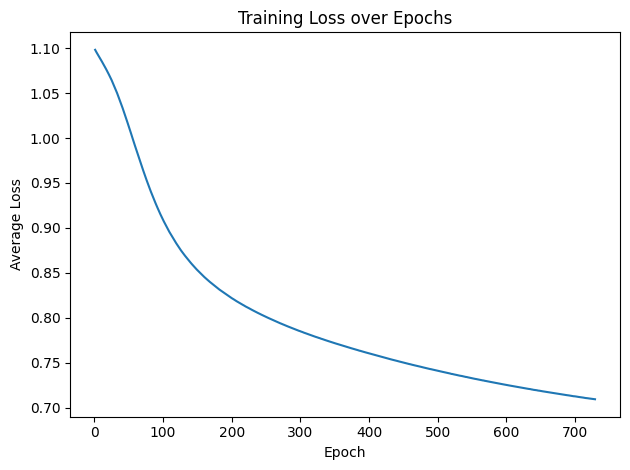

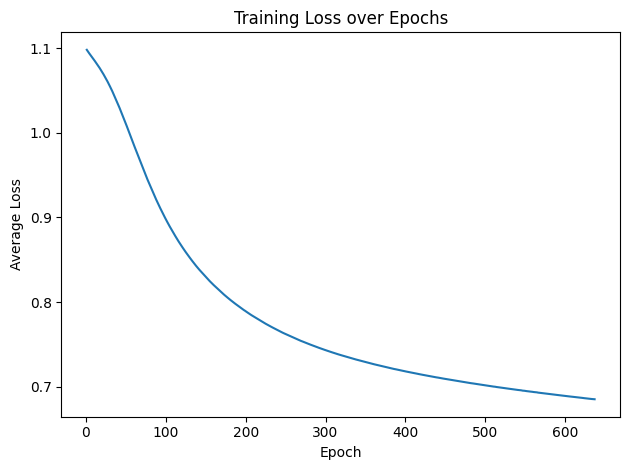

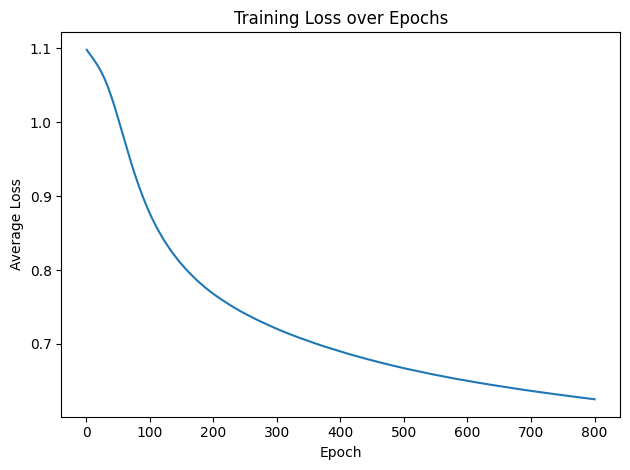

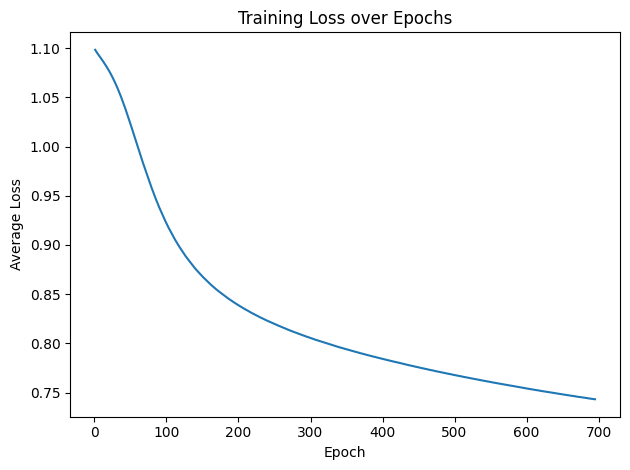

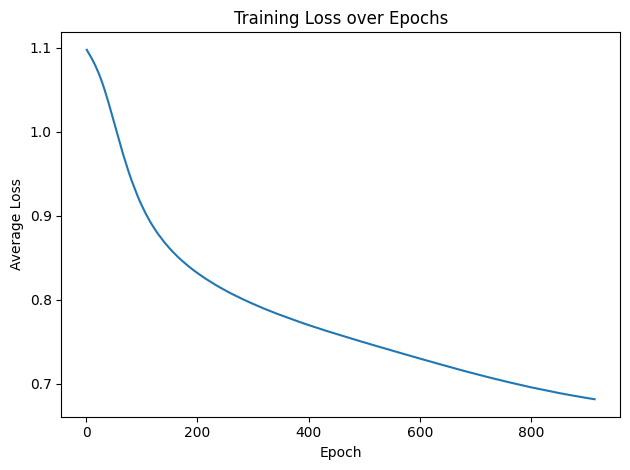

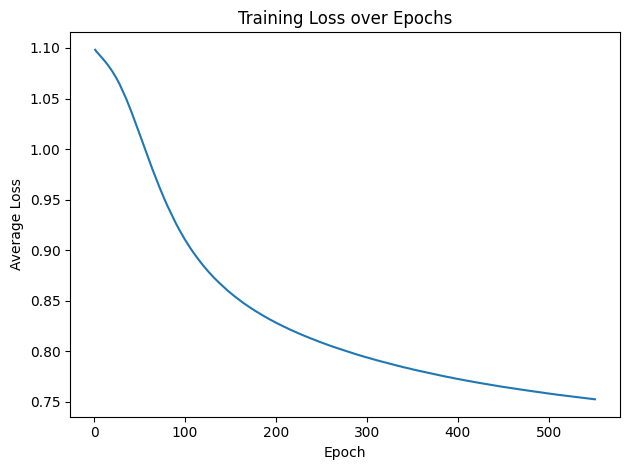

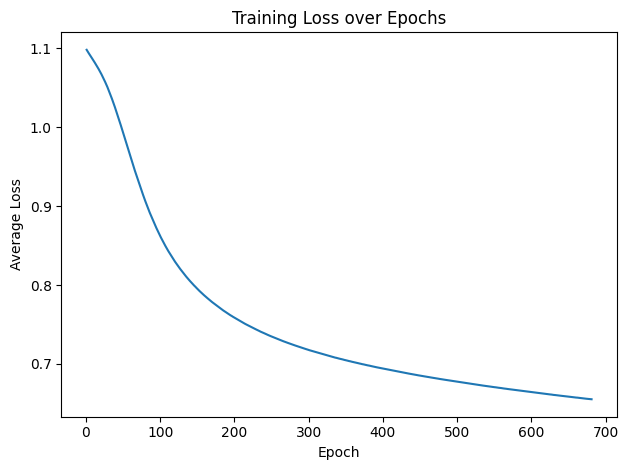

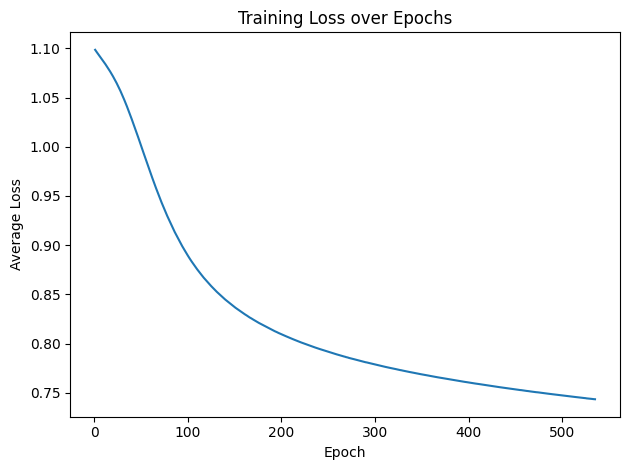

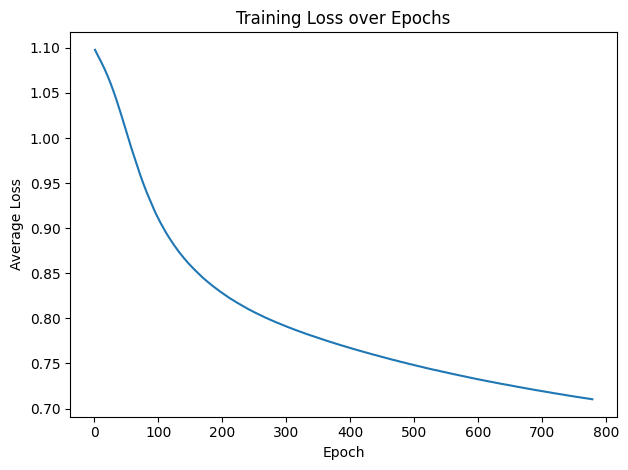

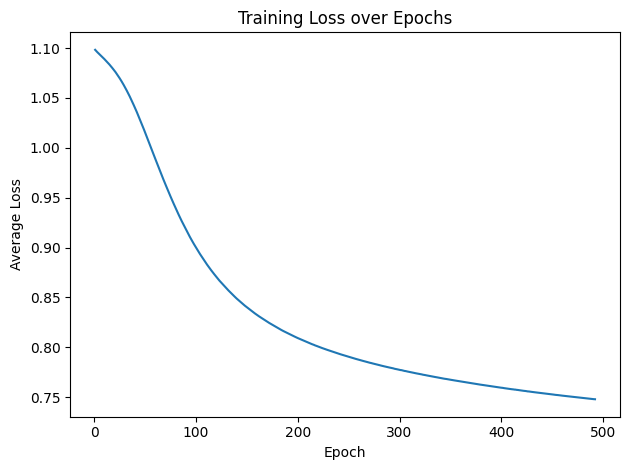

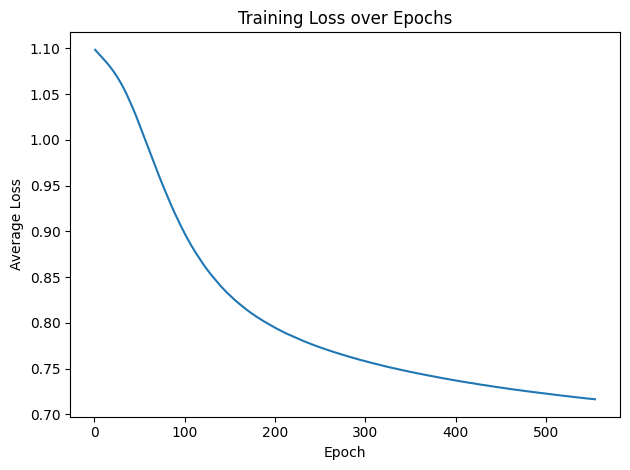

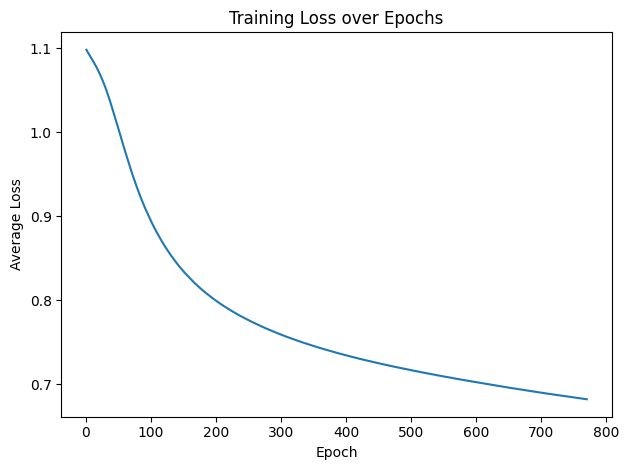

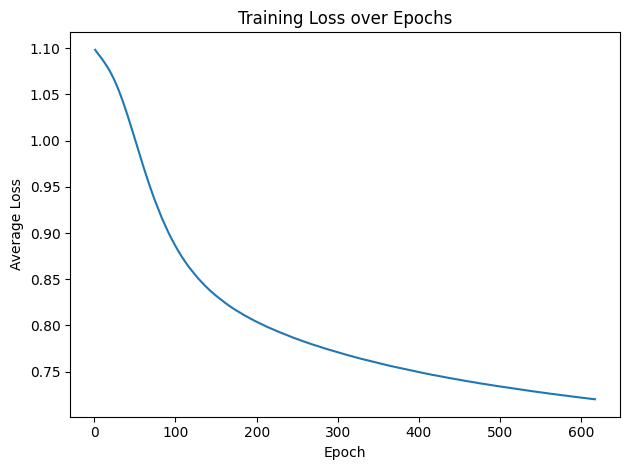

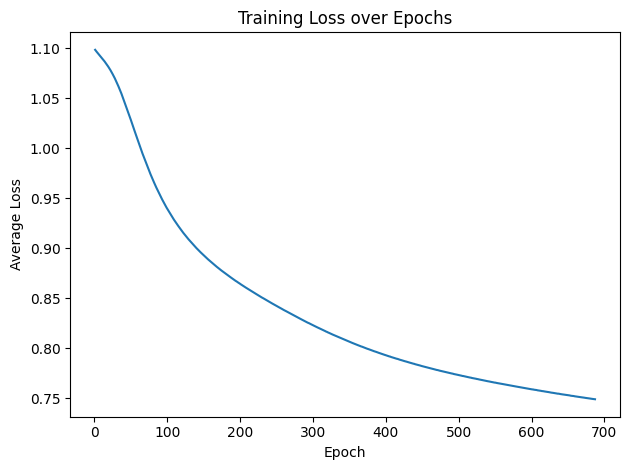

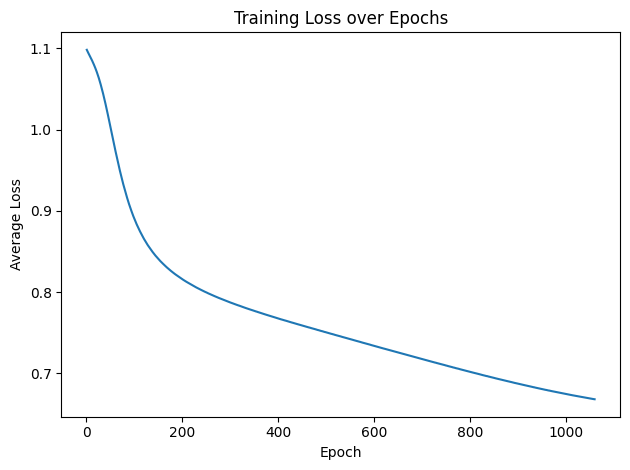

In [ ]:
DATA_SIZES = [125, 250, 500, 1000, 3000, 7000, 15000, 30000, 50000, 68000]

N_PARTITIONS = 20

path = 'transcript/20251119_000000/'
output_root = path + "partitions/"   # root directory for saving results
os.makedirs(output_root, exist_ok=True)

for n in DATA_SIZES:
    print(f"\n=== Data size {n} ===")
    save_dir = os.path.join(output_root, f"size_{n}")
    os.makedirs(save_dir, exist_ok=True)

    results = []

    for i in tqdm(range(N_PARTITIONS)):
        subset = random.sample(comparisons, 2 * n)

        S  = subset[:n]
        Sprime = subset[n:]

        T_S, t_S, model_S = train_trust_matrix(S)
        T_Sp, t_Sp, model_Sp = train_trust_matrix(Sprime)

        results.append({
            "T_S":    T_S.cpu().numpy().tolist(),
            "t_S":    t_S.cpu().numpy().tolist(),
            "T_Sp":   T_Sp.cpu().numpy().tolist(),
            "t_Sp":   t_Sp.cpu().numpy().tolist(),
        })

        # torch.save(model_S.state_dict(),   os.path.join(save_dir, f"model_S_{i}.pt"))
        # torch.save(model_Sp.state_dict(),  os.path.join(save_dir, f"model_Sp_{i}.pt"))

    with open(os.path.join(save_dir, "partitions.json"), "w") as f:
        json.dump(results, f, indent=2)


In [44]:
DATA_SIZES = [1000, 3000, 7000, 15000, 30000, 50000, 68000]

In [45]:
root = path + "partitions/"

def load_partitions(size_n):
    """Load all saved t_S and t_S' for a given data size n."""
    file_path = os.path.join(root, f"size_{size_n}", "partitions.json")
    with open(file_path, "r") as f:
        data = json.load(f)
    return data

def compute_norm_instability(entry, norm="l2"):
    """
    Compute ||t_S - t_S'|| for a single partition.
    norm='l2' or 'l1'.
    """
    t_S  = np.array(entry["t_S"])
    t_Sp = np.array(entry["t_Sp"])
    diff = t_S - t_Sp

    if norm == "l2":
        return np.linalg.norm(diff, ord=2)
    elif norm == "l1":
        return np.linalg.norm(diff, ord=1)
    else:
        raise ValueError("norm must be 'l1' or 'l2'")

In [46]:
mean_instability = []
std_instability = []
counts = []

norm_type = "l1"   # change to 'l1' if you prefer L1 instability

for n in DATA_SIZES:
    data = load_partitions(n)

    # compute norms for all partitions
    norms = np.array([
        compute_norm_instability(entry, norm=norm_type)
        for entry in data
    ])

    mean_instability.append(norms.mean())
    std_instability.append(norms.std())
    counts.append(len(norms))

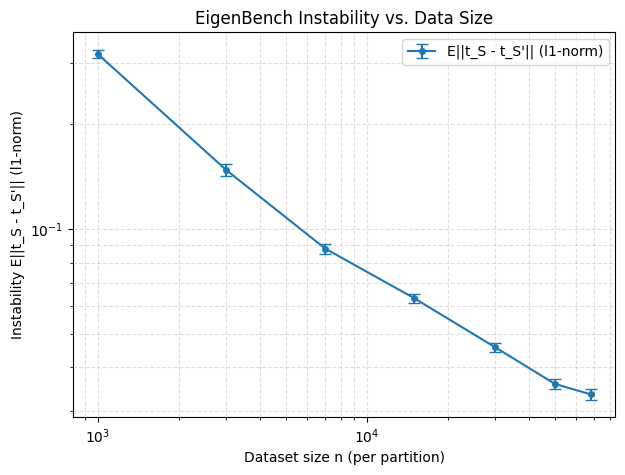

In [47]:
plt.figure(figsize=(7,5))

mean_instability = np.array(mean_instability)
std_instability = np.array(std_instability)

stderr = std_instability / np.sqrt(np.array(counts))

plt.errorbar(DATA_SIZES, mean_instability, yerr=stderr,
             fmt='o-', capsize=4, label=f"E||t_S - t_S'|| ({norm_type}-norm)", markersize=4)

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Dataset size n (per partition)")
plt.ylabel(f"Instability E||t_S - t_S'|| ({norm_type}-norm)")
plt.title("EigenBench Instability vs. Data Size")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.legend()

plt.show()

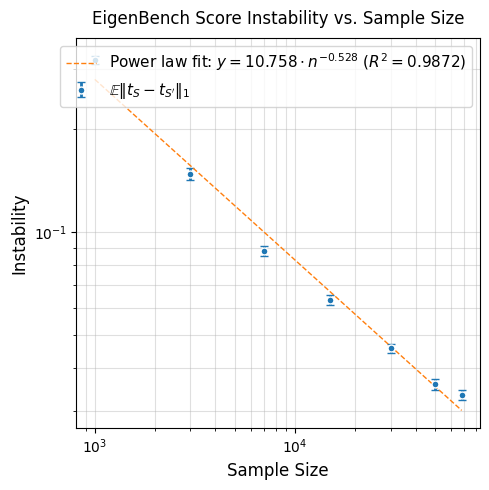

Power law exponent: -0.5285
Coefficient: 10.7580
R^2: 0.9872
Formula: instability = 10.7580 * n^-0.5285


In [95]:
plt.figure(figsize=(5,5))

mean_instability = np.array(mean_instability)
std_instability = np.array(std_instability)

stderr = std_instability / np.sqrt(np.array(counts))

# Fit power law: instability = a * size^b
# In log space: log(instability) = log(a) + b*log(size)
log_sizes = np.log(DATA_SIZES)
log_instability = np.log(mean_instability)

# Linear fit in log space
coeffs = np.polyfit(log_sizes, log_instability, 1)
b = coeffs[0]  # power law exponent
log_a = coeffs[1]
a = np.exp(log_a)

# Generate fitted line
fitted_instability = a * np.array(DATA_SIZES) ** b

# Calculate R^2
ss_res = np.sum((log_instability - (log_a + b * log_sizes)) ** 2)
ss_tot = np.sum((log_instability - np.mean(log_instability)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

# Plot data
plt.errorbar(DATA_SIZES, mean_instability, yerr=stderr,
             fmt='o', capsize=3, label=r"$\mathbb{E}\|t_S - t_{S'}\|_1$", markersize=5,
             capthick=1, elinewidth=2, markeredgecolor="#FFFFFF")

# Plot fitted line
plt.plot(DATA_SIZES, fitted_instability, '--', linewidth=1,
         label=f'Power law fit: $y = {a:.3f} \\cdot n^{{{b:.3f}}}$ ($R^2={r_squared:.4f}$)')

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Sample Size", fontsize=12)
plt.ylabel(f"Instability", fontsize=12)# E||t_S - t_S'|| ({norm_type}-norm)")
plt.title("EigenBench Score Instability vs. Sample Size", fontsize=12, pad=10)
plt.grid(True, which="both", alpha=0.4)
plt.legend(fontsize=11)
plt.tight_layout()

plt.savefig('figure.png', dpi=500)

plt.show()

print(f"Power law exponent: {b:.4f}")
print(f"Coefficient: {a:.4f}")
print(f"R^2: {r_squared:.4f}")
print(f"Formula: instability = {a:.4f} * n^{b:.4f}")